In [1]:
!nvidia-smi

Thu Jan 11 12:12:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:03:00.0  On |                  Off |
|  0%   38C    P8               8W / 450W |  23121MiB / 24564MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()

In [3]:
!pip install ultralytics==8.0.28

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24215MiB)
Setup complete ✅ (32 CPUs, 62.8 GB RAM, 979.7/1832.2 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image
import cv2
from ultralytics import YOLO
import numpy as np
import torch
import shutil
import csv
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from plantcv import plantcv as pcv
import argparse
from pyzbar import pyzbar

In [5]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="toOloKd6frPuw92IVM3o")
project = rf.workspace("sartor-lab").project("duckweed-segmentation-2")
dataset = project.version(3).download("yolov8")

mkdir: cannot create directory ‘/home/liftlab/ImageSegmentation/datasets’: File exists
/home/liftlab/ImageSegmentation/datasets
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.28, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to Duckweed-Segmentation-2-3 in yolov8:: 100%|█| 


In [6]:
%cd {HOME}

!yolo task=segment mode=train model=yolov8s-seg.pt data={dataset.location}/data.yaml epochs=10 imgsz=640

/home/liftlab/ImageSegmentation
Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24215MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/home/liftlab/ImageSegmentation/datasets/Duckweed-Segmentation-2-3/data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=t

/home/liftlab/ImageSegmentation


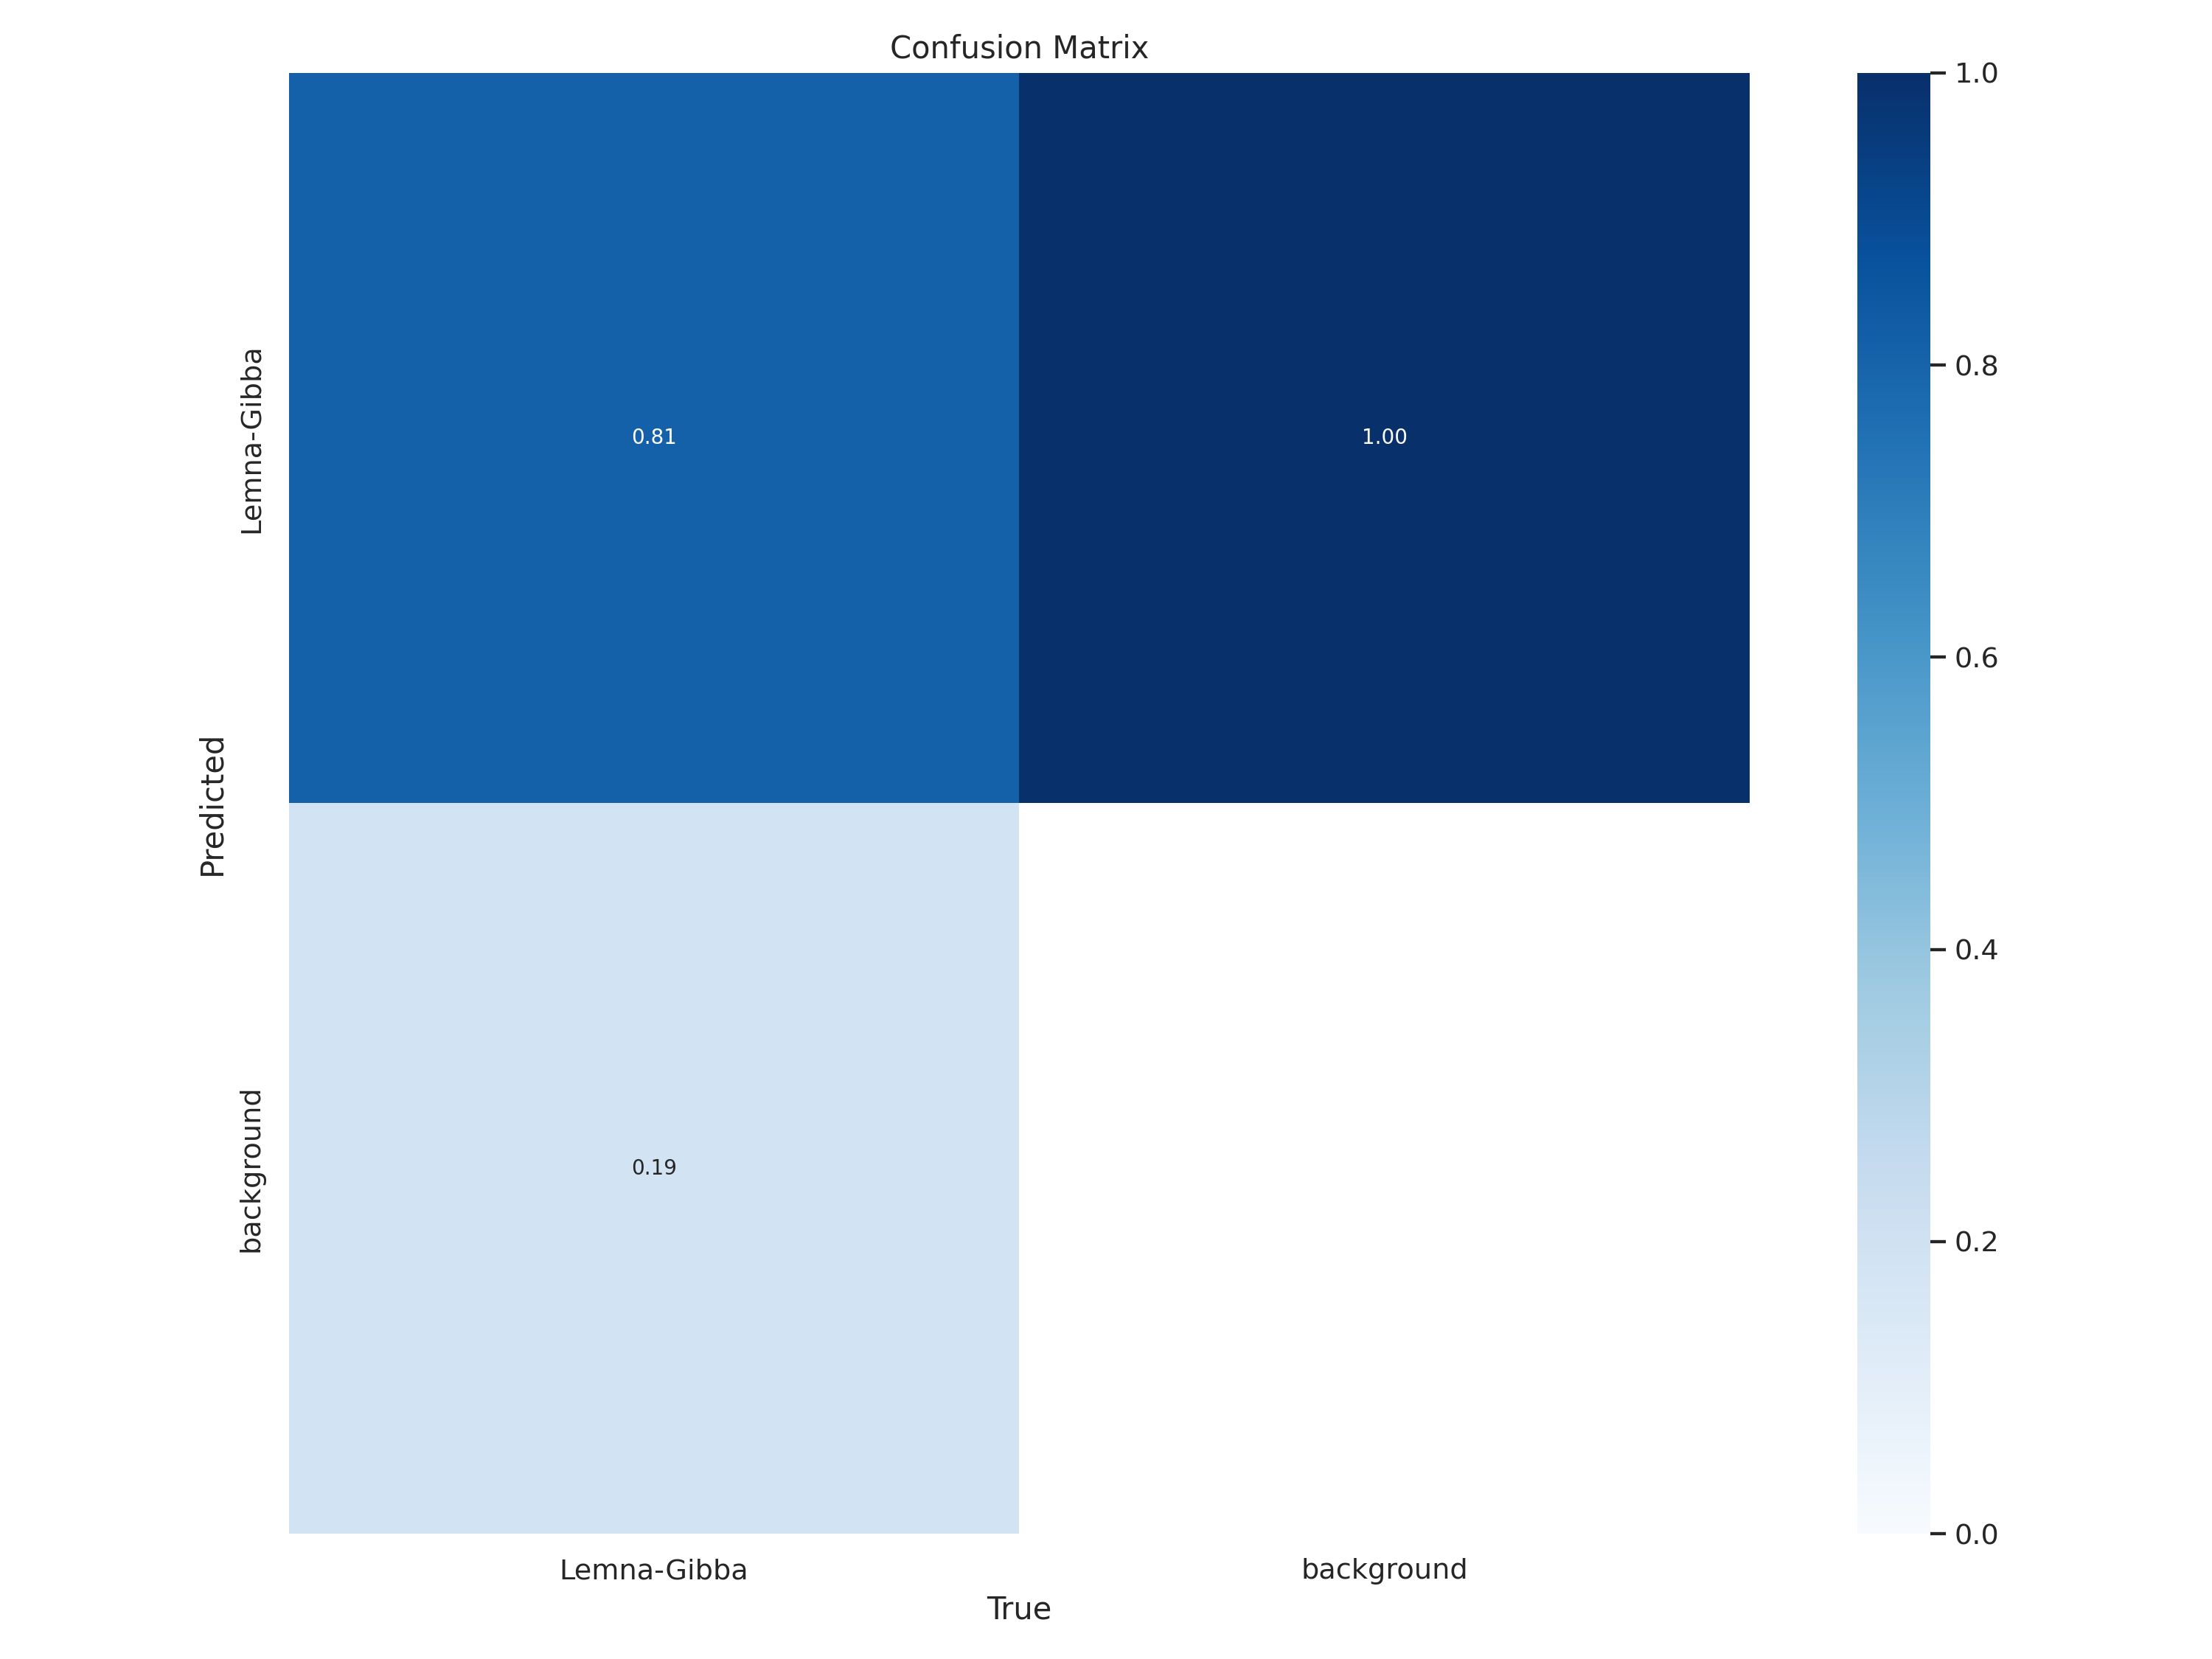

In [11]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train5/confusion_matrix.png', width=600)

/home/liftlab/ImageSegmentation


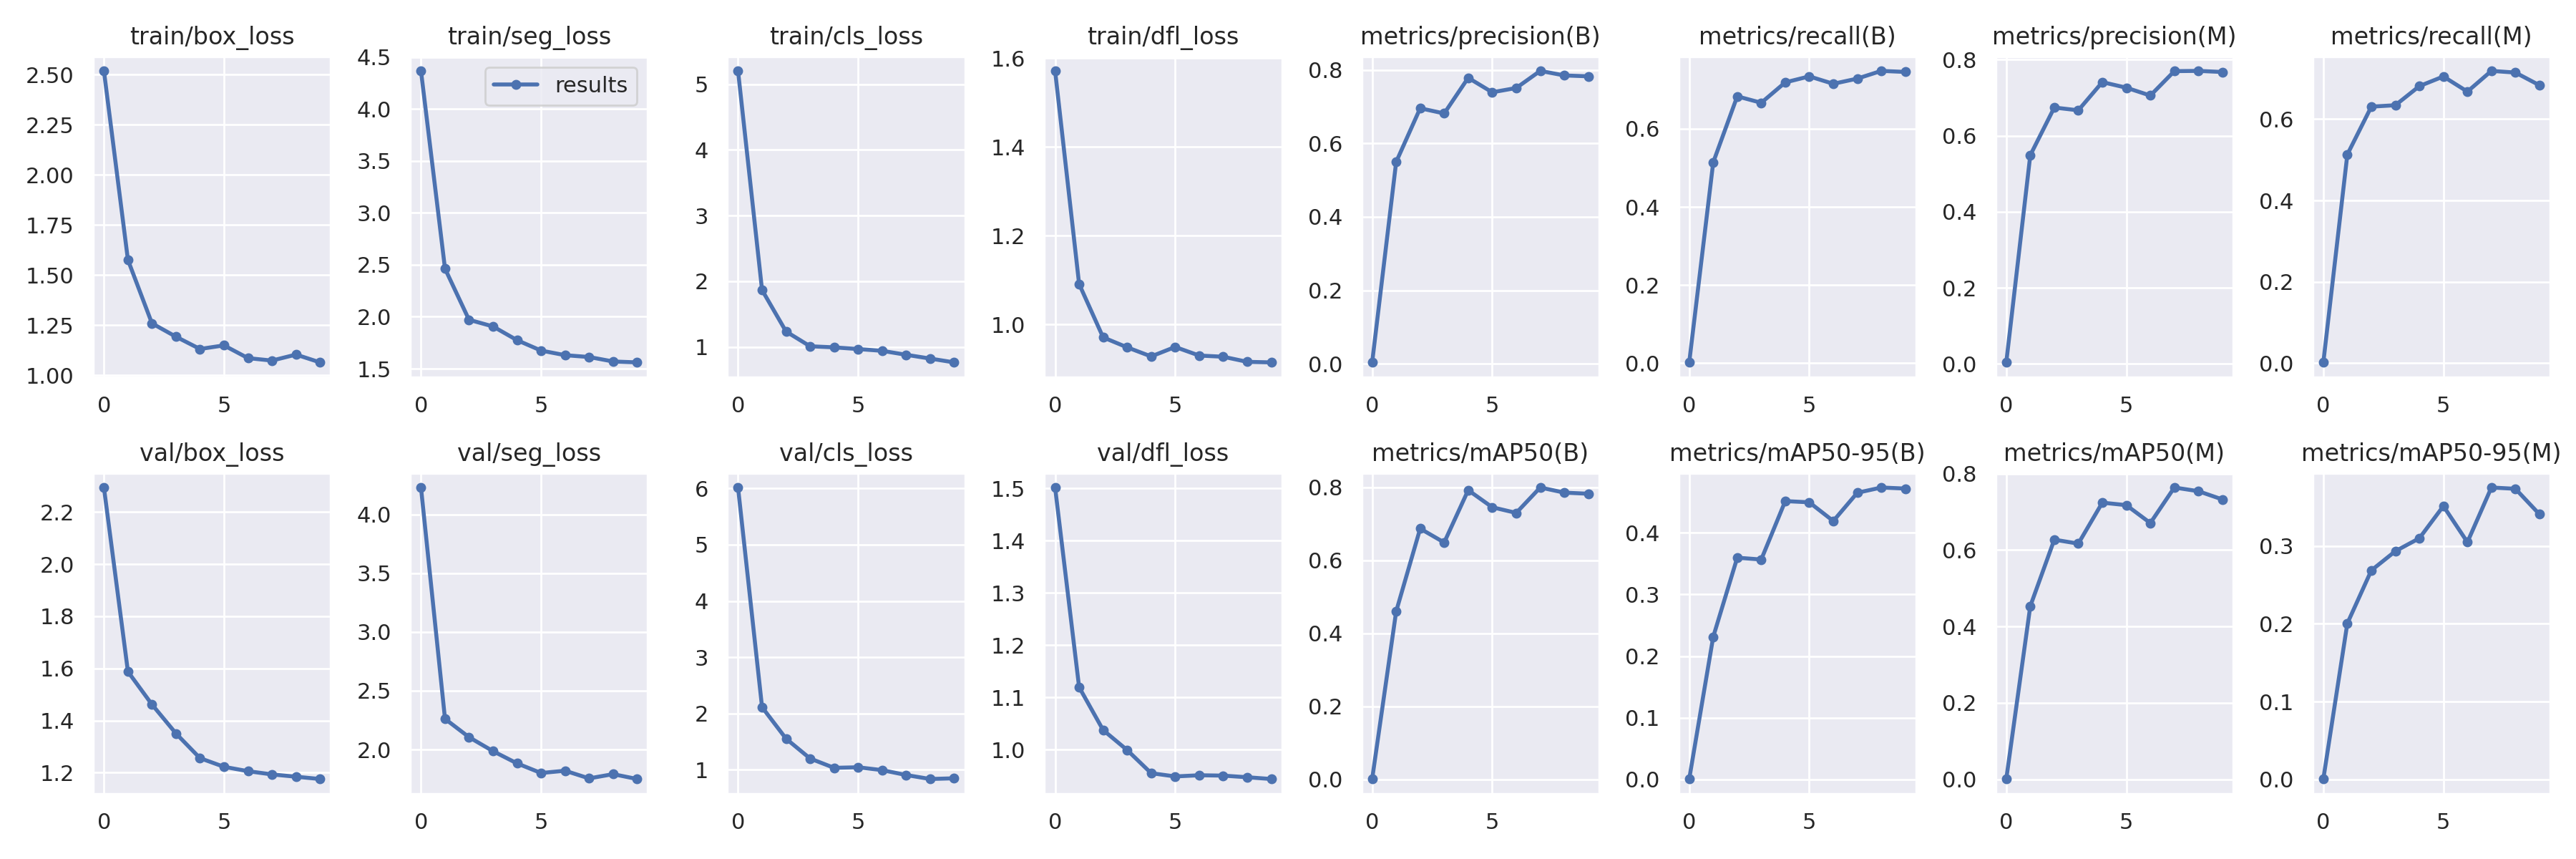

In [12]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train5/results.png', width=600)

In [31]:
%cd {HOME}

!yolo task=segment mode=val model={HOME}/runs/segment/train5/weights/best.pt data={dataset.location}/data.yaml

/home/liftlab/ImageSegmentation
2023-11-28 13:54:15.075935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24215MiB)
YOLOv8s-seg summary (fused): 195 layers, 11779987 parameters, 0 gradients, 42.4 GFLOPs
val: Scanning /home/liftlab/ImageSegmentation/datasets/Duckweed-Segmentation-2-3
val: WARNING ⚠️ /home/liftlab/ImageSegmentation/datasets/Duckweed-Segmentation-2-3/valid/images/capture-2-2023_11_09_08-12-49_jpg.rf.bb3d2f4354a65791e6046894dc5ef884.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/liftlab/ImageSegmentation/datasets/Duckweed-Segmentation-2-3/valid/images/capture-3-2023_07_19_15_35_06_jpg.rf.39f50acf962feb83c9dcd2a53de4c989.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         45       2278      0.786      0.748      0.786      0.476      0.7

In [9]:
%cd {HOME}
import datetime

start_date = datetime.datetime(2023, 11, 17)
end_date = datetime.datetime(2023, 12, 8)

# image folder to run predict model on
drive_folder =  '/home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images' #'/home/liftlab/mnt/gdrive/RaspberryPi/New_Images/ALPHA/'
sub_folder = 'masks' # folder to save mask images in
sub_folder_2 = "barcode_images" # folder to save barcode images to
csv_folder = "csv" # folder to save csv file to
model = YOLO('/home/liftlab/ImageSegmentation/runs/segment/train5/weights/best.pt') # training model to predict with
results = model.predict(source= drive_folder, save=True, save_txt=False, stream=True, hide_labels=True, hide_conf=True, boxes=False)
csv_path = os.path.join(str(model.predictor.save_dir), csv_folder) # folder to save csv file to
subfolder_path = os.path.join(str(model.predictor.save_dir), sub_folder) ## creating subfolder for masks
subfolder_path_2 = os.path.join(str(model.predictor.save_dir), sub_folder_2) ## creating subfolder for barcode images
os.makedirs(subfolder_path, exist_ok=True)
os.makedirs(subfolder_path_2, exist_ok=True)
os.makedirs(csv_path, exist_ok=True)


for result in results: ## iterating through prediction results
    dir = str(model.predictor.save_dir)
    files = os.listdir(dir)
 
    for file in files: ## enusuring that only one segmented image stays in the folder at a time to ensure that 
        if "masks" in file or "barcode_images" in file or "csv" in file: ## skip over masks subfolder
            continue
        base, e = os.path.splitext(file) # split base name and extension
        # Construct the full path to the file
        file_path_r = os.path.join(dir, file)
        print(file)
        camera1 = file[8]
        date_str = file[10:20]
        time_str = file[21:29]
        date_str = date_str.replace('_', ':')
        timestamp_str = f"{date_str}_{time_str}".replace('_', ':')  # Combine date and time and replace underscores
        timestamp = datetime.datetime.strptime(timestamp_str, '%Y:%m:%d:%H:%M:%S')
        if (timestamp < start_date) or (timestamp > end_date):
            os.remove(file_path_r)
            continue
        
        if camera1 in ['2', '3', '6', '7']: #seperating plant images from barcode images
            os.remove(file_path_r)
        else:
            dest_path = os.path.join(subfolder_path_2, file) # move barcode images to 
            shutil.move(file_path_r, dest_path)

    if (timestamp < start_date) or (timestamp > end_date):
        continue
    
    if result.masks is None:
        continue

    if camera1 in ['2', '3', '6', '7']:
        masks = result.masks.data
        boxes = result.boxes.data
        clss = boxes[:,5]
        people_indices = torch.where(clss == 0)
        people_masks = masks[people_indices]
        people_mask = torch.any(people_masks, dim=0).int() * 255
        file_path = os.path.join(subfolder_path, f'{base}.jpg')
        cv2.imwrite(file_path, people_mask.cpu().numpy())

Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24215MiB)


/home/liftlab/ImageSegmentation


YOLOv8s-seg summary (fused): 195 layers, 11779987 parameters, 0 gradients, 42.4 GFLOPs

image 1/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:41:45.jpg: 480x640 1 Lemna-Gibba, 14.2ms
image 2/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:41:55.jpg: 480x640 3 Lemna-Gibbas, 14.1ms


capture-1-2023_11_17_11:41:45.jpg
capture-1-2023_11_17_11:41:55.jpg


image 3/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:42:06.jpg: 480x640 1 Lemna-Gibba, 15.1ms
image 4/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:42:17.jpg: 480x640 13.4ms


capture-1-2023_11_17_11:42:06.jpg
capture-1-2023_11_17_11:42:17.jpg


image 5/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:42:28.jpg: 480x640 2 Lemna-Gibbas, 13.5ms
image 6/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:42:38.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-1-2023_11_17_11:42:28.jpg
capture-1-2023_11_17_11:42:38.jpg


image 7/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:44:35.jpg: 480x640 14.6ms
image 8/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:44:46.jpg: 480x640 13.6ms


capture-1-2023_11_17_11:44:35.jpg
capture-1-2023_11_17_11:44:46.jpg


image 9/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:44:56.jpg: 480x640 13.4ms
image 10/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:45:07.jpg: 480x640 13.4ms


capture-1-2023_11_17_11:44:56.jpg
capture-1-2023_11_17_11:45:07.jpg


image 11/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:45:18.jpg: 480x640 13.3ms
image 12/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:45:28.jpg: 480x640 13.3ms


capture-1-2023_11_17_11:45:18.jpg
capture-1-2023_11_17_11:45:28.jpg


image 13/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:47:13.jpg: 480x640 13.4ms
image 14/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:47:23.jpg: 480x640 13.4ms


capture-1-2023_11_17_11:47:13.jpg
capture-1-2023_11_17_11:47:23.jpg


image 15/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:47:34.jpg: 480x640 13.5ms
image 16/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:47:45.jpg: 480x640 13.3ms


capture-1-2023_11_17_11:47:34.jpg
capture-1-2023_11_17_11:47:45.jpg


image 17/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:47:56.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 18/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:48:06.jpg: 480x640 13.5ms


capture-1-2023_11_17_11:47:56.jpg
capture-1-2023_11_17_11:48:06.jpg


image 19/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:49:25.jpg: 480x640 13.4ms
image 20/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:49:35.jpg: 480x640 13.3ms


capture-1-2023_11_17_11:49:25.jpg
capture-1-2023_11_17_11:49:35.jpg


image 21/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:49:46.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 22/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:49:57.jpg: 480x640 13.5ms


capture-1-2023_11_17_11:49:46.jpg
capture-1-2023_11_17_11:49:57.jpg


image 23/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:50:07.jpg: 480x640 13.4ms
image 24/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:50:18.jpg: 480x640 13.5ms


capture-1-2023_11_17_11:50:07.jpg
capture-1-2023_11_17_11:50:18.jpg


image 25/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:51:34.jpg: 480x640 13.3ms
image 26/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:51:45.jpg: 480x640 13.4ms


capture-1-2023_11_17_11:51:34.jpg
capture-1-2023_11_17_11:51:45.jpg


image 27/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:51:55.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 28/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:52:06.jpg: 480x640 13.6ms


capture-1-2023_11_17_11:51:55.jpg
capture-1-2023_11_17_11:52:06.jpg


image 29/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:52:17.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 30/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:52:27.jpg: 480x640 13.5ms


capture-1-2023_11_17_11:52:17.jpg
capture-1-2023_11_17_11:52:27.jpg


image 31/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:53:43.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 32/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:53:54.jpg: 480x640 13.5ms


capture-1-2023_11_17_11:53:43.jpg
capture-1-2023_11_17_11:53:54.jpg


image 33/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:54:05.jpg: 480x640 13.3ms
image 34/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:54:16.jpg: 480x640 13.3ms


capture-1-2023_11_17_11:54:05.jpg
capture-1-2023_11_17_11:54:16.jpg


image 35/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:54:26.jpg: 480x640 2 Lemna-Gibbas, 13.3ms
image 36/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:54:37.jpg: 480x640 13.3ms


capture-1-2023_11_17_11:54:26.jpg
capture-1-2023_11_17_11:54:37.jpg


image 37/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:55:56.jpg: 480x640 13.3ms
image 38/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:56:06.jpg: 480x640 2 Lemna-Gibbas, 13.3ms


capture-1-2023_11_17_11:55:56.jpg
capture-1-2023_11_17_11:56:06.jpg


image 39/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:56:17.jpg: 480x640 14.6ms
image 40/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:56:28.jpg: 480x640 13.3ms


capture-1-2023_11_17_11:56:17.jpg
capture-1-2023_11_17_11:56:28.jpg


image 41/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:56:39.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 42/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:56:49.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-1-2023_11_17_11:56:39.jpg
capture-1-2023_11_17_11:56:49.jpg


image 43/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:58:16.jpg: 480x640 14.3ms
image 44/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:58:26.jpg: 480x640 13.4ms


capture-1-2023_11_17_11:58:16.jpg
capture-1-2023_11_17_11:58:26.jpg


image 45/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:58:37.jpg: 480x640 13.3ms
image 46/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:58:48.jpg: 480x640 13.6ms


capture-1-2023_11_17_11:58:37.jpg
capture-1-2023_11_17_11:58:48.jpg


image 47/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:58:59.jpg: 480x640 15.2ms
image 48/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_11:59:09.jpg: 480x640 13.4ms


capture-1-2023_11_17_11:58:59.jpg
capture-1-2023_11_17_11:59:09.jpg


image 49/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:01:30.jpg: 480x640 13.4ms
image 50/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:01:40.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-1-2023_11_17_12:01:30.jpg
capture-1-2023_11_17_12:01:40.jpg


image 51/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:01:51.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 52/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:02:02.jpg: 480x640 13.5ms


capture-1-2023_11_17_12:01:51.jpg
capture-1-2023_11_17_12:02:02.jpg


image 53/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:02:13.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 54/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:02:23.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_17_12:02:13.jpg
capture-1-2023_11_17_12:02:23.jpg


image 55/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:04:26.jpg: 480x640 14.4ms
image 56/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:04:36.jpg: 480x640 13.4ms


capture-1-2023_11_17_12:04:26.jpg
capture-1-2023_11_17_12:04:36.jpg


image 57/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:04:47.jpg: 480x640 13.5ms
image 58/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:04:58.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_17_12:04:47.jpg
capture-1-2023_11_17_12:04:58.jpg


image 59/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:05:08.jpg: 480x640 14.6ms
image 60/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:05:19.jpg: 480x640 13.4ms


capture-1-2023_11_17_12:05:08.jpg
capture-1-2023_11_17_12:05:19.jpg


image 61/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:06:52.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 62/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:07:02.jpg: 480x640 2 Lemna-Gibbas, 13.5ms


capture-1-2023_11_17_12:06:52.jpg
capture-1-2023_11_17_12:07:02.jpg


image 63/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:07:13.jpg: 480x640 14.7ms
image 64/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:07:24.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-1-2023_11_17_12:07:13.jpg
capture-1-2023_11_17_12:07:24.jpg


image 65/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:07:34.jpg: 480x640 14.5ms
image 66/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:07:45.jpg: 480x640 14.3ms


capture-1-2023_11_17_12:07:34.jpg
capture-1-2023_11_17_12:07:45.jpg


image 67/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:09:27.jpg: 480x640 13.3ms
image 68/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:09:37.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_17_12:09:27.jpg
capture-1-2023_11_17_12:09:37.jpg


image 69/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:09:48.jpg: 480x640 14.6ms
image 70/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:09:59.jpg: 480x640 13.3ms


capture-1-2023_11_17_12:09:48.jpg
capture-1-2023_11_17_12:09:59.jpg


image 71/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:10:10.jpg: 480x640 13.5ms
image 72/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:10:20.jpg: 480x640 13.4ms


capture-1-2023_11_17_12:10:10.jpg
capture-1-2023_11_17_12:10:20.jpg


image 73/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:12:22.jpg: 480x640 13.3ms
image 74/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:12:33.jpg: 480x640 13.4ms


capture-1-2023_11_17_12:12:22.jpg
capture-1-2023_11_17_12:12:33.jpg


image 75/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:12:43.jpg: 480x640 13.3ms
image 76/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:12:55.jpg: 480x640 13.5ms


capture-1-2023_11_17_12:12:43.jpg
capture-1-2023_11_17_12:12:55.jpg


image 77/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:13:05.jpg: 480x640 13.4ms
image 78/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_17_12:13:16.jpg: 480x640 13.3ms


capture-1-2023_11_17_12:13:05.jpg
capture-1-2023_11_17_12:13:16.jpg


image 79/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:26:21.jpg: 480x640 13.5ms
image 80/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:26:32.jpg: 480x640 13.3ms


capture-1-2023_11_20_10:26:21.jpg
capture-1-2023_11_20_10:26:32.jpg


image 81/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:26:43.jpg: 480x640 13.5ms
image 82/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:26:54.jpg: 480x640 13.4ms


capture-1-2023_11_20_10:26:43.jpg
capture-1-2023_11_20_10:26:54.jpg


image 83/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:27:04.jpg: 480x640 13.6ms
image 84/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:27:15.jpg: 480x640 13.5ms


capture-1-2023_11_20_10:27:04.jpg
capture-1-2023_11_20_10:27:15.jpg


image 85/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:29:13.jpg: 480x640 13.3ms
image 86/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:29:24.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-1-2023_11_20_10:29:13.jpg
capture-1-2023_11_20_10:29:24.jpg


image 87/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:29:35.jpg: 480x640 14.3ms
image 88/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:29:46.jpg: 480x640 13.3ms


capture-1-2023_11_20_10:29:35.jpg
capture-1-2023_11_20_10:29:46.jpg


image 89/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:29:56.jpg: 480x640 13.5ms
image 90/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:30:07.jpg: 480x640 13.5ms


capture-1-2023_11_20_10:29:56.jpg
capture-1-2023_11_20_10:30:07.jpg


image 91/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:31:23.jpg: 480x640 13.4ms
image 92/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:31:33.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_20_10:31:23.jpg
capture-1-2023_11_20_10:31:33.jpg


image 93/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:31:44.jpg: 480x640 13.3ms
image 94/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:31:55.jpg: 480x640 13.3ms


capture-1-2023_11_20_10:31:44.jpg
capture-1-2023_11_20_10:31:55.jpg


image 95/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:32:06.jpg: 480x640 13.3ms
image 96/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:32:16.jpg: 480x640 13.3ms


capture-1-2023_11_20_10:32:06.jpg
capture-1-2023_11_20_10:32:16.jpg


image 97/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:33:46.jpg: 480x640 13.4ms
image 98/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:33:56.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-1-2023_11_20_10:33:46.jpg
capture-1-2023_11_20_10:33:56.jpg


image 99/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:34:07.jpg: 480x640 13.4ms
image 100/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:34:18.jpg: 480x640 13.4ms


capture-1-2023_11_20_10:34:07.jpg
capture-1-2023_11_20_10:34:18.jpg


image 101/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:34:29.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 102/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:34:39.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_20_10:34:29.jpg
capture-1-2023_11_20_10:34:39.jpg


image 103/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:36:18.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 104/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:36:29.jpg: 480x640 2 Lemna-Gibbas, 13.6ms


capture-1-2023_11_20_10:36:18.jpg
capture-1-2023_11_20_10:36:29.jpg


image 105/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:36:39.jpg: 480x640 13.6ms
image 106/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:36:50.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_20_10:36:39.jpg
capture-1-2023_11_20_10:36:50.jpg


image 107/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:37:01.jpg: 480x640 1 Lemna-Gibba, 14.5ms
image 108/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:37:12.jpg: 480x640 13.6ms


capture-1-2023_11_20_10:37:01.jpg
capture-1-2023_11_20_10:37:12.jpg


image 109/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:38:31.jpg: 480x640 13.7ms
image 110/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:38:42.jpg: 480x640 13.4ms


capture-1-2023_11_20_10:38:31.jpg
capture-1-2023_11_20_10:38:42.jpg


image 111/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:38:52.jpg: 480x640 13.5ms
image 112/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:39:03.jpg: 480x640 13.2ms


capture-1-2023_11_20_10:38:52.jpg
capture-1-2023_11_20_10:39:03.jpg


image 113/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:39:14.jpg: 480x640 13.3ms
image 114/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:39:24.jpg: 480x640 13.4ms


capture-1-2023_11_20_10:39:14.jpg
capture-1-2023_11_20_10:39:24.jpg


image 115/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:40:53.jpg: 480x640 13.3ms
image 116/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:41:04.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_20_10:40:53.jpg
capture-1-2023_11_20_10:41:04.jpg


image 117/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:41:14.jpg: 480x640 13.2ms
image 118/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:41:25.jpg: 480x640 13.3ms


capture-1-2023_11_20_10:41:14.jpg
capture-1-2023_11_20_10:41:25.jpg


image 119/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:41:36.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 120/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:41:47.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-1-2023_11_20_10:41:36.jpg
capture-1-2023_11_20_10:41:47.jpg


image 121/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:43:14.jpg: 480x640 13.5ms
image 122/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:43:24.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_20_10:43:14.jpg
capture-1-2023_11_20_10:43:24.jpg


image 123/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:43:35.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 124/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:43:46.jpg: 480x640 13.6ms


capture-1-2023_11_20_10:43:35.jpg
capture-1-2023_11_20_10:43:46.jpg


image 125/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:43:56.jpg: 480x640 2 Lemna-Gibbas, 13.9ms
image 126/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:44:07.jpg: 480x640 13.5ms


capture-1-2023_11_20_10:43:56.jpg
capture-1-2023_11_20_10:44:07.jpg


image 127/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:45:21.jpg: 480x640 13.3ms
image 128/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:45:32.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_20_10:45:21.jpg
capture-1-2023_11_20_10:45:32.jpg


image 129/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:45:42.jpg: 480x640 13.3ms
image 130/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:45:53.jpg: 480x640 13.3ms


capture-1-2023_11_20_10:45:42.jpg
capture-1-2023_11_20_10:45:53.jpg


image 131/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:46:04.jpg: 480x640 13.3ms
image 132/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:46:15.jpg: 480x640 13.2ms


capture-1-2023_11_20_10:46:04.jpg
capture-1-2023_11_20_10:46:15.jpg


image 133/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:48:10.jpg: 480x640 13.3ms
image 134/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:48:20.jpg: 480x640 13.2ms


capture-1-2023_11_20_10:48:10.jpg
capture-1-2023_11_20_10:48:20.jpg


image 135/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:48:31.jpg: 480x640 13.5ms
image 136/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:48:42.jpg: 480x640 13.5ms


capture-1-2023_11_20_10:48:31.jpg
capture-1-2023_11_20_10:48:42.jpg


image 137/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:48:53.jpg: 480x640 13.3ms
image 138/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:49:03.jpg: 480x640 13.5ms


capture-1-2023_11_20_10:48:53.jpg
capture-1-2023_11_20_10:49:03.jpg


image 139/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:50:48.jpg: 480x640 13.3ms
image 140/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:50:58.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-1-2023_11_20_10:50:48.jpg
capture-1-2023_11_20_10:50:58.jpg


image 141/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:51:09.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 142/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:51:20.jpg: 480x640 13.7ms


capture-1-2023_11_20_10:51:09.jpg
capture-1-2023_11_20_10:51:20.jpg


image 143/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:51:30.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 144/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:51:41.jpg: 480x640 13.3ms


capture-1-2023_11_20_10:51:30.jpg
capture-1-2023_11_20_10:51:41.jpg


image 145/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:53:35.jpg: 480x640 13.5ms
image 146/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:53:46.jpg: 480x640 13.3ms


capture-1-2023_11_20_10:53:35.jpg
capture-1-2023_11_20_10:53:46.jpg


image 147/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:53:56.jpg: 480x640 13.4ms
image 148/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:54:07.jpg: 480x640 14.0ms


capture-1-2023_11_20_10:53:56.jpg
capture-1-2023_11_20_10:54:07.jpg


image 149/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:54:18.jpg: 480x640 3 Lemna-Gibbas, 13.4ms
image 150/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_20_10:54:29.jpg: 480x640 13.4ms


capture-1-2023_11_20_10:54:18.jpg
capture-1-2023_11_20_10:54:29.jpg


image 151/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:18:54.jpg: 480x640 13.3ms
image 152/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:19:04.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_21_08:18:54.jpg
capture-1-2023_11_21_08:19:04.jpg


image 153/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:19:15.jpg: 480x640 13.4ms
image 154/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:19:26.jpg: 480x640 13.3ms


capture-1-2023_11_21_08:19:15.jpg
capture-1-2023_11_21_08:19:26.jpg


image 155/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:19:37.jpg: 480x640 2 Lemna-Gibbas, 13.7ms
image 156/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:19:47.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_21_08:19:37.jpg
capture-1-2023_11_21_08:19:47.jpg


image 157/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:21:12.jpg: 480x640 13.4ms
image 158/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:21:23.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:21:12.jpg
capture-1-2023_11_21_08:21:23.jpg


image 159/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:21:33.jpg: 480x640 13.3ms
image 160/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:21:44.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:21:33.jpg
capture-1-2023_11_21_08:21:44.jpg


image 161/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:21:55.jpg: 480x640 13.3ms
image 162/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:22:06.jpg: 480x640 13.5ms


capture-1-2023_11_21_08:21:55.jpg
capture-1-2023_11_21_08:22:06.jpg


image 163/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:23:26.jpg: 480x640 13.3ms
image 164/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:23:37.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_21_08:23:26.jpg
capture-1-2023_11_21_08:23:37.jpg


image 165/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:23:47.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 166/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:23:58.jpg: 480x640 13.6ms


capture-1-2023_11_21_08:23:47.jpg
capture-1-2023_11_21_08:23:58.jpg


image 167/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:24:09.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 168/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:24:20.jpg: 480x640 2 Lemna-Gibbas, 13.3ms


capture-1-2023_11_21_08:24:09.jpg
capture-1-2023_11_21_08:24:20.jpg


image 169/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:27:11.jpg: 480x640 13.4ms
image 170/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:27:22.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-1-2023_11_21_08:27:11.jpg
capture-1-2023_11_21_08:27:22.jpg


image 171/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:27:32.jpg: 480x640 13.3ms
image 172/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:27:43.jpg: 480x640 15.0ms


capture-1-2023_11_21_08:27:32.jpg
capture-1-2023_11_21_08:27:43.jpg


image 173/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:27:54.jpg: 480x640 13.3ms
image 174/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:28:05.jpg: 480x640 13.3ms


capture-1-2023_11_21_08:27:54.jpg
capture-1-2023_11_21_08:28:05.jpg


image 175/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:29:39.jpg: 480x640 13.3ms
image 176/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:29:49.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-1-2023_11_21_08:29:39.jpg
capture-1-2023_11_21_08:29:49.jpg


image 177/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:30:00.jpg: 480x640 13.4ms
image 178/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:30:11.jpg: 480x640 13.2ms


capture-1-2023_11_21_08:30:00.jpg
capture-1-2023_11_21_08:30:11.jpg


image 179/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:30:21.jpg: 480x640 13.5ms
image 180/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:30:32.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:30:21.jpg
capture-1-2023_11_21_08:30:32.jpg


image 181/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:32:03.jpg: 480x640 13.3ms
image 182/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:32:13.jpg: 480x640 13.3ms


capture-1-2023_11_21_08:32:03.jpg
capture-1-2023_11_21_08:32:13.jpg


image 183/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:32:24.jpg: 480x640 13.4ms
image 184/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:32:35.jpg: 480x640 13.2ms


capture-1-2023_11_21_08:32:24.jpg
capture-1-2023_11_21_08:32:35.jpg


image 185/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:32:45.jpg: 480x640 2 Lemna-Gibbas, 13.2ms
image 186/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:32:56.jpg: 480x640 13.2ms


capture-1-2023_11_21_08:32:45.jpg
capture-1-2023_11_21_08:32:56.jpg


image 187/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:35:24.jpg: 480x640 13.3ms
image 188/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:35:34.jpg: 480x640 13.2ms


capture-1-2023_11_21_08:35:24.jpg
capture-1-2023_11_21_08:35:34.jpg


image 189/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:35:45.jpg: 480x640 13.4ms
image 190/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:35:56.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:35:45.jpg
capture-1-2023_11_21_08:35:56.jpg


image 191/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:36:07.jpg: 480x640 13.3ms
image 192/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:36:17.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:36:07.jpg
capture-1-2023_11_21_08:36:17.jpg


image 193/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:37:32.jpg: 480x640 13.4ms
image 194/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:37:43.jpg: 480x640 13.6ms


capture-1-2023_11_21_08:37:32.jpg
capture-1-2023_11_21_08:37:43.jpg


image 195/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:37:53.jpg: 480x640 16.2ms
image 196/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:38:04.jpg: 480x640 14.7ms


capture-1-2023_11_21_08:37:53.jpg
capture-1-2023_11_21_08:38:04.jpg


image 197/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:38:15.jpg: 480x640 13.5ms
image 198/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:38:26.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:38:15.jpg
capture-1-2023_11_21_08:38:26.jpg


image 199/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:40:33.jpg: 480x640 1 Lemna-Gibba, 14.2ms
image 200/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:40:43.jpg: 480x640 13.6ms


capture-1-2023_11_21_08:40:33.jpg
capture-1-2023_11_21_08:40:43.jpg


image 201/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:40:54.jpg: 480x640 13.2ms
image 202/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:41:05.jpg: 480x640 13.9ms


capture-1-2023_11_21_08:40:54.jpg
capture-1-2023_11_21_08:41:05.jpg


image 203/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:41:15.jpg: 480x640 13.9ms
image 204/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:41:26.jpg: 480x640 1 Lemna-Gibba, 14.0ms


capture-1-2023_11_21_08:41:15.jpg
capture-1-2023_11_21_08:41:26.jpg


image 205/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:43:04.jpg: 480x640 16.1ms
image 206/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:43:14.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:43:04.jpg
capture-1-2023_11_21_08:43:14.jpg


image 207/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:43:25.jpg: 480x640 13.3ms
image 208/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:43:36.jpg: 480x640 13.3ms


capture-1-2023_11_21_08:43:25.jpg
capture-1-2023_11_21_08:43:36.jpg


image 209/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:43:47.jpg: 480x640 2 Lemna-Gibbas, 13.2ms
image 210/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:43:57.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:43:47.jpg
capture-1-2023_11_21_08:43:57.jpg


image 211/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:45:14.jpg: 480x640 13.3ms
image 212/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:45:25.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_21_08:45:14.jpg
capture-1-2023_11_21_08:45:25.jpg


image 213/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:45:35.jpg: 480x640 14.7ms
image 214/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:45:46.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:45:35.jpg
capture-1-2023_11_21_08:45:46.jpg


image 215/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:45:57.jpg: 480x640 13.4ms
image 216/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:46:08.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:45:57.jpg
capture-1-2023_11_21_08:46:08.jpg


image 217/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:48:18.jpg: 480x640 13.4ms
image 218/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:48:28.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-1-2023_11_21_08:48:18.jpg
capture-1-2023_11_21_08:48:28.jpg


image 219/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:48:39.jpg: 480x640 13.4ms
image 220/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:48:50.jpg: 480x640 13.3ms


capture-1-2023_11_21_08:48:39.jpg
capture-1-2023_11_21_08:48:50.jpg


image 221/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:49:00.jpg: 480x640 2 Lemna-Gibbas, 13.5ms
image 222/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_21_08:49:11.jpg: 480x640 13.4ms


capture-1-2023_11_21_08:49:00.jpg
capture-1-2023_11_21_08:49:11.jpg


image 223/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:11:04.jpg: 480x640 13.3ms
image 224/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:11:15.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_22_10:11:04.jpg
capture-1-2023_11_22_10:11:15.jpg


image 225/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:11:25.jpg: 480x640 13.3ms
image 226/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:11:36.jpg: 480x640 13.3ms


capture-1-2023_11_22_10:11:25.jpg
capture-1-2023_11_22_10:11:36.jpg


image 227/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:11:47.jpg: 480x640 2 Lemna-Gibbas, 13.2ms
image 228/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:11:57.jpg: 480x640 13.4ms


capture-1-2023_11_22_10:11:47.jpg
capture-1-2023_11_22_10:11:57.jpg


image 229/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:19:43.jpg: 480x640 13.4ms
image 230/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:19:54.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-1-2023_11_22_10:19:43.jpg
capture-1-2023_11_22_10:19:54.jpg


image 231/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:20:04.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 232/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:20:15.jpg: 480x640 13.5ms


capture-1-2023_11_22_10:20:04.jpg
capture-1-2023_11_22_10:20:15.jpg


image 233/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:20:26.jpg: 480x640 13.4ms
image 234/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:20:37.jpg: 480x640 13.4ms


capture-1-2023_11_22_10:20:26.jpg
capture-1-2023_11_22_10:20:37.jpg


image 235/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:21:56.jpg: 480x640 13.3ms
image 236/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:22:07.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_22_10:21:56.jpg
capture-1-2023_11_22_10:22:07.jpg


image 237/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:22:17.jpg: 480x640 1 Lemna-Gibba, 14.7ms
image 238/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:22:28.jpg: 480x640 13.6ms


capture-1-2023_11_22_10:22:17.jpg
capture-1-2023_11_22_10:22:28.jpg


image 239/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:22:39.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 240/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:22:49.jpg: 480x640 13.7ms


capture-1-2023_11_22_10:22:39.jpg
capture-1-2023_11_22_10:22:49.jpg


image 241/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:24:31.jpg: 480x640 2 Lemna-Gibbas, 13.9ms
image 242/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:24:42.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-1-2023_11_22_10:24:31.jpg
capture-1-2023_11_22_10:24:42.jpg


image 243/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:24:52.jpg: 480x640 13.3ms
image 244/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:25:03.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-1-2023_11_22_10:24:52.jpg
capture-1-2023_11_22_10:25:03.jpg


image 245/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:25:14.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 246/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:25:24.jpg: 480x640 13.2ms


capture-1-2023_11_22_10:25:14.jpg
capture-1-2023_11_22_10:25:24.jpg


image 247/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:27:07.jpg: 480x640 13.4ms
image 248/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:27:17.jpg: 480x640 3 Lemna-Gibbas, 13.4ms


capture-1-2023_11_22_10:27:07.jpg
capture-1-2023_11_22_10:27:17.jpg


image 249/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:27:28.jpg: 480x640 13.3ms
image 250/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:27:39.jpg: 480x640 13.3ms


capture-1-2023_11_22_10:27:28.jpg
capture-1-2023_11_22_10:27:39.jpg


image 251/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:27:49.jpg: 480x640 3 Lemna-Gibbas, 13.3ms
image 252/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:28:00.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_22_10:27:49.jpg
capture-1-2023_11_22_10:28:00.jpg


image 253/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:29:30.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 254/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:29:41.jpg: 480x640 13.5ms


capture-1-2023_11_22_10:29:30.jpg
capture-1-2023_11_22_10:29:41.jpg


image 255/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:29:51.jpg: 480x640 13.3ms
image 256/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:30:02.jpg: 480x640 13.3ms


capture-1-2023_11_22_10:29:51.jpg
capture-1-2023_11_22_10:30:02.jpg


image 257/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:30:13.jpg: 480x640 3 Lemna-Gibbas, 13.5ms
image 258/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:30:24.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_22_10:30:13.jpg
capture-1-2023_11_22_10:30:24.jpg


image 259/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:32:45.jpg: 480x640 13.5ms
image 260/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:32:56.jpg: 480x640 2 Lemna-Gibbas, 13.3ms


capture-1-2023_11_22_10:32:45.jpg
capture-1-2023_11_22_10:32:56.jpg


image 261/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:33:06.jpg: 480x640 14.8ms
image 262/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:33:17.jpg: 480x640 13.3ms


capture-1-2023_11_22_10:33:06.jpg
capture-1-2023_11_22_10:33:17.jpg


image 263/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:33:28.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 264/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:33:38.jpg: 480x640 13.4ms


capture-1-2023_11_22_10:33:28.jpg
capture-1-2023_11_22_10:33:38.jpg


image 265/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:35:21.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 266/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:35:31.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-1-2023_11_22_10:35:21.jpg
capture-1-2023_11_22_10:35:31.jpg


image 267/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:35:42.jpg: 480x640 13.4ms
image 268/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:35:53.jpg: 480x640 13.5ms


capture-1-2023_11_22_10:35:42.jpg
capture-1-2023_11_22_10:35:53.jpg


image 269/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:36:04.jpg: 480x640 1 Lemna-Gibba, 14.0ms
image 270/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:36:14.jpg: 480x640 13.7ms


capture-1-2023_11_22_10:36:04.jpg
capture-1-2023_11_22_10:36:14.jpg


image 271/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:38:31.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 272/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:38:41.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-1-2023_11_22_10:38:31.jpg
capture-1-2023_11_22_10:38:41.jpg


image 273/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:38:52.jpg: 480x640 13.4ms
image 274/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:39:03.jpg: 480x640 13.4ms


capture-1-2023_11_22_10:38:52.jpg
capture-1-2023_11_22_10:39:03.jpg


image 275/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:39:13.jpg: 480x640 3 Lemna-Gibbas, 13.4ms
image 276/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:39:24.jpg: 480x640 13.4ms


capture-1-2023_11_22_10:39:13.jpg
capture-1-2023_11_22_10:39:24.jpg


image 277/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:41:17.jpg: 480x640 13.4ms
image 278/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:41:28.jpg: 480x640 2 Lemna-Gibbas, 13.3ms


capture-1-2023_11_22_10:41:17.jpg
capture-1-2023_11_22_10:41:28.jpg


image 279/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:41:39.jpg: 480x640 13.2ms
image 280/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:41:50.jpg: 480x640 13.5ms


capture-1-2023_11_22_10:41:39.jpg
capture-1-2023_11_22_10:41:50.jpg


image 281/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:42:00.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 282/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:42:11.jpg: 480x640 13.4ms


capture-1-2023_11_22_10:42:00.jpg
capture-1-2023_11_22_10:42:11.jpg


image 283/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:43:41.jpg: 480x640 13.4ms
image 284/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:43:52.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_22_10:43:41.jpg
capture-1-2023_11_22_10:43:52.jpg


image 285/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:44:02.jpg: 480x640 1 Lemna-Gibba, 14.6ms
image 286/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:44:13.jpg: 480x640 2 Lemna-Gibbas, 13.7ms


capture-1-2023_11_22_10:44:02.jpg
capture-1-2023_11_22_10:44:13.jpg


image 287/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:44:24.jpg: 480x640 5 Lemna-Gibbas, 14.5ms
image 288/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:44:34.jpg: 480x640 2 Lemna-Gibbas, 13.7ms


capture-1-2023_11_22_10:44:24.jpg
capture-1-2023_11_22_10:44:34.jpg


image 289/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:46:33.jpg: 480x640 13.4ms
image 290/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:46:44.jpg: 480x640 2 Lemna-Gibbas, 13.3ms


capture-1-2023_11_22_10:46:33.jpg
capture-1-2023_11_22_10:46:44.jpg


image 291/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:46:54.jpg: 480x640 13.4ms
image 292/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:47:06.jpg: 480x640 13.4ms


capture-1-2023_11_22_10:46:54.jpg
capture-1-2023_11_22_10:47:06.jpg


image 293/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:47:16.jpg: 480x640 4 Lemna-Gibbas, 13.4ms
image 294/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:47:27.jpg: 480x640 13.4ms


capture-1-2023_11_22_10:47:16.jpg
capture-1-2023_11_22_10:47:27.jpg


image 295/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:49:11.jpg: 480x640 13.5ms
image 296/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:49:21.jpg: 480x640 2 Lemna-Gibbas, 14.9ms


capture-1-2023_11_22_10:49:11.jpg
capture-1-2023_11_22_10:49:21.jpg


image 297/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:49:32.jpg: 480x640 1 Lemna-Gibba, 14.5ms
image 298/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:49:43.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-1-2023_11_22_10:49:32.jpg
capture-1-2023_11_22_10:49:43.jpg


image 299/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:49:54.jpg: 480x640 4 Lemna-Gibbas, 13.2ms
image 300/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_22_10:50:04.jpg: 480x640 13.2ms


capture-1-2023_11_22_10:49:54.jpg
capture-1-2023_11_22_10:50:04.jpg


image 301/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:14:17.jpg: 480x640 13.3ms
image 302/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:14:27.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-1-2023_11_23_10:14:17.jpg
capture-1-2023_11_23_10:14:27.jpg


image 303/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:14:38.jpg: 480x640 13.2ms
image 304/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:14:49.jpg: 480x640 13.2ms


capture-1-2023_11_23_10:14:38.jpg
capture-1-2023_11_23_10:14:49.jpg


image 305/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:14:59.jpg: 480x640 2 Lemna-Gibbas, 13.2ms
image 306/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:15:10.jpg: 480x640 13.2ms


capture-1-2023_11_23_10:14:59.jpg
capture-1-2023_11_23_10:15:10.jpg


image 307/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:16:42.jpg: 480x640 13.2ms
image 308/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:16:53.jpg: 480x640 3 Lemna-Gibbas, 13.2ms


capture-1-2023_11_23_10:16:42.jpg
capture-1-2023_11_23_10:16:53.jpg


image 309/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:17:04.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 310/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:17:15.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-1-2023_11_23_10:17:04.jpg
capture-1-2023_11_23_10:17:15.jpg


image 311/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:17:25.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 312/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:17:36.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-1-2023_11_23_10:17:25.jpg
capture-1-2023_11_23_10:17:36.jpg


image 313/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:18:59.jpg: 480x640 13.2ms
image 314/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:19:09.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-1-2023_11_23_10:18:59.jpg
capture-1-2023_11_23_10:19:09.jpg


image 315/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:19:20.jpg: 480x640 13.2ms
image 316/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:19:31.jpg: 480x640 13.2ms


capture-1-2023_11_23_10:19:20.jpg
capture-1-2023_11_23_10:19:31.jpg


image 317/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:19:41.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 318/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:19:52.jpg: 480x640 13.2ms


capture-1-2023_11_23_10:19:41.jpg
capture-1-2023_11_23_10:19:52.jpg


image 319/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:21:27.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 320/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:21:37.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-1-2023_11_23_10:21:27.jpg
capture-1-2023_11_23_10:21:37.jpg


image 321/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:21:48.jpg: 480x640 13.2ms
image 322/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:21:59.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-1-2023_11_23_10:21:48.jpg
capture-1-2023_11_23_10:21:59.jpg


image 323/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:22:10.jpg: 480x640 3 Lemna-Gibbas, 13.2ms
image 324/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:22:20.jpg: 480x640 1 Lemna-Gibba, 14.2ms


capture-1-2023_11_23_10:22:10.jpg
capture-1-2023_11_23_10:22:20.jpg


image 325/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:23:46.jpg: 480x640 14.5ms
image 326/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:23:57.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-1-2023_11_23_10:23:46.jpg
capture-1-2023_11_23_10:23:57.jpg


image 327/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:24:07.jpg: 480x640 13.5ms
image 328/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:24:18.jpg: 480x640 13.2ms


capture-1-2023_11_23_10:24:07.jpg
capture-1-2023_11_23_10:24:18.jpg


image 329/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:24:29.jpg: 480x640 4 Lemna-Gibbas, 13.3ms
image 330/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:24:39.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-1-2023_11_23_10:24:29.jpg
capture-1-2023_11_23_10:24:39.jpg


image 331/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:26:18.jpg: 480x640 13.2ms
image 332/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:26:29.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-1-2023_11_23_10:26:18.jpg
capture-1-2023_11_23_10:26:29.jpg


image 333/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:26:39.jpg: 480x640 13.3ms
image 334/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:26:50.jpg: 480x640 13.2ms


capture-1-2023_11_23_10:26:39.jpg
capture-1-2023_11_23_10:26:50.jpg


image 335/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:27:01.jpg: 480x640 2 Lemna-Gibbas, 13.2ms
image 336/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:27:11.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-1-2023_11_23_10:27:01.jpg
capture-1-2023_11_23_10:27:11.jpg


image 337/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:29:19.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 338/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:29:29.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-1-2023_11_23_10:29:19.jpg
capture-1-2023_11_23_10:29:29.jpg


image 339/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:29:40.jpg: 480x640 2 Lemna-Gibbas, 13.3ms
image 340/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:29:51.jpg: 480x640 13.6ms


capture-1-2023_11_23_10:29:40.jpg
capture-1-2023_11_23_10:29:51.jpg


image 341/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:30:02.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 342/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:30:12.jpg: 480x640 13.5ms


capture-1-2023_11_23_10:30:02.jpg
capture-1-2023_11_23_10:30:12.jpg


image 343/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:32:03.jpg: 480x640 13.4ms
image 344/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:32:13.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_23_10:32:03.jpg
capture-1-2023_11_23_10:32:13.jpg


image 345/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:32:24.jpg: 480x640 13.4ms
image 346/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:32:35.jpg: 480x640 13.4ms


capture-1-2023_11_23_10:32:24.jpg
capture-1-2023_11_23_10:32:35.jpg


image 347/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:32:46.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 348/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:32:56.jpg: 480x640 13.4ms


capture-1-2023_11_23_10:32:46.jpg
capture-1-2023_11_23_10:32:56.jpg


image 349/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:34:34.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 350/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:34:45.jpg: 480x640 2 Lemna-Gibbas, 13.3ms


capture-1-2023_11_23_10:34:34.jpg
capture-1-2023_11_23_10:34:45.jpg


image 351/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:34:55.jpg: 480x640 13.4ms
image 352/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:35:06.jpg: 480x640 13.4ms


capture-1-2023_11_23_10:34:55.jpg
capture-1-2023_11_23_10:35:06.jpg


image 353/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:35:17.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 354/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:35:27.jpg: 480x640 13.3ms


capture-1-2023_11_23_10:35:17.jpg
capture-1-2023_11_23_10:35:27.jpg


image 355/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:37:10.jpg: 480x640 13.4ms
image 356/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:37:21.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_23_10:37:10.jpg
capture-1-2023_11_23_10:37:21.jpg


image 357/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:37:31.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 358/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:37:42.jpg: 480x640 13.4ms


capture-1-2023_11_23_10:37:31.jpg
capture-1-2023_11_23_10:37:42.jpg


image 359/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:37:53.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 360/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:38:03.jpg: 480x640 13.4ms


capture-1-2023_11_23_10:37:53.jpg
capture-1-2023_11_23_10:38:03.jpg


image 361/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:40:27.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 362/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:40:37.jpg: 480x640 3 Lemna-Gibbas, 13.4ms


capture-1-2023_11_23_10:40:27.jpg
capture-1-2023_11_23_10:40:37.jpg


image 363/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:40:48.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 364/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:40:59.jpg: 480x640 13.6ms


capture-1-2023_11_23_10:40:48.jpg
capture-1-2023_11_23_10:40:59.jpg


image 365/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:41:10.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 366/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:41:20.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_23_10:41:10.jpg
capture-1-2023_11_23_10:41:20.jpg


image 367/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:42:54.jpg: 480x640 14.9ms
image 368/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:43:05.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_23_10:42:54.jpg
capture-1-2023_11_23_10:43:05.jpg


image 369/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:43:15.jpg: 480x640 13.3ms
image 370/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:43:26.jpg: 480x640 13.4ms


capture-1-2023_11_23_10:43:15.jpg
capture-1-2023_11_23_10:43:26.jpg


image 371/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:43:37.jpg: 480x640 2 Lemna-Gibbas, 13.5ms
image 372/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:43:48.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_23_10:43:37.jpg
capture-1-2023_11_23_10:43:48.jpg


image 373/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:45:45.jpg: 480x640 13.2ms
image 374/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:45:56.jpg: 480x640 3 Lemna-Gibbas, 13.3ms


capture-1-2023_11_23_10:45:45.jpg
capture-1-2023_11_23_10:45:56.jpg


image 375/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:46:06.jpg: 480x640 13.4ms
image 376/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:46:17.jpg: 480x640 13.4ms


capture-1-2023_11_23_10:46:06.jpg
capture-1-2023_11_23_10:46:17.jpg


image 377/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:46:28.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 378/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_23_10:46:38.jpg: 480x640 14.0ms


capture-1-2023_11_23_10:46:28.jpg
capture-1-2023_11_23_10:46:38.jpg


image 379/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:42:41.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 380/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:42:51.jpg: 480x640 1 Lemna-Gibba, 13.7ms


capture-1-2023_11_24_11:42:41.jpg
capture-1-2023_11_24_11:42:51.jpg


image 381/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:43:02.jpg: 480x640 13.4ms
image 382/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:43:13.jpg: 480x640 13.4ms


capture-1-2023_11_24_11:43:02.jpg
capture-1-2023_11_24_11:43:13.jpg


image 383/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:43:24.jpg: 480x640 4 Lemna-Gibbas, 13.4ms
image 384/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:43:34.jpg: 480x640 13.4ms


capture-1-2023_11_24_11:43:24.jpg
capture-1-2023_11_24_11:43:34.jpg


image 385/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:44:52.jpg: 480x640 13.4ms
image 386/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:45:02.jpg: 480x640 4 Lemna-Gibbas, 13.3ms


capture-1-2023_11_24_11:44:52.jpg
capture-1-2023_11_24_11:45:02.jpg


image 387/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:45:13.jpg: 480x640 13.4ms
image 388/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:45:24.jpg: 480x640 13.4ms


capture-1-2023_11_24_11:45:13.jpg
capture-1-2023_11_24_11:45:24.jpg


image 389/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:45:35.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 390/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:45:45.jpg: 480x640 13.3ms


capture-1-2023_11_24_11:45:35.jpg
capture-1-2023_11_24_11:45:45.jpg


image 391/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:47:08.jpg: 480x640 13.3ms
image 392/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:47:19.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-1-2023_11_24_11:47:08.jpg
capture-1-2023_11_24_11:47:19.jpg


image 393/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:47:29.jpg: 480x640 13.3ms
image 394/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:47:40.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_24_11:47:29.jpg
capture-1-2023_11_24_11:47:40.jpg


image 395/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:47:51.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 396/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:48:01.jpg: 480x640 13.4ms


capture-1-2023_11_24_11:47:51.jpg
capture-1-2023_11_24_11:48:01.jpg


image 397/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:49:38.jpg: 480x640 13.5ms
image 398/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:49:48.jpg: 480x640 2 Lemna-Gibbas, 13.3ms


capture-1-2023_11_24_11:49:38.jpg
capture-1-2023_11_24_11:49:48.jpg


image 399/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:49:59.jpg: 480x640 13.4ms
image 400/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:50:10.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_24_11:49:59.jpg
capture-1-2023_11_24_11:50:10.jpg


image 401/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:50:20.jpg: 480x640 4 Lemna-Gibbas, 13.4ms
image 402/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:50:31.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_24_11:50:20.jpg
capture-1-2023_11_24_11:50:31.jpg


image 403/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:51:59.jpg: 480x640 13.3ms
image 404/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:52:10.jpg: 480x640 13.5ms


capture-1-2023_11_24_11:51:59.jpg
capture-1-2023_11_24_11:52:10.jpg


image 405/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:52:20.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 406/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:52:31.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_24_11:52:20.jpg
capture-1-2023_11_24_11:52:31.jpg


image 407/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:52:42.jpg: 480x640 1 Lemna-Gibba, 14.6ms
image 408/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:52:53.jpg: 480x640 13.6ms


capture-1-2023_11_24_11:52:42.jpg
capture-1-2023_11_24_11:52:53.jpg


image 409/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:54:17.jpg: 480x640 13.4ms
image 410/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:54:28.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_24_11:54:17.jpg
capture-1-2023_11_24_11:54:28.jpg


image 411/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:54:38.jpg: 480x640 1 Lemna-Gibba, 18.7ms
image 412/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:54:49.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_24_11:54:38.jpg
capture-1-2023_11_24_11:54:49.jpg


image 413/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:55:00.jpg: 480x640 11 Lemna-Gibbas, 14.6ms
image 414/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:55:10.jpg: 480x640 2 Lemna-Gibbas, 13.5ms


capture-1-2023_11_24_11:55:00.jpg
capture-1-2023_11_24_11:55:10.jpg


image 415/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:56:59.jpg: 480x640 13.4ms
image 416/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:57:09.jpg: 480x640 5 Lemna-Gibbas, 13.5ms


capture-1-2023_11_24_11:56:59.jpg
capture-1-2023_11_24_11:57:09.jpg


image 417/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:57:20.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 418/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:57:31.jpg: 480x640 13.5ms


capture-1-2023_11_24_11:57:20.jpg
capture-1-2023_11_24_11:57:31.jpg


image 419/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:57:41.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 420/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_11:57:52.jpg: 480x640 13.4ms


capture-1-2023_11_24_11:57:41.jpg
capture-1-2023_11_24_11:57:52.jpg


image 421/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:03:02.jpg: 480x640 13.4ms
image 422/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:03:13.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-1-2023_11_24_12:03:02.jpg
capture-1-2023_11_24_12:03:13.jpg


image 423/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:03:23.jpg: 480x640 13.4ms
image 424/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:03:34.jpg: 480x640 13.4ms


capture-1-2023_11_24_12:03:23.jpg
capture-1-2023_11_24_12:03:34.jpg


image 425/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:03:45.jpg: 480x640 3 Lemna-Gibbas, 13.4ms
image 426/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:03:56.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_24_12:03:45.jpg
capture-1-2023_11_24_12:03:56.jpg


image 427/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:06:57.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 428/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:07:07.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_24_12:06:57.jpg
capture-1-2023_11_24_12:07:07.jpg


image 429/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:07:18.jpg: 480x640 13.4ms
image 430/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:07:29.jpg: 480x640 13.3ms


capture-1-2023_11_24_12:07:18.jpg
capture-1-2023_11_24_12:07:29.jpg


image 431/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:07:39.jpg: 480x640 3 Lemna-Gibbas, 13.3ms
image 432/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:07:50.jpg: 480x640 13.3ms


capture-1-2023_11_24_12:07:39.jpg
capture-1-2023_11_24_12:07:50.jpg


image 433/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:09:14.jpg: 480x640 13.4ms
image 434/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:09:24.jpg: 480x640 6 Lemna-Gibbas, 13.5ms


capture-1-2023_11_24_12:09:14.jpg
capture-1-2023_11_24_12:09:24.jpg


image 435/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:09:35.jpg: 480x640 14.7ms
image 436/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:09:46.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-1-2023_11_24_12:09:35.jpg
capture-1-2023_11_24_12:09:46.jpg


image 437/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:09:56.jpg: 480x640 7 Lemna-Gibbas, 13.4ms
image 438/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:10:07.jpg: 480x640 13.3ms


capture-1-2023_11_24_12:09:56.jpg
capture-1-2023_11_24_12:10:07.jpg


image 439/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:11:48.jpg: 480x640 13.4ms
image 440/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:11:59.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_24_12:11:48.jpg
capture-1-2023_11_24_12:11:59.jpg


image 441/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:12:10.jpg: 480x640 13.3ms
image 442/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:12:21.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_24_12:12:10.jpg
capture-1-2023_11_24_12:12:21.jpg


image 443/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:12:31.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 444/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:12:42.jpg: 480x640 14.9ms


capture-1-2023_11_24_12:12:31.jpg
capture-1-2023_11_24_12:12:42.jpg


image 445/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:14:10.jpg: 480x640 13.4ms
image 446/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:14:21.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_24_12:14:10.jpg
capture-1-2023_11_24_12:14:21.jpg


image 447/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:14:31.jpg: 480x640 2 Lemna-Gibbas, 13.3ms
image 448/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:14:42.jpg: 480x640 13.7ms


capture-1-2023_11_24_12:14:31.jpg
capture-1-2023_11_24_12:14:42.jpg


image 449/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:14:53.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 450/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:15:04.jpg: 480x640 13.6ms


capture-1-2023_11_24_12:14:53.jpg
capture-1-2023_11_24_12:15:04.jpg


image 451/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:16:49.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 452/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:17:00.jpg: 480x640 3 Lemna-Gibbas, 13.6ms


capture-1-2023_11_24_12:16:49.jpg
capture-1-2023_11_24_12:17:00.jpg


image 453/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:17:11.jpg: 480x640 13.4ms
image 454/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:17:22.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_24_12:17:11.jpg
capture-1-2023_11_24_12:17:22.jpg


image 455/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:17:32.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 456/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_24_12:17:43.jpg: 480x640 13.4ms


capture-1-2023_11_24_12:17:32.jpg
capture-1-2023_11_24_12:17:43.jpg


image 457/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:26:55.jpg: 480x640 13.4ms
image 458/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:27:06.jpg: 480x640 4 Lemna-Gibbas, 13.5ms


capture-1-2023_11_27_08:26:55.jpg
capture-1-2023_11_27_08:27:06.jpg


image 459/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:27:17.jpg: 480x640 13.3ms
image 460/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:27:28.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_27_08:27:17.jpg
capture-1-2023_11_27_08:27:28.jpg


image 461/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:27:38.jpg: 480x640 6 Lemna-Gibbas, 13.2ms
image 462/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:27:49.jpg: 480x640 13.4ms


capture-1-2023_11_27_08:27:38.jpg
capture-1-2023_11_27_08:27:49.jpg


image 463/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:29:09.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 464/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:29:20.jpg: 480x640 6 Lemna-Gibbas, 13.3ms


capture-1-2023_11_27_08:29:09.jpg
capture-1-2023_11_27_08:29:20.jpg


image 465/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:29:30.jpg: 480x640 14.6ms
image 466/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:29:41.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_27_08:29:30.jpg
capture-1-2023_11_27_08:29:41.jpg


image 467/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:29:52.jpg: 480x640 4 Lemna-Gibbas, 13.3ms
image 468/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:30:02.jpg: 480x640 13.4ms


capture-1-2023_11_27_08:29:52.jpg
capture-1-2023_11_27_08:30:02.jpg


image 469/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:31:30.jpg: 480x640 13.3ms
image 470/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:31:40.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_27_08:31:30.jpg
capture-1-2023_11_27_08:31:40.jpg


image 471/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:31:51.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 472/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:32:02.jpg: 480x640 13.4ms


capture-1-2023_11_27_08:31:51.jpg
capture-1-2023_11_27_08:32:02.jpg


image 473/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:32:13.jpg: 480x640 4 Lemna-Gibbas, 13.3ms
image 474/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:32:23.jpg: 480x640 13.4ms


capture-1-2023_11_27_08:32:13.jpg
capture-1-2023_11_27_08:32:23.jpg


image 475/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:33:54.jpg: 480x640 2 Lemna-Gibbas, 13.5ms
image 476/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:34:05.jpg: 480x640 1 Lemna-Gibba, 13.7ms


capture-1-2023_11_27_08:33:54.jpg
capture-1-2023_11_27_08:34:05.jpg


image 477/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:34:15.jpg: 480x640 1 Lemna-Gibba, 15.5ms
image 478/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:34:26.jpg: 480x640 13.7ms


capture-1-2023_11_27_08:34:15.jpg
capture-1-2023_11_27_08:34:26.jpg


image 479/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:34:37.jpg: 480x640 4 Lemna-Gibbas, 13.3ms
image 480/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:34:48.jpg: 480x640 13.2ms


capture-1-2023_11_27_08:34:37.jpg
capture-1-2023_11_27_08:34:48.jpg


image 481/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:36:32.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 482/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:36:43.jpg: 480x640 9 Lemna-Gibbas, 13.2ms


capture-1-2023_11_27_08:36:32.jpg
capture-1-2023_11_27_08:36:43.jpg


image 483/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:36:54.jpg: 480x640 1 Lemna-Gibba, 14.4ms
image 484/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:37:05.jpg: 480x640 13.5ms


capture-1-2023_11_27_08:36:54.jpg
capture-1-2023_11_27_08:37:05.jpg


image 485/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:37:15.jpg: 480x640 5 Lemna-Gibbas, 13.3ms
image 486/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:37:26.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_27_08:37:15.jpg
capture-1-2023_11_27_08:37:26.jpg


image 487/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:38:55.jpg: 480x640 13.4ms
image 488/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:39:05.jpg: 480x640 5 Lemna-Gibbas, 13.4ms


capture-1-2023_11_27_08:38:55.jpg
capture-1-2023_11_27_08:39:05.jpg


image 489/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:39:16.jpg: 480x640 13.4ms
image 490/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:39:27.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_27_08:39:16.jpg
capture-1-2023_11_27_08:39:27.jpg


image 491/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:39:38.jpg: 480x640 4 Lemna-Gibbas, 14.5ms
image 492/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:39:48.jpg: 480x640 13.6ms


capture-1-2023_11_27_08:39:38.jpg
capture-1-2023_11_27_08:39:48.jpg


image 493/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:41:45.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 494/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:41:55.jpg: 480x640 8 Lemna-Gibbas, 13.5ms


capture-1-2023_11_27_08:41:45.jpg
capture-1-2023_11_27_08:41:55.jpg


image 495/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:42:06.jpg: 480x640 13.4ms
image 496/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:42:17.jpg: 480x640 3 Lemna-Gibbas, 13.3ms


capture-1-2023_11_27_08:42:06.jpg
capture-1-2023_11_27_08:42:17.jpg


image 497/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:42:27.jpg: 480x640 6 Lemna-Gibbas, 13.4ms
image 498/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:42:38.jpg: 480x640 13.3ms


capture-1-2023_11_27_08:42:27.jpg
capture-1-2023_11_27_08:42:38.jpg


image 499/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:43:59.jpg: 480x640 13.4ms
image 500/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:44:10.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_27_08:43:59.jpg
capture-1-2023_11_27_08:44:10.jpg


image 501/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:44:20.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 502/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:44:31.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-1-2023_11_27_08:44:20.jpg
capture-1-2023_11_27_08:44:31.jpg


image 503/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:44:42.jpg: 480x640 8 Lemna-Gibbas, 14.5ms
image 504/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:44:53.jpg: 480x640 13.5ms


capture-1-2023_11_27_08:44:42.jpg
capture-1-2023_11_27_08:44:53.jpg


image 505/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:46:17.jpg: 480x640 13.5ms
image 506/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:46:28.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_27_08:46:17.jpg
capture-1-2023_11_27_08:46:28.jpg


image 507/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:46:39.jpg: 480x640 14.6ms
image 508/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:46:50.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-1-2023_11_27_08:46:39.jpg
capture-1-2023_11_27_08:46:50.jpg


image 509/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:47:00.jpg: 480x640 7 Lemna-Gibbas, 14.8ms
image 510/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:47:11.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-1-2023_11_27_08:47:00.jpg
capture-1-2023_11_27_08:47:11.jpg


image 511/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:48:34.jpg: 480x640 14.6ms
image 512/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:48:45.jpg: 480x640 13.3ms


capture-1-2023_11_27_08:48:34.jpg
capture-1-2023_11_27_08:48:45.jpg


image 513/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:48:55.jpg: 480x640 13.4ms
image 514/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:49:06.jpg: 480x640 13.3ms


capture-1-2023_11_27_08:48:55.jpg
capture-1-2023_11_27_08:49:06.jpg


image 515/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:49:17.jpg: 480x640 11 Lemna-Gibbas, 13.4ms
image 516/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:49:28.jpg: 480x640 13.3ms


capture-1-2023_11_27_08:49:17.jpg
capture-1-2023_11_27_08:49:28.jpg


image 517/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:51:40.jpg: 480x640 13.3ms
image 518/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:51:51.jpg: 480x640 13.4ms


capture-1-2023_11_27_08:51:40.jpg
capture-1-2023_11_27_08:51:51.jpg


image 519/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:52:01.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 520/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:52:12.jpg: 480x640 13.3ms


capture-1-2023_11_27_08:52:01.jpg
capture-1-2023_11_27_08:52:12.jpg


image 521/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:52:23.jpg: 480x640 15 Lemna-Gibbas, 13.3ms
image 522/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:52:33.jpg: 480x640 2 Lemna-Gibbas, 14.1ms


capture-1-2023_11_27_08:52:23.jpg
capture-1-2023_11_27_08:52:33.jpg


image 523/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:53:49.jpg: 480x640 14.5ms
image 524/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:53:59.jpg: 480x640 3 Lemna-Gibbas, 13.3ms


capture-1-2023_11_27_08:53:49.jpg
capture-1-2023_11_27_08:53:59.jpg


image 525/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:54:10.jpg: 480x640 14.7ms
image 526/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:54:21.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_27_08:54:10.jpg
capture-1-2023_11_27_08:54:21.jpg


image 527/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:54:32.jpg: 480x640 6 Lemna-Gibbas, 13.3ms
image 528/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_27_08:54:42.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_27_08:54:32.jpg
capture-1-2023_11_27_08:54:42.jpg


image 529/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:17:54.jpg: 480x640 14.2ms
image 530/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:18:05.jpg: 480x640 5 Lemna-Gibbas, 13.4ms


capture-1-2023_11_28_12:17:54.jpg
capture-1-2023_11_28_12:18:05.jpg


image 531/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:18:15.jpg: 480x640 14.5ms
image 532/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:18:27.jpg: 480x640 13.5ms


capture-1-2023_11_28_12:18:15.jpg
capture-1-2023_11_28_12:18:27.jpg


image 533/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:18:37.jpg: 480x640 5 Lemna-Gibbas, 13.4ms
image 534/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:18:48.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-1-2023_11_28_12:18:37.jpg
capture-1-2023_11_28_12:18:48.jpg


image 535/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:20:13.jpg: 480x640 5 Lemna-Gibbas, 14.7ms
image 536/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:20:24.jpg: 480x640 9 Lemna-Gibbas, 13.5ms


capture-1-2023_11_28_12:20:13.jpg
capture-1-2023_11_28_12:20:24.jpg


image 537/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:20:34.jpg: 480x640 1 Lemna-Gibba, 14.4ms
image 538/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:20:45.jpg: 480x640 13.5ms


capture-1-2023_11_28_12:20:34.jpg
capture-1-2023_11_28_12:20:45.jpg


image 539/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:20:56.jpg: 480x640 4 Lemna-Gibbas, 13.4ms
image 540/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:21:06.jpg: 480x640 13.4ms


capture-1-2023_11_28_12:20:56.jpg
capture-1-2023_11_28_12:21:06.jpg


image 541/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:22:23.jpg: 480x640 13.5ms
image 542/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:22:34.jpg: 480x640 4 Lemna-Gibbas, 13.9ms


capture-1-2023_11_28_12:22:23.jpg
capture-1-2023_11_28_12:22:34.jpg


image 543/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:22:44.jpg: 480x640 14.7ms
image 544/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:22:55.jpg: 480x640 13.4ms


capture-1-2023_11_28_12:22:44.jpg
capture-1-2023_11_28_12:22:55.jpg


image 545/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:23:06.jpg: 480x640 8 Lemna-Gibbas, 13.4ms
image 546/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:23:17.jpg: 480x640 4 Lemna-Gibbas, 13.5ms


capture-1-2023_11_28_12:23:06.jpg
capture-1-2023_11_28_12:23:17.jpg


image 547/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:51:45.jpg: 480x640 14.7ms
image 548/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:51:56.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-1-2023_11_28_12:51:45.jpg
capture-1-2023_11_28_12:51:56.jpg


image 549/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:52:06.jpg: 480x640 14.6ms
image 550/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:52:17.jpg: 480x640 13.5ms


capture-1-2023_11_28_12:52:06.jpg
capture-1-2023_11_28_12:52:17.jpg


image 551/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:52:28.jpg: 480x640 8 Lemna-Gibbas, 13.5ms
image 552/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:52:39.jpg: 480x640 13.4ms


capture-1-2023_11_28_12:52:28.jpg
capture-1-2023_11_28_12:52:39.jpg


image 553/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:53:47.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 554/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:53:58.jpg: 480x640 8 Lemna-Gibbas, 13.3ms


capture-1-2023_11_28_12:53:47.jpg
capture-1-2023_11_28_12:53:58.jpg


image 555/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:54:08.jpg: 480x640 2 Lemna-Gibbas, 14.4ms
image 556/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:54:20.jpg: 480x640 2 Lemna-Gibbas, 13.6ms


capture-1-2023_11_28_12:54:08.jpg
capture-1-2023_11_28_12:54:20.jpg


image 557/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:54:30.jpg: 480x640 7 Lemna-Gibbas, 14.7ms
image 558/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:54:41.jpg: 480x640 2 Lemna-Gibbas, 13.6ms


capture-1-2023_11_28_12:54:30.jpg
capture-1-2023_11_28_12:54:41.jpg


image 559/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:55:50.jpg: 480x640 15.0ms
image 560/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:56:01.jpg: 480x640 2 Lemna-Gibbas, 13.3ms


capture-1-2023_11_28_12:55:50.jpg
capture-1-2023_11_28_12:56:01.jpg


image 561/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:56:11.jpg: 480x640 14.4ms
image 562/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:56:22.jpg: 480x640 13.3ms


capture-1-2023_11_28_12:56:11.jpg
capture-1-2023_11_28_12:56:22.jpg


image 563/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:56:33.jpg: 480x640 3 Lemna-Gibbas, 13.8ms
image 564/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:56:43.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_28_12:56:33.jpg
capture-1-2023_11_28_12:56:43.jpg


image 565/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:58:03.jpg: 480x640 13.5ms
image 566/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:58:14.jpg: 480x640 5 Lemna-Gibbas, 15.8ms


capture-1-2023_11_28_12:58:03.jpg
capture-1-2023_11_28_12:58:14.jpg


image 567/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:58:25.jpg: 480x640 13.3ms
image 568/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:58:36.jpg: 480x640 6 Lemna-Gibbas, 13.4ms


capture-1-2023_11_28_12:58:25.jpg
capture-1-2023_11_28_12:58:36.jpg


image 569/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:58:46.jpg: 480x640 18 Lemna-Gibbas, 13.9ms
image 570/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_12:58:57.jpg: 480x640 3 Lemna-Gibbas, 13.5ms


capture-1-2023_11_28_12:58:46.jpg
capture-1-2023_11_28_12:58:57.jpg


image 571/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:00:12.jpg: 480x640 13.3ms
image 572/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:00:23.jpg: 480x640 13 Lemna-Gibbas, 13.2ms


capture-1-2023_11_28_13:00:12.jpg
capture-1-2023_11_28_13:00:23.jpg


image 573/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:00:33.jpg: 480x640 3 Lemna-Gibbas, 14.8ms
image 574/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:00:44.jpg: 480x640 2 Lemna-Gibbas, 13.5ms


capture-1-2023_11_28_13:00:33.jpg
capture-1-2023_11_28_13:00:44.jpg


image 575/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:00:55.jpg: 480x640 4 Lemna-Gibbas, 14.3ms
image 576/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:01:05.jpg: 480x640 13.4ms


capture-1-2023_11_28_13:00:55.jpg
capture-1-2023_11_28_13:01:05.jpg


image 577/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:02:42.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 578/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:02:52.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-1-2023_11_28_13:02:42.jpg
capture-1-2023_11_28_13:02:52.jpg


image 579/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:03:03.jpg: 480x640 13.3ms
image 580/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:03:14.jpg: 480x640 13.8ms


capture-1-2023_11_28_13:03:03.jpg
capture-1-2023_11_28_13:03:14.jpg


image 581/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:03:24.jpg: 480x640 4 Lemna-Gibbas, 12.0ms
image 582/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:03:35.jpg: 480x640 11.9ms


capture-1-2023_11_28_13:03:24.jpg
capture-1-2023_11_28_13:03:35.jpg


image 583/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:04:40.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 584/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:04:51.jpg: 480x640 8 Lemna-Gibbas, 11.9ms


capture-1-2023_11_28_13:04:40.jpg
capture-1-2023_11_28_13:04:51.jpg


image 585/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:05:01.jpg: 480x640 2 Lemna-Gibbas, 12.2ms
image 586/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:05:12.jpg: 480x640 4 Lemna-Gibbas, 12.0ms


capture-1-2023_11_28_13:05:01.jpg
capture-1-2023_11_28_13:05:12.jpg


image 587/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:05:23.jpg: 480x640 2 Lemna-Gibbas, 12.1ms
image 588/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:05:33.jpg: 480x640 11.8ms


capture-1-2023_11_28_13:05:23.jpg
capture-1-2023_11_28_13:05:33.jpg


image 589/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:06:55.jpg: 480x640 4 Lemna-Gibbas, 11.7ms
image 590/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:07:06.jpg: 480x640 4 Lemna-Gibbas, 11.7ms


capture-1-2023_11_28_13:06:55.jpg
capture-1-2023_11_28_13:07:06.jpg


image 591/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:07:16.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 592/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:07:27.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-1-2023_11_28_13:07:16.jpg
capture-1-2023_11_28_13:07:27.jpg


image 593/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:07:38.jpg: 480x640 5 Lemna-Gibbas, 11.7ms
image 594/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:07:48.jpg: 480x640 11.5ms


capture-1-2023_11_28_13:07:38.jpg
capture-1-2023_11_28_13:07:48.jpg


image 595/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:09:10.jpg: 480x640 12.3ms
image 596/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:09:21.jpg: 480x640 8 Lemna-Gibbas, 11.7ms


capture-1-2023_11_28_13:09:10.jpg
capture-1-2023_11_28_13:09:21.jpg


image 597/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:09:31.jpg: 480x640 1 Lemna-Gibba, 12.8ms
image 598/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:09:43.jpg: 480x640 12.3ms


capture-1-2023_11_28_13:09:31.jpg
capture-1-2023_11_28_13:09:43.jpg


image 599/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:09:53.jpg: 480x640 6 Lemna-Gibbas, 12.0ms
image 600/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_28_13:10:04.jpg: 480x640 12.0ms


capture-1-2023_11_28_13:09:53.jpg
capture-1-2023_11_28_13:10:04.jpg


image 601/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:17:33.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 602/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:17:44.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-1-2023_11_29_08:17:33.jpg
capture-1-2023_11_29_08:17:44.jpg


image 603/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:17:55.jpg: 480x640 1 Lemna-Gibba, 12.1ms
image 604/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:18:06.jpg: 480x640 11.2ms


capture-1-2023_11_29_08:17:55.jpg
capture-1-2023_11_29_08:18:06.jpg


image 605/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:18:16.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 606/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:18:27.jpg: 480x640 11.3ms


capture-1-2023_11_29_08:18:16.jpg
capture-1-2023_11_29_08:18:27.jpg


image 607/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:20:59.jpg: 480x640 11.2ms
image 608/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:21:10.jpg: 480x640 4 Lemna-Gibbas, 11.3ms


capture-1-2023_11_29_08:20:59.jpg
capture-1-2023_11_29_08:21:10.jpg


image 609/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:21:20.jpg: 480x640 12.3ms
image 610/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:21:31.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-1-2023_11_29_08:21:20.jpg
capture-1-2023_11_29_08:21:31.jpg


image 611/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:21:42.jpg: 480x640 12 Lemna-Gibbas, 12.1ms
image 612/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:21:53.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_11_29_08:21:42.jpg
capture-1-2023_11_29_08:21:53.jpg


image 613/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:23:51.jpg: 480x640 11.3ms
image 614/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:24:02.jpg: 480x640 4 Lemna-Gibbas, 11.3ms


capture-1-2023_11_29_08:23:51.jpg
capture-1-2023_11_29_08:24:02.jpg


image 615/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:24:13.jpg: 480x640 11.2ms
image 616/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:24:24.jpg: 480x640 2 Lemna-Gibbas, 13.0ms


capture-1-2023_11_29_08:24:13.jpg
capture-1-2023_11_29_08:24:24.jpg


image 617/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:24:34.jpg: 480x640 5 Lemna-Gibbas, 14.7ms
image 618/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:24:45.jpg: 480x640 13.5ms


capture-1-2023_11_29_08:24:34.jpg
capture-1-2023_11_29_08:24:45.jpg


image 619/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:25:50.jpg: 480x640 13.5ms
image 620/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:26:01.jpg: 480x640 6 Lemna-Gibbas, 13.4ms


capture-1-2023_11_29_08:25:50.jpg
capture-1-2023_11_29_08:26:01.jpg


image 621/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:26:11.jpg: 480x640 13.7ms
image 622/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:26:22.jpg: 480x640 13.2ms


capture-1-2023_11_29_08:26:11.jpg
capture-1-2023_11_29_08:26:22.jpg


image 623/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:26:33.jpg: 480x640 3 Lemna-Gibbas, 13.3ms
image 624/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:26:44.jpg: 480x640 1 Lemna-Gibba, 14.9ms


capture-1-2023_11_29_08:26:33.jpg
capture-1-2023_11_29_08:26:44.jpg


image 625/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:27:57.jpg: 480x640 13.9ms
image 626/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:28:08.jpg: 480x640 3 Lemna-Gibbas, 13.3ms


capture-1-2023_11_29_08:27:57.jpg
capture-1-2023_11_29_08:28:08.jpg


image 627/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:28:18.jpg: 480x640 2 Lemna-Gibbas, 13.3ms
image 628/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:28:29.jpg: 480x640 13.4ms


capture-1-2023_11_29_08:28:18.jpg
capture-1-2023_11_29_08:28:29.jpg


image 629/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:28:40.jpg: 480x640 7 Lemna-Gibbas, 13.3ms
image 630/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:28:51.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-1-2023_11_29_08:28:40.jpg
capture-1-2023_11_29_08:28:51.jpg


image 631/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:32:52.jpg: 480x640 14.6ms
image 632/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:33:03.jpg: 480x640 7 Lemna-Gibbas, 13.3ms


capture-1-2023_11_29_08:32:52.jpg
capture-1-2023_11_29_08:33:03.jpg


image 633/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:33:30.jpg: 480x640 1 Lemna-Gibba, 14.3ms
image 634/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:33:41.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-1-2023_11_29_08:33:30.jpg
capture-1-2023_11_29_08:33:41.jpg


image 635/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:33:52.jpg: 480x640 8 Lemna-Gibbas, 14.7ms
image 636/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:34:03.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-1-2023_11_29_08:33:52.jpg
capture-1-2023_11_29_08:34:03.jpg


image 637/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:35:09.jpg: 480x640 1 Lemna-Gibba, 14.4ms
image 638/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:35:20.jpg: 480x640 9 Lemna-Gibbas, 13.3ms


capture-1-2023_11_29_08:35:09.jpg
capture-1-2023_11_29_08:35:20.jpg


image 639/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:35:30.jpg: 480x640 14.4ms
image 640/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:35:41.jpg: 480x640 13.3ms


capture-1-2023_11_29_08:35:30.jpg
capture-1-2023_11_29_08:35:41.jpg


image 641/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:35:52.jpg: 480x640 5 Lemna-Gibbas, 13.3ms
image 642/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:36:02.jpg: 480x640 13.5ms


capture-1-2023_11_29_08:35:52.jpg
capture-1-2023_11_29_08:36:02.jpg


image 643/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:37:34.jpg: 480x640 13.3ms
image 644/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:37:44.jpg: 480x640 11 Lemna-Gibbas, 13.3ms


capture-1-2023_11_29_08:37:34.jpg
capture-1-2023_11_29_08:37:44.jpg


image 645/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:37:55.jpg: 480x640 13.3ms
image 646/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:38:06.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-1-2023_11_29_08:37:55.jpg
capture-1-2023_11_29_08:38:06.jpg


image 647/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:38:17.jpg: 480x640 2 Lemna-Gibbas, 14.4ms
image 648/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:38:27.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-1-2023_11_29_08:38:17.jpg
capture-1-2023_11_29_08:38:27.jpg


image 649/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:39:47.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 650/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:39:57.jpg: 480x640 10 Lemna-Gibbas, 11.1ms


capture-1-2023_11_29_08:39:47.jpg
capture-1-2023_11_29_08:39:57.jpg


image 651/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:40:08.jpg: 480x640 11.2ms
image 652/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:40:19.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-1-2023_11_29_08:40:08.jpg
capture-1-2023_11_29_08:40:19.jpg


image 653/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:40:30.jpg: 480x640 6 Lemna-Gibbas, 11.0ms
image 654/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:40:40.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_11_29_08:40:30.jpg
capture-1-2023_11_29_08:40:40.jpg


image 655/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:41:50.jpg: 480x640 2 Lemna-Gibbas, 11.8ms
image 656/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:42:00.jpg: 480x640 4 Lemna-Gibbas, 11.4ms


capture-1-2023_11_29_08:41:50.jpg
capture-1-2023_11_29_08:42:00.jpg


image 657/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:42:11.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 658/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:42:22.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-1-2023_11_29_08:42:11.jpg
capture-1-2023_11_29_08:42:22.jpg


image 659/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:42:33.jpg: 480x640 11 Lemna-Gibbas, 11.7ms
image 660/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:42:43.jpg: 480x640 11.7ms


capture-1-2023_11_29_08:42:33.jpg
capture-1-2023_11_29_08:42:43.jpg


image 661/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:44:13.jpg: 480x640 11.6ms
image 662/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:44:24.jpg: 480x640 5 Lemna-Gibbas, 11.0ms


capture-1-2023_11_29_08:44:13.jpg
capture-1-2023_11_29_08:44:24.jpg


image 663/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:44:34.jpg: 480x640 11.2ms
image 664/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:44:45.jpg: 480x640 1 Lemna-Gibba, 13.0ms


capture-1-2023_11_29_08:44:34.jpg
capture-1-2023_11_29_08:44:45.jpg


image 665/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:44:56.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 666/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:45:06.jpg: 480x640 11.2ms


capture-1-2023_11_29_08:44:56.jpg
capture-1-2023_11_29_08:45:06.jpg


image 667/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:46:22.jpg: 480x640 11.2ms
image 668/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:46:32.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-1-2023_11_29_08:46:22.jpg
capture-1-2023_11_29_08:46:32.jpg


image 669/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:46:43.jpg: 480x640 11.2ms
image 670/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:46:54.jpg: 480x640 11.2ms


capture-1-2023_11_29_08:46:43.jpg
capture-1-2023_11_29_08:46:54.jpg


image 671/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:47:05.jpg: 480x640 6 Lemna-Gibbas, 11.1ms
image 672/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:47:15.jpg: 480x640 11.1ms


capture-1-2023_11_29_08:47:05.jpg
capture-1-2023_11_29_08:47:15.jpg


image 673/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:48:35.jpg: 480x640 11.1ms
image 674/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:48:46.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-1-2023_11_29_08:48:35.jpg
capture-1-2023_11_29_08:48:46.jpg


image 675/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:48:56.jpg: 480x640 11.1ms
image 676/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:49:07.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-1-2023_11_29_08:48:56.jpg
capture-1-2023_11_29_08:49:07.jpg


image 677/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:49:18.jpg: 480x640 9 Lemna-Gibbas, 11.1ms
image 678/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_29_08:49:28.jpg: 480x640 11.2ms


capture-1-2023_11_29_08:49:18.jpg
capture-1-2023_11_29_08:49:28.jpg


image 679/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:18:22.jpg: 480x640 11.0ms
image 680/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:18:33.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-1-2023_11_30_08:18:22.jpg
capture-1-2023_11_30_08:18:33.jpg


image 681/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:18:44.jpg: 480x640 11.1ms
image 682/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:18:55.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-1-2023_11_30_08:18:44.jpg
capture-1-2023_11_30_08:18:55.jpg


image 683/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:19:05.jpg: 480x640 7 Lemna-Gibbas, 11.2ms
image 684/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:19:16.jpg: 480x640 11.0ms


capture-1-2023_11_30_08:19:05.jpg
capture-1-2023_11_30_08:19:16.jpg


image 685/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:21:09.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 686/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:21:21.jpg: 480x640 7 Lemna-Gibbas, 11.3ms


capture-1-2023_11_30_08:21:09.jpg
capture-1-2023_11_30_08:21:21.jpg


image 687/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:21:31.jpg: 480x640 11.1ms
image 688/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:21:42.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-1-2023_11_30_08:21:31.jpg
capture-1-2023_11_30_08:21:42.jpg


image 689/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:21:53.jpg: 480x640 17 Lemna-Gibbas, 11.2ms
image 690/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:22:03.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-1-2023_11_30_08:21:53.jpg
capture-1-2023_11_30_08:22:03.jpg


image 691/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:23:27.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 692/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:23:38.jpg: 480x640 4 Lemna-Gibbas, 11.2ms


capture-1-2023_11_30_08:23:27.jpg
capture-1-2023_11_30_08:23:38.jpg


image 693/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:23:48.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 694/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:23:59.jpg: 480x640 11.1ms


capture-1-2023_11_30_08:23:48.jpg
capture-1-2023_11_30_08:23:59.jpg


image 695/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:24:10.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 696/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:24:20.jpg: 480x640 11.1ms


capture-1-2023_11_30_08:24:10.jpg
capture-1-2023_11_30_08:24:20.jpg


image 697/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:27:00.jpg: 480x640 11.1ms
image 698/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:27:11.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-1-2023_11_30_08:27:00.jpg
capture-1-2023_11_30_08:27:11.jpg


image 699/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:27:21.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 700/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:27:32.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-1-2023_11_30_08:27:21.jpg
capture-1-2023_11_30_08:27:32.jpg


image 701/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:27:43.jpg: 480x640 9 Lemna-Gibbas, 11.2ms
image 702/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:27:54.jpg: 480x640 11.2ms


capture-1-2023_11_30_08:27:43.jpg
capture-1-2023_11_30_08:27:54.jpg


image 703/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:29:23.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 704/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:29:34.jpg: 480x640 5 Lemna-Gibbas, 11.1ms


capture-1-2023_11_30_08:29:23.jpg
capture-1-2023_11_30_08:29:34.jpg


image 705/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:29:44.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 706/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:29:56.jpg: 480x640 11.6ms


capture-1-2023_11_30_08:29:44.jpg
capture-1-2023_11_30_08:29:56.jpg


image 707/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:30:06.jpg: 480x640 7 Lemna-Gibbas, 11.9ms
image 708/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:30:17.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-1-2023_11_30_08:30:06.jpg
capture-1-2023_11_30_08:30:17.jpg


image 709/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:31:37.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 710/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:31:47.jpg: 480x640 8 Lemna-Gibbas, 11.4ms


capture-1-2023_11_30_08:31:37.jpg
capture-1-2023_11_30_08:31:47.jpg


image 711/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:31:58.jpg: 480x640 11.9ms
image 712/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:32:09.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-1-2023_11_30_08:31:58.jpg
capture-1-2023_11_30_08:32:09.jpg


image 713/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:32:20.jpg: 480x640 11.3ms
image 714/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:32:30.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-1-2023_11_30_08:32:20.jpg
capture-1-2023_11_30_08:32:30.jpg


image 715/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:33:53.jpg: 480x640 6 Lemna-Gibbas, 11.4ms
image 716/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:34:04.jpg: 480x640 7 Lemna-Gibbas, 11.4ms


capture-1-2023_11_30_08:33:53.jpg
capture-1-2023_11_30_08:34:04.jpg


image 717/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:34:14.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 718/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:34:26.jpg: 480x640 11.3ms


capture-1-2023_11_30_08:34:14.jpg
capture-1-2023_11_30_08:34:26.jpg


image 719/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:34:36.jpg: 480x640 4 Lemna-Gibbas, 12.2ms
image 720/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:34:47.jpg: 480x640 13.2ms


capture-1-2023_11_30_08:34:36.jpg
capture-1-2023_11_30_08:34:47.jpg


image 721/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:36:03.jpg: 480x640 2 Lemna-Gibbas, 13.2ms
image 722/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:36:14.jpg: 480x640 12 Lemna-Gibbas, 13.2ms


capture-1-2023_11_30_08:36:03.jpg
capture-1-2023_11_30_08:36:14.jpg


image 723/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:36:24.jpg: 480x640 11.7ms
image 724/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:36:35.jpg: 480x640 3 Lemna-Gibbas, 11.8ms


capture-1-2023_11_30_08:36:24.jpg
capture-1-2023_11_30_08:36:35.jpg


image 725/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:36:46.jpg: 480x640 5 Lemna-Gibbas, 11.7ms
image 726/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:36:56.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-1-2023_11_30_08:36:46.jpg
capture-1-2023_11_30_08:36:56.jpg


image 727/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:38:36.jpg: 480x640 12.4ms
image 728/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:38:47.jpg: 480x640 4 Lemna-Gibbas, 11.7ms


capture-1-2023_11_30_08:38:36.jpg
capture-1-2023_11_30_08:38:47.jpg


image 729/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:38:57.jpg: 480x640 11.7ms
image 730/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:39:08.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-1-2023_11_30_08:38:57.jpg
capture-1-2023_11_30_08:39:08.jpg


image 731/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:39:19.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 732/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:39:30.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-1-2023_11_30_08:39:19.jpg
capture-1-2023_11_30_08:39:30.jpg


image 733/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:40:38.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 734/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:40:49.jpg: 480x640 5 Lemna-Gibbas, 11.6ms


capture-1-2023_11_30_08:40:38.jpg
capture-1-2023_11_30_08:40:49.jpg


image 735/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:40:59.jpg: 480x640 11.6ms
image 736/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:41:10.jpg: 480x640 11.6ms


capture-1-2023_11_30_08:40:59.jpg
capture-1-2023_11_30_08:41:10.jpg


image 737/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:41:21.jpg: 480x640 12 Lemna-Gibbas, 11.6ms
image 738/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:41:32.jpg: 480x640 3 Lemna-Gibbas, 11.7ms


capture-1-2023_11_30_08:41:21.jpg
capture-1-2023_11_30_08:41:32.jpg


image 739/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:43:32.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 740/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:43:43.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-1-2023_11_30_08:43:32.jpg
capture-1-2023_11_30_08:43:43.jpg


image 741/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:43:54.jpg: 480x640 11.6ms
image 742/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:44:05.jpg: 480x640 5 Lemna-Gibbas, 11.6ms


capture-1-2023_11_30_08:43:54.jpg
capture-1-2023_11_30_08:44:05.jpg


image 743/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:44:15.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 744/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:44:26.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_11_30_08:44:15.jpg
capture-1-2023_11_30_08:44:26.jpg


image 745/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:45:48.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 746/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:45:59.jpg: 480x640 4 Lemna-Gibbas, 11.6ms


capture-1-2023_11_30_08:45:48.jpg
capture-1-2023_11_30_08:45:59.jpg


image 747/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:46:09.jpg: 480x640 11.6ms
image 748/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:46:20.jpg: 480x640 11.6ms


capture-1-2023_11_30_08:46:09.jpg
capture-1-2023_11_30_08:46:20.jpg


image 749/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:46:31.jpg: 480x640 15 Lemna-Gibbas, 11.6ms
image 750/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_11_30_08:46:42.jpg: 480x640 11.6ms


capture-1-2023_11_30_08:46:31.jpg
capture-1-2023_11_30_08:46:42.jpg


image 751/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:23:00.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 752/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:23:11.jpg: 480x640 2 Lemna-Gibbas, 12.0ms


capture-1-2023_12_01_08:23:00.jpg
capture-1-2023_12_01_08:23:11.jpg


image 753/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:23:21.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 754/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:23:32.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_01_08:23:21.jpg
capture-1-2023_12_01_08:23:32.jpg


image 755/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:23:43.jpg: 480x640 7 Lemna-Gibbas, 12.0ms
image 756/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:23:54.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-1-2023_12_01_08:23:43.jpg
capture-1-2023_12_01_08:23:54.jpg


image 757/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:25:18.jpg: 480x640 4 Lemna-Gibbas, 11.6ms
image 758/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:25:29.jpg: 480x640 12 Lemna-Gibbas, 11.6ms


capture-1-2023_12_01_08:25:18.jpg
capture-1-2023_12_01_08:25:29.jpg


image 759/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:25:39.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 760/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:25:50.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-1-2023_12_01_08:25:39.jpg
capture-1-2023_12_01_08:25:50.jpg


image 761/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:26:01.jpg: 480x640 8 Lemna-Gibbas, 11.7ms
image 762/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:26:12.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-1-2023_12_01_08:26:01.jpg
capture-1-2023_12_01_08:26:12.jpg


image 763/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:27:37.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 764/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:27:48.jpg: 480x640 5 Lemna-Gibbas, 11.7ms


capture-1-2023_12_01_08:27:37.jpg
capture-1-2023_12_01_08:27:48.jpg


image 765/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:27:58.jpg: 480x640 11.6ms
image 766/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:28:09.jpg: 480x640 11.7ms


capture-1-2023_12_01_08:27:58.jpg
capture-1-2023_12_01_08:28:09.jpg


image 767/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:28:20.jpg: 480x640 6 Lemna-Gibbas, 11.6ms
image 768/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:28:31.jpg: 480x640 11.6ms


capture-1-2023_12_01_08:28:20.jpg
capture-1-2023_12_01_08:28:31.jpg


image 769/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:30:07.jpg: 480x640 3 Lemna-Gibbas, 11.7ms
image 770/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:30:18.jpg: 480x640 5 Lemna-Gibbas, 11.6ms


capture-1-2023_12_01_08:30:07.jpg
capture-1-2023_12_01_08:30:18.jpg


image 771/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:30:28.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 772/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:30:39.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_01_08:30:28.jpg
capture-1-2023_12_01_08:30:39.jpg


image 773/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:30:50.jpg: 480x640 7 Lemna-Gibbas, 11.6ms
image 774/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:31:00.jpg: 480x640 2 Lemna-Gibbas, 12.0ms


capture-1-2023_12_01_08:30:50.jpg
capture-1-2023_12_01_08:31:00.jpg


image 775/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:32:18.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 776/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:32:29.jpg: 480x640 10 Lemna-Gibbas, 11.6ms


capture-1-2023_12_01_08:32:18.jpg
capture-1-2023_12_01_08:32:29.jpg


image 777/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:32:39.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 778/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:32:50.jpg: 480x640 11.6ms


capture-1-2023_12_01_08:32:39.jpg
capture-1-2023_12_01_08:32:50.jpg


image 779/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:33:01.jpg: 480x640 7 Lemna-Gibbas, 11.6ms
image 780/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:33:14.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_01_08:33:01.jpg
capture-1-2023_12_01_08:33:14.jpg


image 781/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:34:58.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 782/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:35:08.jpg: 480x640 9 Lemna-Gibbas, 11.6ms


capture-1-2023_12_01_08:34:58.jpg
capture-1-2023_12_01_08:35:08.jpg


image 783/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:35:19.jpg: 480x640 1 Lemna-Gibba, 12.2ms
image 784/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:35:30.jpg: 480x640 11.6ms


capture-1-2023_12_01_08:35:19.jpg
capture-1-2023_12_01_08:35:30.jpg


image 785/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:35:41.jpg: 480x640 8 Lemna-Gibbas, 12.2ms
image 786/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:35:51.jpg: 480x640 4 Lemna-Gibbas, 11.6ms


capture-1-2023_12_01_08:35:41.jpg
capture-1-2023_12_01_08:35:51.jpg


image 787/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:37:16.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 788/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:37:26.jpg: 480x640 12.3ms


capture-1-2023_12_01_08:37:16.jpg
capture-1-2023_12_01_08:37:26.jpg


image 789/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:37:37.jpg: 480x640 11.6ms
image 790/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:37:48.jpg: 480x640 11.6ms


capture-1-2023_12_01_08:37:37.jpg
capture-1-2023_12_01_08:37:48.jpg


image 791/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:37:59.jpg: 480x640 6 Lemna-Gibbas, 11.6ms
image 792/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:38:09.jpg: 480x640 12.2ms


capture-1-2023_12_01_08:37:59.jpg
capture-1-2023_12_01_08:38:09.jpg


image 793/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:39:42.jpg: 480x640 3 Lemna-Gibbas, 11.7ms
image 794/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:39:52.jpg: 480x640 11 Lemna-Gibbas, 11.6ms


capture-1-2023_12_01_08:39:42.jpg
capture-1-2023_12_01_08:39:52.jpg


image 795/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:40:03.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 796/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:40:14.jpg: 480x640 11.7ms


capture-1-2023_12_01_08:40:03.jpg
capture-1-2023_12_01_08:40:14.jpg


image 797/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:40:25.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 798/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:40:35.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_01_08:40:25.jpg
capture-1-2023_12_01_08:40:35.jpg


image 799/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:41:55.jpg: 480x640 11.6ms
image 800/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:42:06.jpg: 480x640 13 Lemna-Gibbas, 11.6ms


capture-1-2023_12_01_08:41:55.jpg
capture-1-2023_12_01_08:42:06.jpg


image 801/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:42:17.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 802/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:42:28.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-1-2023_12_01_08:42:17.jpg
capture-1-2023_12_01_08:42:28.jpg


image 803/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:42:38.jpg: 480x640 8 Lemna-Gibbas, 11.6ms
image 804/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:42:50.jpg: 480x640 4 Lemna-Gibbas, 11.6ms


capture-1-2023_12_01_08:42:38.jpg
capture-1-2023_12_01_08:42:50.jpg


image 805/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:44:29.jpg: 480x640 11.6ms
image 806/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:44:40.jpg: 480x640 8 Lemna-Gibbas, 12.2ms


capture-1-2023_12_01_08:44:29.jpg
capture-1-2023_12_01_08:44:40.jpg


image 807/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:44:50.jpg: 480x640 11.7ms
image 808/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:45:01.jpg: 480x640 12.2ms


capture-1-2023_12_01_08:44:50.jpg
capture-1-2023_12_01_08:45:01.jpg


image 809/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:45:12.jpg: 480x640 5 Lemna-Gibbas, 11.8ms
image 810/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:45:23.jpg: 480x640 12.0ms


capture-1-2023_12_01_08:45:12.jpg
capture-1-2023_12_01_08:45:23.jpg


image 811/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:46:42.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 812/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:46:53.jpg: 480x640 10 Lemna-Gibbas, 11.7ms


capture-1-2023_12_01_08:46:42.jpg
capture-1-2023_12_01_08:46:53.jpg


image 813/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:47:03.jpg: 480x640 11.6ms
image 814/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:47:15.jpg: 480x640 11.7ms


capture-1-2023_12_01_08:47:03.jpg
capture-1-2023_12_01_08:47:15.jpg


image 815/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:47:25.jpg: 480x640 4 Lemna-Gibbas, 11.7ms
image 816/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:47:36.jpg: 480x640 11.7ms


capture-1-2023_12_01_08:47:25.jpg
capture-1-2023_12_01_08:47:36.jpg


image 817/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:48:43.jpg: 480x640 11.6ms
image 818/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:48:53.jpg: 480x640 5 Lemna-Gibbas, 12.2ms


capture-1-2023_12_01_08:48:43.jpg
capture-1-2023_12_01_08:48:53.jpg


image 819/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:49:04.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 820/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:49:15.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_01_08:49:04.jpg
capture-1-2023_12_01_08:49:15.jpg


image 821/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:49:25.jpg: 480x640 14 Lemna-Gibbas, 11.6ms
image 822/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_01_08:49:36.jpg: 480x640 11.7ms


capture-1-2023_12_01_08:49:25.jpg
capture-1-2023_12_01_08:49:36.jpg


image 823/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:08:28.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 824/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:08:39.jpg: 480x640 8 Lemna-Gibbas, 11.7ms


capture-1-2023_12_04_08:08:28.jpg
capture-1-2023_12_04_08:08:39.jpg


image 825/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:08:49.jpg: 480x640 11.7ms
image 826/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:09:00.jpg: 480x640 1 Lemna-Gibba, 12.3ms


capture-1-2023_12_04_08:08:49.jpg
capture-1-2023_12_04_08:09:00.jpg


image 827/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:09:11.jpg: 480x640 10 Lemna-Gibbas, 11.6ms
image 828/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:09:22.jpg: 480x640 11.7ms


capture-1-2023_12_04_08:09:11.jpg
capture-1-2023_12_04_08:09:22.jpg


image 829/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:10:34.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 830/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:10:45.jpg: 480x640 7 Lemna-Gibbas, 11.7ms


capture-1-2023_12_04_08:10:34.jpg
capture-1-2023_12_04_08:10:45.jpg


image 831/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:10:55.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 832/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:11:06.jpg: 480x640 11.7ms


capture-1-2023_12_04_08:10:55.jpg
capture-1-2023_12_04_08:11:06.jpg


image 833/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:11:17.jpg: 480x640 10 Lemna-Gibbas, 11.7ms
image 834/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:11:28.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-1-2023_12_04_08:11:17.jpg
capture-1-2023_12_04_08:11:28.jpg


image 835/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:12:44.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 836/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:12:55.jpg: 480x640 14 Lemna-Gibbas, 11.6ms


capture-1-2023_12_04_08:12:44.jpg
capture-1-2023_12_04_08:12:55.jpg


image 837/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:13:05.jpg: 480x640 11.7ms
image 838/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:13:16.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-1-2023_12_04_08:13:05.jpg
capture-1-2023_12_04_08:13:16.jpg


image 839/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:13:27.jpg: 480x640 14 Lemna-Gibbas, 11.6ms
image 840/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:13:38.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_04_08:13:27.jpg
capture-1-2023_12_04_08:13:38.jpg


image 841/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:16:58.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 842/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:17:09.jpg: 480x640 11.7ms


capture-1-2023_12_04_08:16:58.jpg
capture-1-2023_12_04_08:17:09.jpg


image 843/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:17:19.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 844/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:17:30.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_04_08:17:19.jpg
capture-1-2023_12_04_08:17:30.jpg


image 845/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:17:41.jpg: 480x640 8 Lemna-Gibbas, 11.6ms
image 846/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:17:52.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-1-2023_12_04_08:17:41.jpg
capture-1-2023_12_04_08:17:52.jpg


image 847/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:19:26.jpg: 480x640 11.8ms
image 848/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:19:36.jpg: 480x640 8 Lemna-Gibbas, 11.7ms


capture-1-2023_12_04_08:19:26.jpg
capture-1-2023_12_04_08:19:36.jpg


image 849/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:19:47.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 850/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:19:58.jpg: 480x640 2 Lemna-Gibbas, 12.2ms


capture-1-2023_12_04_08:19:47.jpg
capture-1-2023_12_04_08:19:58.jpg


image 851/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:20:09.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 852/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:20:19.jpg: 480x640 11.6ms


capture-1-2023_12_04_08:20:09.jpg
capture-1-2023_12_04_08:20:19.jpg


image 853/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:21:33.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 854/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:21:43.jpg: 480x640 6 Lemna-Gibbas, 11.8ms


capture-1-2023_12_04_08:21:33.jpg
capture-1-2023_12_04_08:21:43.jpg


image 855/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:21:54.jpg: 480x640 11.6ms
image 856/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:22:05.jpg: 480x640 4 Lemna-Gibbas, 11.6ms


capture-1-2023_12_04_08:21:54.jpg
capture-1-2023_12_04_08:22:05.jpg


image 857/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:22:16.jpg: 480x640 5 Lemna-Gibbas, 11.8ms
image 858/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:22:26.jpg: 480x640 12.6ms


capture-1-2023_12_04_08:22:16.jpg
capture-1-2023_12_04_08:22:26.jpg


image 859/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:23:54.jpg: 480x640 2 Lemna-Gibbas, 12.2ms
image 860/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:24:04.jpg: 480x640 6 Lemna-Gibbas, 13.1ms


capture-1-2023_12_04_08:23:54.jpg
capture-1-2023_12_04_08:24:04.jpg


image 861/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:24:15.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 862/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:24:26.jpg: 480x640 6 Lemna-Gibbas, 12.5ms


capture-1-2023_12_04_08:24:15.jpg
capture-1-2023_12_04_08:24:26.jpg


image 863/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:24:36.jpg: 480x640 11 Lemna-Gibbas, 11.8ms
image 864/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:24:47.jpg: 480x640 11.9ms


capture-1-2023_12_04_08:24:36.jpg
capture-1-2023_12_04_08:24:47.jpg


image 865/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:26:11.jpg: 480x640 12.1ms
image 866/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:26:21.jpg: 480x640 2 Lemna-Gibbas, 12.2ms


capture-1-2023_12_04_08:26:11.jpg
capture-1-2023_12_04_08:26:21.jpg


image 867/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:26:32.jpg: 480x640 1 Lemna-Gibba, 12.0ms
image 868/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:26:43.jpg: 480x640 4 Lemna-Gibbas, 11.8ms


capture-1-2023_12_04_08:26:32.jpg
capture-1-2023_12_04_08:26:43.jpg


image 869/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:26:53.jpg: 480x640 8 Lemna-Gibbas, 12.2ms
image 870/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:27:04.jpg: 480x640 11.9ms


capture-1-2023_12_04_08:26:53.jpg
capture-1-2023_12_04_08:27:04.jpg


image 871/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:28:15.jpg: 480x640 13.4ms
image 872/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:28:26.jpg: 480x640 7 Lemna-Gibbas, 13.2ms


capture-1-2023_12_04_08:28:15.jpg
capture-1-2023_12_04_08:28:26.jpg


image 873/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:28:36.jpg: 480x640 13.5ms
image 874/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:28:47.jpg: 480x640 13.5ms


capture-1-2023_12_04_08:28:36.jpg
capture-1-2023_12_04_08:28:47.jpg


image 875/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:28:58.jpg: 480x640 6 Lemna-Gibbas, 13.6ms
image 876/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:29:09.jpg: 480x640 13.2ms


capture-1-2023_12_04_08:28:58.jpg
capture-1-2023_12_04_08:29:09.jpg


image 877/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:30:25.jpg: 480x640 13.2ms
image 878/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:30:36.jpg: 480x640 9 Lemna-Gibbas, 13.2ms


capture-1-2023_12_04_08:30:25.jpg
capture-1-2023_12_04_08:30:36.jpg


image 879/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:30:46.jpg: 480x640 7 Lemna-Gibbas, 13.2ms
image 880/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:30:57.jpg: 480x640 13.2ms


capture-1-2023_12_04_08:30:46.jpg
capture-1-2023_12_04_08:30:57.jpg


image 881/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:31:08.jpg: 480x640 6 Lemna-Gibbas, 11.6ms
image 882/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:31:18.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-1-2023_12_04_08:31:08.jpg
capture-1-2023_12_04_08:31:18.jpg


image 883/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:33:03.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 884/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:33:15.jpg: 480x640 6 Lemna-Gibbas, 12.0ms


capture-1-2023_12_04_08:33:03.jpg
capture-1-2023_12_04_08:33:15.jpg


image 885/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:33:28.jpg: 480x640 11.6ms
image 886/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:33:39.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_04_08:33:28.jpg
capture-1-2023_12_04_08:33:39.jpg


image 887/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:33:49.jpg: 480x640 10 Lemna-Gibbas, 11.6ms
image 888/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:34:00.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_04_08:33:49.jpg
capture-1-2023_12_04_08:34:00.jpg


image 889/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:35:27.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 890/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:35:37.jpg: 480x640 11.7ms


capture-1-2023_12_04_08:35:27.jpg
capture-1-2023_12_04_08:35:37.jpg


image 891/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:35:48.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 892/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:35:59.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-1-2023_12_04_08:35:48.jpg
capture-1-2023_12_04_08:35:59.jpg


image 893/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:36:10.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 894/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_04_08:36:20.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-1-2023_12_04_08:36:10.jpg
capture-1-2023_12_04_08:36:20.jpg


image 895/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:10:05.jpg: 480x640 11.6ms
image 896/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:10:15.jpg: 480x640 6 Lemna-Gibbas, 11.6ms


capture-1-2023_12_05_08:10:05.jpg
capture-1-2023_12_05_08:10:15.jpg


image 897/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:10:26.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 898/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:10:37.jpg: 480x640 1 Lemna-Gibba, 12.0ms


capture-1-2023_12_05_08:10:26.jpg
capture-1-2023_12_05_08:10:37.jpg


image 899/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:10:48.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 900/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:10:58.jpg: 480x640 11.6ms


capture-1-2023_12_05_08:10:48.jpg
capture-1-2023_12_05_08:10:58.jpg


image 901/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:12:10.jpg: 480x640 11.5ms
image 902/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:12:20.jpg: 480x640 10 Lemna-Gibbas, 11.6ms


capture-1-2023_12_05_08:12:10.jpg
capture-1-2023_12_05_08:12:20.jpg


image 903/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:12:31.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 904/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:12:42.jpg: 480x640 5 Lemna-Gibbas, 12.4ms


capture-1-2023_12_05_08:12:31.jpg
capture-1-2023_12_05_08:12:42.jpg


image 905/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:12:53.jpg: 480x640 13 Lemna-Gibbas, 12.2ms
image 906/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:13:03.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-1-2023_12_05_08:12:53.jpg
capture-1-2023_12_05_08:13:03.jpg


image 907/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:15:03.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 908/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:15:14.jpg: 480x640 6 Lemna-Gibbas, 11.6ms


capture-1-2023_12_05_08:15:03.jpg
capture-1-2023_12_05_08:15:14.jpg


image 909/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:15:24.jpg: 480x640 11.5ms
image 910/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:15:35.jpg: 480x640 11.5ms


capture-1-2023_12_05_08:15:24.jpg
capture-1-2023_12_05_08:15:35.jpg


image 911/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:15:46.jpg: 480x640 7 Lemna-Gibbas, 11.6ms
image 912/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:15:57.jpg: 480x640 1 Lemna-Gibba, 12.8ms


capture-1-2023_12_05_08:15:46.jpg
capture-1-2023_12_05_08:15:57.jpg


image 913/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:17:29.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 914/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:17:40.jpg: 480x640 9 Lemna-Gibbas, 11.6ms


capture-1-2023_12_05_08:17:29.jpg
capture-1-2023_12_05_08:17:40.jpg


image 915/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:17:50.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 916/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:18:01.jpg: 480x640 3 Lemna-Gibbas, 11.5ms


capture-1-2023_12_05_08:17:50.jpg
capture-1-2023_12_05_08:18:01.jpg


image 917/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:18:12.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 918/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:18:22.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-1-2023_12_05_08:18:12.jpg
capture-1-2023_12_05_08:18:22.jpg


image 919/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:19:38.jpg: 480x640 8 Lemna-Gibbas, 11.6ms
image 920/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:19:48.jpg: 480x640 8 Lemna-Gibbas, 12.1ms


capture-1-2023_12_05_08:19:38.jpg
capture-1-2023_12_05_08:19:48.jpg


image 921/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:19:59.jpg: 480x640 5 Lemna-Gibbas, 11.6ms
image 922/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:20:10.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_05_08:19:59.jpg
capture-1-2023_12_05_08:20:10.jpg


image 923/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:20:20.jpg: 480x640 2 Lemna-Gibbas, 11.5ms
image 924/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:20:31.jpg: 480x640 11.7ms


capture-1-2023_12_05_08:20:20.jpg
capture-1-2023_12_05_08:20:31.jpg


image 925/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:21:44.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 926/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:21:54.jpg: 480x640 11 Lemna-Gibbas, 11.6ms


capture-1-2023_12_05_08:21:44.jpg
capture-1-2023_12_05_08:21:54.jpg


image 927/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:22:05.jpg: 480x640 1 Lemna-Gibba, 11.5ms
image 928/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:22:16.jpg: 480x640 11.5ms


capture-1-2023_12_05_08:22:05.jpg
capture-1-2023_12_05_08:22:16.jpg


image 929/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:22:26.jpg: 480x640 16 Lemna-Gibbas, 11.5ms
image 930/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:22:37.jpg: 480x640 11.5ms


capture-1-2023_12_05_08:22:26.jpg
capture-1-2023_12_05_08:22:37.jpg


image 931/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:24:09.jpg: 480x640 2 Lemna-Gibbas, 11.5ms
image 932/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:24:19.jpg: 480x640 8 Lemna-Gibbas, 11.6ms


capture-1-2023_12_05_08:24:09.jpg
capture-1-2023_12_05_08:24:19.jpg


image 933/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:24:30.jpg: 480x640 12.0ms
image 934/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:24:41.jpg: 480x640 11.6ms


capture-1-2023_12_05_08:24:30.jpg
capture-1-2023_12_05_08:24:41.jpg


image 935/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:24:52.jpg: 480x640 6 Lemna-Gibbas, 11.7ms
image 936/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:25:02.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-1-2023_12_05_08:24:52.jpg
capture-1-2023_12_05_08:25:02.jpg


image 937/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:26:16.jpg: 480x640 4 Lemna-Gibbas, 12.2ms
image 938/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:26:27.jpg: 480x640 7 Lemna-Gibbas, 11.5ms


capture-1-2023_12_05_08:26:16.jpg
capture-1-2023_12_05_08:26:27.jpg


image 939/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:26:37.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 940/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:26:48.jpg: 480x640 7 Lemna-Gibbas, 11.7ms


capture-1-2023_12_05_08:26:37.jpg
capture-1-2023_12_05_08:26:48.jpg


image 941/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:26:59.jpg: 480x640 12 Lemna-Gibbas, 11.7ms
image 942/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:27:10.jpg: 480x640 11.8ms


capture-1-2023_12_05_08:26:59.jpg
capture-1-2023_12_05_08:27:10.jpg


image 943/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:28:27.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 944/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:28:38.jpg: 480x640 12 Lemna-Gibbas, 12.0ms


capture-1-2023_12_05_08:28:27.jpg
capture-1-2023_12_05_08:28:38.jpg


image 945/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:28:49.jpg: 480x640 11.6ms
image 946/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:29:00.jpg: 480x640 12.6ms


capture-1-2023_12_05_08:28:49.jpg
capture-1-2023_12_05_08:29:00.jpg


image 947/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:29:10.jpg: 480x640 10 Lemna-Gibbas, 11.9ms
image 948/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:29:21.jpg: 480x640 4 Lemna-Gibbas, 11.8ms


capture-1-2023_12_05_08:29:10.jpg
capture-1-2023_12_05_08:29:21.jpg


image 949/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:43:04.jpg: 480x640 4 Lemna-Gibbas, 11.8ms
image 950/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:43:15.jpg: 480x640 6 Lemna-Gibbas, 11.6ms


capture-1-2023_12_05_08:43:04.jpg
capture-1-2023_12_05_08:43:15.jpg


image 951/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:43:25.jpg: 480x640 11.8ms
image 952/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:43:36.jpg: 480x640 2 Lemna-Gibbas, 11.9ms


capture-1-2023_12_05_08:43:25.jpg
capture-1-2023_12_05_08:43:36.jpg


image 953/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:43:47.jpg: 480x640 6 Lemna-Gibbas, 12.0ms
image 954/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:43:58.jpg: 480x640 11.6ms


capture-1-2023_12_05_08:43:47.jpg
capture-1-2023_12_05_08:43:58.jpg


image 955/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:45:20.jpg: 480x640 2 Lemna-Gibbas, 12.0ms
image 956/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:45:31.jpg: 480x640 5 Lemna-Gibbas, 11.6ms


capture-1-2023_12_05_08:45:20.jpg
capture-1-2023_12_05_08:45:31.jpg


image 957/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:45:41.jpg: 480x640 11.6ms
image 958/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:45:52.jpg: 480x640 12.1ms


capture-1-2023_12_05_08:45:41.jpg
capture-1-2023_12_05_08:45:52.jpg


image 959/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:46:03.jpg: 480x640 14 Lemna-Gibbas, 12.1ms
image 960/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:46:14.jpg: 480x640 3 Lemna-Gibbas, 11.5ms


capture-1-2023_12_05_08:46:03.jpg
capture-1-2023_12_05_08:46:14.jpg


image 961/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:47:23.jpg: 480x640 11.9ms
image 962/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:47:33.jpg: 480x640 14 Lemna-Gibbas, 11.8ms


capture-1-2023_12_05_08:47:23.jpg
capture-1-2023_12_05_08:47:33.jpg


image 963/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:47:44.jpg: 480x640 11.4ms
image 964/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:47:55.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_05_08:47:44.jpg
capture-1-2023_12_05_08:47:55.jpg


image 965/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:48:06.jpg: 480x640 10 Lemna-Gibbas, 11.6ms
image 966/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_05_08:48:16.jpg: 480x640 2 Lemna-Gibbas, 11.4ms


capture-1-2023_12_05_08:48:06.jpg
capture-1-2023_12_05_08:48:16.jpg


image 967/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:18:00.jpg: 480x640 1 Lemna-Gibba, 11.5ms
image 968/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:18:11.jpg: 480x640 7 Lemna-Gibbas, 11.5ms


capture-1-2023_12_06_08:18:00.jpg
capture-1-2023_12_06_08:18:11.jpg


image 969/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:18:22.jpg: 480x640 11.5ms
image 970/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:18:33.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-1-2023_12_06_08:18:22.jpg
capture-1-2023_12_06_08:18:33.jpg


image 971/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:18:43.jpg: 480x640 8 Lemna-Gibbas, 11.6ms
image 972/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:18:54.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-1-2023_12_06_08:18:43.jpg
capture-1-2023_12_06_08:18:54.jpg


image 973/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:20:19.jpg: 480x640 11.7ms
image 974/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:20:30.jpg: 480x640 16 Lemna-Gibbas, 11.6ms


capture-1-2023_12_06_08:20:19.jpg
capture-1-2023_12_06_08:20:30.jpg


image 975/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:20:40.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 976/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:20:51.jpg: 480x640 4 Lemna-Gibbas, 11.7ms


capture-1-2023_12_06_08:20:40.jpg
capture-1-2023_12_06_08:20:51.jpg


image 977/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:21:02.jpg: 480x640 7 Lemna-Gibbas, 11.7ms
image 978/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:21:13.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-1-2023_12_06_08:21:02.jpg
capture-1-2023_12_06_08:21:13.jpg


image 979/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:22:32.jpg: 480x640 4 Lemna-Gibbas, 11.8ms
image 980/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:22:43.jpg: 480x640 10 Lemna-Gibbas, 11.6ms


capture-1-2023_12_06_08:22:32.jpg
capture-1-2023_12_06_08:22:43.jpg


image 981/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:22:53.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 982/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:23:04.jpg: 480x640 11.7ms


capture-1-2023_12_06_08:22:53.jpg
capture-1-2023_12_06_08:23:04.jpg


image 983/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:23:15.jpg: 480x640 3 Lemna-Gibbas, 11.7ms
image 984/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:23:26.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-1-2023_12_06_08:23:15.jpg
capture-1-2023_12_06_08:23:26.jpg


image 985/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:25:05.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 986/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:25:15.jpg: 480x640 10 Lemna-Gibbas, 11.7ms


capture-1-2023_12_06_08:25:05.jpg
capture-1-2023_12_06_08:25:15.jpg


image 987/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:25:26.jpg: 480x640 1 Lemna-Gibba, 11.5ms
image 988/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:25:37.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_06_08:25:26.jpg
capture-1-2023_12_06_08:25:37.jpg


image 989/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:25:48.jpg: 480x640 25 Lemna-Gibbas, 11.5ms
image 990/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:25:58.jpg: 480x640 12.1ms


capture-1-2023_12_06_08:25:48.jpg
capture-1-2023_12_06_08:25:58.jpg


image 991/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:27:29.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 992/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:27:40.jpg: 480x640 7 Lemna-Gibbas, 11.7ms


capture-1-2023_12_06_08:27:29.jpg
capture-1-2023_12_06_08:27:40.jpg


image 993/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:27:50.jpg: 480x640 11.7ms
image 994/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:28:01.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-1-2023_12_06_08:27:50.jpg
capture-1-2023_12_06_08:28:01.jpg


image 995/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:28:12.jpg: 480x640 20 Lemna-Gibbas, 11.9ms
image 996/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:28:22.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-1-2023_12_06_08:28:12.jpg
capture-1-2023_12_06_08:28:22.jpg


image 997/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:29:35.jpg: 480x640 11.6ms
image 998/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:29:46.jpg: 480x640 11.9ms


capture-1-2023_12_06_08:29:35.jpg
capture-1-2023_12_06_08:29:46.jpg


image 999/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:29:56.jpg: 480x640 11.6ms
image 1000/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:30:07.jpg: 480x640 11.9ms


capture-1-2023_12_06_08:29:56.jpg
capture-1-2023_12_06_08:30:07.jpg


image 1001/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:30:18.jpg: 480x640 3 Lemna-Gibbas, 11.5ms
image 1002/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:30:29.jpg: 480x640 11.4ms


capture-1-2023_12_06_08:30:18.jpg
capture-1-2023_12_06_08:30:29.jpg


image 1003/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:32:15.jpg: 480x640 1 Lemna-Gibba, 11.5ms
image 1004/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:32:25.jpg: 480x640 7 Lemna-Gibbas, 12.0ms


capture-1-2023_12_06_08:32:15.jpg
capture-1-2023_12_06_08:32:25.jpg


image 1005/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:32:36.jpg: 480x640 11.9ms
image 1006/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:32:47.jpg: 480x640 2 Lemna-Gibbas, 11.5ms


capture-1-2023_12_06_08:32:36.jpg
capture-1-2023_12_06_08:32:47.jpg


image 1007/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:32:57.jpg: 480x640 3 Lemna-Gibbas, 11.5ms
image 1008/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:33:11.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-1-2023_12_06_08:32:57.jpg
capture-1-2023_12_06_08:33:11.jpg


image 1009/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:34:21.jpg: 480x640 11.8ms
image 1010/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:34:32.jpg: 480x640 9 Lemna-Gibbas, 12.0ms


capture-1-2023_12_06_08:34:21.jpg
capture-1-2023_12_06_08:34:32.jpg


image 1011/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:34:42.jpg: 480x640 11.6ms
image 1012/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:34:53.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_06_08:34:42.jpg
capture-1-2023_12_06_08:34:53.jpg


image 1013/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:35:04.jpg: 480x640 7 Lemna-Gibbas, 11.7ms
image 1014/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:35:14.jpg: 480x640 11.9ms


capture-1-2023_12_06_08:35:04.jpg
capture-1-2023_12_06_08:35:14.jpg


image 1015/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:36:37.jpg: 480x640 2 Lemna-Gibbas, 11.8ms
image 1016/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:36:47.jpg: 480x640 5 Lemna-Gibbas, 11.6ms


capture-1-2023_12_06_08:36:37.jpg
capture-1-2023_12_06_08:36:47.jpg


image 1017/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:36:58.jpg: 480x640 1 Lemna-Gibba, 12.2ms
image 1018/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:37:09.jpg: 480x640 11.6ms


capture-1-2023_12_06_08:36:58.jpg
capture-1-2023_12_06_08:37:09.jpg


image 1019/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:37:20.jpg: 480x640 4 Lemna-Gibbas, 11.7ms
image 1020/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:37:30.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_06_08:37:20.jpg
capture-1-2023_12_06_08:37:30.jpg


image 1021/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:38:41.jpg: 480x640 11.7ms
image 1022/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:38:52.jpg: 480x640 9 Lemna-Gibbas, 11.6ms


capture-1-2023_12_06_08:38:41.jpg
capture-1-2023_12_06_08:38:52.jpg


image 1023/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:39:03.jpg: 480x640 11.8ms
image 1024/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:39:14.jpg: 480x640 4 Lemna-Gibbas, 11.6ms


capture-1-2023_12_06_08:39:03.jpg
capture-1-2023_12_06_08:39:14.jpg


image 1025/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:39:24.jpg: 480x640 5 Lemna-Gibbas, 11.7ms
image 1026/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:39:35.jpg: 480x640 11.5ms


capture-1-2023_12_06_08:39:24.jpg
capture-1-2023_12_06_08:39:35.jpg


image 1027/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:41:29.jpg: 480x640 4 Lemna-Gibbas, 11.6ms
image 1028/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:41:40.jpg: 480x640 4 Lemna-Gibbas, 11.8ms


capture-1-2023_12_06_08:41:29.jpg
capture-1-2023_12_06_08:41:40.jpg


image 1029/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:41:50.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 1030/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:42:01.jpg: 480x640 11.5ms


capture-1-2023_12_06_08:41:50.jpg
capture-1-2023_12_06_08:42:01.jpg


image 1031/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:42:12.jpg: 480x640 3 Lemna-Gibbas, 11.5ms
image 1032/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:42:23.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_06_08:42:12.jpg
capture-1-2023_12_06_08:42:23.jpg


image 1033/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:43:35.jpg: 480x640 3 Lemna-Gibbas, 11.7ms
image 1034/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:43:46.jpg: 480x640 11.7ms


capture-1-2023_12_06_08:43:35.jpg
capture-1-2023_12_06_08:43:46.jpg


image 1035/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:43:56.jpg: 480x640 11.9ms
image 1036/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:44:07.jpg: 480x640 3 Lemna-Gibbas, 11.5ms


capture-1-2023_12_06_08:43:56.jpg
capture-1-2023_12_06_08:44:07.jpg


image 1037/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:44:18.jpg: 480x640 13 Lemna-Gibbas, 11.6ms
image 1038/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_06_08:44:28.jpg: 480x640 2 Lemna-Gibbas, 11.8ms


capture-1-2023_12_06_08:44:18.jpg
capture-1-2023_12_06_08:44:28.jpg


image 1039/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:07:23.jpg: 480x640 3 Lemna-Gibbas, 11.5ms
image 1040/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:07:34.jpg: 480x640 6 Lemna-Gibbas, 11.8ms


capture-1-2023_12_07_09:07:23.jpg
capture-1-2023_12_07_09:07:34.jpg


image 1041/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:07:44.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 1042/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:07:55.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:07:44.jpg
capture-1-2023_12_07_09:07:55.jpg


image 1043/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:08:06.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 1044/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:08:16.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:08:06.jpg
capture-1-2023_12_07_09:08:16.jpg


image 1045/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:09:23.jpg: 480x640 11.7ms
image 1046/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:09:33.jpg: 480x640 4 Lemna-Gibbas, 11.5ms


capture-1-2023_12_07_09:09:23.jpg
capture-1-2023_12_07_09:09:33.jpg


image 1047/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:09:44.jpg: 480x640 6 Lemna-Gibbas, 11.6ms
image 1048/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:09:55.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:09:44.jpg
capture-1-2023_12_07_09:09:55.jpg


image 1049/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:10:06.jpg: 480x640 22 Lemna-Gibbas, 11.6ms
image 1050/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:10:16.jpg: 480x640 9 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:10:06.jpg
capture-1-2023_12_07_09:10:16.jpg


image 1051/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:11:28.jpg: 480x640 2 Lemna-Gibbas, 11.8ms
image 1052/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:11:39.jpg: 480x640 9 Lemna-Gibbas, 11.8ms


capture-1-2023_12_07_09:11:28.jpg
capture-1-2023_12_07_09:11:39.jpg


image 1053/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:11:50.jpg: 480x640 1 Lemna-Gibba, 11.9ms
image 1054/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:12:01.jpg: 480x640 11.6ms


capture-1-2023_12_07_09:11:50.jpg
capture-1-2023_12_07_09:12:01.jpg


image 1055/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:12:11.jpg: 480x640 6 Lemna-Gibbas, 11.6ms
image 1056/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:12:22.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-1-2023_12_07_09:12:11.jpg
capture-1-2023_12_07_09:12:22.jpg


image 1057/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:13:44.jpg: 480x640 6 Lemna-Gibbas, 11.6ms
image 1058/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:13:54.jpg: 480x640 9 Lemna-Gibbas, 11.9ms


capture-1-2023_12_07_09:13:44.jpg
capture-1-2023_12_07_09:13:54.jpg


image 1059/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:14:05.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1060/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:14:16.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_07_09:14:05.jpg
capture-1-2023_12_07_09:14:16.jpg


image 1061/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:14:27.jpg: 480x640 8 Lemna-Gibbas, 11.6ms
image 1062/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:14:37.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:14:27.jpg
capture-1-2023_12_07_09:14:37.jpg


image 1063/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:15:51.jpg: 480x640 2 Lemna-Gibbas, 11.9ms
image 1064/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:16:01.jpg: 480x640 7 Lemna-Gibbas, 11.7ms


capture-1-2023_12_07_09:15:51.jpg
capture-1-2023_12_07_09:16:01.jpg


image 1065/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:16:12.jpg: 480x640 11.7ms
image 1066/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:16:23.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:16:12.jpg
capture-1-2023_12_07_09:16:23.jpg


image 1067/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:16:34.jpg: 480x640 20 Lemna-Gibbas, 11.5ms
image 1068/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:16:44.jpg: 480x640 4 Lemna-Gibbas, 11.7ms


capture-1-2023_12_07_09:16:34.jpg
capture-1-2023_12_07_09:16:44.jpg


image 1069/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:17:50.jpg: 480x640 11.7ms
image 1070/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:18:01.jpg: 480x640 14 Lemna-Gibbas, 11.5ms


capture-1-2023_12_07_09:17:50.jpg
capture-1-2023_12_07_09:18:01.jpg


image 1071/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:18:11.jpg: 480x640 4 Lemna-Gibbas, 11.5ms
image 1072/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:18:22.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-1-2023_12_07_09:18:11.jpg
capture-1-2023_12_07_09:18:22.jpg


image 1073/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:18:33.jpg: 480x640 15 Lemna-Gibbas, 11.6ms
image 1074/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:18:43.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:18:33.jpg
capture-1-2023_12_07_09:18:43.jpg


image 1075/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:19:48.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 1076/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:19:59.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_07_09:19:48.jpg
capture-1-2023_12_07_09:19:59.jpg


image 1077/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:20:10.jpg: 480x640 12.1ms
image 1078/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:20:21.jpg: 480x640 5 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:20:10.jpg
capture-1-2023_12_07_09:20:21.jpg


image 1079/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:20:31.jpg: 480x640 3 Lemna-Gibbas, 11.5ms
image 1080/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:20:42.jpg: 480x640 2 Lemna-Gibbas, 12.8ms


capture-1-2023_12_07_09:20:31.jpg
capture-1-2023_12_07_09:20:42.jpg


image 1081/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:22:21.jpg: 480x640 11.8ms
image 1082/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:22:32.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:22:21.jpg
capture-1-2023_12_07_09:22:32.jpg


image 1083/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:22:42.jpg: 480x640 11.7ms
image 1084/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:22:53.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:22:42.jpg
capture-1-2023_12_07_09:22:53.jpg


image 1085/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:23:04.jpg: 480x640 9 Lemna-Gibbas, 11.7ms
image 1086/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:23:14.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:23:04.jpg
capture-1-2023_12_07_09:23:14.jpg


image 1087/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:24:27.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1088/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:24:37.jpg: 480x640 10 Lemna-Gibbas, 11.7ms


capture-1-2023_12_07_09:24:27.jpg
capture-1-2023_12_07_09:24:37.jpg


image 1089/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:24:48.jpg: 480x640 11.6ms
image 1090/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:24:59.jpg: 480x640 11.7ms


capture-1-2023_12_07_09:24:48.jpg
capture-1-2023_12_07_09:24:59.jpg


image 1091/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:25:09.jpg: 480x640 11 Lemna-Gibbas, 12.0ms
image 1092/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:25:20.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:25:09.jpg
capture-1-2023_12_07_09:25:20.jpg


image 1093/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:26:31.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 1094/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:26:42.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:26:31.jpg
capture-1-2023_12_07_09:26:42.jpg


image 1095/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:26:52.jpg: 480x640 11.6ms
image 1096/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:27:03.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:26:52.jpg
capture-1-2023_12_07_09:27:03.jpg


image 1097/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:27:14.jpg: 480x640 10 Lemna-Gibbas, 11.7ms
image 1098/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:27:24.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-1-2023_12_07_09:27:14.jpg
capture-1-2023_12_07_09:27:24.jpg


image 1099/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:28:36.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 1100/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:28:47.jpg: 480x640 4 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:28:36.jpg
capture-1-2023_12_07_09:28:47.jpg


image 1101/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:28:57.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1102/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:29:08.jpg: 480x640 11.9ms


capture-1-2023_12_07_09:28:57.jpg
capture-1-2023_12_07_09:29:08.jpg


image 1103/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:29:19.jpg: 480x640 16 Lemna-Gibbas, 11.7ms
image 1104/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:29:29.jpg: 480x640 11.6ms


capture-1-2023_12_07_09:29:19.jpg
capture-1-2023_12_07_09:29:29.jpg


image 1105/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:30:48.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1106/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:30:58.jpg: 480x640 6 Lemna-Gibbas, 12.0ms


capture-1-2023_12_07_09:30:48.jpg
capture-1-2023_12_07_09:30:58.jpg


image 1107/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:31:09.jpg: 480x640 11.6ms
image 1108/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:31:20.jpg: 480x640 11.6ms


capture-1-2023_12_07_09:31:09.jpg
capture-1-2023_12_07_09:31:20.jpg


image 1109/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:31:30.jpg: 480x640 7 Lemna-Gibbas, 11.6ms
image 1110/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:31:41.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-1-2023_12_07_09:31:30.jpg
capture-1-2023_12_07_09:31:41.jpg


image 1111/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:32:56.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 1112/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:33:06.jpg: 480x640 18 Lemna-Gibbas, 11.7ms


capture-1-2023_12_07_09:32:56.jpg
capture-1-2023_12_07_09:33:06.jpg


image 1113/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:33:17.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1114/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:33:28.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-1-2023_12_07_09:33:17.jpg
capture-1-2023_12_07_09:33:28.jpg


image 1115/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:33:38.jpg: 480x640 12 Lemna-Gibbas, 11.7ms
image 1116/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-1-2023_12_07_09:33:49.jpg: 480x640 11.6ms


capture-1-2023_12_07_09:33:38.jpg
capture-1-2023_12_07_09:33:49.jpg


image 1117/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:41:49.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 1118/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:42:00.jpg: 480x640 11.6ms


capture-4-2023_11_17_11:41:49.jpg
capture-4-2023_11_17_11:42:00.jpg


image 1119/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:42:10.jpg: 480x640 11.4ms
image 1120/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:42:21.jpg: 480x640 11.7ms


capture-4-2023_11_17_11:42:10.jpg
capture-4-2023_11_17_11:42:21.jpg


image 1121/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:42:32.jpg: 480x640 11.7ms
image 1122/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:42:42.jpg: 480x640 11.6ms


capture-4-2023_11_17_11:42:32.jpg
capture-4-2023_11_17_11:42:42.jpg


image 1123/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:44:39.jpg: 480x640 11.7ms
image 1124/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:44:50.jpg: 480x640 11.5ms


capture-4-2023_11_17_11:44:39.jpg
capture-4-2023_11_17_11:44:50.jpg


image 1125/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:45:00.jpg: 480x640 11.7ms
image 1126/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:45:11.jpg: 480x640 11.8ms


capture-4-2023_11_17_11:45:00.jpg
capture-4-2023_11_17_11:45:11.jpg


image 1127/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:45:22.jpg: 480x640 11.8ms
image 1128/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:45:33.jpg: 480x640 11.6ms


capture-4-2023_11_17_11:45:22.jpg
capture-4-2023_11_17_11:45:33.jpg


image 1129/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:47:17.jpg: 480x640 11.6ms
image 1130/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:47:28.jpg: 480x640 11.6ms


capture-4-2023_11_17_11:47:17.jpg
capture-4-2023_11_17_11:47:28.jpg


image 1131/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:47:38.jpg: 480x640 12.0ms
image 1132/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:47:49.jpg: 480x640 11.6ms


capture-4-2023_11_17_11:47:38.jpg
capture-4-2023_11_17_11:47:49.jpg


image 1133/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:48:00.jpg: 480x640 11.6ms
image 1134/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:48:11.jpg: 480x640 11.6ms


capture-4-2023_11_17_11:48:00.jpg
capture-4-2023_11_17_11:48:11.jpg


image 1135/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:49:29.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1136/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:49:39.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-4-2023_11_17_11:49:29.jpg
capture-4-2023_11_17_11:49:39.jpg


image 1137/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:49:50.jpg: 480x640 11.6ms
image 1138/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:50:01.jpg: 480x640 11.6ms


capture-4-2023_11_17_11:49:50.jpg
capture-4-2023_11_17_11:50:01.jpg


image 1139/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:50:11.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1140/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:50:22.jpg: 480x640 11.6ms


capture-4-2023_11_17_11:50:11.jpg
capture-4-2023_11_17_11:50:22.jpg


image 1141/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:51:38.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1142/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:51:49.jpg: 480x640 12.0ms


capture-4-2023_11_17_11:51:38.jpg
capture-4-2023_11_17_11:51:49.jpg


image 1143/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:51:59.jpg: 480x640 11.8ms
image 1144/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:52:10.jpg: 480x640 11.7ms


capture-4-2023_11_17_11:51:59.jpg
capture-4-2023_11_17_11:52:10.jpg


image 1145/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:52:21.jpg: 480x640 11.7ms
image 1146/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:52:32.jpg: 480x640 13.1ms


capture-4-2023_11_17_11:52:21.jpg
capture-4-2023_11_17_11:52:32.jpg


image 1147/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:53:48.jpg: 480x640 12.1ms
image 1148/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:53:58.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-4-2023_11_17_11:53:48.jpg
capture-4-2023_11_17_11:53:58.jpg


image 1149/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:54:09.jpg: 480x640 11.6ms
image 1150/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:54:20.jpg: 480x640 1 Lemna-Gibba, 11.4ms


capture-4-2023_11_17_11:54:09.jpg
capture-4-2023_11_17_11:54:20.jpg


image 1151/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:54:30.jpg: 480x640 11.6ms
image 1152/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:54:41.jpg: 480x640 11.1ms


capture-4-2023_11_17_11:54:30.jpg
capture-4-2023_11_17_11:54:41.jpg


image 1153/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:56:00.jpg: 480x640 11.1ms
image 1154/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:56:11.jpg: 480x640 11.0ms


capture-4-2023_11_17_11:56:00.jpg
capture-4-2023_11_17_11:56:11.jpg


image 1155/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:56:21.jpg: 480x640 11.1ms
image 1156/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:56:32.jpg: 480x640 11.0ms


capture-4-2023_11_17_11:56:21.jpg
capture-4-2023_11_17_11:56:32.jpg


image 1157/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:56:43.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 1158/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:56:53.jpg: 480x640 11.1ms


capture-4-2023_11_17_11:56:43.jpg
capture-4-2023_11_17_11:56:53.jpg


image 1159/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:58:20.jpg: 480x640 11.1ms
image 1160/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:58:31.jpg: 480x640 11.2ms


capture-4-2023_11_17_11:58:20.jpg
capture-4-2023_11_17_11:58:31.jpg


image 1161/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:58:41.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1162/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:58:52.jpg: 480x640 11.1ms


capture-4-2023_11_17_11:58:41.jpg
capture-4-2023_11_17_11:58:52.jpg


image 1163/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:59:03.jpg: 480x640 11.0ms
image 1164/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_11:59:13.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_17_11:59:03.jpg
capture-4-2023_11_17_11:59:13.jpg


image 1165/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:01:34.jpg: 480x640 11.3ms
image 1166/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:01:45.jpg: 480x640 11.3ms


capture-4-2023_11_17_12:01:34.jpg
capture-4-2023_11_17_12:01:45.jpg


image 1167/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:01:55.jpg: 480x640 11.1ms
image 1168/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:02:06.jpg: 480x640 11.1ms


capture-4-2023_11_17_12:01:55.jpg
capture-4-2023_11_17_12:02:06.jpg


image 1169/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:02:17.jpg: 480x640 11.0ms
image 1170/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:02:27.jpg: 480x640 11.1ms


capture-4-2023_11_17_12:02:17.jpg
capture-4-2023_11_17_12:02:27.jpg


image 1171/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:04:30.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1172/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:04:40.jpg: 480x640 11.1ms


capture-4-2023_11_17_12:04:30.jpg
capture-4-2023_11_17_12:04:40.jpg


image 1173/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:04:51.jpg: 480x640 11.9ms
image 1174/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:05:02.jpg: 480x640 11.3ms


capture-4-2023_11_17_12:04:51.jpg
capture-4-2023_11_17_12:05:02.jpg


image 1175/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:05:12.jpg: 480x640 11.5ms
image 1176/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:05:23.jpg: 480x640 11.3ms


capture-4-2023_11_17_12:05:12.jpg
capture-4-2023_11_17_12:05:23.jpg


image 1177/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:06:56.jpg: 480x640 11.1ms
image 1178/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:07:06.jpg: 480x640 11.4ms


capture-4-2023_11_17_12:06:56.jpg
capture-4-2023_11_17_12:07:06.jpg


image 1179/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:07:17.jpg: 480x640 11.3ms
image 1180/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:07:28.jpg: 480x640 11.3ms


capture-4-2023_11_17_12:07:17.jpg
capture-4-2023_11_17_12:07:28.jpg


image 1181/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:07:38.jpg: 480x640 11.1ms
image 1182/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:07:49.jpg: 480x640 11.1ms


capture-4-2023_11_17_12:07:38.jpg
capture-4-2023_11_17_12:07:49.jpg


image 1183/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:09:31.jpg: 480x640 11.1ms
image 1184/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:09:42.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_17_12:09:31.jpg
capture-4-2023_11_17_12:09:42.jpg


image 1185/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:09:52.jpg: 480x640 11.1ms
image 1186/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:10:03.jpg: 480x640 11.7ms


capture-4-2023_11_17_12:09:52.jpg
capture-4-2023_11_17_12:10:03.jpg


image 1187/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:10:14.jpg: 480x640 11.1ms
image 1188/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:10:24.jpg: 480x640 11.1ms


capture-4-2023_11_17_12:10:14.jpg
capture-4-2023_11_17_12:10:24.jpg


image 1189/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:12:26.jpg: 480x640 11.1ms
image 1190/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:12:37.jpg: 480x640 11.1ms


capture-4-2023_11_17_12:12:26.jpg
capture-4-2023_11_17_12:12:37.jpg


image 1191/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:12:48.jpg: 480x640 11.1ms
image 1192/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:12:59.jpg: 480x640 11.1ms


capture-4-2023_11_17_12:12:48.jpg
capture-4-2023_11_17_12:12:59.jpg


image 1193/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:13:09.jpg: 480x640 11.3ms
image 1194/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_17_12:13:20.jpg: 480x640 11.1ms


capture-4-2023_11_17_12:13:09.jpg
capture-4-2023_11_17_12:13:20.jpg


image 1195/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:26:26.jpg: 480x640 11.0ms
image 1196/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:26:36.jpg: 480x640 11.2ms


capture-4-2023_11_20_10:26:26.jpg
capture-4-2023_11_20_10:26:36.jpg


image 1197/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:26:47.jpg: 480x640 11.1ms
image 1198/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:26:58.jpg: 480x640 11.0ms


capture-4-2023_11_20_10:26:47.jpg
capture-4-2023_11_20_10:26:58.jpg


image 1199/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:27:08.jpg: 480x640 11.1ms
image 1200/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:27:19.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_20_10:27:08.jpg
capture-4-2023_11_20_10:27:19.jpg


image 1201/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:29:18.jpg: 480x640 11.0ms
image 1202/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:29:28.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:29:18.jpg
capture-4-2023_11_20_10:29:28.jpg


image 1203/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:29:39.jpg: 480x640 11.1ms
image 1204/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:29:50.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:29:39.jpg
capture-4-2023_11_20_10:29:50.jpg


image 1205/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:30:00.jpg: 480x640 11.1ms
image 1206/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:30:11.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:30:00.jpg
capture-4-2023_11_20_10:30:11.jpg


image 1207/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:31:27.jpg: 480x640 11.0ms
image 1208/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:31:38.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:31:27.jpg
capture-4-2023_11_20_10:31:38.jpg


image 1209/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:31:48.jpg: 480x640 11.0ms
image 1210/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:31:59.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:31:48.jpg
capture-4-2023_11_20_10:31:59.jpg


image 1211/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:32:10.jpg: 480x640 11.5ms
image 1212/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:32:20.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:32:10.jpg
capture-4-2023_11_20_10:32:20.jpg


image 1213/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:33:50.jpg: 480x640 11.1ms
image 1214/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:34:01.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:33:50.jpg
capture-4-2023_11_20_10:34:01.jpg


image 1215/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:34:11.jpg: 480x640 11.0ms
image 1216/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:34:22.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:34:11.jpg
capture-4-2023_11_20_10:34:22.jpg


image 1217/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:34:33.jpg: 480x640 12.0ms
image 1218/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:34:43.jpg: 480x640 11.2ms


capture-4-2023_11_20_10:34:33.jpg
capture-4-2023_11_20_10:34:43.jpg


image 1219/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:36:23.jpg: 480x640 11.2ms
image 1220/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:36:33.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_20_10:36:23.jpg
capture-4-2023_11_20_10:36:33.jpg


image 1221/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:36:44.jpg: 480x640 11.1ms
image 1222/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:36:55.jpg: 480x640 11.4ms


capture-4-2023_11_20_10:36:44.jpg
capture-4-2023_11_20_10:36:55.jpg


image 1223/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:37:05.jpg: 480x640 11.2ms
image 1224/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:37:16.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:37:05.jpg
capture-4-2023_11_20_10:37:16.jpg


image 1225/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:38:35.jpg: 480x640 11.2ms
image 1226/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:38:46.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_20_10:38:35.jpg
capture-4-2023_11_20_10:38:46.jpg


image 1227/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:38:56.jpg: 480x640 11.1ms
image 1228/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:39:07.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:38:56.jpg
capture-4-2023_11_20_10:39:07.jpg


image 1229/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:39:18.jpg: 480x640 1 Lemna-Gibba, 11.5ms
image 1230/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:39:28.jpg: 480x640 11.2ms


capture-4-2023_11_20_10:39:18.jpg
capture-4-2023_11_20_10:39:28.jpg


image 1231/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:40:57.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1232/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:41:08.jpg: 480x640 11.5ms


capture-4-2023_11_20_10:40:57.jpg
capture-4-2023_11_20_10:41:08.jpg


image 1233/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:41:19.jpg: 480x640 11.1ms
image 1234/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:41:30.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:41:19.jpg
capture-4-2023_11_20_10:41:30.jpg


image 1235/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:41:40.jpg: 480x640 11.2ms
image 1236/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:41:51.jpg: 480x640 11.3ms


capture-4-2023_11_20_10:41:40.jpg
capture-4-2023_11_20_10:41:51.jpg


image 1237/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:43:18.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1238/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:43:28.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:43:18.jpg
capture-4-2023_11_20_10:43:28.jpg


image 1239/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:43:39.jpg: 480x640 11.2ms
image 1240/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:43:50.jpg: 480x640 11.4ms


capture-4-2023_11_20_10:43:39.jpg
capture-4-2023_11_20_10:43:50.jpg


image 1241/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:44:01.jpg: 480x640 11.1ms
image 1242/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:44:11.jpg: 480x640 11.3ms


capture-4-2023_11_20_10:44:01.jpg
capture-4-2023_11_20_10:44:11.jpg


image 1243/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:45:25.jpg: 480x640 11.2ms
image 1244/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:45:36.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:45:25.jpg
capture-4-2023_11_20_10:45:36.jpg


image 1245/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:45:46.jpg: 480x640 11.1ms
image 1246/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:45:58.jpg: 480x640 11.2ms


capture-4-2023_11_20_10:45:46.jpg
capture-4-2023_11_20_10:45:58.jpg


image 1247/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:46:08.jpg: 480x640 11.1ms
image 1248/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:46:19.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:46:08.jpg
capture-4-2023_11_20_10:46:19.jpg


image 1249/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:48:14.jpg: 480x640 11.0ms
image 1250/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:48:25.jpg: 480x640 11.2ms


capture-4-2023_11_20_10:48:14.jpg
capture-4-2023_11_20_10:48:25.jpg


image 1251/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:48:35.jpg: 480x640 11.1ms
image 1252/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:48:46.jpg: 480x640 11.2ms


capture-4-2023_11_20_10:48:35.jpg
capture-4-2023_11_20_10:48:46.jpg


image 1253/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:48:57.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1254/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:49:07.jpg: 480x640 11.2ms


capture-4-2023_11_20_10:48:57.jpg
capture-4-2023_11_20_10:49:07.jpg


image 1255/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:50:52.jpg: 480x640 11.2ms
image 1256/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:51:02.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_20_10:50:52.jpg
capture-4-2023_11_20_10:51:02.jpg


image 1257/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:51:13.jpg: 480x640 11.1ms
image 1258/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:51:24.jpg: 480x640 11.2ms


capture-4-2023_11_20_10:51:13.jpg
capture-4-2023_11_20_10:51:24.jpg


image 1259/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:51:35.jpg: 480x640 11.0ms
image 1260/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:51:45.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:51:35.jpg
capture-4-2023_11_20_10:51:45.jpg


image 1261/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:53:39.jpg: 480x640 11.0ms
image 1262/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:53:50.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:53:39.jpg
capture-4-2023_11_20_10:53:50.jpg


image 1263/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:54:01.jpg: 480x640 11.0ms
image 1264/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:54:12.jpg: 480x640 11.1ms


capture-4-2023_11_20_10:54:01.jpg
capture-4-2023_11_20_10:54:12.jpg


image 1265/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:54:22.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1266/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_20_10:54:33.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_20_10:54:22.jpg
capture-4-2023_11_20_10:54:33.jpg


image 1267/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:18:58.jpg: 480x640 11.2ms
image 1268/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:19:09.jpg: 480x640 11.3ms


capture-4-2023_11_21_08:18:58.jpg
capture-4-2023_11_21_08:19:09.jpg


image 1269/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:19:19.jpg: 480x640 11.2ms
image 1270/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:19:30.jpg: 480x640 11.4ms


capture-4-2023_11_21_08:19:19.jpg
capture-4-2023_11_21_08:19:30.jpg


image 1271/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:19:41.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1272/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:19:51.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:19:41.jpg
capture-4-2023_11_21_08:19:51.jpg


image 1273/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:21:17.jpg: 480x640 11.1ms
image 1274/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:21:27.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_21_08:21:17.jpg
capture-4-2023_11_21_08:21:27.jpg


image 1275/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:21:38.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1276/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:21:49.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:21:38.jpg
capture-4-2023_11_21_08:21:49.jpg


image 1277/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:21:59.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1278/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:22:10.jpg: 480x640 11.2ms


capture-4-2023_11_21_08:21:59.jpg
capture-4-2023_11_21_08:22:10.jpg


image 1279/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:23:30.jpg: 480x640 11.1ms
image 1280/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:23:41.jpg: 480x640 11.2ms


capture-4-2023_11_21_08:23:30.jpg
capture-4-2023_11_21_08:23:41.jpg


image 1281/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:23:51.jpg: 480x640 11.2ms
image 1282/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:24:03.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_21_08:23:51.jpg
capture-4-2023_11_21_08:24:03.jpg


image 1283/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:24:13.jpg: 480x640 11.3ms
image 1284/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:24:24.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:24:13.jpg
capture-4-2023_11_21_08:24:24.jpg


image 1285/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:27:15.jpg: 480x640 11.2ms
image 1286/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:27:26.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:27:15.jpg
capture-4-2023_11_21_08:27:26.jpg


image 1287/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:27:37.jpg: 480x640 11.2ms
image 1288/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:27:48.jpg: 480x640 11.4ms


capture-4-2023_11_21_08:27:37.jpg
capture-4-2023_11_21_08:27:48.jpg


image 1289/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:27:58.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1290/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:28:09.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:27:58.jpg
capture-4-2023_11_21_08:28:09.jpg


image 1291/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:29:43.jpg: 480x640 11.1ms
image 1292/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:29:53.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:29:43.jpg
capture-4-2023_11_21_08:29:53.jpg


image 1293/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:30:04.jpg: 480x640 11.3ms
image 1294/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:30:15.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:30:04.jpg
capture-4-2023_11_21_08:30:15.jpg


image 1295/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:30:25.jpg: 480x640 11.1ms
image 1296/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:30:36.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:30:25.jpg
capture-4-2023_11_21_08:30:36.jpg


image 1297/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:32:07.jpg: 480x640 11.1ms
image 1298/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:32:17.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:32:07.jpg
capture-4-2023_11_21_08:32:17.jpg


image 1299/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:32:28.jpg: 480x640 11.0ms
image 1300/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:32:39.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:32:28.jpg
capture-4-2023_11_21_08:32:39.jpg


image 1301/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:32:50.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1302/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:33:00.jpg: 480x640 11.3ms


capture-4-2023_11_21_08:32:50.jpg
capture-4-2023_11_21_08:33:00.jpg


image 1303/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:35:28.jpg: 480x640 11.2ms
image 1304/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:35:39.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:35:28.jpg
capture-4-2023_11_21_08:35:39.jpg


image 1305/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:35:49.jpg: 480x640 11.1ms
image 1306/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:36:00.jpg: 480x640 11.2ms


capture-4-2023_11_21_08:35:49.jpg
capture-4-2023_11_21_08:36:00.jpg


image 1307/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:36:11.jpg: 480x640 11.0ms
image 1308/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:36:21.jpg: 480x640 11.6ms


capture-4-2023_11_21_08:36:11.jpg
capture-4-2023_11_21_08:36:21.jpg


image 1309/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:37:36.jpg: 480x640 12.2ms
image 1310/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:37:47.jpg: 480x640 11.3ms


capture-4-2023_11_21_08:37:36.jpg
capture-4-2023_11_21_08:37:47.jpg


image 1311/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:37:58.jpg: 480x640 11.1ms
image 1312/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:38:09.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:37:58.jpg
capture-4-2023_11_21_08:38:09.jpg


image 1313/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:38:19.jpg: 480x640 11.1ms
image 1314/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:38:30.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-4-2023_11_21_08:38:19.jpg
capture-4-2023_11_21_08:38:30.jpg


image 1315/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:40:37.jpg: 480x640 11.1ms
image 1316/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:40:47.jpg: 480x640 11.2ms


capture-4-2023_11_21_08:40:37.jpg
capture-4-2023_11_21_08:40:47.jpg


image 1317/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:40:58.jpg: 480x640 11.1ms
image 1318/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:41:09.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:40:58.jpg
capture-4-2023_11_21_08:41:09.jpg


image 1319/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:41:19.jpg: 480x640 11.4ms
image 1320/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:41:30.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_11_21_08:41:19.jpg
capture-4-2023_11_21_08:41:30.jpg


image 1321/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:43:08.jpg: 480x640 11.2ms
image 1322/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:43:19.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:43:08.jpg
capture-4-2023_11_21_08:43:19.jpg


image 1323/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:43:29.jpg: 480x640 11.1ms
image 1324/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:43:40.jpg: 480x640 11.2ms


capture-4-2023_11_21_08:43:29.jpg
capture-4-2023_11_21_08:43:40.jpg


image 1325/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:43:51.jpg: 480x640 1 Lemna-Gibba, 11.5ms
image 1326/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:44:01.jpg: 480x640 11.0ms


capture-4-2023_11_21_08:43:51.jpg
capture-4-2023_11_21_08:44:01.jpg


image 1327/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:45:18.jpg: 480x640 11.0ms
image 1328/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:45:29.jpg: 480x640 11.0ms


capture-4-2023_11_21_08:45:18.jpg
capture-4-2023_11_21_08:45:29.jpg


image 1329/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:45:39.jpg: 480x640 11.1ms
image 1330/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:45:51.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:45:39.jpg
capture-4-2023_11_21_08:45:51.jpg


image 1331/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:46:01.jpg: 480x640 11.1ms
image 1332/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:46:12.jpg: 480x640 11.0ms


capture-4-2023_11_21_08:46:01.jpg
capture-4-2023_11_21_08:46:12.jpg


image 1333/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:48:22.jpg: 480x640 11.0ms
image 1334/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:48:32.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:48:22.jpg
capture-4-2023_11_21_08:48:32.jpg


image 1335/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:48:43.jpg: 480x640 11.1ms
image 1336/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:48:54.jpg: 480x640 11.8ms


capture-4-2023_11_21_08:48:43.jpg
capture-4-2023_11_21_08:48:54.jpg


image 1337/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:49:05.jpg: 480x640 11.1ms
image 1338/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_21_08:49:15.jpg: 480x640 11.1ms


capture-4-2023_11_21_08:49:05.jpg
capture-4-2023_11_21_08:49:15.jpg


image 1339/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:11:08.jpg: 480x640 11.1ms
image 1340/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:11:19.jpg: 480x640 11.0ms


capture-4-2023_11_22_10:11:08.jpg
capture-4-2023_11_22_10:11:19.jpg


image 1341/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:11:29.jpg: 480x640 12.0ms
image 1342/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:11:40.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:11:29.jpg
capture-4-2023_11_22_10:11:40.jpg


image 1343/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:11:51.jpg: 480x640 12.0ms
image 1344/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:12:02.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:11:51.jpg
capture-4-2023_11_22_10:12:02.jpg


image 1345/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:19:47.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 1346/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:19:58.jpg: 480x640 11.4ms


capture-4-2023_11_22_10:19:47.jpg
capture-4-2023_11_22_10:19:58.jpg


image 1347/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:20:09.jpg: 480x640 11.0ms
image 1348/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:20:20.jpg: 480x640 11.0ms


capture-4-2023_11_22_10:20:09.jpg
capture-4-2023_11_22_10:20:20.jpg


image 1349/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:20:30.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1350/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:20:41.jpg: 480x640 12.1ms


capture-4-2023_11_22_10:20:30.jpg
capture-4-2023_11_22_10:20:41.jpg


image 1351/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:22:00.jpg: 480x640 11.0ms
image 1352/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:22:11.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-4-2023_11_22_10:22:00.jpg
capture-4-2023_11_22_10:22:11.jpg


image 1353/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:22:21.jpg: 480x640 11.1ms
image 1354/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:22:32.jpg: 480x640 11.1ms


capture-4-2023_11_22_10:22:21.jpg
capture-4-2023_11_22_10:22:32.jpg


image 1355/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:22:43.jpg: 480x640 11.0ms
image 1356/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:22:53.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_22_10:22:43.jpg
capture-4-2023_11_22_10:22:53.jpg


image 1357/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:24:35.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1358/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:24:46.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:24:35.jpg
capture-4-2023_11_22_10:24:46.jpg


image 1359/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:24:56.jpg: 480x640 11.1ms
image 1360/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:25:07.jpg: 480x640 11.0ms


capture-4-2023_11_22_10:24:56.jpg
capture-4-2023_11_22_10:25:07.jpg


image 1361/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:25:18.jpg: 480x640 1 Lemna-Gibba, 11.5ms
image 1362/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:25:29.jpg: 480x640 11.0ms


capture-4-2023_11_22_10:25:18.jpg
capture-4-2023_11_22_10:25:29.jpg


image 1363/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:27:11.jpg: 480x640 11.3ms
image 1364/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:27:21.jpg: 480x640 11.1ms


capture-4-2023_11_22_10:27:11.jpg
capture-4-2023_11_22_10:27:21.jpg


image 1365/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:27:32.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1366/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:27:43.jpg: 480x640 11.0ms


capture-4-2023_11_22_10:27:32.jpg
capture-4-2023_11_22_10:27:43.jpg


image 1367/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:27:54.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 1368/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:28:04.jpg: 480x640 11.1ms


capture-4-2023_11_22_10:27:54.jpg
capture-4-2023_11_22_10:28:04.jpg


image 1369/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:29:35.jpg: 480x640 11.2ms
image 1370/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:29:45.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:29:35.jpg
capture-4-2023_11_22_10:29:45.jpg


image 1371/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:29:56.jpg: 480x640 11.1ms
image 1372/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:30:07.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_22_10:29:56.jpg
capture-4-2023_11_22_10:30:07.jpg


image 1373/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:30:17.jpg: 480x640 11.3ms
image 1374/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:30:28.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:30:17.jpg
capture-4-2023_11_22_10:30:28.jpg


image 1375/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:32:49.jpg: 480x640 11.1ms
image 1376/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:33:00.jpg: 480x640 11.0ms


capture-4-2023_11_22_10:32:49.jpg
capture-4-2023_11_22_10:33:00.jpg


image 1377/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:33:10.jpg: 480x640 11.1ms
image 1378/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:33:21.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:33:10.jpg
capture-4-2023_11_22_10:33:21.jpg


image 1379/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:33:32.jpg: 480x640 11.1ms
image 1380/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:33:42.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:33:32.jpg
capture-4-2023_11_22_10:33:42.jpg


image 1381/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:35:25.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1382/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:35:35.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:35:25.jpg
capture-4-2023_11_22_10:35:35.jpg


image 1383/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:35:46.jpg: 480x640 11.2ms
image 1384/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:35:57.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:35:46.jpg
capture-4-2023_11_22_10:35:57.jpg


image 1385/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:36:08.jpg: 480x640 11.1ms
image 1386/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:36:18.jpg: 480x640 11.1ms


capture-4-2023_11_22_10:36:08.jpg
capture-4-2023_11_22_10:36:18.jpg


image 1387/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:38:35.jpg: 480x640 11.1ms
image 1388/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:38:46.jpg: 480x640 11.1ms


capture-4-2023_11_22_10:38:35.jpg
capture-4-2023_11_22_10:38:46.jpg


image 1389/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:38:56.jpg: 480x640 11.2ms
image 1390/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:39:07.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:38:56.jpg
capture-4-2023_11_22_10:39:07.jpg


image 1391/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:39:18.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 1392/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:39:28.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:39:18.jpg
capture-4-2023_11_22_10:39:28.jpg


image 1393/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:41:22.jpg: 480x640 11.1ms
image 1394/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:41:32.jpg: 480x640 11.1ms


capture-4-2023_11_22_10:41:22.jpg
capture-4-2023_11_22_10:41:32.jpg


image 1395/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:41:43.jpg: 480x640 11.1ms
image 1396/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:41:54.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_22_10:41:43.jpg
capture-4-2023_11_22_10:41:54.jpg


image 1397/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:42:04.jpg: 480x640 11.8ms
image 1398/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:42:15.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_22_10:42:04.jpg
capture-4-2023_11_22_10:42:15.jpg


image 1399/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:43:45.jpg: 480x640 11.1ms
image 1400/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:43:56.jpg: 480x640 11.1ms


capture-4-2023_11_22_10:43:45.jpg
capture-4-2023_11_22_10:43:56.jpg


image 1401/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:44:06.jpg: 480x640 1 Lemna-Gibba, 11.5ms
image 1402/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:44:17.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-4-2023_11_22_10:44:06.jpg
capture-4-2023_11_22_10:44:17.jpg


image 1403/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:44:28.jpg: 480x640 11.1ms
image 1404/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:44:39.jpg: 480x640 11.1ms


capture-4-2023_11_22_10:44:28.jpg
capture-4-2023_11_22_10:44:39.jpg


image 1405/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:46:38.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 1406/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:46:48.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-4-2023_11_22_10:46:38.jpg
capture-4-2023_11_22_10:46:48.jpg


image 1407/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:46:59.jpg: 480x640 11.3ms
image 1408/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:47:10.jpg: 480x640 11.1ms


capture-4-2023_11_22_10:46:59.jpg
capture-4-2023_11_22_10:47:10.jpg


image 1409/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:47:20.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1410/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:47:31.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:47:20.jpg
capture-4-2023_11_22_10:47:31.jpg


image 1411/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:49:15.jpg: 480x640 11.2ms
image 1412/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:49:26.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_11_22_10:49:15.jpg
capture-4-2023_11_22_10:49:26.jpg


image 1413/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:49:36.jpg: 480x640 11.2ms
image 1414/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:49:47.jpg: 480x640 13.9ms


capture-4-2023_11_22_10:49:36.jpg
capture-4-2023_11_22_10:49:47.jpg


image 1415/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:49:58.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 1416/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_22_10:50:08.jpg: 480x640 11.2ms


capture-4-2023_11_22_10:49:58.jpg
capture-4-2023_11_22_10:50:08.jpg


image 1417/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:14:21.jpg: 480x640 11.1ms
image 1418/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:14:31.jpg: 480x640 11.0ms


capture-4-2023_11_23_10:14:21.jpg
capture-4-2023_11_23_10:14:31.jpg


image 1419/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:14:42.jpg: 480x640 11.2ms
image 1420/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:14:53.jpg: 480x640 11.2ms


capture-4-2023_11_23_10:14:42.jpg
capture-4-2023_11_23_10:14:53.jpg


image 1421/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:15:04.jpg: 480x640 11.2ms
image 1422/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:15:14.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:15:04.jpg
capture-4-2023_11_23_10:15:14.jpg


image 1423/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:16:47.jpg: 480x640 11.2ms
image 1424/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:16:57.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:16:47.jpg
capture-4-2023_11_23_10:16:57.jpg


image 1425/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:17:08.jpg: 480x640 11.0ms
image 1426/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:17:19.jpg: 480x640 11.5ms


capture-4-2023_11_23_10:17:08.jpg
capture-4-2023_11_23_10:17:19.jpg


image 1427/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:17:29.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1428/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:17:40.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_23_10:17:29.jpg
capture-4-2023_11_23_10:17:40.jpg


image 1429/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:19:03.jpg: 480x640 11.1ms
image 1430/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:19:13.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:19:03.jpg
capture-4-2023_11_23_10:19:13.jpg


image 1431/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:19:24.jpg: 480x640 11.1ms
image 1432/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:19:35.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:19:24.jpg
capture-4-2023_11_23_10:19:35.jpg


image 1433/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:19:45.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 1434/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:19:56.jpg: 480x640 12.2ms


capture-4-2023_11_23_10:19:45.jpg
capture-4-2023_11_23_10:19:56.jpg


image 1435/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:21:31.jpg: 480x640 11.1ms
image 1436/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:21:42.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_23_10:21:31.jpg
capture-4-2023_11_23_10:21:42.jpg


image 1437/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:21:52.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1438/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:22:03.jpg: 480x640 11.2ms


capture-4-2023_11_23_10:21:52.jpg
capture-4-2023_11_23_10:22:03.jpg


image 1439/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:22:14.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1440/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:22:24.jpg: 480x640 11.2ms


capture-4-2023_11_23_10:22:14.jpg
capture-4-2023_11_23_10:22:24.jpg


image 1441/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:23:50.jpg: 480x640 1 Lemna-Gibba, 12.0ms
image 1442/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:24:01.jpg: 480x640 1 Lemna-Gibba, 12.0ms


capture-4-2023_11_23_10:23:50.jpg
capture-4-2023_11_23_10:24:01.jpg


image 1443/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:24:11.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1444/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:24:22.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:24:11.jpg
capture-4-2023_11_23_10:24:22.jpg


image 1445/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:24:33.jpg: 480x640 1 Lemna-Gibba, 11.9ms
image 1446/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:24:44.jpg: 480x640 1 Lemna-Gibba, 11.4ms


capture-4-2023_11_23_10:24:33.jpg
capture-4-2023_11_23_10:24:44.jpg


image 1447/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:26:22.jpg: 480x640 11.1ms
image 1448/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:26:33.jpg: 480x640 11.0ms


capture-4-2023_11_23_10:26:22.jpg
capture-4-2023_11_23_10:26:33.jpg


image 1449/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:26:43.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1450/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:26:54.jpg: 480x640 11.0ms


capture-4-2023_11_23_10:26:43.jpg
capture-4-2023_11_23_10:26:54.jpg


image 1451/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:27:05.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1452/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:27:15.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:27:05.jpg
capture-4-2023_11_23_10:27:15.jpg


image 1453/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:29:23.jpg: 480x640 11.1ms
image 1454/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:29:34.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:29:23.jpg
capture-4-2023_11_23_10:29:34.jpg


image 1455/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:29:44.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1456/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:29:55.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:29:44.jpg
capture-4-2023_11_23_10:29:55.jpg


image 1457/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:30:06.jpg: 480x640 11.3ms
image 1458/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:30:16.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:30:06.jpg
capture-4-2023_11_23_10:30:16.jpg


image 1459/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:32:07.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1460/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:32:18.jpg: 480x640 11.6ms


capture-4-2023_11_23_10:32:07.jpg
capture-4-2023_11_23_10:32:18.jpg


image 1461/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:32:28.jpg: 480x640 11.2ms
image 1462/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:32:39.jpg: 480x640 11.6ms


capture-4-2023_11_23_10:32:28.jpg
capture-4-2023_11_23_10:32:39.jpg


image 1463/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:32:50.jpg: 480x640 11.1ms
image 1464/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:33:00.jpg: 480x640 11.5ms


capture-4-2023_11_23_10:32:50.jpg
capture-4-2023_11_23_10:33:00.jpg


image 1465/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:34:38.jpg: 480x640 11.1ms
image 1466/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:34:49.jpg: 480x640 1 Lemna-Gibba, 12.0ms


capture-4-2023_11_23_10:34:38.jpg
capture-4-2023_11_23_10:34:49.jpg


image 1467/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:34:59.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1468/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:35:10.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:34:59.jpg
capture-4-2023_11_23_10:35:10.jpg


image 1469/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:35:21.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 1470/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:35:31.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_23_10:35:21.jpg
capture-4-2023_11_23_10:35:31.jpg


image 1471/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:37:14.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1472/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:37:25.jpg: 480x640 11.0ms


capture-4-2023_11_23_10:37:14.jpg
capture-4-2023_11_23_10:37:25.jpg


image 1473/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:37:35.jpg: 480x640 11.0ms
image 1474/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:37:47.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:37:35.jpg
capture-4-2023_11_23_10:37:47.jpg


image 1475/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:37:57.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1476/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:38:08.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_23_10:37:57.jpg
capture-4-2023_11_23_10:38:08.jpg


image 1477/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:40:31.jpg: 480x640 11.1ms
image 1478/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:40:42.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-4-2023_11_23_10:40:31.jpg
capture-4-2023_11_23_10:40:42.jpg


image 1479/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:40:52.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1480/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:41:03.jpg: 480x640 11.5ms


capture-4-2023_11_23_10:40:52.jpg
capture-4-2023_11_23_10:41:03.jpg


image 1481/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:41:14.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 1482/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:41:24.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_23_10:41:14.jpg
capture-4-2023_11_23_10:41:24.jpg


image 1483/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:42:58.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1484/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:43:09.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_23_10:42:58.jpg
capture-4-2023_11_23_10:43:09.jpg


image 1485/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:43:20.jpg: 480x640 11.1ms
image 1486/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:43:31.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:43:20.jpg
capture-4-2023_11_23_10:43:31.jpg


image 1487/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:43:41.jpg: 480x640 11.0ms
image 1488/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:43:52.jpg: 480x640 11.7ms


capture-4-2023_11_23_10:43:41.jpg
capture-4-2023_11_23_10:43:52.jpg


image 1489/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:45:49.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1490/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:46:00.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-4-2023_11_23_10:45:49.jpg
capture-4-2023_11_23_10:46:00.jpg


image 1491/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:46:10.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1492/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:46:21.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:46:10.jpg
capture-4-2023_11_23_10:46:21.jpg


image 1493/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:46:32.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 1494/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_23_10:46:42.jpg: 480x640 11.1ms


capture-4-2023_11_23_10:46:32.jpg
capture-4-2023_11_23_10:46:42.jpg


image 1495/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:42:45.jpg: 480x640 11.1ms
image 1496/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:42:56.jpg: 480x640 11.1ms


capture-4-2023_11_24_11:42:45.jpg
capture-4-2023_11_24_11:42:56.jpg


image 1497/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:43:06.jpg: 480x640 11.2ms
image 1498/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:43:17.jpg: 480x640 11.1ms


capture-4-2023_11_24_11:43:06.jpg
capture-4-2023_11_24_11:43:17.jpg


image 1499/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:43:28.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 1500/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:43:38.jpg: 480x640 11.2ms


capture-4-2023_11_24_11:43:28.jpg
capture-4-2023_11_24_11:43:38.jpg


image 1501/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:44:56.jpg: 480x640 10.9ms
image 1502/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:45:06.jpg: 480x640 11.2ms


capture-4-2023_11_24_11:44:56.jpg
capture-4-2023_11_24_11:45:06.jpg


image 1503/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:45:17.jpg: 480x640 11.1ms
image 1504/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:45:28.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-4-2023_11_24_11:45:17.jpg
capture-4-2023_11_24_11:45:28.jpg


image 1505/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:45:39.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 1506/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:45:50.jpg: 480x640 11.3ms


capture-4-2023_11_24_11:45:39.jpg
capture-4-2023_11_24_11:45:50.jpg


image 1507/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:47:12.jpg: 480x640 11.0ms
image 1508/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:47:23.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_24_11:47:12.jpg
capture-4-2023_11_24_11:47:23.jpg


image 1509/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:47:33.jpg: 480x640 11.6ms
image 1510/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:47:44.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_24_11:47:33.jpg
capture-4-2023_11_24_11:47:44.jpg


image 1511/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:47:55.jpg: 480x640 11.0ms
image 1512/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:48:06.jpg: 480x640 11.2ms


capture-4-2023_11_24_11:47:55.jpg
capture-4-2023_11_24_11:48:06.jpg


image 1513/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:49:42.jpg: 480x640 11.1ms
image 1514/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:49:53.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_24_11:49:42.jpg
capture-4-2023_11_24_11:49:53.jpg


image 1515/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:50:03.jpg: 480x640 11.2ms
image 1516/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:50:14.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_24_11:50:03.jpg
capture-4-2023_11_24_11:50:14.jpg


image 1517/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:50:25.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 1518/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:50:35.jpg: 480x640 11.4ms


capture-4-2023_11_24_11:50:25.jpg
capture-4-2023_11_24_11:50:35.jpg


image 1519/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:52:04.jpg: 480x640 11.4ms
image 1520/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:52:14.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_24_11:52:04.jpg
capture-4-2023_11_24_11:52:14.jpg


image 1521/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:52:25.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1522/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:52:36.jpg: 480x640 11.1ms


capture-4-2023_11_24_11:52:25.jpg
capture-4-2023_11_24_11:52:36.jpg


image 1523/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:52:46.jpg: 480x640 2 Lemna-Gibbas, 11.4ms
image 1524/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:52:57.jpg: 480x640 11.3ms


capture-4-2023_11_24_11:52:46.jpg
capture-4-2023_11_24_11:52:57.jpg


image 1525/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:54:21.jpg: 480x640 11.1ms
image 1526/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:54:32.jpg: 480x640 11.2ms


capture-4-2023_11_24_11:54:21.jpg
capture-4-2023_11_24_11:54:32.jpg


image 1527/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:54:42.jpg: 480x640 11.3ms
image 1528/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:54:53.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_24_11:54:42.jpg
capture-4-2023_11_24_11:54:53.jpg


image 1529/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:55:04.jpg: 480x640 3 Lemna-Gibbas, 12.5ms
image 1530/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:55:15.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_24_11:55:04.jpg
capture-4-2023_11_24_11:55:15.jpg


image 1531/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:57:03.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1532/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:57:13.jpg: 480x640 11.2ms


capture-4-2023_11_24_11:57:03.jpg
capture-4-2023_11_24_11:57:13.jpg


image 1533/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:57:24.jpg: 480x640 11.2ms
image 1534/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:57:35.jpg: 480x640 11.2ms


capture-4-2023_11_24_11:57:24.jpg
capture-4-2023_11_24_11:57:35.jpg


image 1535/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:57:46.jpg: 480x640 11.1ms
image 1536/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_11:57:56.jpg: 480x640 11.1ms


capture-4-2023_11_24_11:57:46.jpg
capture-4-2023_11_24_11:57:56.jpg


image 1537/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:03:06.jpg: 480x640 11.1ms
image 1538/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:03:17.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_24_12:03:06.jpg
capture-4-2023_11_24_12:03:17.jpg


image 1539/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:03:27.jpg: 480x640 11.1ms
image 1540/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:03:39.jpg: 480x640 11.1ms


capture-4-2023_11_24_12:03:27.jpg
capture-4-2023_11_24_12:03:39.jpg


image 1541/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:03:49.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 1542/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:04:00.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-4-2023_11_24_12:03:49.jpg
capture-4-2023_11_24_12:04:00.jpg


image 1543/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:07:01.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1544/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:07:11.jpg: 480x640 4 Lemna-Gibbas, 11.3ms


capture-4-2023_11_24_12:07:01.jpg
capture-4-2023_11_24_12:07:11.jpg


image 1545/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:07:22.jpg: 480x640 11.3ms
image 1546/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:07:33.jpg: 480x640 11.3ms


capture-4-2023_11_24_12:07:22.jpg
capture-4-2023_11_24_12:07:33.jpg


image 1547/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:07:43.jpg: 480x640 11.3ms
image 1548/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:07:54.jpg: 480x640 11.3ms


capture-4-2023_11_24_12:07:43.jpg
capture-4-2023_11_24_12:07:54.jpg


image 1549/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:09:18.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1550/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:09:28.jpg: 480x640 2 Lemna-Gibbas, 11.3ms


capture-4-2023_11_24_12:09:18.jpg
capture-4-2023_11_24_12:09:28.jpg


image 1551/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:09:39.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 1552/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:09:50.jpg: 480x640 1 Lemna-Gibba, 12.1ms


capture-4-2023_11_24_12:09:39.jpg
capture-4-2023_11_24_12:09:50.jpg


image 1553/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:10:01.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 1554/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:10:11.jpg: 480x640 11.3ms


capture-4-2023_11_24_12:10:01.jpg
capture-4-2023_11_24_12:10:11.jpg


image 1555/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:11:53.jpg: 480x640 11.5ms
image 1556/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:12:03.jpg: 480x640 2 Lemna-Gibbas, 11.3ms


capture-4-2023_11_24_12:11:53.jpg
capture-4-2023_11_24_12:12:03.jpg


image 1557/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:12:14.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1558/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:12:25.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-4-2023_11_24_12:12:14.jpg
capture-4-2023_11_24_12:12:25.jpg


image 1559/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:12:35.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 1560/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:12:46.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_24_12:12:35.jpg
capture-4-2023_11_24_12:12:46.jpg


image 1561/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:14:14.jpg: 480x640 11.9ms
image 1562/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:14:25.jpg: 480x640 11.2ms


capture-4-2023_11_24_12:14:14.jpg
capture-4-2023_11_24_12:14:25.jpg


image 1563/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:14:36.jpg: 480x640 12.6ms
image 1564/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:14:47.jpg: 480x640 1 Lemna-Gibba, 12.0ms


capture-4-2023_11_24_12:14:36.jpg
capture-4-2023_11_24_12:14:47.jpg


image 1565/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:14:57.jpg: 480x640 2 Lemna-Gibbas, 13.5ms
image 1566/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:15:08.jpg: 480x640 13.4ms


capture-4-2023_11_24_12:14:57.jpg
capture-4-2023_11_24_12:15:08.jpg


image 1567/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:16:54.jpg: 480x640 13.5ms
image 1568/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:17:04.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-4-2023_11_24_12:16:54.jpg
capture-4-2023_11_24_12:17:04.jpg


image 1569/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:17:15.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 1570/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:17:26.jpg: 480x640 13.4ms


capture-4-2023_11_24_12:17:15.jpg
capture-4-2023_11_24_12:17:26.jpg


image 1571/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:17:36.jpg: 480x640 13.4ms
image 1572/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_24_12:17:47.jpg: 480x640 13.5ms


capture-4-2023_11_24_12:17:36.jpg
capture-4-2023_11_24_12:17:47.jpg


image 1573/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:27:00.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 1574/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:27:10.jpg: 480x640 13.2ms


capture-4-2023_11_27_08:27:00.jpg
capture-4-2023_11_27_08:27:10.jpg


image 1575/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:27:21.jpg: 480x640 13.4ms
image 1576/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:27:32.jpg: 480x640 13.3ms


capture-4-2023_11_27_08:27:21.jpg
capture-4-2023_11_27_08:27:32.jpg


image 1577/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:27:42.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 1578/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:27:53.jpg: 480x640 11.1ms


capture-4-2023_11_27_08:27:42.jpg
capture-4-2023_11_27_08:27:53.jpg


image 1579/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:29:13.jpg: 480x640 11.2ms
image 1580/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:29:24.jpg: 480x640 11.5ms


capture-4-2023_11_27_08:29:13.jpg
capture-4-2023_11_27_08:29:24.jpg


image 1581/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:29:34.jpg: 480x640 11.2ms
image 1582/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:29:45.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_11_27_08:29:34.jpg
capture-4-2023_11_27_08:29:45.jpg


image 1583/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:29:56.jpg: 480x640 11.3ms
image 1584/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:30:06.jpg: 480x640 11.1ms


capture-4-2023_11_27_08:29:56.jpg
capture-4-2023_11_27_08:30:06.jpg


image 1585/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:31:34.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1586/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:31:45.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-4-2023_11_27_08:31:34.jpg
capture-4-2023_11_27_08:31:45.jpg


image 1587/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:31:55.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1588/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:32:06.jpg: 480x640 11.3ms


capture-4-2023_11_27_08:31:55.jpg
capture-4-2023_11_27_08:32:06.jpg


image 1589/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:32:17.jpg: 480x640 11.1ms
image 1590/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:32:27.jpg: 480x640 11.0ms


capture-4-2023_11_27_08:32:17.jpg
capture-4-2023_11_27_08:32:27.jpg


image 1591/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:33:59.jpg: 480x640 11.1ms
image 1592/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:34:09.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_11_27_08:33:59.jpg
capture-4-2023_11_27_08:34:09.jpg


image 1593/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:34:20.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1594/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:34:31.jpg: 480x640 11.1ms


capture-4-2023_11_27_08:34:20.jpg
capture-4-2023_11_27_08:34:31.jpg


image 1595/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:34:41.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 1596/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:34:52.jpg: 480x640 11.0ms


capture-4-2023_11_27_08:34:41.jpg
capture-4-2023_11_27_08:34:52.jpg


image 1597/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:36:37.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 1598/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:36:47.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_27_08:36:37.jpg
capture-4-2023_11_27_08:36:47.jpg


image 1599/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:36:58.jpg: 480x640 3 Lemna-Gibbas, 11.3ms
image 1600/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:37:09.jpg: 480x640 11.1ms


capture-4-2023_11_27_08:36:58.jpg
capture-4-2023_11_27_08:37:09.jpg


image 1601/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:37:19.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 1602/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:37:30.jpg: 480x640 11.2ms


capture-4-2023_11_27_08:37:19.jpg
capture-4-2023_11_27_08:37:30.jpg


image 1603/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:38:59.jpg: 480x640 11.3ms
image 1604/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:39:10.jpg: 480x640 1 Lemna-Gibba, 11.4ms


capture-4-2023_11_27_08:38:59.jpg
capture-4-2023_11_27_08:39:10.jpg


image 1605/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:39:20.jpg: 480x640 11.2ms
image 1606/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:39:31.jpg: 480x640 11.1ms


capture-4-2023_11_27_08:39:20.jpg
capture-4-2023_11_27_08:39:31.jpg


image 1607/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:39:42.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 1608/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:39:52.jpg: 480x640 11.1ms


capture-4-2023_11_27_08:39:42.jpg
capture-4-2023_11_27_08:39:52.jpg


image 1609/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:41:49.jpg: 480x640 3 Lemna-Gibbas, 12.1ms
image 1610/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:41:59.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-4-2023_11_27_08:41:49.jpg
capture-4-2023_11_27_08:41:59.jpg


image 1611/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:42:10.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 1612/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:42:21.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-4-2023_11_27_08:42:10.jpg
capture-4-2023_11_27_08:42:21.jpg


image 1613/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:42:32.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 1614/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:42:42.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_27_08:42:32.jpg
capture-4-2023_11_27_08:42:42.jpg


image 1615/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:44:04.jpg: 480x640 11.3ms
image 1616/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:44:14.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-4-2023_11_27_08:44:04.jpg
capture-4-2023_11_27_08:44:14.jpg


image 1617/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:44:25.jpg: 480x640 11.3ms
image 1618/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:44:36.jpg: 480x640 13.3ms


capture-4-2023_11_27_08:44:25.jpg
capture-4-2023_11_27_08:44:36.jpg


image 1619/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:44:46.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 1620/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:44:57.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-4-2023_11_27_08:44:46.jpg
capture-4-2023_11_27_08:44:57.jpg


image 1621/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:46:22.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 1622/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:46:32.jpg: 480x640 5 Lemna-Gibbas, 13.3ms


capture-4-2023_11_27_08:46:22.jpg
capture-4-2023_11_27_08:46:32.jpg


image 1623/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:46:43.jpg: 480x640 13.3ms
image 1624/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:46:54.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-4-2023_11_27_08:46:43.jpg
capture-4-2023_11_27_08:46:54.jpg


image 1625/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:47:04.jpg: 480x640 13.3ms
image 1626/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:47:15.jpg: 480x640 3 Lemna-Gibbas, 13.3ms


capture-4-2023_11_27_08:47:04.jpg
capture-4-2023_11_27_08:47:15.jpg


image 1627/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:48:38.jpg: 480x640 13.3ms
image 1628/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:48:49.jpg: 480x640 13.3ms


capture-4-2023_11_27_08:48:38.jpg
capture-4-2023_11_27_08:48:49.jpg


image 1629/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:48:59.jpg: 480x640 13.3ms
image 1630/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:49:11.jpg: 480x640 13.4ms


capture-4-2023_11_27_08:48:59.jpg
capture-4-2023_11_27_08:49:11.jpg


image 1631/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:49:21.jpg: 480x640 13.3ms
image 1632/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:49:32.jpg: 480x640 13.4ms


capture-4-2023_11_27_08:49:21.jpg
capture-4-2023_11_27_08:49:32.jpg


image 1633/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:51:44.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 1634/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:51:55.jpg: 480x640 13.3ms


capture-4-2023_11_27_08:51:44.jpg
capture-4-2023_11_27_08:51:55.jpg


image 1635/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:52:05.jpg: 480x640 13.4ms
image 1636/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:52:17.jpg: 480x640 13.4ms


capture-4-2023_11_27_08:52:05.jpg
capture-4-2023_11_27_08:52:17.jpg


image 1637/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:52:27.jpg: 480x640 5 Lemna-Gibbas, 13.4ms
image 1638/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:52:38.jpg: 480x640 13.4ms


capture-4-2023_11_27_08:52:27.jpg
capture-4-2023_11_27_08:52:38.jpg


image 1639/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:53:53.jpg: 480x640 13.4ms
image 1640/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:54:04.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-4-2023_11_27_08:53:53.jpg
capture-4-2023_11_27_08:54:04.jpg


image 1641/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:54:14.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 1642/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:54:25.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-4-2023_11_27_08:54:14.jpg
capture-4-2023_11_27_08:54:25.jpg


image 1643/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:54:36.jpg: 480x640 4 Lemna-Gibbas, 13.3ms
image 1644/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_27_08:54:46.jpg: 480x640 2 Lemna-Gibbas, 13.3ms


capture-4-2023_11_27_08:54:36.jpg
capture-4-2023_11_27_08:54:46.jpg


image 1645/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:17:59.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 1646/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:18:09.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-4-2023_11_28_12:17:59.jpg
capture-4-2023_11_28_12:18:09.jpg


image 1647/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:18:20.jpg: 480x640 13.3ms
image 1648/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:18:31.jpg: 480x640 13.3ms


capture-4-2023_11_28_12:18:20.jpg
capture-4-2023_11_28_12:18:31.jpg


image 1649/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:18:41.jpg: 480x640 4 Lemna-Gibbas, 13.3ms
image 1650/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:18:52.jpg: 480x640 13.4ms


capture-4-2023_11_28_12:18:41.jpg
capture-4-2023_11_28_12:18:52.jpg


image 1651/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:20:17.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 1652/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:20:28.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-4-2023_11_28_12:20:17.jpg
capture-4-2023_11_28_12:20:28.jpg


image 1653/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:20:38.jpg: 480x640 13.3ms
image 1654/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:20:49.jpg: 480x640 13.3ms


capture-4-2023_11_28_12:20:38.jpg
capture-4-2023_11_28_12:20:49.jpg


image 1655/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:21:00.jpg: 480x640 13.5ms
image 1656/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:21:10.jpg: 480x640 13.4ms


capture-4-2023_11_28_12:21:00.jpg
capture-4-2023_11_28_12:21:10.jpg


image 1657/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:22:28.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 1658/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:22:38.jpg: 480x640 4 Lemna-Gibbas, 13.4ms


capture-4-2023_11_28_12:22:28.jpg
capture-4-2023_11_28_12:22:38.jpg


image 1659/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:22:49.jpg: 480x640 13.3ms
image 1660/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:23:00.jpg: 480x640 13.3ms


capture-4-2023_11_28_12:22:49.jpg
capture-4-2023_11_28_12:23:00.jpg


image 1661/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:23:10.jpg: 480x640 4 Lemna-Gibbas, 13.6ms
image 1662/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:23:21.jpg: 480x640 13.5ms


capture-4-2023_11_28_12:23:10.jpg
capture-4-2023_11_28_12:23:21.jpg


image 1663/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:51:50.jpg: 480x640 5 Lemna-Gibbas, 15.3ms
image 1664/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:52:00.jpg: 480x640 3 Lemna-Gibbas, 13.8ms


capture-4-2023_11_28_12:51:50.jpg
capture-4-2023_11_28_12:52:00.jpg


image 1665/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:52:11.jpg: 480x640 18.6ms
image 1666/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:52:22.jpg: 480x640 14.6ms


capture-4-2023_11_28_12:52:11.jpg
capture-4-2023_11_28_12:52:22.jpg


image 1667/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:52:32.jpg: 480x640 4 Lemna-Gibbas, 19.3ms
image 1668/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:52:43.jpg: 480x640 2 Lemna-Gibbas, 13.7ms


capture-4-2023_11_28_12:52:32.jpg
capture-4-2023_11_28_12:52:43.jpg


image 1669/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:53:52.jpg: 480x640 2 Lemna-Gibbas, 15.6ms
image 1670/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:54:02.jpg: 480x640 1 Lemna-Gibba, 13.7ms


capture-4-2023_11_28_12:53:52.jpg
capture-4-2023_11_28_12:54:02.jpg


image 1671/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:54:13.jpg: 480x640 15.3ms
image 1672/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:54:24.jpg: 480x640 2 Lemna-Gibbas, 13.7ms


capture-4-2023_11_28_12:54:13.jpg
capture-4-2023_11_28_12:54:24.jpg


image 1673/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:54:34.jpg: 480x640 14.9ms
image 1674/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:54:45.jpg: 480x640 3 Lemna-Gibbas, 13.5ms


capture-4-2023_11_28_12:54:34.jpg
capture-4-2023_11_28_12:54:45.jpg


image 1675/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:55:54.jpg: 480x640 15.1ms
image 1676/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:56:05.jpg: 480x640 4 Lemna-Gibbas, 13.5ms


capture-4-2023_11_28_12:55:54.jpg
capture-4-2023_11_28_12:56:05.jpg


image 1677/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:56:15.jpg: 480x640 1 Lemna-Gibba, 14.6ms
image 1678/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:56:26.jpg: 480x640 1 Lemna-Gibba, 13.9ms


capture-4-2023_11_28_12:56:15.jpg
capture-4-2023_11_28_12:56:26.jpg


image 1679/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:56:37.jpg: 480x640 5 Lemna-Gibbas, 15.3ms
image 1680/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:56:48.jpg: 480x640 13.9ms


capture-4-2023_11_28_12:56:37.jpg
capture-4-2023_11_28_12:56:48.jpg


image 1681/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:58:08.jpg: 480x640 13.6ms
image 1682/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:58:18.jpg: 480x640 6 Lemna-Gibbas, 13.6ms


capture-4-2023_11_28_12:58:08.jpg
capture-4-2023_11_28_12:58:18.jpg


image 1683/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:58:29.jpg: 480x640 15.2ms
image 1684/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:58:40.jpg: 480x640 1 Lemna-Gibba, 14.3ms


capture-4-2023_11_28_12:58:29.jpg
capture-4-2023_11_28_12:58:40.jpg


image 1685/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:58:51.jpg: 480x640 3 Lemna-Gibbas, 15.3ms
image 1686/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_12:59:01.jpg: 480x640 13.8ms


capture-4-2023_11_28_12:58:51.jpg
capture-4-2023_11_28_12:59:01.jpg


image 1687/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:00:16.jpg: 480x640 13.5ms
image 1688/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:00:27.jpg: 480x640 4 Lemna-Gibbas, 13.7ms


capture-4-2023_11_28_13:00:16.jpg
capture-4-2023_11_28_13:00:27.jpg


image 1689/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:00:37.jpg: 480x640 15.1ms
image 1690/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:00:48.jpg: 480x640 13.6ms


capture-4-2023_11_28_13:00:37.jpg
capture-4-2023_11_28_13:00:48.jpg


image 1691/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:00:59.jpg: 480x640 13.6ms
image 1692/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:01:09.jpg: 480x640 2 Lemna-Gibbas, 13.6ms


capture-4-2023_11_28_13:00:59.jpg
capture-4-2023_11_28_13:01:09.jpg


image 1693/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:02:46.jpg: 480x640 3 Lemna-Gibbas, 14.8ms
image 1694/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:02:56.jpg: 480x640 13.6ms


capture-4-2023_11_28_13:02:46.jpg
capture-4-2023_11_28_13:02:56.jpg


image 1695/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:03:07.jpg: 480x640 1 Lemna-Gibba, 13.9ms
image 1696/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:03:18.jpg: 480x640 13.6ms


capture-4-2023_11_28_13:03:07.jpg
capture-4-2023_11_28_13:03:18.jpg


image 1697/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:03:29.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 1698/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:03:39.jpg: 480x640 13.3ms


capture-4-2023_11_28_13:03:29.jpg
capture-4-2023_11_28_13:03:39.jpg


image 1699/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:04:44.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 1700/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:04:55.jpg: 480x640 3 Lemna-Gibbas, 13.3ms


capture-4-2023_11_28_13:04:44.jpg
capture-4-2023_11_28_13:04:55.jpg


image 1701/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:05:05.jpg: 480x640 1 Lemna-Gibba, 13.9ms
image 1702/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:05:16.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-4-2023_11_28_13:05:05.jpg
capture-4-2023_11_28_13:05:16.jpg


image 1703/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:05:27.jpg: 480x640 3 Lemna-Gibbas, 13.2ms
image 1704/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:05:37.jpg: 480x640 13.4ms


capture-4-2023_11_28_13:05:27.jpg
capture-4-2023_11_28_13:05:37.jpg


image 1705/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:06:59.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 1706/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:07:10.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-4-2023_11_28_13:06:59.jpg
capture-4-2023_11_28_13:07:10.jpg


image 1707/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:07:20.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 1708/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:07:31.jpg: 480x640 13.3ms


capture-4-2023_11_28_13:07:20.jpg
capture-4-2023_11_28_13:07:31.jpg


image 1709/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:07:42.jpg: 480x640 8 Lemna-Gibbas, 13.3ms
image 1710/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:07:53.jpg: 480x640 13.2ms


capture-4-2023_11_28_13:07:42.jpg
capture-4-2023_11_28_13:07:53.jpg


image 1711/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:09:15.jpg: 480x640 2 Lemna-Gibbas, 13.3ms
image 1712/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:09:25.jpg: 480x640 13.2ms


capture-4-2023_11_28_13:09:15.jpg
capture-4-2023_11_28_13:09:25.jpg


image 1713/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:09:36.jpg: 480x640 13.3ms
image 1714/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:09:47.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-4-2023_11_28_13:09:36.jpg
capture-4-2023_11_28_13:09:47.jpg


image 1715/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:09:57.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 1716/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_28_13:10:08.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-4-2023_11_28_13:09:57.jpg
capture-4-2023_11_28_13:10:08.jpg


image 1717/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:17:38.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 1718/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:17:48.jpg: 480x640 3 Lemna-Gibbas, 13.3ms


capture-4-2023_11_29_08:17:38.jpg
capture-4-2023_11_29_08:17:48.jpg


image 1719/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:17:59.jpg: 480x640 13.3ms
image 1720/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:18:10.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-4-2023_11_29_08:17:59.jpg
capture-4-2023_11_29_08:18:10.jpg


image 1721/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:18:21.jpg: 480x640 3 Lemna-Gibbas, 13.2ms
image 1722/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:18:31.jpg: 480x640 13.2ms


capture-4-2023_11_29_08:18:21.jpg
capture-4-2023_11_29_08:18:31.jpg


image 1723/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:21:04.jpg: 480x640 13.3ms
image 1724/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:21:14.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-4-2023_11_29_08:21:04.jpg
capture-4-2023_11_29_08:21:14.jpg


image 1725/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:21:25.jpg: 480x640 13.3ms
image 1726/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:21:36.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-4-2023_11_29_08:21:25.jpg
capture-4-2023_11_29_08:21:36.jpg


image 1727/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:21:46.jpg: 480x640 13.5ms
image 1728/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:21:57.jpg: 480x640 13.3ms


capture-4-2023_11_29_08:21:46.jpg
capture-4-2023_11_29_08:21:57.jpg


image 1729/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:23:56.jpg: 480x640 2 Lemna-Gibbas, 13.2ms
image 1730/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:24:06.jpg: 480x640 13.2ms


capture-4-2023_11_29_08:23:56.jpg
capture-4-2023_11_29_08:24:06.jpg


image 1731/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:24:17.jpg: 480x640 13.7ms
image 1732/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:24:28.jpg: 480x640 13.4ms


capture-4-2023_11_29_08:24:17.jpg
capture-4-2023_11_29_08:24:28.jpg


image 1733/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:24:38.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 1734/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:24:49.jpg: 480x640 13.6ms


capture-4-2023_11_29_08:24:38.jpg
capture-4-2023_11_29_08:24:49.jpg


image 1735/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:25:54.jpg: 480x640 13.4ms
image 1736/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:26:05.jpg: 480x640 13.4ms


capture-4-2023_11_29_08:25:54.jpg
capture-4-2023_11_29_08:26:05.jpg


image 1737/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:26:16.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 1738/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:26:27.jpg: 480x640 13.7ms


capture-4-2023_11_29_08:26:16.jpg
capture-4-2023_11_29_08:26:27.jpg


image 1739/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:26:37.jpg: 480x640 13.4ms
image 1740/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:26:48.jpg: 480x640 13.4ms


capture-4-2023_11_29_08:26:37.jpg
capture-4-2023_11_29_08:26:48.jpg


image 1741/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:28:01.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 1742/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:28:12.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-4-2023_11_29_08:28:01.jpg
capture-4-2023_11_29_08:28:12.jpg


image 1743/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:28:22.jpg: 480x640 3 Lemna-Gibbas, 13.4ms
image 1744/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:28:34.jpg: 480x640 3 Lemna-Gibbas, 13.6ms


capture-4-2023_11_29_08:28:22.jpg
capture-4-2023_11_29_08:28:34.jpg


image 1745/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:28:44.jpg: 480x640 7 Lemna-Gibbas, 13.4ms
image 1746/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:28:55.jpg: 480x640 1 Lemna-Gibba, 14.1ms


capture-4-2023_11_29_08:28:44.jpg
capture-4-2023_11_29_08:28:55.jpg


image 1747/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:32:56.jpg: 480x640 15.3ms
image 1748/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:33:09.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-4-2023_11_29_08:32:56.jpg
capture-4-2023_11_29_08:33:09.jpg


image 1749/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:33:34.jpg: 480x640 13.5ms
image 1750/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:33:46.jpg: 480x640 13.4ms


capture-4-2023_11_29_08:33:34.jpg
capture-4-2023_11_29_08:33:46.jpg


image 1751/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:33:56.jpg: 480x640 4 Lemna-Gibbas, 13.5ms
image 1752/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:34:07.jpg: 480x640 13.6ms


capture-4-2023_11_29_08:33:56.jpg
capture-4-2023_11_29_08:34:07.jpg


image 1753/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:35:13.jpg: 480x640 3 Lemna-Gibbas, 13.5ms
image 1754/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:35:24.jpg: 480x640 13.7ms


capture-4-2023_11_29_08:35:13.jpg
capture-4-2023_11_29_08:35:24.jpg


image 1755/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:35:34.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 1756/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:35:45.jpg: 480x640 2 Lemna-Gibbas, 13.7ms


capture-4-2023_11_29_08:35:34.jpg
capture-4-2023_11_29_08:35:45.jpg


image 1757/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:35:56.jpg: 480x640 14.8ms
image 1758/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:36:07.jpg: 480x640 13.7ms


capture-4-2023_11_29_08:35:56.jpg
capture-4-2023_11_29_08:36:07.jpg


image 1759/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:37:38.jpg: 480x640 3 Lemna-Gibbas, 13.4ms
image 1760/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:37:49.jpg: 480x640 2 Lemna-Gibbas, 13.6ms


capture-4-2023_11_29_08:37:38.jpg
capture-4-2023_11_29_08:37:49.jpg


image 1761/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:37:59.jpg: 480x640 1 Lemna-Gibba, 15.3ms
image 1762/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:38:10.jpg: 480x640 2 Lemna-Gibbas, 13.7ms


capture-4-2023_11_29_08:37:59.jpg
capture-4-2023_11_29_08:38:10.jpg


image 1763/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:38:21.jpg: 480x640 13.5ms
image 1764/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:38:31.jpg: 480x640 13.5ms


capture-4-2023_11_29_08:38:21.jpg
capture-4-2023_11_29_08:38:31.jpg


image 1765/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:39:51.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 1766/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:40:02.jpg: 480x640 16.3ms


capture-4-2023_11_29_08:39:51.jpg
capture-4-2023_11_29_08:40:02.jpg


image 1767/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:40:12.jpg: 480x640 5 Lemna-Gibbas, 11.3ms
image 1768/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:40:23.jpg: 480x640 11.2ms


capture-4-2023_11_29_08:40:12.jpg
capture-4-2023_11_29_08:40:23.jpg


image 1769/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:40:34.jpg: 480x640 11.1ms
image 1770/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:40:44.jpg: 480x640 11.2ms


capture-4-2023_11_29_08:40:34.jpg
capture-4-2023_11_29_08:40:44.jpg


image 1771/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:41:54.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1772/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:42:05.jpg: 480x640 3 Lemna-Gibbas, 11.4ms


capture-4-2023_11_29_08:41:54.jpg
capture-4-2023_11_29_08:42:05.jpg


image 1773/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:42:15.jpg: 480x640 11.3ms
image 1774/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:42:26.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_29_08:42:15.jpg
capture-4-2023_11_29_08:42:26.jpg


image 1775/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:42:37.jpg: 480x640 14.3ms
image 1776/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:42:47.jpg: 480x640 11.3ms


capture-4-2023_11_29_08:42:37.jpg
capture-4-2023_11_29_08:42:47.jpg


image 1777/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:44:17.jpg: 480x640 11.3ms
image 1778/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:44:28.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-4-2023_11_29_08:44:17.jpg
capture-4-2023_11_29_08:44:28.jpg


image 1779/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:44:38.jpg: 480x640 11.1ms
image 1780/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:44:49.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-4-2023_11_29_08:44:38.jpg
capture-4-2023_11_29_08:44:49.jpg


image 1781/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:45:00.jpg: 480x640 5 Lemna-Gibbas, 11.3ms
image 1782/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:45:11.jpg: 480x640 11.1ms


capture-4-2023_11_29_08:45:00.jpg
capture-4-2023_11_29_08:45:11.jpg


image 1783/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:46:26.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 1784/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:46:37.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-4-2023_11_29_08:46:26.jpg
capture-4-2023_11_29_08:46:37.jpg


image 1785/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:46:47.jpg: 480x640 11.3ms
image 1786/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:46:58.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-4-2023_11_29_08:46:47.jpg
capture-4-2023_11_29_08:46:58.jpg


image 1787/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:47:09.jpg: 480x640 1 Lemna-Gibba, 11.9ms
image 1788/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:47:19.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-4-2023_11_29_08:47:09.jpg
capture-4-2023_11_29_08:47:19.jpg


image 1789/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:48:39.jpg: 480x640 11.0ms
image 1790/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:48:50.jpg: 480x640 5 Lemna-Gibbas, 11.1ms


capture-4-2023_11_29_08:48:39.jpg
capture-4-2023_11_29_08:48:50.jpg


image 1791/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:49:00.jpg: 480x640 11.2ms
image 1792/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:49:11.jpg: 480x640 11.5ms


capture-4-2023_11_29_08:49:00.jpg
capture-4-2023_11_29_08:49:11.jpg


image 1793/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:49:22.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1794/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_29_08:49:33.jpg: 480x640 11.7ms


capture-4-2023_11_29_08:49:22.jpg
capture-4-2023_11_29_08:49:33.jpg


image 1795/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:18:27.jpg: 480x640 11.7ms
image 1796/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:18:37.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-4-2023_11_30_08:18:27.jpg
capture-4-2023_11_30_08:18:37.jpg


image 1797/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:18:48.jpg: 480x640 11.2ms
image 1798/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:18:59.jpg: 480x640 2 Lemna-Gibbas, 11.5ms


capture-4-2023_11_30_08:18:48.jpg
capture-4-2023_11_30_08:18:59.jpg


image 1799/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:19:09.jpg: 480x640 4 Lemna-Gibbas, 11.8ms
image 1800/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:19:20.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_30_08:19:09.jpg
capture-4-2023_11_30_08:19:20.jpg


image 1801/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:21:14.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 1802/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:21:25.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-4-2023_11_30_08:21:14.jpg
capture-4-2023_11_30_08:21:25.jpg


image 1803/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:21:35.jpg: 480x640 11.6ms
image 1804/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:21:46.jpg: 480x640 4 Lemna-Gibbas, 11.2ms


capture-4-2023_11_30_08:21:35.jpg
capture-4-2023_11_30_08:21:46.jpg


image 1805/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:21:57.jpg: 480x640 4 Lemna-Gibbas, 13.9ms
image 1806/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:22:08.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-4-2023_11_30_08:21:57.jpg
capture-4-2023_11_30_08:22:08.jpg


image 1807/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:23:31.jpg: 480x640 11.0ms
image 1808/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:23:42.jpg: 480x640 11.1ms


capture-4-2023_11_30_08:23:31.jpg
capture-4-2023_11_30_08:23:42.jpg


image 1809/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:23:52.jpg: 480x640 11.0ms
image 1810/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:24:03.jpg: 480x640 11.0ms


capture-4-2023_11_30_08:23:52.jpg
capture-4-2023_11_30_08:24:03.jpg


image 1811/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:24:14.jpg: 480x640 10 Lemna-Gibbas, 11.0ms
image 1812/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:24:25.jpg: 480x640 11.1ms


capture-4-2023_11_30_08:24:14.jpg
capture-4-2023_11_30_08:24:25.jpg


image 1813/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:27:05.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 1814/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:27:15.jpg: 480x640 5 Lemna-Gibbas, 11.3ms


capture-4-2023_11_30_08:27:05.jpg
capture-4-2023_11_30_08:27:15.jpg


image 1815/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:27:26.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 1816/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:27:37.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_30_08:27:26.jpg
capture-4-2023_11_30_08:27:37.jpg


image 1817/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:27:47.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 1818/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:27:58.jpg: 480x640 11.6ms


capture-4-2023_11_30_08:27:47.jpg
capture-4-2023_11_30_08:27:58.jpg


image 1819/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:29:28.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 1820/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:29:38.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_11_30_08:29:28.jpg
capture-4-2023_11_30_08:29:38.jpg


image 1821/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:29:49.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 1822/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:30:00.jpg: 480x640 11.7ms


capture-4-2023_11_30_08:29:49.jpg
capture-4-2023_11_30_08:30:00.jpg


image 1823/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:30:10.jpg: 480x640 2 Lemna-Gibbas, 11.5ms
image 1824/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:30:21.jpg: 480x640 11.1ms


capture-4-2023_11_30_08:30:10.jpg
capture-4-2023_11_30_08:30:21.jpg


image 1825/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:31:41.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1826/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:31:52.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_11_30_08:31:41.jpg
capture-4-2023_11_30_08:31:52.jpg


image 1827/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:32:02.jpg: 480x640 11.7ms
image 1828/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:32:13.jpg: 480x640 5 Lemna-Gibbas, 11.4ms


capture-4-2023_11_30_08:32:02.jpg
capture-4-2023_11_30_08:32:13.jpg


image 1829/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:32:24.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1830/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:32:35.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-4-2023_11_30_08:32:24.jpg
capture-4-2023_11_30_08:32:35.jpg


image 1831/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:33:58.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 1832/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:34:08.jpg: 480x640 11.5ms


capture-4-2023_11_30_08:33:58.jpg
capture-4-2023_11_30_08:34:08.jpg


image 1833/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:34:19.jpg: 480x640 11.6ms
image 1834/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:34:30.jpg: 480x640 11.3ms


capture-4-2023_11_30_08:34:19.jpg
capture-4-2023_11_30_08:34:30.jpg


image 1835/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:34:40.jpg: 480x640 11.5ms
image 1836/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:34:51.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-4-2023_11_30_08:34:40.jpg
capture-4-2023_11_30_08:34:51.jpg


image 1837/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:36:07.jpg: 480x640 11.8ms
image 1838/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:36:18.jpg: 480x640 3 Lemna-Gibbas, 11.5ms


capture-4-2023_11_30_08:36:07.jpg
capture-4-2023_11_30_08:36:18.jpg


image 1839/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:36:28.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1840/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:36:39.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_11_30_08:36:28.jpg
capture-4-2023_11_30_08:36:39.jpg


image 1841/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:36:50.jpg: 480x640 11.5ms
image 1842/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:37:01.jpg: 480x640 11.4ms


capture-4-2023_11_30_08:36:50.jpg
capture-4-2023_11_30_08:37:01.jpg


image 1843/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:38:40.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 1844/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:38:51.jpg: 480x640 11.6ms


capture-4-2023_11_30_08:38:40.jpg
capture-4-2023_11_30_08:38:51.jpg


image 1845/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:39:01.jpg: 480x640 11.4ms
image 1846/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:39:13.jpg: 480x640 1 Lemna-Gibba, 11.4ms


capture-4-2023_11_30_08:39:01.jpg
capture-4-2023_11_30_08:39:13.jpg


image 1847/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:39:23.jpg: 480x640 11.7ms
image 1848/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:39:34.jpg: 480x640 2 Lemna-Gibbas, 11.4ms


capture-4-2023_11_30_08:39:23.jpg
capture-4-2023_11_30_08:39:34.jpg


image 1849/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:40:42.jpg: 480x640 2 Lemna-Gibbas, 11.5ms
image 1850/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:40:53.jpg: 480x640 11.1ms


capture-4-2023_11_30_08:40:42.jpg
capture-4-2023_11_30_08:40:53.jpg


image 1851/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:41:03.jpg: 480x640 11.0ms
image 1852/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:41:14.jpg: 480x640 11.1ms


capture-4-2023_11_30_08:41:03.jpg
capture-4-2023_11_30_08:41:14.jpg


image 1853/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:41:25.jpg: 480x640 11.2ms
image 1854/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:41:36.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_11_30_08:41:25.jpg
capture-4-2023_11_30_08:41:36.jpg


image 1855/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:43:37.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1856/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:43:47.jpg: 480x640 10 Lemna-Gibbas, 11.0ms


capture-4-2023_11_30_08:43:37.jpg
capture-4-2023_11_30_08:43:47.jpg


image 1857/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:43:58.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1858/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:44:09.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-4-2023_11_30_08:43:58.jpg
capture-4-2023_11_30_08:44:09.jpg


image 1859/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:44:19.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 1860/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:44:30.jpg: 480x640 11.0ms


capture-4-2023_11_30_08:44:19.jpg
capture-4-2023_11_30_08:44:30.jpg


image 1861/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:45:53.jpg: 480x640 11.3ms
image 1862/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:46:03.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-4-2023_11_30_08:45:53.jpg
capture-4-2023_11_30_08:46:03.jpg


image 1863/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:46:14.jpg: 480x640 11.2ms
image 1864/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:46:25.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-4-2023_11_30_08:46:14.jpg
capture-4-2023_11_30_08:46:25.jpg


image 1865/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:46:35.jpg: 480x640 11.3ms
image 1866/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_11_30_08:46:46.jpg: 480x640 11.3ms


capture-4-2023_11_30_08:46:35.jpg
capture-4-2023_11_30_08:46:46.jpg


image 1867/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:23:04.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 1868/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:23:15.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-4-2023_12_01_08:23:04.jpg
capture-4-2023_12_01_08:23:15.jpg


image 1869/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:23:25.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 1870/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:23:36.jpg: 480x640 11.2ms


capture-4-2023_12_01_08:23:25.jpg
capture-4-2023_12_01_08:23:36.jpg


image 1871/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:23:47.jpg: 480x640 11.0ms
image 1872/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:23:58.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_01_08:23:47.jpg
capture-4-2023_12_01_08:23:58.jpg


image 1873/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:25:22.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1874/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:25:33.jpg: 480x640 5 Lemna-Gibbas, 11.3ms


capture-4-2023_12_01_08:25:22.jpg
capture-4-2023_12_01_08:25:33.jpg


image 1875/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:25:44.jpg: 480x640 11.2ms
image 1876/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:25:55.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-4-2023_12_01_08:25:44.jpg
capture-4-2023_12_01_08:25:55.jpg


image 1877/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:26:05.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 1878/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:26:16.jpg: 480x640 11.4ms


capture-4-2023_12_01_08:26:05.jpg
capture-4-2023_12_01_08:26:16.jpg


image 1879/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:27:41.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 1880/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:27:52.jpg: 480x640 5 Lemna-Gibbas, 11.1ms


capture-4-2023_12_01_08:27:41.jpg
capture-4-2023_12_01_08:27:52.jpg


image 1881/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:28:03.jpg: 480x640 11.1ms
image 1882/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:28:14.jpg: 480x640 11.1ms


capture-4-2023_12_01_08:28:03.jpg
capture-4-2023_12_01_08:28:14.jpg


image 1883/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:28:24.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1884/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:28:35.jpg: 480x640 11.1ms


capture-4-2023_12_01_08:28:24.jpg
capture-4-2023_12_01_08:28:35.jpg


image 1885/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:30:11.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1886/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:30:22.jpg: 480x640 10 Lemna-Gibbas, 12.2ms


capture-4-2023_12_01_08:30:11.jpg
capture-4-2023_12_01_08:30:22.jpg


image 1887/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:30:32.jpg: 480x640 11.4ms
image 1888/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:30:43.jpg: 480x640 1 Lemna-Gibba, 11.4ms


capture-4-2023_12_01_08:30:32.jpg
capture-4-2023_12_01_08:30:43.jpg


image 1889/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:30:54.jpg: 480x640 11.1ms
image 1890/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:31:05.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-4-2023_12_01_08:30:54.jpg
capture-4-2023_12_01_08:31:05.jpg


image 1891/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:32:22.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 1892/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:32:33.jpg: 480x640 11.9ms


capture-4-2023_12_01_08:32:22.jpg
capture-4-2023_12_01_08:32:33.jpg


image 1893/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:32:43.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 1894/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:32:54.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_01_08:32:43.jpg
capture-4-2023_12_01_08:32:54.jpg


image 1895/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:33:06.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 1896/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:33:19.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-4-2023_12_01_08:33:06.jpg
capture-4-2023_12_01_08:33:19.jpg


image 1897/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:35:02.jpg: 480x640 2 Lemna-Gibbas, 11.4ms
image 1898/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:35:13.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_01_08:35:02.jpg
capture-4-2023_12_01_08:35:13.jpg


image 1899/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:35:23.jpg: 480x640 11.1ms
image 1900/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:35:34.jpg: 480x640 11.3ms


capture-4-2023_12_01_08:35:23.jpg
capture-4-2023_12_01_08:35:34.jpg


image 1901/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:35:45.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 1902/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:35:55.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-4-2023_12_01_08:35:45.jpg
capture-4-2023_12_01_08:35:55.jpg


image 1903/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:37:20.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1904/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:37:31.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_01_08:37:20.jpg
capture-4-2023_12_01_08:37:31.jpg


image 1905/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:37:41.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 1906/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:37:52.jpg: 480x640 2 Lemna-Gibbas, 11.5ms


capture-4-2023_12_01_08:37:41.jpg
capture-4-2023_12_01_08:37:52.jpg


image 1907/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:38:03.jpg: 480x640 2 Lemna-Gibbas, 11.4ms
image 1908/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:38:13.jpg: 480x640 3 Lemna-Gibbas, 11.5ms


capture-4-2023_12_01_08:38:03.jpg
capture-4-2023_12_01_08:38:13.jpg


image 1909/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:39:46.jpg: 480x640 11.1ms
image 1910/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:39:57.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-4-2023_12_01_08:39:46.jpg
capture-4-2023_12_01_08:39:57.jpg


image 1911/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:40:07.jpg: 480x640 11.1ms
image 1912/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:40:18.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_01_08:40:07.jpg
capture-4-2023_12_01_08:40:18.jpg


image 1913/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:40:29.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1914/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:40:39.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_01_08:40:29.jpg
capture-4-2023_12_01_08:40:39.jpg


image 1915/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:42:00.jpg: 480x640 11.0ms
image 1916/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:42:10.jpg: 480x640 8 Lemna-Gibbas, 11.1ms


capture-4-2023_12_01_08:42:00.jpg
capture-4-2023_12_01_08:42:10.jpg


image 1917/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:42:21.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 1918/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:42:32.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_01_08:42:21.jpg
capture-4-2023_12_01_08:42:32.jpg


image 1919/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:42:43.jpg: 480x640 11.1ms
image 1920/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:42:54.jpg: 480x640 11.0ms


capture-4-2023_12_01_08:42:43.jpg
capture-4-2023_12_01_08:42:54.jpg


image 1921/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:44:34.jpg: 480x640 1 Lemna-Gibba, 12.3ms
image 1922/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:44:44.jpg: 480x640 3 Lemna-Gibbas, 11.4ms


capture-4-2023_12_01_08:44:34.jpg
capture-4-2023_12_01_08:44:44.jpg


image 1923/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:44:55.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 1924/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:45:06.jpg: 480x640 2 Lemna-Gibbas, 13.8ms


capture-4-2023_12_01_08:44:55.jpg
capture-4-2023_12_01_08:45:06.jpg


image 1925/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:45:16.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 1926/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:45:27.jpg: 480x640 7 Lemna-Gibbas, 11.0ms


capture-4-2023_12_01_08:45:16.jpg
capture-4-2023_12_01_08:45:27.jpg


image 1927/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:46:47.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1928/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:46:57.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-4-2023_12_01_08:46:47.jpg
capture-4-2023_12_01_08:46:57.jpg


image 1929/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:47:08.jpg: 480x640 11.1ms
image 1930/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:47:19.jpg: 480x640 2 Lemna-Gibbas, 11.3ms


capture-4-2023_12_01_08:47:08.jpg
capture-4-2023_12_01_08:47:19.jpg


image 1931/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:47:29.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1932/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:47:40.jpg: 480x640 11.1ms


capture-4-2023_12_01_08:47:29.jpg
capture-4-2023_12_01_08:47:40.jpg


image 1933/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:48:47.jpg: 480x640 3 Lemna-Gibbas, 11.9ms
image 1934/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:48:58.jpg: 480x640 4 Lemna-Gibbas, 11.4ms


capture-4-2023_12_01_08:48:47.jpg
capture-4-2023_12_01_08:48:58.jpg


image 1935/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:49:08.jpg: 480x640 11.3ms
image 1936/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:49:19.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-4-2023_12_01_08:49:08.jpg
capture-4-2023_12_01_08:49:19.jpg


image 1937/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:49:30.jpg: 480x640 11.3ms
image 1938/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_01_08:49:40.jpg: 480x640 2 Lemna-Gibbas, 11.4ms


capture-4-2023_12_01_08:49:30.jpg
capture-4-2023_12_01_08:49:40.jpg


image 1939/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:08:32.jpg: 480x640 11.1ms
image 1940/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:08:43.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_04_08:08:32.jpg
capture-4-2023_12_04_08:08:43.jpg


image 1941/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:08:54.jpg: 480x640 11.6ms
image 1942/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:09:05.jpg: 480x640 11.2ms


capture-4-2023_12_04_08:08:54.jpg
capture-4-2023_12_04_08:09:05.jpg


image 1943/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:09:15.jpg: 480x640 11.3ms
image 1944/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:09:26.jpg: 480x640 11.2ms


capture-4-2023_12_04_08:09:15.jpg
capture-4-2023_12_04_08:09:26.jpg


image 1945/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:10:39.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 1946/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:10:49.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-4-2023_12_04_08:10:39.jpg
capture-4-2023_12_04_08:10:49.jpg


image 1947/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:11:00.jpg: 480x640 11.2ms
image 1948/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:11:11.jpg: 480x640 11.3ms


capture-4-2023_12_04_08:11:00.jpg
capture-4-2023_12_04_08:11:11.jpg


image 1949/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:11:21.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 1950/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:11:32.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-4-2023_12_04_08:11:21.jpg
capture-4-2023_12_04_08:11:32.jpg


image 1951/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:12:49.jpg: 480x640 3 Lemna-Gibbas, 11.3ms
image 1952/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:12:59.jpg: 480x640 5 Lemna-Gibbas, 11.2ms


capture-4-2023_12_04_08:12:49.jpg
capture-4-2023_12_04_08:12:59.jpg


image 1953/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:13:10.jpg: 480x640 11.2ms
image 1954/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:13:21.jpg: 480x640 1 Lemna-Gibba, 12.0ms


capture-4-2023_12_04_08:13:10.jpg
capture-4-2023_12_04_08:13:21.jpg


image 1955/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:13:31.jpg: 480x640 2 Lemna-Gibbas, 11.8ms
image 1956/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:13:42.jpg: 480x640 11.4ms


capture-4-2023_12_04_08:13:31.jpg
capture-4-2023_12_04_08:13:42.jpg


image 1957/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:17:03.jpg: 480x640 11.3ms
image 1958/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:17:13.jpg: 480x640 3 Lemna-Gibbas, 11.9ms


capture-4-2023_12_04_08:17:03.jpg
capture-4-2023_12_04_08:17:13.jpg


image 1959/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:17:24.jpg: 480x640 2 Lemna-Gibbas, 11.8ms
image 1960/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:17:35.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-4-2023_12_04_08:17:24.jpg
capture-4-2023_12_04_08:17:35.jpg


image 1961/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:17:45.jpg: 480x640 2 Lemna-Gibbas, 11.9ms
image 1962/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:17:56.jpg: 480x640 11.5ms


capture-4-2023_12_04_08:17:45.jpg
capture-4-2023_12_04_08:17:56.jpg


image 1963/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:19:30.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1964/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:19:41.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-4-2023_12_04_08:19:30.jpg
capture-4-2023_12_04_08:19:41.jpg


image 1965/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:19:51.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 1966/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:20:02.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_12_04_08:19:51.jpg
capture-4-2023_12_04_08:20:02.jpg


image 1967/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:20:13.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 1968/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:20:23.jpg: 480x640 11.2ms


capture-4-2023_12_04_08:20:13.jpg
capture-4-2023_12_04_08:20:23.jpg


image 1969/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:21:37.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 1970/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:21:48.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_04_08:21:37.jpg
capture-4-2023_12_04_08:21:48.jpg


image 1971/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:21:58.jpg: 480x640 11.1ms
image 1972/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:22:09.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_04_08:21:58.jpg
capture-4-2023_12_04_08:22:09.jpg


image 1973/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:22:20.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 1974/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:22:30.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_04_08:22:20.jpg
capture-4-2023_12_04_08:22:30.jpg


image 1975/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:23:58.jpg: 480x640 11.8ms
image 1976/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:24:08.jpg: 480x640 3 Lemna-Gibbas, 11.7ms


capture-4-2023_12_04_08:23:58.jpg
capture-4-2023_12_04_08:24:08.jpg


image 1977/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:24:19.jpg: 480x640 11.8ms
image 1978/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:24:30.jpg: 480x640 12.2ms


capture-4-2023_12_04_08:24:19.jpg
capture-4-2023_12_04_08:24:30.jpg


image 1979/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:24:40.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 1980/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:24:51.jpg: 480x640 12.0ms


capture-4-2023_12_04_08:24:40.jpg
capture-4-2023_12_04_08:24:51.jpg


image 1981/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:26:15.jpg: 480x640 11.2ms
image 1982/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:26:25.jpg: 480x640 3 Lemna-Gibbas, 11.8ms


capture-4-2023_12_04_08:26:15.jpg
capture-4-2023_12_04_08:26:25.jpg


image 1983/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:26:36.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 1984/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:26:47.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-4-2023_12_04_08:26:36.jpg
capture-4-2023_12_04_08:26:47.jpg


image 1985/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:26:58.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 1986/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:27:08.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_12_04_08:26:58.jpg
capture-4-2023_12_04_08:27:08.jpg


image 1987/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:28:20.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 1988/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:28:30.jpg: 480x640 2 Lemna-Gibbas, 12.1ms


capture-4-2023_12_04_08:28:20.jpg
capture-4-2023_12_04_08:28:30.jpg


image 1989/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:28:41.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 1990/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:28:52.jpg: 480x640 11.1ms


capture-4-2023_12_04_08:28:41.jpg
capture-4-2023_12_04_08:28:52.jpg


image 1991/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:29:02.jpg: 480x640 11.9ms
image 1992/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:29:13.jpg: 480x640 11.2ms


capture-4-2023_12_04_08:29:02.jpg
capture-4-2023_12_04_08:29:13.jpg


image 1993/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:30:29.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 1994/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:30:40.jpg: 480x640 11.8ms


capture-4-2023_12_04_08:30:29.jpg
capture-4-2023_12_04_08:30:40.jpg


image 1995/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:30:50.jpg: 480x640 11.9ms
image 1996/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:31:01.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-4-2023_12_04_08:30:50.jpg
capture-4-2023_12_04_08:31:01.jpg


image 1997/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:31:12.jpg: 480x640 5 Lemna-Gibbas, 11.9ms
image 1998/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:31:23.jpg: 480x640 11.9ms


capture-4-2023_12_04_08:31:12.jpg
capture-4-2023_12_04_08:31:23.jpg


image 1999/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:33:08.jpg: 480x640 11.8ms
image 2000/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:33:21.jpg: 480x640 11.6ms


capture-4-2023_12_04_08:33:08.jpg
capture-4-2023_12_04_08:33:21.jpg


image 2001/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:33:32.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 2002/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:33:43.jpg: 480x640 11.3ms


capture-4-2023_12_04_08:33:32.jpg
capture-4-2023_12_04_08:33:43.jpg


image 2003/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:33:53.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 2004/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:34:04.jpg: 480x640 2 Lemna-Gibbas, 12.0ms


capture-4-2023_12_04_08:33:53.jpg
capture-4-2023_12_04_08:34:04.jpg


image 2005/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:35:31.jpg: 480x640 11.8ms
image 2006/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:35:42.jpg: 480x640 2 Lemna-Gibbas, 11.4ms


capture-4-2023_12_04_08:35:31.jpg
capture-4-2023_12_04_08:35:42.jpg


image 2007/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:35:52.jpg: 480x640 11.3ms
image 2008/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:36:03.jpg: 480x640 5 Lemna-Gibbas, 11.0ms


capture-4-2023_12_04_08:35:52.jpg
capture-4-2023_12_04_08:36:03.jpg


image 2009/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:36:14.jpg: 480x640 11.3ms
image 2010/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_04_08:36:24.jpg: 480x640 3 Lemna-Gibbas, 11.9ms


capture-4-2023_12_04_08:36:14.jpg
capture-4-2023_12_04_08:36:24.jpg


image 2011/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:10:09.jpg: 480x640 3 Lemna-Gibbas, 11.3ms
image 2012/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:10:20.jpg: 480x640 3 Lemna-Gibbas, 11.4ms


capture-4-2023_12_05_08:10:09.jpg
capture-4-2023_12_05_08:10:20.jpg


image 2013/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:10:30.jpg: 480x640 2 Lemna-Gibbas, 12.1ms
image 2014/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:10:41.jpg: 480x640 11.8ms


capture-4-2023_12_05_08:10:30.jpg
capture-4-2023_12_05_08:10:41.jpg


image 2015/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:10:52.jpg: 480x640 4 Lemna-Gibbas, 11.8ms
image 2016/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:11:03.jpg: 480x640 11.6ms


capture-4-2023_12_05_08:10:52.jpg
capture-4-2023_12_05_08:11:03.jpg


image 2017/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:12:14.jpg: 480x640 6 Lemna-Gibbas, 11.5ms
image 2018/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:12:25.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_05_08:12:14.jpg
capture-4-2023_12_05_08:12:25.jpg


image 2019/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:12:35.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 2020/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:12:46.jpg: 480x640 11.3ms


capture-4-2023_12_05_08:12:35.jpg
capture-4-2023_12_05_08:12:46.jpg


image 2021/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:12:57.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2022/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:13:07.jpg: 480x640 11.3ms


capture-4-2023_12_05_08:12:57.jpg
capture-4-2023_12_05_08:13:07.jpg


image 2023/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:15:08.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 2024/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:15:18.jpg: 480x640 12.1ms


capture-4-2023_12_05_08:15:08.jpg
capture-4-2023_12_05_08:15:18.jpg


image 2025/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:15:29.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 2026/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:15:40.jpg: 480x640 1 Lemna-Gibba, 12.0ms


capture-4-2023_12_05_08:15:29.jpg
capture-4-2023_12_05_08:15:40.jpg


image 2027/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:15:50.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 2028/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:16:01.jpg: 480x640 11.2ms


capture-4-2023_12_05_08:15:50.jpg
capture-4-2023_12_05_08:16:01.jpg


image 2029/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:17:33.jpg: 480x640 2 Lemna-Gibbas, 11.8ms
image 2030/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:17:44.jpg: 480x640 11.1ms


capture-4-2023_12_05_08:17:33.jpg
capture-4-2023_12_05_08:17:44.jpg


image 2031/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:17:54.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2032/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:18:05.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_05_08:17:54.jpg
capture-4-2023_12_05_08:18:05.jpg


image 2033/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:18:16.jpg: 480x640 11.2ms
image 2034/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:18:27.jpg: 480x640 11.4ms


capture-4-2023_12_05_08:18:16.jpg
capture-4-2023_12_05_08:18:27.jpg


image 2035/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:19:42.jpg: 480x640 2 Lemna-Gibbas, 11.8ms
image 2036/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:19:53.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_05_08:19:42.jpg
capture-4-2023_12_05_08:19:53.jpg


image 2037/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:20:03.jpg: 480x640 11.1ms
image 2038/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:20:14.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-4-2023_12_05_08:20:03.jpg
capture-4-2023_12_05_08:20:14.jpg


image 2039/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:20:25.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2040/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:20:35.jpg: 480x640 5 Lemna-Gibbas, 11.7ms


capture-4-2023_12_05_08:20:25.jpg
capture-4-2023_12_05_08:20:35.jpg


image 2041/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:21:48.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2042/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:21:58.jpg: 480x640 11.3ms


capture-4-2023_12_05_08:21:48.jpg
capture-4-2023_12_05_08:21:58.jpg


image 2043/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:22:09.jpg: 480x640 11.1ms
image 2044/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:22:20.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_12_05_08:22:09.jpg
capture-4-2023_12_05_08:22:20.jpg


image 2045/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:22:30.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2046/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:22:41.jpg: 480x640 11.0ms


capture-4-2023_12_05_08:22:30.jpg
capture-4-2023_12_05_08:22:41.jpg


image 2047/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:24:13.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2048/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:24:24.jpg: 480x640 11.2ms


capture-4-2023_12_05_08:24:13.jpg
capture-4-2023_12_05_08:24:24.jpg


image 2049/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:24:34.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 2050/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:24:45.jpg: 480x640 11.2ms


capture-4-2023_12_05_08:24:34.jpg
capture-4-2023_12_05_08:24:45.jpg


image 2051/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:24:56.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2052/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:25:06.jpg: 480x640 11.1ms


capture-4-2023_12_05_08:24:56.jpg
capture-4-2023_12_05_08:25:06.jpg


image 2053/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:26:20.jpg: 480x640 11.1ms
image 2054/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:26:31.jpg: 480x640 11.1ms


capture-4-2023_12_05_08:26:20.jpg
capture-4-2023_12_05_08:26:31.jpg


image 2055/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:26:42.jpg: 480x640 11.1ms
image 2056/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:26:53.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-4-2023_12_05_08:26:42.jpg
capture-4-2023_12_05_08:26:53.jpg


image 2057/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:27:03.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2058/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:27:14.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_05_08:27:03.jpg
capture-4-2023_12_05_08:27:14.jpg


image 2059/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:28:32.jpg: 480x640 11.1ms
image 2060/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:28:42.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_05_08:28:32.jpg
capture-4-2023_12_05_08:28:42.jpg


image 2061/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:28:53.jpg: 480x640 6 Lemna-Gibbas, 11.1ms
image 2062/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:29:04.jpg: 480x640 11.2ms


capture-4-2023_12_05_08:28:53.jpg
capture-4-2023_12_05_08:29:04.jpg


image 2063/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:29:14.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 2064/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:29:25.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_05_08:29:14.jpg
capture-4-2023_12_05_08:29:25.jpg


image 2065/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:43:08.jpg: 480x640 11.2ms
image 2066/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:43:19.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-4-2023_12_05_08:43:08.jpg
capture-4-2023_12_05_08:43:19.jpg


image 2067/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:43:29.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2068/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:43:41.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_05_08:43:29.jpg
capture-4-2023_12_05_08:43:41.jpg


image 2069/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:43:51.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2070/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:44:02.jpg: 480x640 11.3ms


capture-4-2023_12_05_08:43:51.jpg
capture-4-2023_12_05_08:44:02.jpg


image 2071/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:45:25.jpg: 480x640 11.2ms
image 2072/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:45:35.jpg: 480x640 5 Lemna-Gibbas, 11.2ms


capture-4-2023_12_05_08:45:25.jpg
capture-4-2023_12_05_08:45:35.jpg


image 2073/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:45:46.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2074/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:45:57.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_05_08:45:46.jpg
capture-4-2023_12_05_08:45:57.jpg


image 2075/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:46:07.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 2076/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:46:18.jpg: 480x640 11.1ms


capture-4-2023_12_05_08:46:07.jpg
capture-4-2023_12_05_08:46:18.jpg


image 2077/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:47:27.jpg: 480x640 11.1ms
image 2078/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:47:38.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-4-2023_12_05_08:47:27.jpg
capture-4-2023_12_05_08:47:38.jpg


image 2079/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:47:48.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2080/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:47:59.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_05_08:47:48.jpg
capture-4-2023_12_05_08:47:59.jpg


image 2081/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:48:10.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2082/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_05_08:48:20.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_05_08:48:10.jpg
capture-4-2023_12_05_08:48:20.jpg


image 2083/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:18:05.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2084/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:18:15.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-4-2023_12_06_08:18:05.jpg
capture-4-2023_12_06_08:18:15.jpg


image 2085/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:18:26.jpg: 480x640 6 Lemna-Gibbas, 11.1ms
image 2086/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:18:37.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-4-2023_12_06_08:18:26.jpg
capture-4-2023_12_06_08:18:37.jpg


image 2087/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:18:47.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2088/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:18:58.jpg: 480x640 11.1ms


capture-4-2023_12_06_08:18:47.jpg
capture-4-2023_12_06_08:18:58.jpg


image 2089/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:20:23.jpg: 480x640 11.0ms
image 2090/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:20:34.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-4-2023_12_06_08:20:23.jpg
capture-4-2023_12_06_08:20:34.jpg


image 2091/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:20:45.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2092/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:20:56.jpg: 480x640 11.0ms


capture-4-2023_12_06_08:20:45.jpg
capture-4-2023_12_06_08:20:56.jpg


image 2093/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:21:06.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 2094/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:21:17.jpg: 480x640 11.2ms


capture-4-2023_12_06_08:21:06.jpg
capture-4-2023_12_06_08:21:17.jpg


image 2095/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:22:36.jpg: 480x640 9 Lemna-Gibbas, 11.2ms
image 2096/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:22:47.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_06_08:22:36.jpg
capture-4-2023_12_06_08:22:47.jpg


image 2097/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:22:58.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 2098/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:23:09.jpg: 480x640 11.2ms


capture-4-2023_12_06_08:22:58.jpg
capture-4-2023_12_06_08:23:09.jpg


image 2099/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:23:19.jpg: 480x640 11.2ms
image 2100/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:23:30.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_06_08:23:19.jpg
capture-4-2023_12_06_08:23:30.jpg


image 2101/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:25:09.jpg: 480x640 11.2ms
image 2102/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:25:19.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-4-2023_12_06_08:25:09.jpg
capture-4-2023_12_06_08:25:19.jpg


image 2103/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:25:30.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2104/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:25:41.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-4-2023_12_06_08:25:30.jpg
capture-4-2023_12_06_08:25:41.jpg


image 2105/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:25:52.jpg: 480x640 1 Lemna-Gibba, 14.4ms
image 2106/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:26:02.jpg: 480x640 1 Lemna-Gibba, 13.2ms


capture-4-2023_12_06_08:25:52.jpg
capture-4-2023_12_06_08:26:02.jpg


image 2107/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:27:33.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 2108/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:27:44.jpg: 480x640 13.3ms


capture-4-2023_12_06_08:27:33.jpg
capture-4-2023_12_06_08:27:44.jpg


image 2109/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:27:54.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 2110/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:28:05.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_06_08:27:54.jpg
capture-4-2023_12_06_08:28:05.jpg


image 2111/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:28:16.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2112/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:28:26.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_06_08:28:16.jpg
capture-4-2023_12_06_08:28:26.jpg


image 2113/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:29:39.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2114/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:29:50.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-4-2023_12_06_08:29:39.jpg
capture-4-2023_12_06_08:29:50.jpg


image 2115/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:30:00.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 2116/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:30:12.jpg: 480x640 11.1ms


capture-4-2023_12_06_08:30:00.jpg
capture-4-2023_12_06_08:30:12.jpg


image 2117/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:30:22.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 2118/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:30:33.jpg: 480x640 11.0ms


capture-4-2023_12_06_08:30:22.jpg
capture-4-2023_12_06_08:30:33.jpg


image 2119/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:32:19.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 2120/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:32:29.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_06_08:32:19.jpg
capture-4-2023_12_06_08:32:29.jpg


image 2121/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:32:40.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2122/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:32:51.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-4-2023_12_06_08:32:40.jpg
capture-4-2023_12_06_08:32:51.jpg


image 2123/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:33:01.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 2124/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:33:16.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_06_08:33:01.jpg
capture-4-2023_12_06_08:33:16.jpg


image 2125/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:34:25.jpg: 480x640 11.0ms
image 2126/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:34:36.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-4-2023_12_06_08:34:25.jpg
capture-4-2023_12_06_08:34:36.jpg


image 2127/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:34:46.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2128/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:34:57.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_06_08:34:46.jpg
capture-4-2023_12_06_08:34:57.jpg


image 2129/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:35:08.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 2130/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:35:19.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_06_08:35:08.jpg
capture-4-2023_12_06_08:35:19.jpg


image 2131/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:36:41.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2132/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:36:52.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_06_08:36:41.jpg
capture-4-2023_12_06_08:36:52.jpg


image 2133/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:37:02.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2134/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:37:13.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-4-2023_12_06_08:37:02.jpg
capture-4-2023_12_06_08:37:13.jpg


image 2135/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:37:24.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2136/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:37:34.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_06_08:37:24.jpg
capture-4-2023_12_06_08:37:34.jpg


image 2137/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:38:46.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 2138/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:38:56.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-4-2023_12_06_08:38:46.jpg
capture-4-2023_12_06_08:38:56.jpg


image 2139/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:39:07.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 2140/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:39:18.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-4-2023_12_06_08:39:07.jpg
capture-4-2023_12_06_08:39:18.jpg


image 2141/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:39:28.jpg: 480x640 11.2ms
image 2142/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:39:39.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-4-2023_12_06_08:39:28.jpg
capture-4-2023_12_06_08:39:39.jpg


image 2143/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:41:34.jpg: 480x640 3 Lemna-Gibbas, 11.0ms
image 2144/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:41:44.jpg: 480x640 7 Lemna-Gibbas, 11.2ms


capture-4-2023_12_06_08:41:34.jpg
capture-4-2023_12_06_08:41:44.jpg


image 2145/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:41:55.jpg: 480x640 11.1ms
image 2146/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:42:06.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-4-2023_12_06_08:41:55.jpg
capture-4-2023_12_06_08:42:06.jpg


image 2147/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:42:16.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2148/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:42:27.jpg: 480x640 4 Lemna-Gibbas, 11.2ms


capture-4-2023_12_06_08:42:16.jpg
capture-4-2023_12_06_08:42:27.jpg


image 2149/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:43:39.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 2150/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:43:50.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_06_08:43:39.jpg
capture-4-2023_12_06_08:43:50.jpg


image 2151/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:44:00.jpg: 480x640 11.2ms
image 2152/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:44:11.jpg: 480x640 11.1ms


capture-4-2023_12_06_08:44:00.jpg
capture-4-2023_12_06_08:44:11.jpg


image 2153/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:44:22.jpg: 480x640 11.2ms
image 2154/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_06_08:44:33.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-4-2023_12_06_08:44:22.jpg
capture-4-2023_12_06_08:44:33.jpg


image 2155/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:07:27.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2156/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:07:38.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-4-2023_12_07_09:07:27.jpg
capture-4-2023_12_07_09:07:38.jpg


image 2157/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:07:48.jpg: 480x640 11.1ms
image 2158/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:08:00.jpg: 480x640 4 Lemna-Gibbas, 11.2ms


capture-4-2023_12_07_09:07:48.jpg
capture-4-2023_12_07_09:08:00.jpg


image 2159/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:08:10.jpg: 480x640 11.1ms
image 2160/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:08:21.jpg: 480x640 11.2ms


capture-4-2023_12_07_09:08:10.jpg
capture-4-2023_12_07_09:08:21.jpg


image 2161/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:09:27.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2162/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:09:38.jpg: 480x640 4 Lemna-Gibbas, 11.3ms


capture-4-2023_12_07_09:09:27.jpg
capture-4-2023_12_07_09:09:38.jpg


image 2163/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:09:48.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 2164/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:09:59.jpg: 480x640 11.3ms


capture-4-2023_12_07_09:09:48.jpg
capture-4-2023_12_07_09:09:59.jpg


image 2165/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:10:10.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 2166/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:10:20.jpg: 480x640 11.3ms


capture-4-2023_12_07_09:10:10.jpg
capture-4-2023_12_07_09:10:20.jpg


image 2167/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:11:32.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 2168/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:11:43.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-4-2023_12_07_09:11:32.jpg
capture-4-2023_12_07_09:11:43.jpg


image 2169/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:11:54.jpg: 480x640 11.6ms
image 2170/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:12:05.jpg: 480x640 11.7ms


capture-4-2023_12_07_09:11:54.jpg
capture-4-2023_12_07_09:12:05.jpg


image 2171/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:12:16.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2172/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:12:26.jpg: 480x640 11.1ms


capture-4-2023_12_07_09:12:16.jpg
capture-4-2023_12_07_09:12:26.jpg


image 2173/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:13:48.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 2174/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:13:59.jpg: 480x640 5 Lemna-Gibbas, 11.7ms


capture-4-2023_12_07_09:13:48.jpg
capture-4-2023_12_07_09:13:59.jpg


image 2175/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:14:09.jpg: 480x640 7 Lemna-Gibbas, 11.8ms
image 2176/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:14:20.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-4-2023_12_07_09:14:09.jpg
capture-4-2023_12_07_09:14:20.jpg


image 2177/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:14:31.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 2178/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:14:41.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-4-2023_12_07_09:14:31.jpg
capture-4-2023_12_07_09:14:41.jpg


image 2179/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:15:55.jpg: 480x640 4 Lemna-Gibbas, 11.7ms
image 2180/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:16:06.jpg: 480x640 11.1ms


capture-4-2023_12_07_09:15:55.jpg
capture-4-2023_12_07_09:16:06.jpg


image 2181/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:16:16.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 2182/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:16:27.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-4-2023_12_07_09:16:16.jpg
capture-4-2023_12_07_09:16:27.jpg


image 2183/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:16:38.jpg: 480x640 4 Lemna-Gibbas, 11.6ms
image 2184/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:16:48.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-4-2023_12_07_09:16:38.jpg
capture-4-2023_12_07_09:16:48.jpg


image 2185/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:17:54.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 2186/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:18:05.jpg: 480x640 12.2ms


capture-4-2023_12_07_09:17:54.jpg
capture-4-2023_12_07_09:18:05.jpg


image 2187/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:18:15.jpg: 480x640 1 Lemna-Gibba, 13.8ms
image 2188/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:18:26.jpg: 480x640 13.6ms


capture-4-2023_12_07_09:18:15.jpg
capture-4-2023_12_07_09:18:26.jpg


image 2189/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:18:37.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 2190/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:18:48.jpg: 480x640 1 Lemna-Gibba, 13.9ms


capture-4-2023_12_07_09:18:37.jpg
capture-4-2023_12_07_09:18:48.jpg


image 2191/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:19:53.jpg: 480x640 14.1ms
image 2192/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:20:03.jpg: 480x640 3 Lemna-Gibbas, 13.5ms


capture-4-2023_12_07_09:19:53.jpg
capture-4-2023_12_07_09:20:03.jpg


image 2193/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:20:14.jpg: 480x640 1 Lemna-Gibba, 14.9ms
image 2194/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:20:25.jpg: 480x640 3 Lemna-Gibbas, 13.5ms


capture-4-2023_12_07_09:20:14.jpg
capture-4-2023_12_07_09:20:25.jpg


image 2195/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:20:35.jpg: 480x640 2 Lemna-Gibbas, 14.4ms
image 2196/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:20:46.jpg: 480x640 13.5ms


capture-4-2023_12_07_09:20:35.jpg
capture-4-2023_12_07_09:20:46.jpg


image 2197/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:22:25.jpg: 480x640 4 Lemna-Gibbas, 13.7ms
image 2198/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:22:36.jpg: 480x640 2 Lemna-Gibbas, 13.5ms


capture-4-2023_12_07_09:22:25.jpg
capture-4-2023_12_07_09:22:36.jpg


image 2199/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:22:46.jpg: 480x640 4 Lemna-Gibbas, 14.8ms
image 2200/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:22:57.jpg: 480x640 2 Lemna-Gibbas, 13.5ms


capture-4-2023_12_07_09:22:46.jpg
capture-4-2023_12_07_09:22:57.jpg


image 2201/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:23:08.jpg: 480x640 1 Lemna-Gibba, 14.3ms
image 2202/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:23:19.jpg: 480x640 1 Lemna-Gibba, 13.9ms


capture-4-2023_12_07_09:23:08.jpg
capture-4-2023_12_07_09:23:19.jpg


image 2203/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:24:31.jpg: 480x640 4 Lemna-Gibbas, 13.4ms
image 2204/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:24:41.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-4-2023_12_07_09:24:31.jpg
capture-4-2023_12_07_09:24:41.jpg


image 2205/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:24:52.jpg: 480x640 3 Lemna-Gibbas, 14.4ms
image 2206/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:25:03.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-4-2023_12_07_09:24:52.jpg
capture-4-2023_12_07_09:25:03.jpg


image 2207/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:25:13.jpg: 480x640 1 Lemna-Gibba, 14.5ms
image 2208/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:25:24.jpg: 480x640 2 Lemna-Gibbas, 13.7ms


capture-4-2023_12_07_09:25:13.jpg
capture-4-2023_12_07_09:25:24.jpg


image 2209/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:26:35.jpg: 480x640 2 Lemna-Gibbas, 14.3ms
image 2210/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:26:46.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-4-2023_12_07_09:26:35.jpg
capture-4-2023_12_07_09:26:46.jpg


image 2211/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:26:56.jpg: 480x640 1 Lemna-Gibba, 14.7ms
image 2212/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:27:07.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-4-2023_12_07_09:26:56.jpg
capture-4-2023_12_07_09:27:07.jpg


image 2213/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:27:18.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 2214/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:27:28.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-4-2023_12_07_09:27:18.jpg
capture-4-2023_12_07_09:27:28.jpg


image 2215/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:28:40.jpg: 480x640 13.4ms
image 2216/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:28:51.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-4-2023_12_07_09:28:40.jpg
capture-4-2023_12_07_09:28:51.jpg


image 2217/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:29:01.jpg: 480x640 13.4ms
image 2218/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:29:12.jpg: 480x640 13.4ms


capture-4-2023_12_07_09:29:01.jpg
capture-4-2023_12_07_09:29:12.jpg


image 2219/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:29:23.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 2220/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:29:34.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-4-2023_12_07_09:29:23.jpg
capture-4-2023_12_07_09:29:34.jpg


image 2221/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:30:52.jpg: 480x640 13.4ms
image 2222/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:31:02.jpg: 480x640 2 Lemna-Gibbas, 13.6ms


capture-4-2023_12_07_09:30:52.jpg
capture-4-2023_12_07_09:31:02.jpg


image 2223/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:31:13.jpg: 480x640 14.6ms
image 2224/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:31:24.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-4-2023_12_07_09:31:13.jpg
capture-4-2023_12_07_09:31:24.jpg


image 2225/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:31:35.jpg: 480x640 6 Lemna-Gibbas, 13.4ms
image 2226/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:31:45.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-4-2023_12_07_09:31:35.jpg
capture-4-2023_12_07_09:31:45.jpg


image 2227/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:33:00.jpg: 480x640 6 Lemna-Gibbas, 13.4ms
image 2228/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:33:10.jpg: 480x640 13.5ms


capture-4-2023_12_07_09:33:00.jpg
capture-4-2023_12_07_09:33:10.jpg


image 2229/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:33:21.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 2230/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:33:32.jpg: 480x640 13.5ms


capture-4-2023_12_07_09:33:21.jpg
capture-4-2023_12_07_09:33:32.jpg


image 2231/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:33:43.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 2232/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-4-2023_12_07_09:33:53.jpg: 480x640 13.3ms


capture-4-2023_12_07_09:33:43.jpg
capture-4-2023_12_07_09:33:53.jpg


image 2233/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:40:26.jpg: 480x640 13.3ms
image 2234/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:40:36.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:40:26.jpg
capture-5-2023_11_17_11:40:36.jpg


image 2235/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:40:46.jpg: 480x640 11.1ms
image 2236/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:40:56.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:40:46.jpg
capture-5-2023_11_17_11:40:56.jpg


image 2237/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:41:05.jpg: 480x640 11.1ms
image 2238/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:41:15.jpg: 480x640 11.0ms


capture-5-2023_11_17_11:41:05.jpg
capture-5-2023_11_17_11:41:15.jpg


image 2239/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:43:01.jpg: 480x640 11.2ms
image 2240/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:43:10.jpg: 480x640 12.5ms


capture-5-2023_11_17_11:43:01.jpg
capture-5-2023_11_17_11:43:10.jpg


image 2241/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:43:20.jpg: 480x640 11.2ms
image 2242/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:43:30.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:43:20.jpg
capture-5-2023_11_17_11:43:30.jpg


image 2243/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:43:40.jpg: 480x640 11.2ms
image 2244/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:43:50.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:43:40.jpg
capture-5-2023_11_17_11:43:50.jpg


image 2245/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:45:50.jpg: 480x640 11.6ms
image 2246/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:46:00.jpg: 480x640 11.0ms


capture-5-2023_11_17_11:45:50.jpg
capture-5-2023_11_17_11:46:00.jpg


image 2247/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:46:09.jpg: 480x640 11.1ms
image 2248/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:46:19.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:46:09.jpg
capture-5-2023_11_17_11:46:19.jpg


image 2249/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:46:29.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2250/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:46:39.jpg: 480x640 11.3ms


capture-5-2023_11_17_11:46:29.jpg
capture-5-2023_11_17_11:46:39.jpg


image 2251/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:48:09.jpg: 480x640 11.1ms
image 2252/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:48:19.jpg: 480x640 11.4ms


capture-5-2023_11_17_11:48:09.jpg
capture-5-2023_11_17_11:48:19.jpg


image 2253/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:48:28.jpg: 480x640 11.1ms
image 2254/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:48:38.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:48:28.jpg
capture-5-2023_11_17_11:48:38.jpg


image 2255/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:48:48.jpg: 480x640 11.1ms
image 2256/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:48:58.jpg: 480x640 11.3ms


capture-5-2023_11_17_11:48:48.jpg
capture-5-2023_11_17_11:48:58.jpg


image 2257/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:50:25.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2258/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:50:35.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:50:25.jpg
capture-5-2023_11_17_11:50:35.jpg


image 2259/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:50:45.jpg: 480x640 11.0ms
image 2260/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:50:55.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:50:45.jpg
capture-5-2023_11_17_11:50:55.jpg


image 2261/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:51:05.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2262/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:51:14.jpg: 480x640 11.0ms


capture-5-2023_11_17_11:51:05.jpg
capture-5-2023_11_17_11:51:14.jpg


image 2263/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:52:27.jpg: 480x640 11.1ms
image 2264/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:52:37.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:52:27.jpg
capture-5-2023_11_17_11:52:37.jpg


image 2265/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:52:46.jpg: 480x640 11.1ms
image 2266/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:52:56.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_17_11:52:46.jpg
capture-5-2023_11_17_11:52:56.jpg


image 2267/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:53:06.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2268/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:53:16.jpg: 480x640 11.8ms


capture-5-2023_11_17_11:53:06.jpg
capture-5-2023_11_17_11:53:16.jpg


image 2269/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:54:36.jpg: 480x640 11.7ms
image 2270/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:54:46.jpg: 480x640 11.4ms


capture-5-2023_11_17_11:54:36.jpg
capture-5-2023_11_17_11:54:46.jpg


image 2271/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:54:55.jpg: 480x640 11.4ms
image 2272/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:55:06.jpg: 480x640 11.4ms


capture-5-2023_11_17_11:54:55.jpg
capture-5-2023_11_17_11:55:06.jpg


image 2273/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:55:15.jpg: 480x640 11.5ms
image 2274/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:55:25.jpg: 480x640 11.6ms


capture-5-2023_11_17_11:55:15.jpg
capture-5-2023_11_17_11:55:25.jpg


image 2275/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:56:44.jpg: 480x640 11.8ms
image 2276/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:56:54.jpg: 480x640 11.8ms


capture-5-2023_11_17_11:56:44.jpg
capture-5-2023_11_17_11:56:54.jpg


image 2277/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:57:04.jpg: 480x640 11.8ms
image 2278/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:57:14.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:57:04.jpg
capture-5-2023_11_17_11:57:14.jpg


image 2279/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:57:24.jpg: 480x640 2 Lemna-Gibbas, 11.5ms
image 2280/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:57:33.jpg: 480x640 11.2ms


capture-5-2023_11_17_11:57:24.jpg
capture-5-2023_11_17_11:57:33.jpg


image 2281/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:59:12.jpg: 480x640 11.1ms
image 2282/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:59:22.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_17_11:59:12.jpg
capture-5-2023_11_17_11:59:22.jpg


image 2283/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:59:31.jpg: 480x640 11.3ms
image 2284/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:59:42.jpg: 480x640 11.2ms


capture-5-2023_11_17_11:59:31.jpg
capture-5-2023_11_17_11:59:42.jpg


image 2285/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_11:59:51.jpg: 480x640 11.2ms
image 2286/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:00:01.jpg: 480x640 11.1ms


capture-5-2023_11_17_11:59:51.jpg
capture-5-2023_11_17_12:00:01.jpg


image 2287/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:05:17.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2288/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:05:27.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_17_12:05:17.jpg
capture-5-2023_11_17_12:05:27.jpg


image 2289/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:05:37.jpg: 480x640 11.8ms
image 2290/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:05:47.jpg: 480x640 11.1ms


capture-5-2023_11_17_12:05:37.jpg
capture-5-2023_11_17_12:05:47.jpg


image 2291/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:05:57.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 2292/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:06:06.jpg: 480x640 11.5ms


capture-5-2023_11_17_12:05:57.jpg
capture-5-2023_11_17_12:06:06.jpg


image 2293/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:08:28.jpg: 480x640 11.1ms
image 2294/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:08:38.jpg: 480x640 11.0ms


capture-5-2023_11_17_12:08:28.jpg
capture-5-2023_11_17_12:08:38.jpg


image 2295/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:08:47.jpg: 480x640 11.1ms
image 2296/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:08:57.jpg: 480x640 11.1ms


capture-5-2023_11_17_12:08:47.jpg
capture-5-2023_11_17_12:08:57.jpg


image 2297/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:09:07.jpg: 480x640 11.0ms
image 2298/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:09:17.jpg: 480x640 11.1ms


capture-5-2023_11_17_12:09:07.jpg
capture-5-2023_11_17_12:09:17.jpg


image 2299/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:11:32.jpg: 480x640 11.0ms
image 2300/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:11:42.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_17_12:11:32.jpg
capture-5-2023_11_17_12:11:42.jpg


image 2301/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:11:51.jpg: 480x640 11.1ms
image 2302/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:12:01.jpg: 480x640 11.0ms


capture-5-2023_11_17_12:11:51.jpg
capture-5-2023_11_17_12:12:01.jpg


image 2303/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:12:11.jpg: 480x640 11.1ms
image 2304/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_17_12:12:21.jpg: 480x640 11.2ms


capture-5-2023_11_17_12:12:11.jpg
capture-5-2023_11_17_12:12:21.jpg


image 2305/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:25:23.jpg: 480x640 11.1ms
image 2306/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:25:33.jpg: 480x640 11.2ms


capture-5-2023_11_20_10:25:23.jpg
capture-5-2023_11_20_10:25:33.jpg


image 2307/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:25:42.jpg: 480x640 11.1ms
image 2308/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:25:53.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:25:42.jpg
capture-5-2023_11_20_10:25:53.jpg


image 2309/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:26:02.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2310/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:26:12.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:26:02.jpg
capture-5-2023_11_20_10:26:12.jpg


image 2311/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:27:56.jpg: 480x640 11.1ms
image 2312/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:28:05.jpg: 480x640 11.0ms


capture-5-2023_11_20_10:27:56.jpg
capture-5-2023_11_20_10:28:05.jpg


image 2313/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:28:15.jpg: 480x640 11.1ms
image 2314/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:28:25.jpg: 480x640 11.2ms


capture-5-2023_11_20_10:28:15.jpg
capture-5-2023_11_20_10:28:25.jpg


image 2315/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:28:35.jpg: 480x640 12.2ms
image 2316/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:28:44.jpg: 480x640 11.7ms


capture-5-2023_11_20_10:28:35.jpg
capture-5-2023_11_20_10:28:44.jpg


image 2317/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:30:06.jpg: 480x640 11.5ms
image 2318/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:30:16.jpg: 480x640 11.5ms


capture-5-2023_11_20_10:30:06.jpg
capture-5-2023_11_20_10:30:16.jpg


image 2319/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:30:26.jpg: 480x640 11.4ms
image 2320/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:30:36.jpg: 480x640 11.2ms


capture-5-2023_11_20_10:30:26.jpg
capture-5-2023_11_20_10:30:36.jpg


image 2321/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:30:45.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2322/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:30:55.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:30:45.jpg
capture-5-2023_11_20_10:30:55.jpg


image 2323/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:32:42.jpg: 480x640 11.1ms
image 2324/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:32:51.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_20_10:32:42.jpg
capture-5-2023_11_20_10:32:51.jpg


image 2325/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:33:01.jpg: 480x640 11.1ms
image 2326/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:33:11.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:33:01.jpg
capture-5-2023_11_20_10:33:11.jpg


image 2327/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:33:21.jpg: 480x640 11.1ms
image 2328/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:33:30.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:33:21.jpg
capture-5-2023_11_20_10:33:30.jpg


image 2329/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:34:57.jpg: 480x640 11.2ms
image 2330/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:35:07.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-5-2023_11_20_10:34:57.jpg
capture-5-2023_11_20_10:35:07.jpg


image 2331/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:35:16.jpg: 480x640 11.2ms
image 2332/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:35:27.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:35:16.jpg
capture-5-2023_11_20_10:35:27.jpg


image 2333/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:35:36.jpg: 480x640 4 Lemna-Gibbas, 11.9ms
image 2334/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:35:46.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:35:36.jpg
capture-5-2023_11_20_10:35:46.jpg


image 2335/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:37:12.jpg: 480x640 11.1ms
image 2336/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:37:22.jpg: 480x640 11.0ms


capture-5-2023_11_20_10:37:12.jpg
capture-5-2023_11_20_10:37:22.jpg


image 2337/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:37:32.jpg: 480x640 11.1ms
image 2338/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:37:42.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:37:32.jpg
capture-5-2023_11_20_10:37:42.jpg


image 2339/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:37:51.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 2340/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:38:01.jpg: 480x640 11.0ms


capture-5-2023_11_20_10:37:51.jpg
capture-5-2023_11_20_10:38:01.jpg


image 2341/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:39:15.jpg: 480x640 11.1ms
image 2342/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:39:25.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_20_10:39:15.jpg
capture-5-2023_11_20_10:39:25.jpg


image 2343/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:39:35.jpg: 480x640 11.1ms
image 2344/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:39:45.jpg: 480x640 11.7ms


capture-5-2023_11_20_10:39:35.jpg
capture-5-2023_11_20_10:39:45.jpg


image 2345/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:39:54.jpg: 480x640 11.1ms
image 2346/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:40:04.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:39:54.jpg
capture-5-2023_11_20_10:40:04.jpg


image 2347/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:41:53.jpg: 480x640 11.1ms
image 2348/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:42:02.jpg: 480x640 11.2ms


capture-5-2023_11_20_10:41:53.jpg
capture-5-2023_11_20_10:42:02.jpg


image 2349/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:42:12.jpg: 480x640 11.1ms
image 2350/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:42:22.jpg: 480x640 11.2ms


capture-5-2023_11_20_10:42:12.jpg
capture-5-2023_11_20_10:42:22.jpg


image 2351/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:42:32.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2352/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:42:42.jpg: 480x640 11.7ms


capture-5-2023_11_20_10:42:32.jpg
capture-5-2023_11_20_10:42:42.jpg


image 2353/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:44:01.jpg: 480x640 11.6ms
image 2354/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:44:11.jpg: 480x640 12.3ms


capture-5-2023_11_20_10:44:01.jpg
capture-5-2023_11_20_10:44:11.jpg


image 2355/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:44:20.jpg: 480x640 11.1ms
image 2356/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:44:31.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:44:20.jpg
capture-5-2023_11_20_10:44:31.jpg


image 2357/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:44:40.jpg: 480x640 11.2ms
image 2358/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:44:50.jpg: 480x640 11.2ms


capture-5-2023_11_20_10:44:40.jpg
capture-5-2023_11_20_10:44:50.jpg


image 2359/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:46:14.jpg: 480x640 11.1ms
image 2360/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:46:24.jpg: 480x640 11.1ms


capture-5-2023_11_20_10:46:14.jpg
capture-5-2023_11_20_10:46:24.jpg


image 2361/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:46:34.jpg: 480x640 11.1ms
image 2362/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:46:44.jpg: 480x640 12.0ms


capture-5-2023_11_20_10:46:34.jpg
capture-5-2023_11_20_10:46:44.jpg


image 2363/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:46:54.jpg: 480x640 11.4ms
image 2364/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:47:03.jpg: 480x640 12.8ms


capture-5-2023_11_20_10:46:54.jpg
capture-5-2023_11_20_10:47:03.jpg


image 2365/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:49:09.jpg: 480x640 13.5ms
image 2366/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:49:19.jpg: 480x640 13.5ms


capture-5-2023_11_20_10:49:09.jpg
capture-5-2023_11_20_10:49:19.jpg


image 2367/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:49:29.jpg: 480x640 13.4ms
image 2368/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:49:39.jpg: 480x640 13.5ms


capture-5-2023_11_20_10:49:29.jpg
capture-5-2023_11_20_10:49:39.jpg


image 2369/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:49:49.jpg: 480x640 13.3ms
image 2370/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:49:58.jpg: 480x640 13.3ms


capture-5-2023_11_20_10:49:49.jpg
capture-5-2023_11_20_10:49:58.jpg


image 2371/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:51:47.jpg: 480x640 13.2ms
image 2372/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:51:57.jpg: 480x640 13.3ms


capture-5-2023_11_20_10:51:47.jpg
capture-5-2023_11_20_10:51:57.jpg


image 2373/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:52:06.jpg: 480x640 13.2ms
image 2374/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:52:16.jpg: 480x640 13.3ms


capture-5-2023_11_20_10:52:06.jpg
capture-5-2023_11_20_10:52:16.jpg


image 2375/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:52:26.jpg: 480x640 13.4ms
image 2376/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:52:36.jpg: 480x640 13.4ms


capture-5-2023_11_20_10:52:26.jpg
capture-5-2023_11_20_10:52:36.jpg


image 2377/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:54:23.jpg: 480x640 13.6ms
image 2378/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:54:33.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-5-2023_11_20_10:54:23.jpg
capture-5-2023_11_20_10:54:33.jpg


image 2379/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:54:43.jpg: 480x640 13.4ms
image 2380/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:54:53.jpg: 480x640 13.5ms


capture-5-2023_11_20_10:54:43.jpg
capture-5-2023_11_20_10:54:53.jpg


image 2381/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:55:03.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 2382/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_20_10:55:12.jpg: 480x640 13.4ms


capture-5-2023_11_20_10:55:03.jpg
capture-5-2023_11_20_10:55:12.jpg


image 2383/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:17:57.jpg: 480x640 13.4ms
image 2384/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:18:07.jpg: 480x640 13.4ms


capture-5-2023_11_21_08:17:57.jpg
capture-5-2023_11_21_08:18:07.jpg


image 2385/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:18:17.jpg: 480x640 13.5ms
image 2386/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:18:27.jpg: 480x640 13.4ms


capture-5-2023_11_21_08:18:17.jpg
capture-5-2023_11_21_08:18:27.jpg


image 2387/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:18:37.jpg: 480x640 11.1ms
image 2388/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:18:46.jpg: 480x640 11.1ms


capture-5-2023_11_21_08:18:37.jpg
capture-5-2023_11_21_08:18:46.jpg


image 2389/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:19:39.jpg: 480x640 11.1ms
image 2390/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:19:49.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-5-2023_11_21_08:19:39.jpg
capture-5-2023_11_21_08:19:49.jpg


image 2391/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:19:58.jpg: 480x640 11.2ms
image 2392/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:20:08.jpg: 480x640 11.1ms


capture-5-2023_11_21_08:19:58.jpg
capture-5-2023_11_21_08:20:08.jpg


image 2393/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:20:18.jpg: 480x640 11.2ms
image 2394/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:20:28.jpg: 480x640 11.2ms


capture-5-2023_11_21_08:20:18.jpg
capture-5-2023_11_21_08:20:28.jpg


image 2395/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:21:58.jpg: 480x640 11.2ms
image 2396/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:22:08.jpg: 480x640 11.1ms


capture-5-2023_11_21_08:21:58.jpg
capture-5-2023_11_21_08:22:08.jpg


image 2397/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:22:18.jpg: 480x640 11.1ms
image 2398/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:22:28.jpg: 480x640 11.2ms


capture-5-2023_11_21_08:22:18.jpg
capture-5-2023_11_21_08:22:28.jpg


image 2399/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:22:37.jpg: 480x640 11.1ms
image 2400/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:22:47.jpg: 480x640 11.1ms


capture-5-2023_11_21_08:22:37.jpg
capture-5-2023_11_21_08:22:47.jpg


image 2401/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:26:00.jpg: 480x640 11.2ms
image 2402/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:26:09.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-5-2023_11_21_08:26:00.jpg
capture-5-2023_11_21_08:26:09.jpg


image 2403/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:26:19.jpg: 480x640 11.1ms
image 2404/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:26:29.jpg: 480x640 11.1ms


capture-5-2023_11_21_08:26:19.jpg
capture-5-2023_11_21_08:26:29.jpg


image 2405/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:26:39.jpg: 480x640 11.1ms
image 2406/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:26:49.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_21_08:26:39.jpg
capture-5-2023_11_21_08:26:49.jpg


image 2407/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:28:07.jpg: 480x640 11.2ms
image 2408/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:28:17.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_21_08:28:07.jpg
capture-5-2023_11_21_08:28:17.jpg


image 2409/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:28:27.jpg: 480x640 11.3ms
image 2410/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:28:37.jpg: 480x640 11.2ms


capture-5-2023_11_21_08:28:27.jpg
capture-5-2023_11_21_08:28:37.jpg


image 2411/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:28:47.jpg: 480x640 11.8ms
image 2412/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:28:56.jpg: 480x640 11.2ms


capture-5-2023_11_21_08:28:47.jpg
capture-5-2023_11_21_08:28:56.jpg


image 2413/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:30:32.jpg: 480x640 11.8ms
image 2414/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:30:42.jpg: 480x640 11.6ms


capture-5-2023_11_21_08:30:32.jpg
capture-5-2023_11_21_08:30:42.jpg


image 2415/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:30:52.jpg: 480x640 11.3ms
image 2416/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:31:02.jpg: 480x640 11.6ms


capture-5-2023_11_21_08:30:52.jpg
capture-5-2023_11_21_08:31:02.jpg


image 2417/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:31:11.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 2418/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:31:21.jpg: 480x640 11.3ms


capture-5-2023_11_21_08:31:11.jpg
capture-5-2023_11_21_08:31:21.jpg


image 2419/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:34:34.jpg: 480x640 11.7ms
image 2420/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:34:44.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-5-2023_11_21_08:34:34.jpg
capture-5-2023_11_21_08:34:44.jpg


image 2421/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:34:53.jpg: 480x640 11.9ms
image 2422/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:35:04.jpg: 480x640 12.3ms


capture-5-2023_11_21_08:34:53.jpg
capture-5-2023_11_21_08:35:04.jpg


image 2423/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:35:13.jpg: 480x640 11.8ms
image 2424/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:35:23.jpg: 480x640 11.5ms


capture-5-2023_11_21_08:35:13.jpg
capture-5-2023_11_21_08:35:23.jpg


image 2425/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:36:36.jpg: 480x640 11.9ms
image 2426/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:36:45.jpg: 480x640 11.7ms


capture-5-2023_11_21_08:36:36.jpg
capture-5-2023_11_21_08:36:45.jpg


image 2427/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:36:55.jpg: 480x640 11.8ms
image 2428/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:37:05.jpg: 480x640 11.5ms


capture-5-2023_11_21_08:36:55.jpg
capture-5-2023_11_21_08:37:05.jpg


image 2429/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:37:15.jpg: 480x640 11.4ms
image 2430/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:37:25.jpg: 480x640 11.2ms


capture-5-2023_11_21_08:37:15.jpg
capture-5-2023_11_21_08:37:25.jpg


image 2431/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:39:44.jpg: 480x640 11.5ms
image 2432/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:39:53.jpg: 480x640 2 Lemna-Gibbas, 11.4ms


capture-5-2023_11_21_08:39:44.jpg
capture-5-2023_11_21_08:39:53.jpg


image 2433/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:40:03.jpg: 480x640 11.6ms
image 2434/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:40:13.jpg: 480x640 11.3ms


capture-5-2023_11_21_08:40:03.jpg
capture-5-2023_11_21_08:40:13.jpg


image 2435/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:40:23.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 2436/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:40:33.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_21_08:40:23.jpg
capture-5-2023_11_21_08:40:33.jpg


image 2437/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:41:58.jpg: 480x640 11.8ms
image 2438/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:42:07.jpg: 480x640 2 Lemna-Gibbas, 12.0ms


capture-5-2023_11_21_08:41:58.jpg
capture-5-2023_11_21_08:42:07.jpg


image 2439/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:42:17.jpg: 480x640 11.9ms
image 2440/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:42:27.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-5-2023_11_21_08:42:17.jpg
capture-5-2023_11_21_08:42:27.jpg


image 2441/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:42:37.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 2442/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:42:47.jpg: 480x640 11.8ms


capture-5-2023_11_21_08:42:37.jpg
capture-5-2023_11_21_08:42:47.jpg


image 2443/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:44:23.jpg: 480x640 11.5ms
image 2444/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:44:32.jpg: 480x640 11.2ms


capture-5-2023_11_21_08:44:23.jpg
capture-5-2023_11_21_08:44:32.jpg


image 2445/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:44:42.jpg: 480x640 13.5ms
image 2446/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:44:52.jpg: 480x640 13.8ms


capture-5-2023_11_21_08:44:42.jpg
capture-5-2023_11_21_08:44:52.jpg


image 2447/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:45:02.jpg: 480x640 2 Lemna-Gibbas, 13.5ms
image 2448/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:45:12.jpg: 480x640 13.5ms


capture-5-2023_11_21_08:45:02.jpg
capture-5-2023_11_21_08:45:12.jpg


image 2449/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:47:33.jpg: 480x640 13.5ms
image 2450/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:47:43.jpg: 480x640 1 Lemna-Gibba, 15.1ms


capture-5-2023_11_21_08:47:33.jpg
capture-5-2023_11_21_08:47:43.jpg


image 2451/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:47:52.jpg: 480x640 14.7ms
image 2452/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:48:02.jpg: 480x640 13.4ms


capture-5-2023_11_21_08:47:52.jpg
capture-5-2023_11_21_08:48:02.jpg


image 2453/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:48:12.jpg: 480x640 3 Lemna-Gibbas, 13.6ms
image 2454/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:48:22.jpg: 480x640 13.4ms


capture-5-2023_11_21_08:48:12.jpg
capture-5-2023_11_21_08:48:22.jpg


image 2455/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:50:13.jpg: 480x640 13.4ms
image 2456/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:50:22.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-5-2023_11_21_08:50:13.jpg
capture-5-2023_11_21_08:50:22.jpg


image 2457/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:50:32.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 2458/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:50:42.jpg: 480x640 13.5ms


capture-5-2023_11_21_08:50:32.jpg
capture-5-2023_11_21_08:50:42.jpg


image 2459/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:50:52.jpg: 480x640 2 Lemna-Gibbas, 13.4ms
image 2460/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_21_08:51:02.jpg: 480x640 13.3ms


capture-5-2023_11_21_08:50:52.jpg
capture-5-2023_11_21_08:51:02.jpg


image 2461/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:15:14.jpg: 480x640 13.4ms
image 2462/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:15:24.jpg: 480x640 3 Lemna-Gibbas, 13.3ms


capture-5-2023_11_22_10:15:14.jpg
capture-5-2023_11_22_10:15:24.jpg


image 2463/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:15:33.jpg: 480x640 13.3ms
image 2464/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:15:43.jpg: 480x640 13.5ms


capture-5-2023_11_22_10:15:33.jpg
capture-5-2023_11_22_10:15:43.jpg


image 2465/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:15:53.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 2466/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:16:03.jpg: 480x640 13.4ms


capture-5-2023_11_22_10:15:53.jpg
capture-5-2023_11_22_10:16:03.jpg


image 2467/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:20:46.jpg: 480x640 13.5ms
image 2468/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:20:56.jpg: 480x640 3 Lemna-Gibbas, 13.1ms


capture-5-2023_11_22_10:20:46.jpg
capture-5-2023_11_22_10:20:56.jpg


image 2469/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:21:05.jpg: 480x640 11.1ms
image 2470/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:21:15.jpg: 480x640 11.2ms


capture-5-2023_11_22_10:21:05.jpg
capture-5-2023_11_22_10:21:15.jpg


image 2471/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:21:25.jpg: 480x640 11.4ms
image 2472/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:21:35.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_22_10:21:25.jpg
capture-5-2023_11_22_10:21:35.jpg


image 2473/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:23:19.jpg: 480x640 11.6ms
image 2474/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:23:28.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-5-2023_11_22_10:23:19.jpg
capture-5-2023_11_22_10:23:28.jpg


image 2475/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:23:38.jpg: 480x640 11.2ms
image 2476/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:23:48.jpg: 480x640 11.2ms


capture-5-2023_11_22_10:23:38.jpg
capture-5-2023_11_22_10:23:48.jpg


image 2477/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:23:58.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 2478/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:24:08.jpg: 480x640 12.2ms


capture-5-2023_11_22_10:23:58.jpg
capture-5-2023_11_22_10:24:08.jpg


image 2479/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:25:56.jpg: 480x640 11.2ms
image 2480/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:26:06.jpg: 480x640 3 Lemna-Gibbas, 12.0ms


capture-5-2023_11_22_10:25:56.jpg
capture-5-2023_11_22_10:26:06.jpg


image 2481/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:26:15.jpg: 480x640 11.1ms
image 2482/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:26:25.jpg: 480x640 12.3ms


capture-5-2023_11_22_10:26:15.jpg
capture-5-2023_11_22_10:26:25.jpg


image 2483/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:26:35.jpg: 480x640 11.1ms
image 2484/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:26:45.jpg: 480x640 11.3ms


capture-5-2023_11_22_10:26:35.jpg
capture-5-2023_11_22_10:26:45.jpg


image 2485/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:28:28.jpg: 480x640 11.1ms
image 2486/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:28:37.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-5-2023_11_22_10:28:28.jpg
capture-5-2023_11_22_10:28:37.jpg


image 2487/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:28:47.jpg: 480x640 11.2ms
image 2488/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:28:57.jpg: 480x640 11.0ms


capture-5-2023_11_22_10:28:47.jpg
capture-5-2023_11_22_10:28:57.jpg


image 2489/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:29:07.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2490/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:29:17.jpg: 480x640 11.1ms


capture-5-2023_11_22_10:29:07.jpg
capture-5-2023_11_22_10:29:17.jpg


image 2491/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:31:21.jpg: 480x640 11.3ms
image 2492/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:31:31.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_22_10:31:21.jpg
capture-5-2023_11_22_10:31:31.jpg


image 2493/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:31:41.jpg: 480x640 11.3ms
image 2494/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:31:51.jpg: 480x640 11.5ms


capture-5-2023_11_22_10:31:41.jpg
capture-5-2023_11_22_10:31:51.jpg


image 2495/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:32:01.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 2496/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:32:10.jpg: 480x640 11.0ms


capture-5-2023_11_22_10:32:01.jpg
capture-5-2023_11_22_10:32:10.jpg


image 2497/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:34:05.jpg: 480x640 11.1ms
image 2498/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:34:15.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_22_10:34:05.jpg
capture-5-2023_11_22_10:34:15.jpg


image 2499/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:34:25.jpg: 480x640 11.2ms
image 2500/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:34:35.jpg: 480x640 11.4ms


capture-5-2023_11_22_10:34:25.jpg
capture-5-2023_11_22_10:34:35.jpg


image 2501/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:34:44.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2502/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:34:54.jpg: 480x640 11.2ms


capture-5-2023_11_22_10:34:44.jpg
capture-5-2023_11_22_10:34:54.jpg


image 2503/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:36:42.jpg: 480x640 11.1ms
image 2504/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:36:52.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-5-2023_11_22_10:36:42.jpg
capture-5-2023_11_22_10:36:52.jpg


image 2505/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:37:02.jpg: 480x640 11.1ms
image 2506/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:37:12.jpg: 480x640 11.3ms


capture-5-2023_11_22_10:37:02.jpg
capture-5-2023_11_22_10:37:12.jpg


image 2507/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:37:22.jpg: 480x640 11.3ms
image 2508/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:37:31.jpg: 480x640 11.2ms


capture-5-2023_11_22_10:37:22.jpg
capture-5-2023_11_22_10:37:31.jpg


image 2509/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:39:36.jpg: 480x640 11.4ms
image 2510/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:39:46.jpg: 480x640 3 Lemna-Gibbas, 11.4ms


capture-5-2023_11_22_10:39:36.jpg
capture-5-2023_11_22_10:39:46.jpg


image 2511/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:39:56.jpg: 480x640 11.3ms
image 2512/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:40:06.jpg: 480x640 11.1ms


capture-5-2023_11_22_10:39:56.jpg
capture-5-2023_11_22_10:40:06.jpg


image 2513/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:40:16.jpg: 480x640 11.2ms
image 2514/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:40:25.jpg: 480x640 11.1ms


capture-5-2023_11_22_10:40:16.jpg
capture-5-2023_11_22_10:40:25.jpg


image 2515/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:42:48.jpg: 480x640 11.1ms
image 2516/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:42:58.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-5-2023_11_22_10:42:48.jpg
capture-5-2023_11_22_10:42:58.jpg


image 2517/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:43:08.jpg: 480x640 11.3ms
image 2518/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:43:18.jpg: 480x640 11.1ms


capture-5-2023_11_22_10:43:08.jpg
capture-5-2023_11_22_10:43:18.jpg


image 2519/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:43:27.jpg: 480x640 4 Lemna-Gibbas, 11.7ms
image 2520/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:43:37.jpg: 480x640 11.3ms


capture-5-2023_11_22_10:43:27.jpg
capture-5-2023_11_22_10:43:37.jpg


image 2521/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:45:12.jpg: 480x640 11.2ms
image 2522/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:45:22.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-5-2023_11_22_10:45:12.jpg
capture-5-2023_11_22_10:45:22.jpg


image 2523/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:45:32.jpg: 480x640 11.1ms
image 2524/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:45:42.jpg: 480x640 11.0ms


capture-5-2023_11_22_10:45:32.jpg
capture-5-2023_11_22_10:45:42.jpg


image 2525/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:45:52.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2526/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:46:01.jpg: 480x640 11.0ms


capture-5-2023_11_22_10:45:52.jpg
capture-5-2023_11_22_10:46:01.jpg


image 2527/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:47:45.jpg: 480x640 11.0ms
image 2528/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:47:55.jpg: 480x640 4 Lemna-Gibbas, 11.6ms


capture-5-2023_11_22_10:47:45.jpg
capture-5-2023_11_22_10:47:55.jpg


image 2529/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:48:05.jpg: 480x640 11.2ms
image 2530/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:48:15.jpg: 480x640 11.4ms


capture-5-2023_11_22_10:48:05.jpg
capture-5-2023_11_22_10:48:15.jpg


image 2531/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:48:25.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2532/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_22_10:48:34.jpg: 480x640 12.2ms


capture-5-2023_11_22_10:48:25.jpg
capture-5-2023_11_22_10:48:34.jpg


image 2533/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:14:54.jpg: 480x640 13.5ms
image 2534/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:15:04.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-5-2023_11_23_10:14:54.jpg
capture-5-2023_11_23_10:15:04.jpg


image 2535/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:15:14.jpg: 480x640 13.5ms
image 2536/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:15:24.jpg: 480x640 13.3ms


capture-5-2023_11_23_10:15:14.jpg
capture-5-2023_11_23_10:15:24.jpg


image 2537/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:15:34.jpg: 480x640 2 Lemna-Gibbas, 13.3ms
image 2538/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:15:44.jpg: 480x640 1 Lemna-Gibba, 14.2ms


capture-5-2023_11_23_10:15:34.jpg
capture-5-2023_11_23_10:15:44.jpg


image 2539/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:17:47.jpg: 480x640 2 Lemna-Gibbas, 15.3ms
image 2540/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:17:57.jpg: 480x640 1 Lemna-Gibba, 18.1ms


capture-5-2023_11_23_10:17:47.jpg
capture-5-2023_11_23_10:17:57.jpg


image 2541/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:18:06.jpg: 480x640 14.5ms
image 2542/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:18:16.jpg: 480x640 13.3ms


capture-5-2023_11_23_10:18:06.jpg
capture-5-2023_11_23_10:18:16.jpg


image 2543/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:18:26.jpg: 480x640 13.3ms
image 2544/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:18:36.jpg: 480x640 13.4ms


capture-5-2023_11_23_10:18:26.jpg
capture-5-2023_11_23_10:18:36.jpg


image 2545/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:19:57.jpg: 480x640 13.3ms
image 2546/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:20:07.jpg: 480x640 13.4ms


capture-5-2023_11_23_10:19:57.jpg
capture-5-2023_11_23_10:20:07.jpg


image 2547/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:20:17.jpg: 480x640 13.3ms
image 2548/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:20:27.jpg: 480x640 13.3ms


capture-5-2023_11_23_10:20:17.jpg
capture-5-2023_11_23_10:20:27.jpg


image 2549/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:20:36.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2550/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:20:46.jpg: 480x640 11.1ms


capture-5-2023_11_23_10:20:36.jpg
capture-5-2023_11_23_10:20:46.jpg


image 2551/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:22:28.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2552/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:22:38.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-5-2023_11_23_10:22:28.jpg
capture-5-2023_11_23_10:22:38.jpg


image 2553/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:22:48.jpg: 480x640 11.0ms
image 2554/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:22:58.jpg: 480x640 11.0ms


capture-5-2023_11_23_10:22:48.jpg
capture-5-2023_11_23_10:22:58.jpg


image 2555/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:23:08.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2556/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:23:17.jpg: 480x640 11.0ms


capture-5-2023_11_23_10:23:08.jpg
capture-5-2023_11_23_10:23:17.jpg


image 2557/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:24:59.jpg: 480x640 11.1ms
image 2558/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:25:09.jpg: 480x640 11.0ms


capture-5-2023_11_23_10:24:59.jpg
capture-5-2023_11_23_10:25:09.jpg


image 2559/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:25:18.jpg: 480x640 11.2ms
image 2560/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:25:29.jpg: 480x640 11.2ms


capture-5-2023_11_23_10:25:18.jpg
capture-5-2023_11_23_10:25:29.jpg


image 2561/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:25:38.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 2562/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:25:48.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_23_10:25:38.jpg
capture-5-2023_11_23_10:25:48.jpg


image 2563/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:28:11.jpg: 480x640 11.6ms
image 2564/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:28:21.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_23_10:28:11.jpg
capture-5-2023_11_23_10:28:21.jpg


image 2565/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:28:30.jpg: 480x640 11.0ms
image 2566/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:28:40.jpg: 480x640 11.1ms


capture-5-2023_11_23_10:28:30.jpg
capture-5-2023_11_23_10:28:40.jpg


image 2567/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:28:50.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2568/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:29:00.jpg: 480x640 11.8ms


capture-5-2023_11_23_10:28:50.jpg
capture-5-2023_11_23_10:29:00.jpg


image 2569/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:30:35.jpg: 480x640 12.4ms
image 2570/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:30:45.jpg: 480x640 11.3ms


capture-5-2023_11_23_10:30:35.jpg
capture-5-2023_11_23_10:30:45.jpg


image 2571/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:30:54.jpg: 480x640 12.1ms
image 2572/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:31:04.jpg: 480x640 11.6ms


capture-5-2023_11_23_10:30:54.jpg
capture-5-2023_11_23_10:31:04.jpg


image 2573/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:31:14.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 2574/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:31:24.jpg: 480x640 13.3ms


capture-5-2023_11_23_10:31:14.jpg
capture-5-2023_11_23_10:31:24.jpg


image 2575/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:33:20.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 2576/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:33:30.jpg: 480x640 2 Lemna-Gibbas, 13.3ms


capture-5-2023_11_23_10:33:20.jpg
capture-5-2023_11_23_10:33:30.jpg


image 2577/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:33:39.jpg: 480x640 13.4ms
image 2578/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:33:49.jpg: 480x640 13.3ms


capture-5-2023_11_23_10:33:39.jpg
capture-5-2023_11_23_10:33:49.jpg


image 2579/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:33:59.jpg: 480x640 13.3ms
image 2580/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:34:09.jpg: 480x640 13.3ms


capture-5-2023_11_23_10:33:59.jpg
capture-5-2023_11_23_10:34:09.jpg


image 2581/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:35:54.jpg: 480x640 13.2ms
image 2582/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:36:04.jpg: 480x640 5 Lemna-Gibbas, 13.2ms


capture-5-2023_11_23_10:35:54.jpg
capture-5-2023_11_23_10:36:04.jpg


image 2583/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:36:14.jpg: 480x640 13.3ms
image 2584/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:36:24.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-5-2023_11_23_10:36:14.jpg
capture-5-2023_11_23_10:36:24.jpg


image 2585/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:36:34.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 2586/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:36:43.jpg: 480x640 13.4ms


capture-5-2023_11_23_10:36:34.jpg
capture-5-2023_11_23_10:36:43.jpg


image 2587/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:38:20.jpg: 480x640 13.5ms
image 2588/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:38:30.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-5-2023_11_23_10:38:20.jpg
capture-5-2023_11_23_10:38:30.jpg


image 2589/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:38:40.jpg: 480x640 13.2ms
image 2590/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:38:50.jpg: 480x640 13.2ms


capture-5-2023_11_23_10:38:40.jpg
capture-5-2023_11_23_10:38:50.jpg


image 2591/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:39:00.jpg: 480x640 2 Lemna-Gibbas, 13.3ms
image 2592/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:39:09.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-5-2023_11_23_10:39:00.jpg
capture-5-2023_11_23_10:39:09.jpg


image 2593/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:41:49.jpg: 480x640 13.3ms
image 2594/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:41:59.jpg: 480x640 3 Lemna-Gibbas, 13.3ms


capture-5-2023_11_23_10:41:49.jpg
capture-5-2023_11_23_10:41:59.jpg


image 2595/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:42:09.jpg: 480x640 13.3ms
image 2596/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:42:19.jpg: 480x640 13.3ms


capture-5-2023_11_23_10:42:09.jpg
capture-5-2023_11_23_10:42:19.jpg


image 2597/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:42:28.jpg: 480x640 3 Lemna-Gibbas, 13.4ms
image 2598/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:42:38.jpg: 480x640 13.3ms


capture-5-2023_11_23_10:42:28.jpg
capture-5-2023_11_23_10:42:38.jpg


image 2599/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:44:14.jpg: 480x640 13.3ms
image 2600/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:44:24.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-5-2023_11_23_10:44:14.jpg
capture-5-2023_11_23_10:44:24.jpg


image 2601/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:44:34.jpg: 480x640 13.3ms
image 2602/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:44:44.jpg: 480x640 13.3ms


capture-5-2023_11_23_10:44:34.jpg
capture-5-2023_11_23_10:44:44.jpg


image 2603/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:44:54.jpg: 480x640 13.3ms
image 2604/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_23_10:45:03.jpg: 480x640 13.3ms


capture-5-2023_11_23_10:44:54.jpg
capture-5-2023_11_23_10:45:03.jpg


image 2605/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:43:17.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 2606/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:43:27.jpg: 480x640 4 Lemna-Gibbas, 13.5ms


capture-5-2023_11_24_11:43:17.jpg
capture-5-2023_11_24_11:43:27.jpg


image 2607/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:43:37.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 2608/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:43:47.jpg: 480x640 13.3ms


capture-5-2023_11_24_11:43:37.jpg
capture-5-2023_11_24_11:43:47.jpg


image 2609/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:43:57.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 2610/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:44:06.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-5-2023_11_24_11:43:57.jpg
capture-5-2023_11_24_11:44:06.jpg


image 2611/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:45:56.jpg: 480x640 13.3ms
image 2612/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:46:06.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-5-2023_11_24_11:45:56.jpg
capture-5-2023_11_24_11:46:06.jpg


image 2613/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:46:15.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 2614/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:46:25.jpg: 480x640 13.6ms


capture-5-2023_11_24_11:46:15.jpg
capture-5-2023_11_24_11:46:25.jpg


image 2615/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:46:35.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 2616/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:46:45.jpg: 480x640 11.4ms


capture-5-2023_11_24_11:46:35.jpg
capture-5-2023_11_24_11:46:45.jpg


image 2617/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:48:12.jpg: 480x640 11.3ms
image 2618/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:48:22.jpg: 480x640 11.1ms


capture-5-2023_11_24_11:48:12.jpg
capture-5-2023_11_24_11:48:22.jpg


image 2619/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:48:31.jpg: 480x640 11.9ms
image 2620/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:48:42.jpg: 480x640 11.3ms


capture-5-2023_11_24_11:48:31.jpg
capture-5-2023_11_24_11:48:42.jpg


image 2621/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:48:51.jpg: 480x640 11.3ms
image 2622/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:49:01.jpg: 480x640 11.5ms


capture-5-2023_11_24_11:48:51.jpg
capture-5-2023_11_24_11:49:01.jpg


image 2623/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:50:37.jpg: 480x640 11.7ms
image 2624/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:50:46.jpg: 480x640 11.6ms


capture-5-2023_11_24_11:50:37.jpg
capture-5-2023_11_24_11:50:46.jpg


image 2625/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:50:56.jpg: 480x640 11.5ms
image 2626/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:51:06.jpg: 480x640 11.3ms


capture-5-2023_11_24_11:50:56.jpg
capture-5-2023_11_24_11:51:06.jpg


image 2627/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:51:16.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 2628/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:51:26.jpg: 480x640 11.4ms


capture-5-2023_11_24_11:51:16.jpg
capture-5-2023_11_24_11:51:26.jpg


image 2629/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:53:01.jpg: 480x640 11.2ms
image 2630/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:53:10.jpg: 480x640 11.2ms


capture-5-2023_11_24_11:53:01.jpg
capture-5-2023_11_24_11:53:10.jpg


image 2631/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:53:20.jpg: 480x640 11.7ms
image 2632/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:53:30.jpg: 480x640 11.3ms


capture-5-2023_11_24_11:53:20.jpg
capture-5-2023_11_24_11:53:30.jpg


image 2633/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:53:40.jpg: 480x640 5 Lemna-Gibbas, 11.7ms
image 2634/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:53:50.jpg: 480x640 11.2ms


capture-5-2023_11_24_11:53:40.jpg
capture-5-2023_11_24_11:53:50.jpg


image 2635/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:55:34.jpg: 480x640 11.1ms
image 2636/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:55:44.jpg: 480x640 2 Lemna-Gibbas, 11.4ms


capture-5-2023_11_24_11:55:34.jpg
capture-5-2023_11_24_11:55:44.jpg


image 2637/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:55:53.jpg: 480x640 11.2ms
image 2638/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:56:03.jpg: 480x640 12.0ms


capture-5-2023_11_24_11:55:53.jpg
capture-5-2023_11_24_11:56:03.jpg


image 2639/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:56:13.jpg: 480x640 6 Lemna-Gibbas, 11.8ms
image 2640/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:56:23.jpg: 480x640 1 Lemna-Gibba, 12.1ms


capture-5-2023_11_24_11:56:13.jpg
capture-5-2023_11_24_11:56:23.jpg


image 2641/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:58:03.jpg: 480x640 11.9ms
image 2642/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:58:13.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-5-2023_11_24_11:58:03.jpg
capture-5-2023_11_24_11:58:13.jpg


image 2643/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:58:22.jpg: 480x640 11.2ms
image 2644/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:58:32.jpg: 480x640 11.3ms


capture-5-2023_11_24_11:58:22.jpg
capture-5-2023_11_24_11:58:32.jpg


image 2645/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:58:42.jpg: 480x640 11.1ms
image 2646/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_11:58:52.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-5-2023_11_24_11:58:42.jpg
capture-5-2023_11_24_11:58:52.jpg


image 2647/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:04:14.jpg: 480x640 11.4ms
image 2648/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:04:24.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_24_12:04:14.jpg
capture-5-2023_11_24_12:04:24.jpg


image 2649/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:04:33.jpg: 480x640 11.1ms
image 2650/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:04:43.jpg: 480x640 11.1ms


capture-5-2023_11_24_12:04:33.jpg
capture-5-2023_11_24_12:04:43.jpg


image 2651/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:04:53.jpg: 480x640 5 Lemna-Gibbas, 11.2ms
image 2652/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:05:03.jpg: 480x640 11.2ms


capture-5-2023_11_24_12:04:53.jpg
capture-5-2023_11_24_12:05:03.jpg


image 2653/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:08:02.jpg: 480x640 11.0ms
image 2654/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:08:12.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-5-2023_11_24_12:08:02.jpg
capture-5-2023_11_24_12:08:12.jpg


image 2655/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:08:22.jpg: 480x640 11.3ms
image 2656/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:08:32.jpg: 480x640 11.9ms


capture-5-2023_11_24_12:08:22.jpg
capture-5-2023_11_24_12:08:32.jpg


image 2657/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:08:42.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 2658/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:08:51.jpg: 480x640 11.7ms


capture-5-2023_11_24_12:08:42.jpg
capture-5-2023_11_24_12:08:51.jpg


image 2659/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:10:17.jpg: 480x640 11.2ms
image 2660/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:10:26.jpg: 480x640 7 Lemna-Gibbas, 11.2ms


capture-5-2023_11_24_12:10:17.jpg
capture-5-2023_11_24_12:10:26.jpg


image 2661/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:10:36.jpg: 480x640 11.3ms
image 2662/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:10:46.jpg: 480x640 11.0ms


capture-5-2023_11_24_12:10:36.jpg
capture-5-2023_11_24_12:10:46.jpg


image 2663/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:10:56.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2664/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:11:06.jpg: 480x640 11.3ms


capture-5-2023_11_24_12:10:56.jpg
capture-5-2023_11_24_12:11:06.jpg


image 2665/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:12:56.jpg: 480x640 11.3ms
image 2666/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:13:05.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-5-2023_11_24_12:12:56.jpg
capture-5-2023_11_24_12:13:05.jpg


image 2667/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:13:15.jpg: 480x640 11.2ms
image 2668/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:13:25.jpg: 480x640 11.2ms


capture-5-2023_11_24_12:13:15.jpg
capture-5-2023_11_24_12:13:25.jpg


image 2669/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:13:35.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 2670/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:13:45.jpg: 480x640 11.4ms


capture-5-2023_11_24_12:13:35.jpg
capture-5-2023_11_24_12:13:45.jpg


image 2671/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:15:25.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2672/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:15:35.jpg: 480x640 11.1ms


capture-5-2023_11_24_12:15:25.jpg
capture-5-2023_11_24_12:15:35.jpg


image 2673/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:15:45.jpg: 480x640 11.1ms
image 2674/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:15:55.jpg: 480x640 11.2ms


capture-5-2023_11_24_12:15:45.jpg
capture-5-2023_11_24_12:15:55.jpg


image 2675/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:16:05.jpg: 480x640 8 Lemna-Gibbas, 11.1ms
image 2676/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_24_12:16:14.jpg: 480x640 11.3ms


capture-5-2023_11_24_12:16:05.jpg
capture-5-2023_11_24_12:16:14.jpg


image 2677/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:25:30.jpg: 480x640 11.2ms
image 2678/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:25:39.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-5-2023_11_27_08:25:30.jpg
capture-5-2023_11_27_08:25:39.jpg


image 2679/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:25:49.jpg: 480x640 11.2ms
image 2680/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:25:59.jpg: 480x640 11.2ms


capture-5-2023_11_27_08:25:49.jpg
capture-5-2023_11_27_08:25:59.jpg


image 2681/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:26:09.jpg: 480x640 3 Lemna-Gibbas, 11.3ms
image 2682/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:26:19.jpg: 480x640 11.3ms


capture-5-2023_11_27_08:26:09.jpg
capture-5-2023_11_27_08:26:19.jpg


image 2683/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:27:51.jpg: 480x640 11.1ms
image 2684/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:28:01.jpg: 480x640 5 Lemna-Gibbas, 11.1ms


capture-5-2023_11_27_08:27:51.jpg
capture-5-2023_11_27_08:28:01.jpg


image 2685/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:28:10.jpg: 480x640 11.3ms
image 2686/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:28:20.jpg: 480x640 11.2ms


capture-5-2023_11_27_08:28:10.jpg
capture-5-2023_11_27_08:28:20.jpg


image 2687/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:28:30.jpg: 480x640 11.1ms
image 2688/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:28:40.jpg: 480x640 11.2ms


capture-5-2023_11_27_08:28:30.jpg
capture-5-2023_11_27_08:28:40.jpg


image 2689/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:30:21.jpg: 480x640 11.2ms
image 2690/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:30:30.jpg: 480x640 2 Lemna-Gibbas, 11.3ms


capture-5-2023_11_27_08:30:21.jpg
capture-5-2023_11_27_08:30:30.jpg


image 2691/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:30:40.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2692/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:30:50.jpg: 480x640 11.3ms


capture-5-2023_11_27_08:30:40.jpg
capture-5-2023_11_27_08:30:50.jpg


image 2693/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:31:00.jpg: 480x640 11.9ms
image 2694/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:31:10.jpg: 480x640 11.8ms


capture-5-2023_11_27_08:31:00.jpg
capture-5-2023_11_27_08:31:10.jpg


image 2695/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:32:59.jpg: 480x640 11.3ms
image 2696/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:33:11.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-5-2023_11_27_08:32:59.jpg
capture-5-2023_11_27_08:33:11.jpg


image 2697/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:33:21.jpg: 480x640 11.1ms
image 2698/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:33:31.jpg: 480x640 11.4ms


capture-5-2023_11_27_08:33:21.jpg
capture-5-2023_11_27_08:33:31.jpg


image 2699/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:33:40.jpg: 480x640 5 Lemna-Gibbas, 11.1ms
image 2700/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:33:50.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-5-2023_11_27_08:33:40.jpg
capture-5-2023_11_27_08:33:50.jpg


image 2701/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:35:16.jpg: 480x640 11.2ms
image 2702/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:35:26.jpg: 480x640 5 Lemna-Gibbas, 11.2ms


capture-5-2023_11_27_08:35:16.jpg
capture-5-2023_11_27_08:35:26.jpg


image 2703/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:35:36.jpg: 480x640 11.3ms
image 2704/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:35:46.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-5-2023_11_27_08:35:36.jpg
capture-5-2023_11_27_08:35:46.jpg


image 2705/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:35:55.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2706/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:36:05.jpg: 480x640 11.2ms


capture-5-2023_11_27_08:35:55.jpg
capture-5-2023_11_27_08:36:05.jpg


image 2707/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:37:18.jpg: 480x640 11.2ms
image 2708/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:37:28.jpg: 480x640 5 Lemna-Gibbas, 11.2ms


capture-5-2023_11_27_08:37:18.jpg
capture-5-2023_11_27_08:37:28.jpg


image 2709/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:37:38.jpg: 480x640 11.2ms
image 2710/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:37:48.jpg: 480x640 11.2ms


capture-5-2023_11_27_08:37:38.jpg
capture-5-2023_11_27_08:37:48.jpg


image 2711/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:37:57.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2712/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:38:07.jpg: 480x640 11.6ms


capture-5-2023_11_27_08:37:57.jpg
capture-5-2023_11_27_08:38:07.jpg


image 2713/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:40:31.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 2714/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:40:41.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-5-2023_11_27_08:40:31.jpg
capture-5-2023_11_27_08:40:41.jpg


image 2715/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:40:51.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2716/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:41:01.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-5-2023_11_27_08:40:51.jpg
capture-5-2023_11_27_08:41:01.jpg


image 2717/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:41:11.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 2718/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:41:21.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-5-2023_11_27_08:41:11.jpg
capture-5-2023_11_27_08:41:21.jpg


image 2719/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:42:37.jpg: 480x640 13.5ms
image 2720/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:42:47.jpg: 480x640 8 Lemna-Gibbas, 13.4ms


capture-5-2023_11_27_08:42:37.jpg
capture-5-2023_11_27_08:42:47.jpg


image 2721/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:42:56.jpg: 480x640 13.5ms
image 2722/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:43:06.jpg: 480x640 13.4ms


capture-5-2023_11_27_08:42:56.jpg
capture-5-2023_11_27_08:43:06.jpg


image 2723/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:43:16.jpg: 480x640 4 Lemna-Gibbas, 13.5ms
image 2724/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:43:26.jpg: 480x640 13.5ms


capture-5-2023_11_27_08:43:16.jpg
capture-5-2023_11_27_08:43:26.jpg


image 2725/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:44:45.jpg: 480x640 11.2ms
image 2726/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:44:55.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-5-2023_11_27_08:44:45.jpg
capture-5-2023_11_27_08:44:55.jpg


image 2727/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:45:04.jpg: 480x640 11.3ms
image 2728/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:45:14.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-5-2023_11_27_08:45:04.jpg
capture-5-2023_11_27_08:45:14.jpg


image 2729/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:45:24.jpg: 480x640 5 Lemna-Gibbas, 11.3ms
image 2730/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:45:34.jpg: 480x640 11.1ms


capture-5-2023_11_27_08:45:24.jpg
capture-5-2023_11_27_08:45:34.jpg


image 2731/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:47:16.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2732/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:47:25.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-5-2023_11_27_08:47:16.jpg
capture-5-2023_11_27_08:47:25.jpg


image 2733/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:47:35.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2734/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:47:45.jpg: 480x640 11.3ms


capture-5-2023_11_27_08:47:35.jpg
capture-5-2023_11_27_08:47:45.jpg


image 2735/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:47:55.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2736/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:48:05.jpg: 480x640 11.3ms


capture-5-2023_11_27_08:47:55.jpg
capture-5-2023_11_27_08:48:05.jpg


image 2737/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:49:17.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2738/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:49:27.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_27_08:49:17.jpg
capture-5-2023_11_27_08:49:27.jpg


image 2739/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:49:36.jpg: 480x640 11.3ms
image 2740/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:49:47.jpg: 480x640 11.3ms


capture-5-2023_11_27_08:49:36.jpg
capture-5-2023_11_27_08:49:47.jpg


image 2741/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:49:56.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 2742/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:50:06.jpg: 480x640 11.2ms


capture-5-2023_11_27_08:49:56.jpg
capture-5-2023_11_27_08:50:06.jpg


image 2743/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:52:21.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2744/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:52:31.jpg: 480x640 9 Lemna-Gibbas, 11.2ms


capture-5-2023_11_27_08:52:21.jpg
capture-5-2023_11_27_08:52:31.jpg


image 2745/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:52:41.jpg: 480x640 11.2ms
image 2746/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:52:51.jpg: 480x640 11.2ms


capture-5-2023_11_27_08:52:41.jpg
capture-5-2023_11_27_08:52:51.jpg


image 2747/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:53:01.jpg: 480x640 6 Lemna-Gibbas, 11.2ms
image 2748/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:53:10.jpg: 480x640 11.2ms


capture-5-2023_11_27_08:53:01.jpg
capture-5-2023_11_27_08:53:10.jpg


image 2749/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:54:37.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2750/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:54:47.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-5-2023_11_27_08:54:37.jpg
capture-5-2023_11_27_08:54:47.jpg


image 2751/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:54:56.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2752/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:55:06.jpg: 480x640 11.1ms


capture-5-2023_11_27_08:54:56.jpg
capture-5-2023_11_27_08:55:06.jpg


image 2753/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:55:16.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 2754/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_27_08:55:26.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_27_08:55:16.jpg
capture-5-2023_11_27_08:55:26.jpg


image 2755/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:17:12.jpg: 480x640 11.2ms
image 2756/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:17:22.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-5-2023_11_28_12:17:12.jpg
capture-5-2023_11_28_12:17:22.jpg


image 2757/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:17:31.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 2758/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:17:41.jpg: 480x640 11.5ms


capture-5-2023_11_28_12:17:31.jpg
capture-5-2023_11_28_12:17:41.jpg


image 2759/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:17:51.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2760/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:18:01.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_28_12:17:51.jpg
capture-5-2023_11_28_12:18:01.jpg


image 2761/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:19:28.jpg: 480x640 11.2ms
image 2762/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:19:38.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-5-2023_11_28_12:19:28.jpg
capture-5-2023_11_28_12:19:38.jpg


image 2763/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:19:48.jpg: 480x640 11.1ms
image 2764/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:19:58.jpg: 480x640 11.5ms


capture-5-2023_11_28_12:19:48.jpg
capture-5-2023_11_28_12:19:58.jpg


image 2765/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:20:08.jpg: 480x640 6 Lemna-Gibbas, 11.2ms
image 2766/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:20:17.jpg: 480x640 11.3ms


capture-5-2023_11_28_12:20:08.jpg
capture-5-2023_11_28_12:20:17.jpg


image 2767/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:21:26.jpg: 480x640 11.1ms
image 2768/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:21:36.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-5-2023_11_28_12:21:26.jpg
capture-5-2023_11_28_12:21:36.jpg


image 2769/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:21:45.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2770/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:21:55.jpg: 480x640 11.3ms


capture-5-2023_11_28_12:21:45.jpg
capture-5-2023_11_28_12:21:55.jpg


image 2771/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:22:05.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 2772/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:22:15.jpg: 480x640 11.3ms


capture-5-2023_11_28_12:22:05.jpg
capture-5-2023_11_28_12:22:15.jpg


image 2773/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:51:03.jpg: 480x640 11.0ms
image 2774/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:51:13.jpg: 480x640 8 Lemna-Gibbas, 11.2ms


capture-5-2023_11_28_12:51:03.jpg
capture-5-2023_11_28_12:51:13.jpg


image 2775/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:51:22.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 2776/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:51:33.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_28_12:51:22.jpg
capture-5-2023_11_28_12:51:33.jpg


image 2777/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:51:42.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 2778/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:51:52.jpg: 480x640 11.2ms


capture-5-2023_11_28_12:51:42.jpg
capture-5-2023_11_28_12:51:52.jpg


image 2779/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:52:59.jpg: 480x640 7 Lemna-Gibbas, 11.1ms
image 2780/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:53:09.jpg: 480x640 10 Lemna-Gibbas, 11.2ms


capture-5-2023_11_28_12:52:59.jpg
capture-5-2023_11_28_12:53:09.jpg


image 2781/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:53:18.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2782/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:53:28.jpg: 480x640 11.1ms


capture-5-2023_11_28_12:53:18.jpg
capture-5-2023_11_28_12:53:28.jpg


image 2783/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:53:38.jpg: 480x640 3 Lemna-Gibbas, 11.3ms
image 2784/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:53:48.jpg: 480x640 11.5ms


capture-5-2023_11_28_12:53:38.jpg
capture-5-2023_11_28_12:53:48.jpg


image 2785/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:55:01.jpg: 480x640 11.5ms
image 2786/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:55:11.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-5-2023_11_28_12:55:01.jpg
capture-5-2023_11_28_12:55:11.jpg


image 2787/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:55:21.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2788/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:55:31.jpg: 480x640 11.9ms


capture-5-2023_11_28_12:55:21.jpg
capture-5-2023_11_28_12:55:31.jpg


image 2789/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:55:41.jpg: 480x640 11.2ms
image 2790/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:55:50.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_28_12:55:41.jpg
capture-5-2023_11_28_12:55:50.jpg


image 2791/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:57:03.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 2792/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:57:13.jpg: 480x640 8 Lemna-Gibbas, 11.2ms


capture-5-2023_11_28_12:57:03.jpg
capture-5-2023_11_28_12:57:13.jpg


image 2793/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:57:23.jpg: 480x640 11.3ms
image 2794/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:57:33.jpg: 480x640 11.2ms


capture-5-2023_11_28_12:57:23.jpg
capture-5-2023_11_28_12:57:33.jpg


image 2795/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:57:43.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 2796/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:57:52.jpg: 480x640 11.2ms


capture-5-2023_11_28_12:57:43.jpg
capture-5-2023_11_28_12:57:52.jpg


image 2797/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:59:13.jpg: 480x640 11.0ms
image 2798/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:59:23.jpg: 480x640 5 Lemna-Gibbas, 11.3ms


capture-5-2023_11_28_12:59:13.jpg
capture-5-2023_11_28_12:59:23.jpg


image 2799/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:59:33.jpg: 480x640 11.4ms
image 2800/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:59:43.jpg: 480x640 11.2ms


capture-5-2023_11_28_12:59:33.jpg
capture-5-2023_11_28_12:59:43.jpg


image 2801/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_12:59:52.jpg: 480x640 7 Lemna-Gibbas, 11.1ms
image 2802/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:00:02.jpg: 480x640 11.2ms


capture-5-2023_11_28_12:59:52.jpg
capture-5-2023_11_28_13:00:02.jpg


image 2803/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:01:29.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 2804/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:01:39.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-5-2023_11_28_13:01:29.jpg
capture-5-2023_11_28_13:01:39.jpg


image 2805/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:01:48.jpg: 480x640 11.2ms
image 2806/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:01:58.jpg: 480x640 11.3ms


capture-5-2023_11_28_13:01:48.jpg
capture-5-2023_11_28_13:01:58.jpg


image 2807/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:02:08.jpg: 480x640 5 Lemna-Gibbas, 11.1ms
image 2808/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:02:18.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-5-2023_11_28_13:02:08.jpg
capture-5-2023_11_28_13:02:18.jpg


image 2809/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:03:26.jpg: 480x640 11.1ms
image 2810/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:03:36.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_28_13:03:26.jpg
capture-5-2023_11_28_13:03:36.jpg


image 2811/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:03:45.jpg: 480x640 11.1ms
image 2812/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:03:55.jpg: 480x640 11.3ms


capture-5-2023_11_28_13:03:45.jpg
capture-5-2023_11_28_13:03:55.jpg


image 2813/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:04:05.jpg: 480x640 5 Lemna-Gibbas, 11.2ms
image 2814/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:04:15.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-5-2023_11_28_13:04:05.jpg
capture-5-2023_11_28_13:04:15.jpg


image 2815/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:05:21.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 2816/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:05:31.jpg: 480x640 8 Lemna-Gibbas, 11.2ms


capture-5-2023_11_28_13:05:21.jpg
capture-5-2023_11_28_13:05:31.jpg


image 2817/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:05:40.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2818/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:05:50.jpg: 480x640 11.2ms


capture-5-2023_11_28_13:05:40.jpg
capture-5-2023_11_28_13:05:50.jpg


image 2819/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:06:00.jpg: 480x640 5 Lemna-Gibbas, 11.3ms
image 2820/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:06:10.jpg: 480x640 11.2ms


capture-5-2023_11_28_13:06:00.jpg
capture-5-2023_11_28_13:06:10.jpg


image 2821/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:07:54.jpg: 480x640 11.3ms
image 2822/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:08:04.jpg: 480x640 4 Lemna-Gibbas, 11.2ms


capture-5-2023_11_28_13:07:54.jpg
capture-5-2023_11_28_13:08:04.jpg


image 2823/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:08:14.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2824/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:08:24.jpg: 480x640 11.2ms


capture-5-2023_11_28_13:08:14.jpg
capture-5-2023_11_28_13:08:24.jpg


image 2825/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:08:34.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2826/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:08:43.jpg: 480x640 11.2ms


capture-5-2023_11_28_13:08:34.jpg
capture-5-2023_11_28_13:08:43.jpg


image 2827/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:09:51.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2828/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:10:01.jpg: 480x640 5 Lemna-Gibbas, 11.2ms


capture-5-2023_11_28_13:09:51.jpg
capture-5-2023_11_28_13:10:01.jpg


image 2829/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:10:11.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2830/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:10:21.jpg: 480x640 11.4ms


capture-5-2023_11_28_13:10:11.jpg
capture-5-2023_11_28_13:10:21.jpg


image 2831/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:10:31.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 2832/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_28_13:10:40.jpg: 480x640 11.6ms


capture-5-2023_11_28_13:10:31.jpg
capture-5-2023_11_28_13:10:40.jpg


image 2833/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:17:01.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 2834/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:17:11.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-5-2023_11_29_08:17:01.jpg
capture-5-2023_11_29_08:17:11.jpg


image 2835/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:17:20.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 2836/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:17:30.jpg: 480x640 11.2ms


capture-5-2023_11_29_08:17:20.jpg
capture-5-2023_11_29_08:17:30.jpg


image 2837/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:17:40.jpg: 480x640 4 Lemna-Gibbas, 11.7ms
image 2838/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:17:50.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_29_08:17:40.jpg
capture-5-2023_11_29_08:17:50.jpg


image 2839/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:21:38.jpg: 480x640 11.2ms
image 2840/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:21:48.jpg: 480x640 11.2ms


capture-5-2023_11_29_08:21:38.jpg
capture-5-2023_11_29_08:21:48.jpg


image 2841/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:21:57.jpg: 480x640 11.1ms
image 2842/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:22:07.jpg: 480x640 11.0ms


capture-5-2023_11_29_08:21:57.jpg
capture-5-2023_11_29_08:22:07.jpg


image 2843/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:22:17.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2844/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:22:27.jpg: 480x640 11.0ms


capture-5-2023_11_29_08:22:17.jpg
capture-5-2023_11_29_08:22:27.jpg


image 2845/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:24:42.jpg: 480x640 11.1ms
image 2846/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:24:52.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-5-2023_11_29_08:24:42.jpg
capture-5-2023_11_29_08:24:52.jpg


image 2847/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:25:02.jpg: 480x640 11.1ms
image 2848/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:25:12.jpg: 480x640 11.0ms


capture-5-2023_11_29_08:25:02.jpg
capture-5-2023_11_29_08:25:12.jpg


image 2849/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:25:21.jpg: 480x640 7 Lemna-Gibbas, 11.0ms
image 2850/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:25:31.jpg: 480x640 11.0ms


capture-5-2023_11_29_08:25:21.jpg
capture-5-2023_11_29_08:25:31.jpg


image 2851/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:27:06.jpg: 480x640 11.0ms
image 2852/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:27:16.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-5-2023_11_29_08:27:06.jpg
capture-5-2023_11_29_08:27:16.jpg


image 2853/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:27:25.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2854/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:27:36.jpg: 480x640 11.0ms


capture-5-2023_11_29_08:27:25.jpg
capture-5-2023_11_29_08:27:36.jpg


image 2855/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:27:45.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 2856/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:27:55.jpg: 480x640 11.2ms


capture-5-2023_11_29_08:27:45.jpg
capture-5-2023_11_29_08:27:55.jpg


image 2857/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:33:33.jpg: 480x640 11.1ms
image 2858/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:33:43.jpg: 480x640 15 Lemna-Gibbas, 11.1ms


capture-5-2023_11_29_08:33:33.jpg
capture-5-2023_11_29_08:33:43.jpg


image 2859/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:33:52.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2860/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:34:03.jpg: 480x640 11.1ms


capture-5-2023_11_29_08:33:52.jpg
capture-5-2023_11_29_08:34:03.jpg


image 2861/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:34:12.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2862/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:34:22.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_29_08:34:12.jpg
capture-5-2023_11_29_08:34:22.jpg


image 2863/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:35:43.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2864/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:35:53.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-5-2023_11_29_08:35:43.jpg
capture-5-2023_11_29_08:35:53.jpg


image 2865/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:36:03.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2866/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:36:13.jpg: 480x640 11.1ms


capture-5-2023_11_29_08:36:03.jpg
capture-5-2023_11_29_08:36:13.jpg


image 2867/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:36:23.jpg: 480x640 5 Lemna-Gibbas, 11.1ms
image 2868/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:36:32.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-5-2023_11_29_08:36:23.jpg
capture-5-2023_11_29_08:36:32.jpg


image 2869/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:38:14.jpg: 480x640 11.1ms
image 2870/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:38:24.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-5-2023_11_29_08:38:14.jpg
capture-5-2023_11_29_08:38:24.jpg


image 2871/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:38:33.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2872/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:38:44.jpg: 480x640 11.0ms


capture-5-2023_11_29_08:38:33.jpg
capture-5-2023_11_29_08:38:44.jpg


image 2873/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:38:53.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 2874/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:39:03.jpg: 480x640 11.2ms


capture-5-2023_11_29_08:38:53.jpg
capture-5-2023_11_29_08:39:03.jpg


image 2875/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:40:25.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2876/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:40:35.jpg: 480x640 7 Lemna-Gibbas, 11.5ms


capture-5-2023_11_29_08:40:25.jpg
capture-5-2023_11_29_08:40:35.jpg


image 2877/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:40:44.jpg: 480x640 11.3ms
image 2878/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:40:54.jpg: 480x640 1 Lemna-Gibba, 11.4ms


capture-5-2023_11_29_08:40:44.jpg
capture-5-2023_11_29_08:40:54.jpg


image 2879/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:41:04.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 2880/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:41:14.jpg: 480x640 11.2ms


capture-5-2023_11_29_08:41:04.jpg
capture-5-2023_11_29_08:41:14.jpg


image 2881/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:42:34.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2882/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:42:44.jpg: 480x640 7 Lemna-Gibbas, 11.2ms


capture-5-2023_11_29_08:42:34.jpg
capture-5-2023_11_29_08:42:44.jpg


image 2883/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:42:53.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2884/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:43:03.jpg: 480x640 11.2ms


capture-5-2023_11_29_08:42:53.jpg
capture-5-2023_11_29_08:43:03.jpg


image 2885/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:43:13.jpg: 480x640 6 Lemna-Gibbas, 11.2ms
image 2886/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:43:23.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_29_08:43:13.jpg
capture-5-2023_11_29_08:43:23.jpg


image 2887/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:44:54.jpg: 480x640 11.1ms
image 2888/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:45:04.jpg: 480x640 5 Lemna-Gibbas, 11.1ms


capture-5-2023_11_29_08:44:54.jpg
capture-5-2023_11_29_08:45:04.jpg


image 2889/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:45:13.jpg: 480x640 11.2ms
image 2890/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:45:23.jpg: 480x640 11.1ms


capture-5-2023_11_29_08:45:13.jpg
capture-5-2023_11_29_08:45:23.jpg


image 2891/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:45:33.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 2892/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:45:43.jpg: 480x640 11.2ms


capture-5-2023_11_29_08:45:33.jpg
capture-5-2023_11_29_08:45:43.jpg


image 2893/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:47:05.jpg: 480x640 11.3ms
image 2894/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:47:15.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-5-2023_11_29_08:47:05.jpg
capture-5-2023_11_29_08:47:15.jpg


image 2895/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:47:24.jpg: 480x640 11.2ms
image 2896/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:47:34.jpg: 480x640 11.1ms


capture-5-2023_11_29_08:47:24.jpg
capture-5-2023_11_29_08:47:34.jpg


image 2897/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:47:44.jpg: 480x640 8 Lemna-Gibbas, 11.1ms
image 2898/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:47:54.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-5-2023_11_29_08:47:44.jpg
capture-5-2023_11_29_08:47:54.jpg


image 2899/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:49:11.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 2900/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:49:21.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-5-2023_11_29_08:49:11.jpg
capture-5-2023_11_29_08:49:21.jpg


image 2901/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:49:30.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2902/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:49:40.jpg: 480x640 4 Lemna-Gibbas, 11.3ms


capture-5-2023_11_29_08:49:30.jpg
capture-5-2023_11_29_08:49:40.jpg


image 2903/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:49:50.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 2904/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_29_08:50:00.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-5-2023_11_29_08:49:50.jpg
capture-5-2023_11_29_08:50:00.jpg


image 2905/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:17:19.jpg: 480x640 11.2ms
image 2906/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:17:29.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-5-2023_11_30_08:17:19.jpg
capture-5-2023_11_30_08:17:29.jpg


image 2907/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:17:39.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2908/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:17:49.jpg: 480x640 11.2ms


capture-5-2023_11_30_08:17:39.jpg
capture-5-2023_11_30_08:17:49.jpg


image 2909/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:17:58.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 2910/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:18:08.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_30_08:17:58.jpg
capture-5-2023_11_30_08:18:08.jpg


image 2911/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:19:21.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 2912/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:19:30.jpg: 480x640 9 Lemna-Gibbas, 11.1ms


capture-5-2023_11_30_08:19:21.jpg
capture-5-2023_11_30_08:19:30.jpg


image 2913/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:19:40.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2914/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:19:50.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_30_08:19:40.jpg
capture-5-2023_11_30_08:19:50.jpg


image 2915/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:20:00.jpg: 480x640 7 Lemna-Gibbas, 11.1ms
image 2916/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:20:10.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-5-2023_11_30_08:20:00.jpg
capture-5-2023_11_30_08:20:10.jpg


image 2917/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:21:54.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2918/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:22:04.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-5-2023_11_30_08:21:54.jpg
capture-5-2023_11_30_08:22:04.jpg


image 2919/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:22:14.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2920/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:22:24.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-5-2023_11_30_08:22:14.jpg
capture-5-2023_11_30_08:22:24.jpg


image 2921/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:22:33.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 2922/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:22:43.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_30_08:22:33.jpg
capture-5-2023_11_30_08:22:43.jpg


image 2923/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:25:18.jpg: 480x640 11.1ms
image 2924/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:25:28.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-5-2023_11_30_08:25:18.jpg
capture-5-2023_11_30_08:25:28.jpg


image 2925/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:25:38.jpg: 480x640 11.2ms
image 2926/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:25:48.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_30_08:25:38.jpg
capture-5-2023_11_30_08:25:48.jpg


image 2927/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:25:58.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 2928/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:26:07.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_30_08:25:58.jpg
capture-5-2023_11_30_08:26:07.jpg


image 2929/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:27:41.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2930/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:27:51.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-5-2023_11_30_08:27:41.jpg
capture-5-2023_11_30_08:27:51.jpg


image 2931/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:28:01.jpg: 480x640 11.2ms
image 2932/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:28:11.jpg: 480x640 11.1ms


capture-5-2023_11_30_08:28:01.jpg
capture-5-2023_11_30_08:28:11.jpg


image 2933/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:28:20.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2934/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:28:30.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_30_08:28:20.jpg
capture-5-2023_11_30_08:28:30.jpg


image 2935/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:30:42.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2936/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:30:51.jpg: 480x640 5 Lemna-Gibbas, 11.1ms


capture-5-2023_11_30_08:30:42.jpg
capture-5-2023_11_30_08:30:51.jpg


image 2937/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:31:01.jpg: 480x640 11.1ms
image 2938/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:31:11.jpg: 480x640 11.1ms


capture-5-2023_11_30_08:31:01.jpg
capture-5-2023_11_30_08:31:11.jpg


image 2939/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:31:21.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 2940/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:31:31.jpg: 480x640 11.1ms


capture-5-2023_11_30_08:31:21.jpg
capture-5-2023_11_30_08:31:31.jpg


image 2941/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:33:07.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 2942/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:33:17.jpg: 480x640 7 Lemna-Gibbas, 11.1ms


capture-5-2023_11_30_08:33:07.jpg
capture-5-2023_11_30_08:33:17.jpg


image 2943/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:33:27.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 2944/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:33:37.jpg: 480x640 11.1ms


capture-5-2023_11_30_08:33:27.jpg
capture-5-2023_11_30_08:33:37.jpg


image 2945/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:33:46.jpg: 480x640 11.2ms
image 2946/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:33:56.jpg: 480x640 11.2ms


capture-5-2023_11_30_08:33:46.jpg
capture-5-2023_11_30_08:33:56.jpg


image 2947/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:35:18.jpg: 480x640 11.2ms
image 2948/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:35:28.jpg: 480x640 9 Lemna-Gibbas, 11.2ms


capture-5-2023_11_30_08:35:18.jpg
capture-5-2023_11_30_08:35:28.jpg


image 2949/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:35:38.jpg: 480x640 11.3ms
image 2950/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:35:48.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_30_08:35:38.jpg
capture-5-2023_11_30_08:35:48.jpg


image 2951/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:35:58.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 2952/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:36:08.jpg: 480x640 11.3ms


capture-5-2023_11_30_08:35:58.jpg
capture-5-2023_11_30_08:36:08.jpg


image 2953/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:37:19.jpg: 480x640 11.0ms
image 2954/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:37:29.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_30_08:37:19.jpg
capture-5-2023_11_30_08:37:29.jpg


image 2955/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:37:39.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2956/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:37:49.jpg: 480x640 11.4ms


capture-5-2023_11_30_08:37:39.jpg
capture-5-2023_11_30_08:37:49.jpg


image 2957/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:37:59.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 2958/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:38:08.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_30_08:37:59.jpg
capture-5-2023_11_30_08:38:08.jpg


image 2959/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:39:22.jpg: 480x640 11.3ms
image 2960/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:39:32.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_11_30_08:39:22.jpg
capture-5-2023_11_30_08:39:32.jpg


image 2961/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:39:41.jpg: 480x640 11.2ms
image 2962/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:39:51.jpg: 480x640 13.4ms


capture-5-2023_11_30_08:39:41.jpg
capture-5-2023_11_30_08:39:51.jpg


image 2963/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:40:01.jpg: 480x640 6 Lemna-Gibbas, 11.2ms
image 2964/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:40:11.jpg: 480x640 11.2ms


capture-5-2023_11_30_08:40:01.jpg
capture-5-2023_11_30_08:40:11.jpg


image 2965/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:41:18.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 2966/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:41:28.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-5-2023_11_30_08:41:18.jpg
capture-5-2023_11_30_08:41:28.jpg


image 2967/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:41:37.jpg: 480x640 11.3ms
image 2968/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:41:47.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_11_30_08:41:37.jpg
capture-5-2023_11_30_08:41:47.jpg


image 2969/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:41:57.jpg: 480x640 5 Lemna-Gibbas, 11.6ms
image 2970/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:42:07.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-5-2023_11_30_08:41:57.jpg
capture-5-2023_11_30_08:42:07.jpg


image 2971/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:44:23.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 2972/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:44:33.jpg: 480x640 8 Lemna-Gibbas, 11.5ms


capture-5-2023_11_30_08:44:23.jpg
capture-5-2023_11_30_08:44:33.jpg


image 2973/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:44:43.jpg: 480x640 2 Lemna-Gibbas, 11.9ms
image 2974/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:44:53.jpg: 480x640 11.7ms


capture-5-2023_11_30_08:44:43.jpg
capture-5-2023_11_30_08:44:53.jpg


image 2975/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:45:03.jpg: 480x640 6 Lemna-Gibbas, 11.7ms
image 2976/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:45:12.jpg: 480x640 11.6ms


capture-5-2023_11_30_08:45:03.jpg
capture-5-2023_11_30_08:45:12.jpg


image 2977/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:46:33.jpg: 480x640 11.6ms
image 2978/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:46:43.jpg: 480x640 6 Lemna-Gibbas, 11.6ms


capture-5-2023_11_30_08:46:33.jpg
capture-5-2023_11_30_08:46:43.jpg


image 2979/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:46:53.jpg: 480x640 11.7ms
image 2980/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:47:03.jpg: 480x640 1 Lemna-Gibba, 13.1ms


capture-5-2023_11_30_08:46:53.jpg
capture-5-2023_11_30_08:47:03.jpg


image 2981/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:47:12.jpg: 480x640 3 Lemna-Gibbas, 11.5ms
image 2982/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_11_30_08:47:22.jpg: 480x640 11.6ms


capture-5-2023_11_30_08:47:12.jpg
capture-5-2023_11_30_08:47:22.jpg


image 2983/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:22:04.jpg: 480x640 11.7ms
image 2984/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:22:14.jpg: 480x640 5 Lemna-Gibbas, 11.5ms


capture-5-2023_12_01_08:22:04.jpg
capture-5-2023_12_01_08:22:14.jpg


image 2985/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:22:23.jpg: 480x640 11.7ms
image 2986/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:22:34.jpg: 480x640 12.2ms


capture-5-2023_12_01_08:22:23.jpg
capture-5-2023_12_01_08:22:34.jpg


image 2987/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:22:43.jpg: 480x640 11.7ms
image 2988/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:22:53.jpg: 480x640 11.7ms


capture-5-2023_12_01_08:22:43.jpg
capture-5-2023_12_01_08:22:53.jpg


image 2989/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:24:17.jpg: 480x640 11.6ms
image 2990/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:24:26.jpg: 480x640 3 Lemna-Gibbas, 11.7ms


capture-5-2023_12_01_08:24:17.jpg
capture-5-2023_12_01_08:24:26.jpg


image 2991/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:24:36.jpg: 480x640 11.7ms
image 2992/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:24:46.jpg: 480x640 11.6ms


capture-5-2023_12_01_08:24:36.jpg
capture-5-2023_12_01_08:24:46.jpg


image 2993/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:24:56.jpg: 480x640 7 Lemna-Gibbas, 11.1ms
image 2994/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:25:06.jpg: 480x640 11.6ms


capture-5-2023_12_01_08:24:56.jpg
capture-5-2023_12_01_08:25:06.jpg


image 2995/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:26:20.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 2996/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:26:30.jpg: 480x640 8 Lemna-Gibbas, 11.7ms


capture-5-2023_12_01_08:26:20.jpg
capture-5-2023_12_01_08:26:30.jpg


image 2997/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:26:39.jpg: 480x640 11.2ms
image 2998/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:26:49.jpg: 480x640 11.7ms


capture-5-2023_12_01_08:26:39.jpg
capture-5-2023_12_01_08:26:49.jpg


image 2999/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:26:59.jpg: 480x640 8 Lemna-Gibbas, 11.4ms
image 3000/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:27:09.jpg: 480x640 11.5ms


capture-5-2023_12_01_08:26:59.jpg
capture-5-2023_12_01_08:27:09.jpg


image 3001/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:28:24.jpg: 480x640 11.5ms
image 3002/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:28:34.jpg: 480x640 4 Lemna-Gibbas, 11.7ms


capture-5-2023_12_01_08:28:24.jpg
capture-5-2023_12_01_08:28:34.jpg


image 3003/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:28:43.jpg: 480x640 11.3ms
image 3004/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:28:54.jpg: 480x640 11.7ms


capture-5-2023_12_01_08:28:43.jpg
capture-5-2023_12_01_08:28:54.jpg


image 3005/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:29:03.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 3006/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:29:13.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-5-2023_12_01_08:29:03.jpg
capture-5-2023_12_01_08:29:13.jpg


image 3007/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:30:43.jpg: 480x640 11.5ms
image 3008/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:30:53.jpg: 480x640 10 Lemna-Gibbas, 11.6ms


capture-5-2023_12_01_08:30:43.jpg
capture-5-2023_12_01_08:30:53.jpg


image 3009/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:31:02.jpg: 480x640 11.6ms
image 3010/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:31:12.jpg: 480x640 11.7ms


capture-5-2023_12_01_08:31:02.jpg
capture-5-2023_12_01_08:31:12.jpg


image 3011/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:31:22.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 3012/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:31:32.jpg: 480x640 11.7ms


capture-5-2023_12_01_08:31:22.jpg
capture-5-2023_12_01_08:31:32.jpg


image 3013/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:32:58.jpg: 480x640 11.2ms
image 3014/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:33:07.jpg: 480x640 13 Lemna-Gibbas, 11.6ms


capture-5-2023_12_01_08:32:58.jpg
capture-5-2023_12_01_08:33:07.jpg


image 3015/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:33:17.jpg: 480x640 11.7ms
image 3016/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:33:27.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-5-2023_12_01_08:33:17.jpg
capture-5-2023_12_01_08:33:27.jpg


image 3017/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:33:37.jpg: 480x640 9 Lemna-Gibbas, 11.7ms
image 3018/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:33:47.jpg: 480x640 3 Lemna-Gibbas, 11.7ms


capture-5-2023_12_01_08:33:37.jpg
capture-5-2023_12_01_08:33:47.jpg


image 3019/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:35:36.jpg: 480x640 11.7ms
image 3020/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:35:46.jpg: 480x640 12 Lemna-Gibbas, 11.6ms


capture-5-2023_12_01_08:35:36.jpg
capture-5-2023_12_01_08:35:46.jpg


image 3021/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:35:55.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 3022/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:36:06.jpg: 480x640 11.5ms


capture-5-2023_12_01_08:35:55.jpg
capture-5-2023_12_01_08:36:06.jpg


image 3023/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:36:15.jpg: 480x640 6 Lemna-Gibbas, 11.6ms
image 3024/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:36:25.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-5-2023_12_01_08:36:15.jpg
capture-5-2023_12_01_08:36:25.jpg


image 3025/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:37:58.jpg: 480x640 11.3ms
image 3026/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:38:08.jpg: 480x640 7 Lemna-Gibbas, 11.6ms


capture-5-2023_12_01_08:37:58.jpg
capture-5-2023_12_01_08:38:08.jpg


image 3027/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:38:18.jpg: 480x640 11.6ms
image 3028/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:38:28.jpg: 480x640 11.6ms


capture-5-2023_12_01_08:38:18.jpg
capture-5-2023_12_01_08:38:28.jpg


image 3029/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:38:38.jpg: 480x640 11.2ms
image 3030/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:38:48.jpg: 480x640 11.6ms


capture-5-2023_12_01_08:38:38.jpg
capture-5-2023_12_01_08:38:48.jpg


image 3031/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:40:43.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 3032/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:40:52.jpg: 480x640 7 Lemna-Gibbas, 11.7ms


capture-5-2023_12_01_08:40:43.jpg
capture-5-2023_12_01_08:40:52.jpg


image 3033/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:41:02.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 3034/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:41:12.jpg: 480x640 11.6ms


capture-5-2023_12_01_08:41:02.jpg
capture-5-2023_12_01_08:41:12.jpg


image 3035/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:41:22.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 3036/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:41:32.jpg: 480x640 11.6ms


capture-5-2023_12_01_08:41:22.jpg
capture-5-2023_12_01_08:41:32.jpg


image 3037/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:42:38.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3038/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:42:48.jpg: 480x640 5 Lemna-Gibbas, 11.6ms


capture-5-2023_12_01_08:42:38.jpg
capture-5-2023_12_01_08:42:48.jpg


image 3039/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:42:58.jpg: 480x640 11.6ms
image 3040/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:43:08.jpg: 480x640 11.6ms


capture-5-2023_12_01_08:42:58.jpg
capture-5-2023_12_01_08:43:08.jpg


image 3041/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:43:17.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 3042/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:43:27.jpg: 480x640 11.6ms


capture-5-2023_12_01_08:43:17.jpg
capture-5-2023_12_01_08:43:27.jpg


image 3043/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:45:07.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3044/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:45:17.jpg: 480x640 5 Lemna-Gibbas, 11.7ms


capture-5-2023_12_01_08:45:07.jpg
capture-5-2023_12_01_08:45:17.jpg


image 3045/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:45:27.jpg: 480x640 11.7ms
image 3046/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:45:37.jpg: 480x640 11.7ms


capture-5-2023_12_01_08:45:27.jpg
capture-5-2023_12_01_08:45:37.jpg


image 3047/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:45:46.jpg: 480x640 5 Lemna-Gibbas, 11.1ms
image 3048/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:45:56.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-5-2023_12_01_08:45:46.jpg
capture-5-2023_12_01_08:45:56.jpg


image 3049/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:47:34.jpg: 480x640 11.3ms
image 3050/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:47:44.jpg: 480x640 7 Lemna-Gibbas, 11.7ms


capture-5-2023_12_01_08:47:34.jpg
capture-5-2023_12_01_08:47:44.jpg


image 3051/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:47:53.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3052/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:48:03.jpg: 480x640 11.1ms


capture-5-2023_12_01_08:47:53.jpg
capture-5-2023_12_01_08:48:03.jpg


image 3053/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:48:13.jpg: 480x640 11.2ms
image 3054/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:48:23.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-5-2023_12_01_08:48:13.jpg
capture-5-2023_12_01_08:48:23.jpg


image 3055/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:49:39.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 3056/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:49:49.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_12_01_08:49:39.jpg
capture-5-2023_12_01_08:49:49.jpg


image 3057/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:49:59.jpg: 480x640 11.4ms
image 3058/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:50:09.jpg: 480x640 11.7ms


capture-5-2023_12_01_08:49:59.jpg
capture-5-2023_12_01_08:50:09.jpg


image 3059/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:50:18.jpg: 480x640 7 Lemna-Gibbas, 11.3ms
image 3060/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_01_08:50:28.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-5-2023_12_01_08:50:18.jpg
capture-5-2023_12_01_08:50:28.jpg


image 3061/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:07:44.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 3062/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:07:54.jpg: 480x640 10 Lemna-Gibbas, 11.4ms


capture-5-2023_12_04_08:07:44.jpg
capture-5-2023_12_04_08:07:54.jpg


image 3063/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:08:03.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 3064/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:08:13.jpg: 480x640 11.1ms


capture-5-2023_12_04_08:08:03.jpg
capture-5-2023_12_04_08:08:13.jpg


image 3065/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:08:23.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 3066/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:08:33.jpg: 480x640 11.7ms


capture-5-2023_12_04_08:08:23.jpg
capture-5-2023_12_04_08:08:33.jpg


image 3067/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:09:46.jpg: 480x640 11.1ms
image 3068/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:09:56.jpg: 480x640 6 Lemna-Gibbas, 11.6ms


capture-5-2023_12_04_08:09:46.jpg
capture-5-2023_12_04_08:09:56.jpg


image 3069/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:10:05.jpg: 480x640 1 Lemna-Gibba, 11.9ms
image 3070/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:10:15.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_12_04_08:10:05.jpg
capture-5-2023_12_04_08:10:15.jpg


image 3071/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:10:25.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 3072/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:10:35.jpg: 480x640 11.5ms


capture-5-2023_12_04_08:10:25.jpg
capture-5-2023_12_04_08:10:35.jpg


image 3073/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:11:50.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3074/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:12:00.jpg: 480x640 6 Lemna-Gibbas, 11.6ms


capture-5-2023_12_04_08:11:50.jpg
capture-5-2023_12_04_08:12:00.jpg


image 3075/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:12:10.jpg: 480x640 11.3ms
image 3076/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:12:20.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-5-2023_12_04_08:12:10.jpg
capture-5-2023_12_04_08:12:20.jpg


image 3077/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:12:30.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 3078/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:12:39.jpg: 480x640 11.1ms


capture-5-2023_12_04_08:12:30.jpg
capture-5-2023_12_04_08:12:39.jpg


image 3079/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:14:07.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3080/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:14:17.jpg: 480x640 9 Lemna-Gibbas, 11.3ms


capture-5-2023_12_04_08:14:07.jpg
capture-5-2023_12_04_08:14:17.jpg


image 3081/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:14:26.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 3082/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:14:36.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-5-2023_12_04_08:14:26.jpg
capture-5-2023_12_04_08:14:36.jpg


image 3083/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:14:46.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 3084/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:14:56.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-5-2023_12_04_08:14:46.jpg
capture-5-2023_12_04_08:14:56.jpg


image 3085/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:18:03.jpg: 480x640 11.2ms
image 3086/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:18:13.jpg: 480x640 4 Lemna-Gibbas, 11.6ms


capture-5-2023_12_04_08:18:03.jpg
capture-5-2023_12_04_08:18:13.jpg


image 3087/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:18:22.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3088/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:18:32.jpg: 480x640 11.7ms


capture-5-2023_12_04_08:18:22.jpg
capture-5-2023_12_04_08:18:32.jpg


image 3089/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:18:42.jpg: 480x640 9 Lemna-Gibbas, 11.1ms
image 3090/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:18:52.jpg: 480x640 2 Lemna-Gibbas, 11.6ms


capture-5-2023_12_04_08:18:42.jpg
capture-5-2023_12_04_08:18:52.jpg


image 3091/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:20:22.jpg: 480x640 3 Lemna-Gibbas, 11.3ms
image 3092/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:20:32.jpg: 480x640 12 Lemna-Gibbas, 11.7ms


capture-5-2023_12_04_08:20:22.jpg
capture-5-2023_12_04_08:20:32.jpg


image 3093/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:20:42.jpg: 480x640 11.3ms
image 3094/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:20:52.jpg: 480x640 11.6ms


capture-5-2023_12_04_08:20:42.jpg
capture-5-2023_12_04_08:20:52.jpg


image 3095/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:21:02.jpg: 480x640 6 Lemna-Gibbas, 11.2ms
image 3096/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:21:11.jpg: 480x640 11.1ms


capture-5-2023_12_04_08:21:02.jpg
capture-5-2023_12_04_08:21:11.jpg


image 3097/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:22:14.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3098/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:22:24.jpg: 480x640 7 Lemna-Gibbas, 11.9ms


capture-5-2023_12_04_08:22:14.jpg
capture-5-2023_12_04_08:22:24.jpg


image 3099/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:22:34.jpg: 480x640 3 Lemna-Gibbas, 12.4ms
image 3100/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:22:44.jpg: 480x640 11.9ms


capture-5-2023_12_04_08:22:34.jpg
capture-5-2023_12_04_08:22:44.jpg


image 3101/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:22:53.jpg: 480x640 6 Lemna-Gibbas, 11.7ms
image 3102/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:23:03.jpg: 480x640 11.8ms


capture-5-2023_12_04_08:22:53.jpg
capture-5-2023_12_04_08:23:03.jpg


image 3103/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:24:34.jpg: 480x640 11.6ms
image 3104/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:24:44.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-5-2023_12_04_08:24:34.jpg
capture-5-2023_12_04_08:24:44.jpg


image 3105/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:24:53.jpg: 480x640 11.4ms
image 3106/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:25:04.jpg: 480x640 11.7ms


capture-5-2023_12_04_08:24:53.jpg
capture-5-2023_12_04_08:25:04.jpg


image 3107/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:25:13.jpg: 480x640 9 Lemna-Gibbas, 11.8ms
image 3108/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:25:23.jpg: 480x640 11.4ms


capture-5-2023_12_04_08:25:13.jpg
capture-5-2023_12_04_08:25:23.jpg


image 3109/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:27:02.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3110/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:27:12.jpg: 480x640 9 Lemna-Gibbas, 12.0ms


capture-5-2023_12_04_08:27:02.jpg
capture-5-2023_12_04_08:27:12.jpg


image 3111/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:27:22.jpg: 480x640 11.2ms
image 3112/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:27:32.jpg: 480x640 2 Lemna-Gibbas, 11.8ms


capture-5-2023_12_04_08:27:22.jpg
capture-5-2023_12_04_08:27:32.jpg


image 3113/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:27:42.jpg: 480x640 6 Lemna-Gibbas, 11.7ms
image 3114/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:27:51.jpg: 480x640 11.2ms


capture-5-2023_12_04_08:27:42.jpg
capture-5-2023_12_04_08:27:51.jpg


image 3115/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:28:58.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3116/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:29:08.jpg: 480x640 7 Lemna-Gibbas, 11.8ms


capture-5-2023_12_04_08:28:58.jpg
capture-5-2023_12_04_08:29:08.jpg


image 3117/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:29:17.jpg: 480x640 11.2ms
image 3118/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:29:28.jpg: 480x640 11.9ms


capture-5-2023_12_04_08:29:17.jpg
capture-5-2023_12_04_08:29:28.jpg


image 3119/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:29:37.jpg: 480x640 10 Lemna-Gibbas, 11.2ms
image 3120/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:29:47.jpg: 480x640 1 Lemna-Gibba, 12.0ms


capture-5-2023_12_04_08:29:37.jpg
capture-5-2023_12_04_08:29:47.jpg


image 3121/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:31:19.jpg: 480x640 11.3ms
image 3122/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:31:29.jpg: 480x640 5 Lemna-Gibbas, 11.8ms


capture-5-2023_12_04_08:31:19.jpg
capture-5-2023_12_04_08:31:29.jpg


image 3123/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:31:39.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3124/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:31:49.jpg: 480x640 11.7ms


capture-5-2023_12_04_08:31:39.jpg
capture-5-2023_12_04_08:31:49.jpg


image 3125/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:31:59.jpg: 480x640 6 Lemna-Gibbas, 11.7ms
image 3126/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:32:09.jpg: 480x640 11.8ms


capture-5-2023_12_04_08:31:59.jpg
capture-5-2023_12_04_08:32:09.jpg


image 3127/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:33:53.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 3128/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:34:03.jpg: 480x640 7 Lemna-Gibbas, 11.6ms


capture-5-2023_12_04_08:33:53.jpg
capture-5-2023_12_04_08:34:03.jpg


image 3129/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:34:13.jpg: 480x640 11.2ms
image 3130/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:34:23.jpg: 480x640 11.8ms


capture-5-2023_12_04_08:34:13.jpg
capture-5-2023_12_04_08:34:23.jpg


image 3131/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:34:33.jpg: 480x640 9 Lemna-Gibbas, 11.8ms
image 3132/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:34:42.jpg: 480x640 11.8ms


capture-5-2023_12_04_08:34:33.jpg
capture-5-2023_12_04_08:34:42.jpg


image 3133/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:36:09.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3134/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:36:19.jpg: 480x640 13 Lemna-Gibbas, 11.8ms


capture-5-2023_12_04_08:36:09.jpg
capture-5-2023_12_04_08:36:19.jpg


image 3135/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:36:28.jpg: 480x640 11.3ms
image 3136/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:36:39.jpg: 480x640 11.9ms


capture-5-2023_12_04_08:36:28.jpg
capture-5-2023_12_04_08:36:39.jpg


image 3137/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:36:48.jpg: 480x640 9 Lemna-Gibbas, 11.3ms
image 3138/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_04_08:36:58.jpg: 480x640 3 Lemna-Gibbas, 11.9ms


capture-5-2023_12_04_08:36:48.jpg
capture-5-2023_12_04_08:36:58.jpg


image 3139/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:09:22.jpg: 480x640 11.2ms
image 3140/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:09:32.jpg: 480x640 2 Lemna-Gibbas, 11.9ms


capture-5-2023_12_05_08:09:22.jpg
capture-5-2023_12_05_08:09:32.jpg


image 3141/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:09:42.jpg: 480x640 11.4ms
image 3142/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:09:52.jpg: 480x640 11.9ms


capture-5-2023_12_05_08:09:42.jpg
capture-5-2023_12_05_08:09:52.jpg


image 3143/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:10:02.jpg: 480x640 5 Lemna-Gibbas, 11.8ms
image 3144/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:10:11.jpg: 480x640 11.7ms


capture-5-2023_12_05_08:10:02.jpg
capture-5-2023_12_05_08:10:11.jpg


image 3145/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:11:20.jpg: 480x640 5 Lemna-Gibbas, 11.5ms
image 3146/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:11:30.jpg: 480x640 12 Lemna-Gibbas, 12.0ms


capture-5-2023_12_05_08:11:20.jpg
capture-5-2023_12_05_08:11:30.jpg


image 3147/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:11:39.jpg: 480x640 2 Lemna-Gibbas, 12.3ms
image 3148/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:11:50.jpg: 480x640 11.6ms


capture-5-2023_12_05_08:11:39.jpg
capture-5-2023_12_05_08:11:50.jpg


image 3149/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:11:59.jpg: 480x640 3 Lemna-Gibbas, 11.3ms
image 3150/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:12:09.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-5-2023_12_05_08:11:59.jpg
capture-5-2023_12_05_08:12:09.jpg


image 3151/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:13:21.jpg: 480x640 11.3ms
image 3152/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:13:31.jpg: 480x640 6 Lemna-Gibbas, 12.3ms


capture-5-2023_12_05_08:13:21.jpg
capture-5-2023_12_05_08:13:31.jpg


image 3153/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:13:41.jpg: 480x640 3 Lemna-Gibbas, 11.4ms
image 3154/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:13:51.jpg: 480x640 2 Lemna-Gibbas, 11.3ms


capture-5-2023_12_05_08:13:41.jpg
capture-5-2023_12_05_08:13:51.jpg


image 3155/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:14:01.jpg: 480x640 9 Lemna-Gibbas, 11.3ms
image 3156/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:14:11.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_12_05_08:14:01.jpg
capture-5-2023_12_05_08:14:11.jpg


image 3157/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:15:49.jpg: 480x640 11.2ms
image 3158/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:15:59.jpg: 480x640 6 Lemna-Gibbas, 11.8ms


capture-5-2023_12_05_08:15:49.jpg
capture-5-2023_12_05_08:15:59.jpg


image 3159/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:16:09.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3160/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:16:19.jpg: 480x640 11.2ms


capture-5-2023_12_05_08:16:09.jpg
capture-5-2023_12_05_08:16:19.jpg


image 3161/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:16:29.jpg: 480x640 8 Lemna-Gibbas, 11.8ms
image 3162/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:16:39.jpg: 480x640 11.9ms


capture-5-2023_12_05_08:16:29.jpg
capture-5-2023_12_05_08:16:39.jpg


image 3163/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:18:36.jpg: 480x640 11.3ms
image 3164/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:18:46.jpg: 480x640 10 Lemna-Gibbas, 11.8ms


capture-5-2023_12_05_08:18:36.jpg
capture-5-2023_12_05_08:18:46.jpg


image 3165/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:18:56.jpg: 480x640 11.3ms
image 3166/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:19:06.jpg: 480x640 11.6ms


capture-5-2023_12_05_08:18:56.jpg
capture-5-2023_12_05_08:19:06.jpg


image 3167/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:19:16.jpg: 480x640 10 Lemna-Gibbas, 11.2ms
image 3168/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:19:25.jpg: 480x640 12.0ms


capture-5-2023_12_05_08:19:16.jpg
capture-5-2023_12_05_08:19:25.jpg


image 3169/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:20:38.jpg: 480x640 11.4ms
image 3170/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:20:47.jpg: 480x640 8 Lemna-Gibbas, 11.7ms


capture-5-2023_12_05_08:20:38.jpg
capture-5-2023_12_05_08:20:47.jpg


image 3171/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:20:57.jpg: 480x640 11.3ms
image 3172/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:21:07.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-5-2023_12_05_08:20:57.jpg
capture-5-2023_12_05_08:21:07.jpg


image 3173/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:21:17.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 3174/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:21:27.jpg: 480x640 11.3ms


capture-5-2023_12_05_08:21:17.jpg
capture-5-2023_12_05_08:21:27.jpg


image 3175/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:22:50.jpg: 480x640 11.4ms
image 3176/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:23:00.jpg: 480x640 13 Lemna-Gibbas, 11.8ms


capture-5-2023_12_05_08:22:50.jpg
capture-5-2023_12_05_08:23:00.jpg


image 3177/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:23:10.jpg: 480x640 11.2ms
image 3178/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:23:20.jpg: 480x640 11.6ms


capture-5-2023_12_05_08:23:10.jpg
capture-5-2023_12_05_08:23:20.jpg


image 3179/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:23:29.jpg: 480x640 8 Lemna-Gibbas, 11.3ms
image 3180/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:23:39.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-5-2023_12_05_08:23:29.jpg
capture-5-2023_12_05_08:23:39.jpg


image 3181/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:24:55.jpg: 480x640 11.4ms
image 3182/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:25:04.jpg: 480x640 8 Lemna-Gibbas, 11.9ms


capture-5-2023_12_05_08:24:55.jpg
capture-5-2023_12_05_08:25:04.jpg


image 3183/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:25:14.jpg: 480x640 2 Lemna-Gibbas, 11.5ms
image 3184/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:25:24.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-5-2023_12_05_08:25:14.jpg
capture-5-2023_12_05_08:25:24.jpg


image 3185/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:25:34.jpg: 480x640 5 Lemna-Gibbas, 11.3ms
image 3186/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:25:44.jpg: 480x640 4 Lemna-Gibbas, 11.5ms


capture-5-2023_12_05_08:25:34.jpg
capture-5-2023_12_05_08:25:44.jpg


image 3187/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:26:55.jpg: 480x640 11.4ms
image 3188/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:27:05.jpg: 480x640 2 Lemna-Gibbas, 11.8ms


capture-5-2023_12_05_08:26:55.jpg
capture-5-2023_12_05_08:27:05.jpg


image 3189/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:27:15.jpg: 480x640 1 Lemna-Gibba, 11.9ms
image 3190/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:27:25.jpg: 480x640 11.4ms


capture-5-2023_12_05_08:27:15.jpg
capture-5-2023_12_05_08:27:25.jpg


image 3191/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:27:34.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 3192/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:27:44.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-5-2023_12_05_08:27:34.jpg
capture-5-2023_12_05_08:27:44.jpg


image 3193/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:29:10.jpg: 480x640 11.4ms
image 3194/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:29:20.jpg: 480x640 8 Lemna-Gibbas, 12.1ms


capture-5-2023_12_05_08:29:10.jpg
capture-5-2023_12_05_08:29:20.jpg


image 3195/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:29:30.jpg: 480x640 11.3ms
image 3196/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:29:40.jpg: 480x640 12.0ms


capture-5-2023_12_05_08:29:30.jpg
capture-5-2023_12_05_08:29:40.jpg


image 3197/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:29:50.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 3198/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:29:59.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-5-2023_12_05_08:29:50.jpg
capture-5-2023_12_05_08:29:59.jpg


image 3199/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:42:25.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3200/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:42:35.jpg: 480x640 4 Lemna-Gibbas, 11.5ms


capture-5-2023_12_05_08:42:25.jpg
capture-5-2023_12_05_08:42:35.jpg


image 3201/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:42:45.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3202/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:42:55.jpg: 480x640 11.4ms


capture-5-2023_12_05_08:42:45.jpg
capture-5-2023_12_05_08:42:55.jpg


image 3203/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:43:05.jpg: 480x640 11 Lemna-Gibbas, 11.3ms
image 3204/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:43:15.jpg: 480x640 11.8ms


capture-5-2023_12_05_08:43:05.jpg
capture-5-2023_12_05_08:43:15.jpg


image 3205/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:44:29.jpg: 480x640 11.2ms
image 3206/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:44:39.jpg: 480x640 10 Lemna-Gibbas, 12.8ms


capture-5-2023_12_05_08:44:29.jpg
capture-5-2023_12_05_08:44:39.jpg


image 3207/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:44:49.jpg: 480x640 13.5ms
image 3208/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:44:59.jpg: 480x640 13.5ms


capture-5-2023_12_05_08:44:49.jpg
capture-5-2023_12_05_08:44:59.jpg


image 3209/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:45:09.jpg: 480x640 3 Lemna-Gibbas, 13.5ms
image 3210/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:45:19.jpg: 480x640 13.6ms


capture-5-2023_12_05_08:45:09.jpg
capture-5-2023_12_05_08:45:19.jpg


image 3211/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:46:24.jpg: 480x640 1 Lemna-Gibba, 13.6ms
image 3212/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:46:34.jpg: 480x640 4 Lemna-Gibbas, 13.5ms


capture-5-2023_12_05_08:46:24.jpg
capture-5-2023_12_05_08:46:34.jpg


image 3213/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:46:43.jpg: 480x640 13.5ms
image 3214/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:46:53.jpg: 480x640 13.5ms


capture-5-2023_12_05_08:46:43.jpg
capture-5-2023_12_05_08:46:53.jpg


image 3215/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:47:03.jpg: 480x640 3 Lemna-Gibbas, 13.5ms
image 3216/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_05_08:47:13.jpg: 480x640 13.6ms


capture-5-2023_12_05_08:47:03.jpg
capture-5-2023_12_05_08:47:13.jpg


image 3217/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:17:16.jpg: 480x640 13.5ms
image 3218/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:17:26.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-5-2023_12_06_08:17:16.jpg
capture-5-2023_12_06_08:17:26.jpg


image 3219/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:17:36.jpg: 480x640 13.4ms
image 3220/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:17:46.jpg: 480x640 4 Lemna-Gibbas, 13.5ms


capture-5-2023_12_06_08:17:36.jpg
capture-5-2023_12_06_08:17:46.jpg


image 3221/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:17:55.jpg: 480x640 5 Lemna-Gibbas, 14.1ms
image 3222/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:18:05.jpg: 480x640 13.8ms


capture-5-2023_12_06_08:17:55.jpg
capture-5-2023_12_06_08:18:05.jpg


image 3223/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:19:24.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 3224/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:19:34.jpg: 480x640 11 Lemna-Gibbas, 13.7ms


capture-5-2023_12_06_08:19:24.jpg
capture-5-2023_12_06_08:19:34.jpg


image 3225/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:19:43.jpg: 480x640 2 Lemna-Gibbas, 14.3ms
image 3226/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:19:54.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-5-2023_12_06_08:19:43.jpg
capture-5-2023_12_06_08:19:54.jpg


image 3227/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:20:03.jpg: 480x640 2 Lemna-Gibbas, 14.6ms
image 3228/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:20:13.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-5-2023_12_06_08:20:03.jpg
capture-5-2023_12_06_08:20:13.jpg


image 3229/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:21:24.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 3230/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:21:34.jpg: 480x640 4 Lemna-Gibbas, 13.5ms


capture-5-2023_12_06_08:21:24.jpg
capture-5-2023_12_06_08:21:34.jpg


image 3231/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:21:43.jpg: 480x640 1 Lemna-Gibba, 14.4ms
image 3232/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:21:54.jpg: 480x640 3 Lemna-Gibbas, 13.7ms


capture-5-2023_12_06_08:21:43.jpg
capture-5-2023_12_06_08:21:54.jpg


image 3233/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:22:03.jpg: 480x640 5 Lemna-Gibbas, 14.4ms
image 3234/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:22:13.jpg: 480x640 2 Lemna-Gibbas, 13.8ms


capture-5-2023_12_06_08:22:03.jpg
capture-5-2023_12_06_08:22:13.jpg


image 3235/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:23:33.jpg: 480x640 2 Lemna-Gibbas, 13.6ms
image 3236/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:23:43.jpg: 480x640 15 Lemna-Gibbas, 13.7ms


capture-5-2023_12_06_08:23:33.jpg
capture-5-2023_12_06_08:23:43.jpg


image 3237/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:23:53.jpg: 480x640 1 Lemna-Gibba, 16.8ms
image 3238/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:24:03.jpg: 480x640 13.8ms


capture-5-2023_12_06_08:23:53.jpg
capture-5-2023_12_06_08:24:03.jpg


image 3239/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:24:13.jpg: 480x640 7 Lemna-Gibbas, 13.6ms
image 3240/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:24:22.jpg: 480x640 13.7ms


capture-5-2023_12_06_08:24:13.jpg
capture-5-2023_12_06_08:24:22.jpg


image 3241/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:25:47.jpg: 480x640 13.6ms
image 3242/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:25:57.jpg: 480x640 2 Lemna-Gibbas, 13.5ms


capture-5-2023_12_06_08:25:47.jpg
capture-5-2023_12_06_08:25:57.jpg


image 3243/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:26:07.jpg: 480x640 14.3ms
image 3244/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:26:17.jpg: 480x640 3 Lemna-Gibbas, 13.5ms


capture-5-2023_12_06_08:26:07.jpg
capture-5-2023_12_06_08:26:17.jpg


image 3245/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:26:27.jpg: 480x640 12 Lemna-Gibbas, 14.8ms
image 3246/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:26:36.jpg: 480x640 13.7ms


capture-5-2023_12_06_08:26:27.jpg
capture-5-2023_12_06_08:26:36.jpg


image 3247/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:28:12.jpg: 480x640 2 Lemna-Gibbas, 13.6ms
image 3248/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:28:22.jpg: 480x640 9 Lemna-Gibbas, 13.7ms


capture-5-2023_12_06_08:28:12.jpg
capture-5-2023_12_06_08:28:22.jpg


image 3249/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:28:32.jpg: 480x640 1 Lemna-Gibba, 15.0ms
image 3250/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:28:42.jpg: 480x640 13.9ms


capture-5-2023_12_06_08:28:32.jpg
capture-5-2023_12_06_08:28:42.jpg


image 3251/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:28:52.jpg: 480x640 4 Lemna-Gibbas, 13.7ms
image 3252/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:29:01.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-5-2023_12_06_08:28:52.jpg
capture-5-2023_12_06_08:29:01.jpg


image 3253/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:30:14.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 3254/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:30:24.jpg: 480x640 14 Lemna-Gibbas, 13.8ms


capture-5-2023_12_06_08:30:14.jpg
capture-5-2023_12_06_08:30:24.jpg


image 3255/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:30:33.jpg: 480x640 14.8ms
image 3256/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:30:44.jpg: 480x640 2 Lemna-Gibbas, 13.4ms


capture-5-2023_12_06_08:30:33.jpg
capture-5-2023_12_06_08:30:44.jpg


image 3257/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:30:53.jpg: 480x640 5 Lemna-Gibbas, 14.5ms
image 3258/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:31:03.jpg: 480x640 13.9ms


capture-5-2023_12_06_08:30:53.jpg
capture-5-2023_12_06_08:31:03.jpg


image 3259/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:33:00.jpg: 480x640 13.5ms
image 3260/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:33:10.jpg: 480x640 9 Lemna-Gibbas, 13.7ms


capture-5-2023_12_06_08:33:00.jpg
capture-5-2023_12_06_08:33:10.jpg


image 3261/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:33:19.jpg: 480x640 1 Lemna-Gibba, 14.3ms
image 3262/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:33:30.jpg: 480x640 13.6ms


capture-5-2023_12_06_08:33:19.jpg
capture-5-2023_12_06_08:33:30.jpg


image 3263/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:33:39.jpg: 480x640 6 Lemna-Gibbas, 13.4ms
image 3264/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:33:49.jpg: 480x640 13.4ms


capture-5-2023_12_06_08:33:39.jpg
capture-5-2023_12_06_08:33:49.jpg


image 3265/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:35:03.jpg: 480x640 13.4ms
image 3266/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:35:13.jpg: 480x640 9 Lemna-Gibbas, 13.4ms


capture-5-2023_12_06_08:35:03.jpg
capture-5-2023_12_06_08:35:13.jpg


image 3267/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:35:23.jpg: 480x640 2 Lemna-Gibbas, 13.8ms
image 3268/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:35:33.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-5-2023_12_06_08:35:23.jpg
capture-5-2023_12_06_08:35:33.jpg


image 3269/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:35:43.jpg: 480x640 12 Lemna-Gibbas, 13.4ms
image 3270/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:35:52.jpg: 480x640 13.4ms


capture-5-2023_12_06_08:35:43.jpg
capture-5-2023_12_06_08:35:52.jpg


image 3271/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:37:16.jpg: 480x640 13.4ms
image 3272/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:37:25.jpg: 480x640 10 Lemna-Gibbas, 13.7ms


capture-5-2023_12_06_08:37:16.jpg
capture-5-2023_12_06_08:37:25.jpg


image 3273/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:37:35.jpg: 480x640 14.6ms
image 3274/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:37:45.jpg: 480x640 13.4ms


capture-5-2023_12_06_08:37:35.jpg
capture-5-2023_12_06_08:37:45.jpg


image 3275/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:37:55.jpg: 480x640 4 Lemna-Gibbas, 13.4ms
image 3276/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:38:05.jpg: 480x640 13.4ms


capture-5-2023_12_06_08:37:55.jpg
capture-5-2023_12_06_08:38:05.jpg


image 3277/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:39:17.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 3278/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:39:27.jpg: 480x640 10 Lemna-Gibbas, 13.4ms


capture-5-2023_12_06_08:39:17.jpg
capture-5-2023_12_06_08:39:27.jpg


image 3279/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:39:36.jpg: 480x640 14.7ms
image 3280/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:39:46.jpg: 480x640 13.6ms


capture-5-2023_12_06_08:39:36.jpg
capture-5-2023_12_06_08:39:46.jpg


image 3281/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:39:56.jpg: 480x640 4 Lemna-Gibbas, 13.6ms
image 3282/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:40:06.jpg: 480x640 13.7ms


capture-5-2023_12_06_08:39:56.jpg
capture-5-2023_12_06_08:40:06.jpg


image 3283/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:42:19.jpg: 480x640 1 Lemna-Gibba, 13.4ms
image 3284/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:42:29.jpg: 480x640 9 Lemna-Gibbas, 13.4ms


capture-5-2023_12_06_08:42:19.jpg
capture-5-2023_12_06_08:42:29.jpg


image 3285/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:42:39.jpg: 480x640 14.8ms
image 3286/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:42:49.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-5-2023_12_06_08:42:39.jpg
capture-5-2023_12_06_08:42:49.jpg


image 3287/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:42:58.jpg: 480x640 1 Lemna-Gibba, 14.6ms
image 3288/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:43:08.jpg: 480x640 3 Lemna-Gibbas, 13.4ms


capture-5-2023_12_06_08:42:58.jpg
capture-5-2023_12_06_08:43:08.jpg


image 3289/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:44:23.jpg: 480x640 13.6ms
image 3290/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:44:33.jpg: 480x640 3 Lemna-Gibbas, 13.6ms


capture-5-2023_12_06_08:44:23.jpg
capture-5-2023_12_06_08:44:33.jpg


image 3291/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:44:42.jpg: 480x640 3 Lemna-Gibbas, 13.5ms
image 3292/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:44:52.jpg: 480x640 13.6ms


capture-5-2023_12_06_08:44:42.jpg
capture-5-2023_12_06_08:44:52.jpg


image 3293/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:45:02.jpg: 480x640 6 Lemna-Gibbas, 13.5ms
image 3294/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_06_08:45:12.jpg: 480x640 13.7ms


capture-5-2023_12_06_08:45:02.jpg
capture-5-2023_12_06_08:45:12.jpg


image 3295/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:06:42.jpg: 480x640 2 Lemna-Gibbas, 13.5ms
image 3296/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:06:52.jpg: 480x640 11 Lemna-Gibbas, 13.7ms


capture-5-2023_12_07_09:06:42.jpg
capture-5-2023_12_07_09:06:52.jpg


image 3297/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:07:01.jpg: 480x640 14.0ms
image 3298/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:07:11.jpg: 480x640 13.6ms


capture-5-2023_12_07_09:07:01.jpg
capture-5-2023_12_07_09:07:11.jpg


image 3299/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:07:21.jpg: 480x640 2 Lemna-Gibbas, 13.6ms
image 3300/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:07:31.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-5-2023_12_07_09:07:21.jpg
capture-5-2023_12_07_09:07:31.jpg


image 3301/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:08:44.jpg: 480x640 13.6ms
image 3302/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:08:54.jpg: 480x640 7 Lemna-Gibbas, 13.6ms


capture-5-2023_12_07_09:08:44.jpg
capture-5-2023_12_07_09:08:54.jpg


image 3303/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:09:03.jpg: 480x640 5 Lemna-Gibbas, 14.7ms
image 3304/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:09:13.jpg: 480x640 2 Lemna-Gibbas, 13.9ms


capture-5-2023_12_07_09:09:03.jpg
capture-5-2023_12_07_09:09:13.jpg


image 3305/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:09:23.jpg: 480x640 4 Lemna-Gibbas, 14.6ms
image 3306/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:09:33.jpg: 480x640 13.8ms


capture-5-2023_12_07_09:09:23.jpg
capture-5-2023_12_07_09:09:33.jpg


image 3307/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:10:36.jpg: 480x640 5 Lemna-Gibbas, 13.6ms
image 3308/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:10:46.jpg: 480x640 6 Lemna-Gibbas, 13.7ms


capture-5-2023_12_07_09:10:36.jpg
capture-5-2023_12_07_09:10:46.jpg


image 3309/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:10:56.jpg: 480x640 14.9ms
image 3310/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:11:06.jpg: 480x640 13.6ms


capture-5-2023_12_07_09:10:56.jpg
capture-5-2023_12_07_09:11:06.jpg


image 3311/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:11:15.jpg: 480x640 4 Lemna-Gibbas, 13.5ms
image 3312/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:11:25.jpg: 480x640 14.2ms


capture-5-2023_12_07_09:11:15.jpg
capture-5-2023_12_07_09:11:25.jpg


image 3313/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:12:26.jpg: 480x640 1 Lemna-Gibba, 13.6ms
image 3314/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:12:36.jpg: 480x640 8 Lemna-Gibbas, 13.7ms


capture-5-2023_12_07_09:12:26.jpg
capture-5-2023_12_07_09:12:36.jpg


image 3315/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:12:45.jpg: 480x640 14.8ms
image 3316/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:12:55.jpg: 480x640 2 Lemna-Gibbas, 13.5ms


capture-5-2023_12_07_09:12:45.jpg
capture-5-2023_12_07_09:12:55.jpg


image 3317/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:13:05.jpg: 480x640 2 Lemna-Gibbas, 14.2ms
image 3318/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:13:15.jpg: 480x640 2 Lemna-Gibbas, 13.5ms


capture-5-2023_12_07_09:13:05.jpg
capture-5-2023_12_07_09:13:15.jpg


image 3319/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:14:19.jpg: 480x640 13.4ms
image 3320/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:14:29.jpg: 480x640 14 Lemna-Gibbas, 13.6ms


capture-5-2023_12_07_09:14:19.jpg
capture-5-2023_12_07_09:14:29.jpg


image 3321/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:14:38.jpg: 480x640 13.6ms
image 3322/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:14:49.jpg: 480x640 13.6ms


capture-5-2023_12_07_09:14:38.jpg
capture-5-2023_12_07_09:14:49.jpg


image 3323/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:14:58.jpg: 480x640 5 Lemna-Gibbas, 13.5ms
image 3324/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:15:08.jpg: 480x640 13.6ms


capture-5-2023_12_07_09:14:58.jpg
capture-5-2023_12_07_09:15:08.jpg


image 3325/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:16:24.jpg: 480x640 11.8ms
image 3326/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:16:34.jpg: 480x640 4 Lemna-Gibbas, 12.0ms


capture-5-2023_12_07_09:16:24.jpg
capture-5-2023_12_07_09:16:34.jpg


image 3327/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:16:43.jpg: 480x640 11.3ms
image 3328/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:16:53.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-5-2023_12_07_09:16:43.jpg
capture-5-2023_12_07_09:16:53.jpg


image 3329/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:17:03.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 3330/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:17:13.jpg: 480x640 11.3ms


capture-5-2023_12_07_09:17:03.jpg
capture-5-2023_12_07_09:17:13.jpg


image 3331/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:19:08.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3332/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:19:18.jpg: 480x640 10 Lemna-Gibbas, 11.4ms


capture-5-2023_12_07_09:19:08.jpg
capture-5-2023_12_07_09:19:18.jpg


image 3333/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:19:27.jpg: 480x640 11.4ms
image 3334/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:19:37.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_12_07_09:19:27.jpg
capture-5-2023_12_07_09:19:37.jpg


image 3335/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:19:47.jpg: 480x640 4 Lemna-Gibbas, 11.4ms
image 3336/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:19:57.jpg: 480x640 11.6ms


capture-5-2023_12_07_09:19:47.jpg
capture-5-2023_12_07_09:19:57.jpg


image 3337/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:23:03.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 3338/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:23:13.jpg: 480x640 11 Lemna-Gibbas, 11.3ms


capture-5-2023_12_07_09:23:03.jpg
capture-5-2023_12_07_09:23:13.jpg


image 3339/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:23:23.jpg: 480x640 11.4ms
image 3340/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:23:33.jpg: 480x640 11.3ms


capture-5-2023_12_07_09:23:23.jpg
capture-5-2023_12_07_09:23:33.jpg


image 3341/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:23:43.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 3342/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:23:52.jpg: 480x640 11.1ms


capture-5-2023_12_07_09:23:43.jpg
capture-5-2023_12_07_09:23:52.jpg


image 3343/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:25:00.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 3344/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:25:10.jpg: 480x640 7 Lemna-Gibbas, 11.2ms


capture-5-2023_12_07_09:25:00.jpg
capture-5-2023_12_07_09:25:10.jpg


image 3345/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:25:20.jpg: 480x640 11.4ms
image 3346/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:25:30.jpg: 480x640 11.6ms


capture-5-2023_12_07_09:25:20.jpg
capture-5-2023_12_07_09:25:30.jpg


image 3347/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:25:40.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3348/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:25:49.jpg: 480x640 11.2ms


capture-5-2023_12_07_09:25:40.jpg
capture-5-2023_12_07_09:25:49.jpg


image 3349/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:27:03.jpg: 480x640 11.4ms
image 3350/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:27:13.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-5-2023_12_07_09:27:03.jpg
capture-5-2023_12_07_09:27:13.jpg


image 3351/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:27:22.jpg: 480x640 2 Lemna-Gibbas, 11.4ms
image 3352/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:27:32.jpg: 480x640 11.5ms


capture-5-2023_12_07_09:27:22.jpg
capture-5-2023_12_07_09:27:32.jpg


image 3353/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:27:42.jpg: 480x640 3 Lemna-Gibbas, 11.5ms
image 3354/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:27:52.jpg: 480x640 11.2ms


capture-5-2023_12_07_09:27:42.jpg
capture-5-2023_12_07_09:27:52.jpg


image 3355/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:29:15.jpg: 480x640 11.3ms
image 3356/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:29:25.jpg: 480x640 9 Lemna-Gibbas, 11.3ms


capture-5-2023_12_07_09:29:15.jpg
capture-5-2023_12_07_09:29:25.jpg


image 3357/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:29:34.jpg: 480x640 11.4ms
image 3358/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:29:44.jpg: 480x640 11.1ms


capture-5-2023_12_07_09:29:34.jpg
capture-5-2023_12_07_09:29:44.jpg


image 3359/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:29:54.jpg: 480x640 4 Lemna-Gibbas, 11.4ms
image 3360/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:30:04.jpg: 480x640 11.3ms


capture-5-2023_12_07_09:29:54.jpg
capture-5-2023_12_07_09:30:04.jpg


image 3361/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:31:27.jpg: 480x640 2 Lemna-Gibbas, 11.5ms
image 3362/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:31:37.jpg: 480x640 7 Lemna-Gibbas, 11.4ms


capture-5-2023_12_07_09:31:27.jpg
capture-5-2023_12_07_09:31:37.jpg


image 3363/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:31:46.jpg: 480x640 6 Lemna-Gibbas, 11.4ms
image 3364/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:31:56.jpg: 480x640 11.5ms


capture-5-2023_12_07_09:31:46.jpg
capture-5-2023_12_07_09:31:56.jpg


image 3365/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:32:06.jpg: 480x640 7 Lemna-Gibbas, 11.3ms
image 3366/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-5-2023_12_07_09:32:16.jpg: 480x640 11.2ms


capture-5-2023_12_07_09:32:06.jpg
capture-5-2023_12_07_09:32:16.jpg


image 3367/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:40:30.jpg: 480x640 11.3ms
image 3368/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:40:39.jpg: 480x640 11.2ms


capture-8-2023_11_17_11:40:30.jpg
capture-8-2023_11_17_11:40:39.jpg


image 3369/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:40:49.jpg: 480x640 11.4ms
image 3370/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:40:59.jpg: 480x640 11.2ms


capture-8-2023_11_17_11:40:49.jpg
capture-8-2023_11_17_11:40:59.jpg


image 3371/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:41:09.jpg: 480x640 11.4ms
image 3372/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:41:18.jpg: 480x640 13.2ms


capture-8-2023_11_17_11:41:09.jpg
capture-8-2023_11_17_11:41:18.jpg


image 3373/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:43:04.jpg: 480x640 13.6ms
image 3374/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:43:14.jpg: 480x640 13.5ms


capture-8-2023_11_17_11:43:04.jpg
capture-8-2023_11_17_11:43:14.jpg


image 3375/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:43:24.jpg: 480x640 13.6ms
image 3376/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:43:34.jpg: 480x640 13.5ms


capture-8-2023_11_17_11:43:24.jpg
capture-8-2023_11_17_11:43:34.jpg


image 3377/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:43:43.jpg: 480x640 13.6ms
image 3378/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:43:53.jpg: 480x640 13.6ms


capture-8-2023_11_17_11:43:43.jpg
capture-8-2023_11_17_11:43:53.jpg


image 3379/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:45:54.jpg: 480x640 13.6ms
image 3380/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:46:03.jpg: 480x640 13.5ms


capture-8-2023_11_17_11:45:54.jpg
capture-8-2023_11_17_11:46:03.jpg


image 3381/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:46:13.jpg: 480x640 13.6ms
image 3382/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:46:23.jpg: 480x640 13.5ms


capture-8-2023_11_17_11:46:13.jpg
capture-8-2023_11_17_11:46:23.jpg


image 3383/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:46:33.jpg: 480x640 13.6ms
image 3384/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:46:42.jpg: 480x640 13.5ms


capture-8-2023_11_17_11:46:33.jpg
capture-8-2023_11_17_11:46:42.jpg


image 3385/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:48:12.jpg: 480x640 13.5ms
image 3386/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:48:22.jpg: 480x640 13.6ms


capture-8-2023_11_17_11:48:12.jpg
capture-8-2023_11_17_11:48:22.jpg


image 3387/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:48:32.jpg: 480x640 11.6ms
image 3388/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:48:42.jpg: 480x640 11.2ms


capture-8-2023_11_17_11:48:32.jpg
capture-8-2023_11_17_11:48:42.jpg


image 3389/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:48:52.jpg: 480x640 11.2ms
image 3390/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:49:01.jpg: 480x640 11.8ms


capture-8-2023_11_17_11:48:52.jpg
capture-8-2023_11_17_11:49:01.jpg


image 3391/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:50:29.jpg: 480x640 11.5ms
image 3392/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:50:39.jpg: 480x640 11.1ms


capture-8-2023_11_17_11:50:29.jpg
capture-8-2023_11_17_11:50:39.jpg


image 3393/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:50:48.jpg: 480x640 11.4ms
image 3394/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:50:58.jpg: 480x640 11.2ms


capture-8-2023_11_17_11:50:48.jpg
capture-8-2023_11_17_11:50:58.jpg


image 3395/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:51:08.jpg: 480x640 11.4ms
image 3396/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:51:18.jpg: 480x640 11.3ms


capture-8-2023_11_17_11:51:08.jpg
capture-8-2023_11_17_11:51:18.jpg


image 3397/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:52:31.jpg: 480x640 11.1ms
image 3398/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:52:40.jpg: 480x640 11.2ms


capture-8-2023_11_17_11:52:31.jpg
capture-8-2023_11_17_11:52:40.jpg


image 3399/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:52:50.jpg: 480x640 12.6ms
image 3400/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:53:00.jpg: 480x640 11.3ms


capture-8-2023_11_17_11:52:50.jpg
capture-8-2023_11_17_11:53:00.jpg


image 3401/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:53:10.jpg: 480x640 11.4ms
image 3402/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:53:19.jpg: 480x640 11.2ms


capture-8-2023_11_17_11:53:10.jpg
capture-8-2023_11_17_11:53:19.jpg


image 3403/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:54:40.jpg: 480x640 11.4ms
image 3404/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:54:49.jpg: 480x640 11.2ms


capture-8-2023_11_17_11:54:40.jpg
capture-8-2023_11_17_11:54:49.jpg


image 3405/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:54:59.jpg: 480x640 11.3ms
image 3406/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:55:09.jpg: 480x640 11.3ms


capture-8-2023_11_17_11:54:59.jpg
capture-8-2023_11_17_11:55:09.jpg


image 3407/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:55:19.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3408/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:55:29.jpg: 480x640 11.3ms


capture-8-2023_11_17_11:55:19.jpg
capture-8-2023_11_17_11:55:29.jpg


image 3409/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:56:48.jpg: 480x640 11.4ms
image 3410/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:56:58.jpg: 480x640 11.3ms


capture-8-2023_11_17_11:56:48.jpg
capture-8-2023_11_17_11:56:58.jpg


image 3411/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:57:07.jpg: 480x640 11.3ms
image 3412/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:57:17.jpg: 480x640 11.2ms


capture-8-2023_11_17_11:57:07.jpg
capture-8-2023_11_17_11:57:17.jpg


image 3413/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:57:27.jpg: 480x640 11.3ms
image 3414/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:57:37.jpg: 480x640 11.3ms


capture-8-2023_11_17_11:57:27.jpg
capture-8-2023_11_17_11:57:37.jpg


image 3415/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:59:16.jpg: 480x640 11.4ms
image 3416/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:59:25.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_17_11:59:16.jpg
capture-8-2023_11_17_11:59:25.jpg


image 3417/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:59:35.jpg: 480x640 11.4ms
image 3418/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:59:45.jpg: 480x640 11.3ms


capture-8-2023_11_17_11:59:35.jpg
capture-8-2023_11_17_11:59:45.jpg


image 3419/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_11:59:55.jpg: 480x640 13.4ms
image 3420/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:00:04.jpg: 480x640 13.4ms


capture-8-2023_11_17_11:59:55.jpg
capture-8-2023_11_17_12:00:04.jpg


image 3421/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:05:21.jpg: 480x640 13.5ms
image 3422/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:05:31.jpg: 480x640 13.5ms


capture-8-2023_11_17_12:05:21.jpg
capture-8-2023_11_17_12:05:31.jpg


image 3423/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:05:40.jpg: 480x640 13.5ms
image 3424/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:05:50.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-8-2023_11_17_12:05:40.jpg
capture-8-2023_11_17_12:05:50.jpg


image 3425/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:06:00.jpg: 480x640 11.3ms
image 3426/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:06:10.jpg: 480x640 11.7ms


capture-8-2023_11_17_12:06:00.jpg
capture-8-2023_11_17_12:06:10.jpg


image 3427/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:08:31.jpg: 480x640 11.6ms
image 3428/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:08:41.jpg: 480x640 11.2ms


capture-8-2023_11_17_12:08:31.jpg
capture-8-2023_11_17_12:08:41.jpg


image 3429/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:08:51.jpg: 480x640 11.3ms
image 3430/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:09:01.jpg: 480x640 11.2ms


capture-8-2023_11_17_12:08:51.jpg
capture-8-2023_11_17_12:09:01.jpg


image 3431/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:09:10.jpg: 480x640 11.5ms
image 3432/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:09:20.jpg: 480x640 11.2ms


capture-8-2023_11_17_12:09:10.jpg
capture-8-2023_11_17_12:09:20.jpg


image 3433/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:11:35.jpg: 480x640 11.3ms
image 3434/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:11:45.jpg: 480x640 11.3ms


capture-8-2023_11_17_12:11:35.jpg
capture-8-2023_11_17_12:11:45.jpg


image 3435/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:11:55.jpg: 480x640 11.4ms
image 3436/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:12:05.jpg: 480x640 11.2ms


capture-8-2023_11_17_12:11:55.jpg
capture-8-2023_11_17_12:12:05.jpg


image 3437/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:12:14.jpg: 480x640 11.9ms
image 3438/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_17_12:12:24.jpg: 480x640 11.2ms


capture-8-2023_11_17_12:12:14.jpg
capture-8-2023_11_17_12:12:24.jpg


image 3439/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:25:27.jpg: 480x640 11.3ms
image 3440/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:25:36.jpg: 480x640 11.3ms


capture-8-2023_11_20_10:25:27.jpg
capture-8-2023_11_20_10:25:36.jpg


image 3441/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:25:46.jpg: 480x640 11.4ms
image 3442/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:25:56.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:25:46.jpg
capture-8-2023_11_20_10:25:56.jpg


image 3443/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:26:06.jpg: 480x640 11.4ms
image 3444/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:26:16.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:26:06.jpg
capture-8-2023_11_20_10:26:16.jpg


image 3445/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:27:59.jpg: 480x640 11.4ms
image 3446/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:28:09.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_20_10:27:59.jpg
capture-8-2023_11_20_10:28:09.jpg


image 3447/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:28:18.jpg: 480x640 11.3ms
image 3448/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:28:29.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:28:18.jpg
capture-8-2023_11_20_10:28:29.jpg


image 3449/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:28:38.jpg: 480x640 11.4ms
image 3450/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:28:48.jpg: 480x640 11.1ms


capture-8-2023_11_20_10:28:38.jpg
capture-8-2023_11_20_10:28:48.jpg


image 3451/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:30:10.jpg: 480x640 11.5ms
image 3452/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:30:19.jpg: 480x640 11.3ms


capture-8-2023_11_20_10:30:10.jpg
capture-8-2023_11_20_10:30:19.jpg


image 3453/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:30:29.jpg: 480x640 11.2ms
image 3454/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:30:39.jpg: 480x640 11.1ms


capture-8-2023_11_20_10:30:29.jpg
capture-8-2023_11_20_10:30:39.jpg


image 3455/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:30:49.jpg: 480x640 11.4ms
image 3456/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:30:59.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:30:49.jpg
capture-8-2023_11_20_10:30:59.jpg


image 3457/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:32:45.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3458/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:32:55.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_20_10:32:45.jpg
capture-8-2023_11_20_10:32:55.jpg


image 3459/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:33:04.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3460/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:33:15.jpg: 480x640 11.4ms


capture-8-2023_11_20_10:33:04.jpg
capture-8-2023_11_20_10:33:15.jpg


image 3461/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:33:24.jpg: 480x640 11.4ms
image 3462/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:33:34.jpg: 480x640 11.3ms


capture-8-2023_11_20_10:33:24.jpg
capture-8-2023_11_20_10:33:34.jpg


image 3463/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:35:01.jpg: 480x640 11.4ms
image 3464/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:35:10.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:35:01.jpg
capture-8-2023_11_20_10:35:10.jpg


image 3465/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:35:20.jpg: 480x640 11.4ms
image 3466/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:35:30.jpg: 480x640 11.6ms


capture-8-2023_11_20_10:35:20.jpg
capture-8-2023_11_20_10:35:30.jpg


image 3467/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:35:40.jpg: 480x640 11.5ms
image 3468/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:35:49.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:35:40.jpg
capture-8-2023_11_20_10:35:49.jpg


image 3469/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:37:16.jpg: 480x640 11.4ms
image 3470/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:37:25.jpg: 480x640 11.3ms


capture-8-2023_11_20_10:37:16.jpg
capture-8-2023_11_20_10:37:25.jpg


image 3471/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:37:35.jpg: 480x640 11.4ms
image 3472/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:37:45.jpg: 480x640 11.1ms


capture-8-2023_11_20_10:37:35.jpg
capture-8-2023_11_20_10:37:45.jpg


image 3473/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:37:55.jpg: 480x640 1 Lemna-Gibba, 11.5ms
image 3474/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:38:05.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-8-2023_11_20_10:37:55.jpg
capture-8-2023_11_20_10:38:05.jpg


image 3475/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:39:19.jpg: 480x640 13.5ms
image 3476/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:39:28.jpg: 480x640 13.4ms


capture-8-2023_11_20_10:39:19.jpg
capture-8-2023_11_20_10:39:28.jpg


image 3477/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:39:38.jpg: 480x640 13.5ms
image 3478/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:39:48.jpg: 480x640 13.5ms


capture-8-2023_11_20_10:39:38.jpg
capture-8-2023_11_20_10:39:48.jpg


image 3479/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:39:58.jpg: 480x640 13.4ms
image 3480/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:40:08.jpg: 480x640 13.5ms


capture-8-2023_11_20_10:39:58.jpg
capture-8-2023_11_20_10:40:08.jpg


image 3481/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:41:56.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 3482/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:42:06.jpg: 480x640 13.5ms


capture-8-2023_11_20_10:41:56.jpg
capture-8-2023_11_20_10:42:06.jpg


image 3483/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:42:15.jpg: 480x640 11.7ms
image 3484/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:42:26.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:42:15.jpg
capture-8-2023_11_20_10:42:26.jpg


image 3485/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:42:35.jpg: 480x640 11.8ms
image 3486/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:42:45.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:42:35.jpg
capture-8-2023_11_20_10:42:45.jpg


image 3487/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:44:05.jpg: 480x640 11.4ms
image 3488/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:44:14.jpg: 480x640 11.5ms


capture-8-2023_11_20_10:44:05.jpg
capture-8-2023_11_20_10:44:14.jpg


image 3489/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:44:24.jpg: 480x640 11.4ms
image 3490/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:44:34.jpg: 480x640 12.2ms


capture-8-2023_11_20_10:44:24.jpg
capture-8-2023_11_20_10:44:34.jpg


image 3491/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:44:44.jpg: 480x640 11.4ms
image 3492/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:44:53.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:44:44.jpg
capture-8-2023_11_20_10:44:53.jpg


image 3493/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:46:18.jpg: 480x640 11.4ms
image 3494/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:46:28.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-8-2023_11_20_10:46:18.jpg
capture-8-2023_11_20_10:46:28.jpg


image 3495/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:46:37.jpg: 480x640 11.4ms
image 3496/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:46:47.jpg: 480x640 11.5ms


capture-8-2023_11_20_10:46:37.jpg
capture-8-2023_11_20_10:46:47.jpg


image 3497/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:46:57.jpg: 480x640 11.6ms
image 3498/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:47:07.jpg: 480x640 11.1ms


capture-8-2023_11_20_10:46:57.jpg
capture-8-2023_11_20_10:47:07.jpg


image 3499/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:49:13.jpg: 480x640 11.5ms
image 3500/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:49:23.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:49:13.jpg
capture-8-2023_11_20_10:49:23.jpg


image 3501/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:49:32.jpg: 480x640 11.5ms
image 3502/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:49:42.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:49:32.jpg
capture-8-2023_11_20_10:49:42.jpg


image 3503/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:49:52.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 3504/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:50:02.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:49:52.jpg
capture-8-2023_11_20_10:50:02.jpg


image 3505/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:51:50.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 3506/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:52:00.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:51:50.jpg
capture-8-2023_11_20_10:52:00.jpg


image 3507/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:52:10.jpg: 480x640 11.2ms
image 3508/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:52:20.jpg: 480x640 11.1ms


capture-8-2023_11_20_10:52:10.jpg
capture-8-2023_11_20_10:52:20.jpg


image 3509/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:52:29.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3510/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:52:39.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_20_10:52:29.jpg
capture-8-2023_11_20_10:52:39.jpg


image 3511/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:54:27.jpg: 480x640 11.5ms
image 3512/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:54:37.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:54:27.jpg
capture-8-2023_11_20_10:54:37.jpg


image 3513/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:54:46.jpg: 480x640 11.4ms
image 3514/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:54:56.jpg: 480x640 11.1ms


capture-8-2023_11_20_10:54:46.jpg
capture-8-2023_11_20_10:54:56.jpg


image 3515/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:55:06.jpg: 480x640 11.4ms
image 3516/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_20_10:55:16.jpg: 480x640 11.2ms


capture-8-2023_11_20_10:55:06.jpg
capture-8-2023_11_20_10:55:16.jpg


image 3517/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:18:01.jpg: 480x640 11.4ms
image 3518/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:18:11.jpg: 480x640 11.3ms


capture-8-2023_11_21_08:18:01.jpg
capture-8-2023_11_21_08:18:11.jpg


image 3519/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:18:20.jpg: 480x640 11.6ms
image 3520/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:18:30.jpg: 480x640 11.2ms


capture-8-2023_11_21_08:18:20.jpg
capture-8-2023_11_21_08:18:30.jpg


image 3521/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:18:40.jpg: 480x640 12.1ms
image 3522/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:18:50.jpg: 480x640 1 Lemna-Gibba, 11.3ms


capture-8-2023_11_21_08:18:40.jpg
capture-8-2023_11_21_08:18:50.jpg


image 3523/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:19:42.jpg: 480x640 11.5ms
image 3524/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:19:52.jpg: 480x640 11.4ms


capture-8-2023_11_21_08:19:42.jpg
capture-8-2023_11_21_08:19:52.jpg


image 3525/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:20:02.jpg: 480x640 11.4ms
image 3526/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:20:12.jpg: 480x640 11.3ms


capture-8-2023_11_21_08:20:02.jpg
capture-8-2023_11_21_08:20:12.jpg


image 3527/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:20:22.jpg: 480x640 14.7ms
image 3528/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:20:31.jpg: 480x640 13.4ms


capture-8-2023_11_21_08:20:22.jpg
capture-8-2023_11_21_08:20:31.jpg


image 3529/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:22:02.jpg: 480x640 13.5ms
image 3530/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:22:11.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-8-2023_11_21_08:22:02.jpg
capture-8-2023_11_21_08:22:11.jpg


image 3531/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:22:21.jpg: 480x640 13.5ms
image 3532/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:22:31.jpg: 480x640 13.6ms


capture-8-2023_11_21_08:22:21.jpg
capture-8-2023_11_21_08:22:31.jpg


image 3533/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:22:41.jpg: 480x640 13.5ms
image 3534/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:22:51.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-8-2023_11_21_08:22:41.jpg
capture-8-2023_11_21_08:22:51.jpg


image 3535/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:26:03.jpg: 480x640 11.6ms
image 3536/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:26:13.jpg: 480x640 1 Lemna-Gibba, 11.4ms


capture-8-2023_11_21_08:26:03.jpg
capture-8-2023_11_21_08:26:13.jpg


image 3537/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:26:22.jpg: 480x640 11.4ms
image 3538/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:26:33.jpg: 480x640 11.2ms


capture-8-2023_11_21_08:26:22.jpg
capture-8-2023_11_21_08:26:33.jpg


image 3539/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:26:42.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 3540/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:26:52.jpg: 480x640 11.2ms


capture-8-2023_11_21_08:26:42.jpg
capture-8-2023_11_21_08:26:52.jpg


image 3541/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:28:11.jpg: 480x640 11.4ms
image 3542/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:28:21.jpg: 480x640 11.4ms


capture-8-2023_11_21_08:28:11.jpg
capture-8-2023_11_21_08:28:21.jpg


image 3543/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:28:30.jpg: 480x640 11.4ms
image 3544/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:28:41.jpg: 480x640 11.2ms


capture-8-2023_11_21_08:28:30.jpg
capture-8-2023_11_21_08:28:41.jpg


image 3545/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:28:50.jpg: 480x640 11.7ms
image 3546/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:29:00.jpg: 480x640 11.8ms


capture-8-2023_11_21_08:28:50.jpg
capture-8-2023_11_21_08:29:00.jpg


image 3547/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:30:36.jpg: 480x640 11.5ms
image 3548/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:30:46.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-8-2023_11_21_08:30:36.jpg
capture-8-2023_11_21_08:30:46.jpg


image 3549/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:30:55.jpg: 480x640 11.9ms
image 3550/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:31:05.jpg: 480x640 11.9ms


capture-8-2023_11_21_08:30:55.jpg
capture-8-2023_11_21_08:31:05.jpg


image 3551/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:31:15.jpg: 480x640 11.9ms
image 3552/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:31:25.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-8-2023_11_21_08:31:15.jpg
capture-8-2023_11_21_08:31:25.jpg


image 3553/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:34:38.jpg: 480x640 11.6ms
image 3554/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:34:47.jpg: 480x640 11.9ms


capture-8-2023_11_21_08:34:38.jpg
capture-8-2023_11_21_08:34:47.jpg


image 3555/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:34:57.jpg: 480x640 11.5ms
image 3556/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:35:07.jpg: 480x640 11.6ms


capture-8-2023_11_21_08:34:57.jpg
capture-8-2023_11_21_08:35:07.jpg


image 3557/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:35:17.jpg: 480x640 11.7ms
image 3558/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:35:26.jpg: 480x640 11.6ms


capture-8-2023_11_21_08:35:17.jpg
capture-8-2023_11_21_08:35:26.jpg


image 3559/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:36:39.jpg: 480x640 12.5ms
image 3560/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:36:49.jpg: 480x640 12.0ms


capture-8-2023_11_21_08:36:39.jpg
capture-8-2023_11_21_08:36:49.jpg


image 3561/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:36:58.jpg: 480x640 12.1ms
image 3562/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:37:09.jpg: 480x640 11.6ms


capture-8-2023_11_21_08:36:58.jpg
capture-8-2023_11_21_08:37:09.jpg


image 3563/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:37:18.jpg: 480x640 11.8ms
image 3564/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:37:28.jpg: 480x640 11.7ms


capture-8-2023_11_21_08:37:18.jpg
capture-8-2023_11_21_08:37:28.jpg


image 3565/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:39:47.jpg: 480x640 12.0ms
image 3566/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:39:57.jpg: 480x640 11.6ms


capture-8-2023_11_21_08:39:47.jpg
capture-8-2023_11_21_08:39:57.jpg


image 3567/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:40:07.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 3568/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:40:17.jpg: 480x640 11.8ms


capture-8-2023_11_21_08:40:07.jpg
capture-8-2023_11_21_08:40:17.jpg


image 3569/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:40:26.jpg: 480x640 11.8ms
image 3570/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:40:36.jpg: 480x640 11.7ms


capture-8-2023_11_21_08:40:26.jpg
capture-8-2023_11_21_08:40:36.jpg


image 3571/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:42:01.jpg: 480x640 11.8ms
image 3572/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:42:11.jpg: 480x640 11.6ms


capture-8-2023_11_21_08:42:01.jpg
capture-8-2023_11_21_08:42:11.jpg


image 3573/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:42:21.jpg: 480x640 11.7ms
image 3574/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:42:31.jpg: 480x640 11.7ms


capture-8-2023_11_21_08:42:21.jpg
capture-8-2023_11_21_08:42:31.jpg


image 3575/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:42:40.jpg: 480x640 1 Lemna-Gibba, 12.1ms
image 3576/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:42:50.jpg: 480x640 12.0ms


capture-8-2023_11_21_08:42:40.jpg
capture-8-2023_11_21_08:42:50.jpg


image 3577/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:44:26.jpg: 480x640 11.7ms
image 3578/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:44:36.jpg: 480x640 11.7ms


capture-8-2023_11_21_08:44:26.jpg
capture-8-2023_11_21_08:44:36.jpg


image 3579/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:44:46.jpg: 480x640 12.1ms
image 3580/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:44:56.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-8-2023_11_21_08:44:46.jpg
capture-8-2023_11_21_08:44:56.jpg


image 3581/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:45:05.jpg: 480x640 11.8ms
image 3582/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:45:15.jpg: 480x640 12.0ms


capture-8-2023_11_21_08:45:05.jpg
capture-8-2023_11_21_08:45:15.jpg


image 3583/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:47:36.jpg: 480x640 1 Lemna-Gibba, 11.9ms
image 3584/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:47:46.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-8-2023_11_21_08:47:36.jpg
capture-8-2023_11_21_08:47:46.jpg


image 3585/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:47:56.jpg: 480x640 11.8ms
image 3586/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:48:06.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-8-2023_11_21_08:47:56.jpg
capture-8-2023_11_21_08:48:06.jpg


image 3587/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:48:15.jpg: 480x640 2 Lemna-Gibbas, 12.0ms
image 3588/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:48:25.jpg: 480x640 11.9ms


capture-8-2023_11_21_08:48:15.jpg
capture-8-2023_11_21_08:48:25.jpg


image 3589/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:50:16.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 3590/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:50:26.jpg: 480x640 11.8ms


capture-8-2023_11_21_08:50:16.jpg
capture-8-2023_11_21_08:50:26.jpg


image 3591/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:50:35.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 3592/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:50:46.jpg: 480x640 11.9ms


capture-8-2023_11_21_08:50:35.jpg
capture-8-2023_11_21_08:50:46.jpg


image 3593/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:50:55.jpg: 480x640 11.8ms
image 3594/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_21_08:51:05.jpg: 480x640 11.8ms


capture-8-2023_11_21_08:50:55.jpg
capture-8-2023_11_21_08:51:05.jpg


image 3595/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:15:17.jpg: 480x640 11.8ms
image 3596/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:15:27.jpg: 480x640 11.8ms


capture-8-2023_11_22_10:15:17.jpg
capture-8-2023_11_22_10:15:27.jpg


image 3597/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:15:37.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 3598/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:15:47.jpg: 480x640 11.8ms


capture-8-2023_11_22_10:15:37.jpg
capture-8-2023_11_22_10:15:47.jpg


image 3599/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:15:56.jpg: 480x640 11.8ms
image 3600/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:16:06.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-8-2023_11_22_10:15:56.jpg
capture-8-2023_11_22_10:16:06.jpg


image 3601/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:20:49.jpg: 480x640 11.9ms
image 3602/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:20:59.jpg: 480x640 3 Lemna-Gibbas, 11.9ms


capture-8-2023_11_22_10:20:49.jpg
capture-8-2023_11_22_10:20:59.jpg


image 3603/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:21:09.jpg: 480x640 11.7ms
image 3604/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:21:19.jpg: 480x640 11.9ms


capture-8-2023_11_22_10:21:09.jpg
capture-8-2023_11_22_10:21:19.jpg


image 3605/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:21:29.jpg: 480x640 1 Lemna-Gibba, 12.2ms
image 3606/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:21:38.jpg: 480x640 11.9ms


capture-8-2023_11_22_10:21:29.jpg
capture-8-2023_11_22_10:21:38.jpg


image 3607/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:23:22.jpg: 480x640 12.0ms
image 3608/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:23:32.jpg: 480x640 3 Lemna-Gibbas, 11.8ms


capture-8-2023_11_22_10:23:22.jpg
capture-8-2023_11_22_10:23:32.jpg


image 3609/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:23:41.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 3610/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:23:52.jpg: 480x640 12.0ms


capture-8-2023_11_22_10:23:41.jpg
capture-8-2023_11_22_10:23:52.jpg


image 3611/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:24:01.jpg: 480x640 11.8ms
image 3612/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:24:11.jpg: 480x640 11.8ms


capture-8-2023_11_22_10:24:01.jpg
capture-8-2023_11_22_10:24:11.jpg


image 3613/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:25:59.jpg: 480x640 11.8ms
image 3614/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:26:09.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-8-2023_11_22_10:25:59.jpg
capture-8-2023_11_22_10:26:09.jpg


image 3615/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:26:19.jpg: 480x640 11.8ms
image 3616/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:26:29.jpg: 480x640 11.9ms


capture-8-2023_11_22_10:26:19.jpg
capture-8-2023_11_22_10:26:29.jpg


image 3617/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:26:39.jpg: 480x640 11.7ms
image 3618/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:26:48.jpg: 480x640 11.8ms


capture-8-2023_11_22_10:26:39.jpg
capture-8-2023_11_22_10:26:48.jpg


image 3619/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:28:31.jpg: 480x640 11.8ms
image 3620/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:28:41.jpg: 480x640 1 Lemna-Gibba, 11.8ms


capture-8-2023_11_22_10:28:31.jpg
capture-8-2023_11_22_10:28:41.jpg


image 3621/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:28:51.jpg: 480x640 11.9ms
image 3622/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:29:01.jpg: 480x640 11.9ms


capture-8-2023_11_22_10:28:51.jpg
capture-8-2023_11_22_10:29:01.jpg


image 3623/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:29:10.jpg: 480x640 11.8ms
image 3624/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:29:20.jpg: 480x640 11.8ms


capture-8-2023_11_22_10:29:10.jpg
capture-8-2023_11_22_10:29:20.jpg


image 3625/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:31:25.jpg: 480x640 12.0ms
image 3626/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:31:35.jpg: 480x640 11.9ms


capture-8-2023_11_22_10:31:25.jpg
capture-8-2023_11_22_10:31:35.jpg


image 3627/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:31:44.jpg: 480x640 12.0ms
image 3628/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:31:54.jpg: 480x640 2 Lemna-Gibbas, 11.7ms


capture-8-2023_11_22_10:31:44.jpg
capture-8-2023_11_22_10:31:54.jpg


image 3629/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:32:04.jpg: 480x640 1 Lemna-Gibba, 12.2ms
image 3630/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:32:14.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-8-2023_11_22_10:32:04.jpg
capture-8-2023_11_22_10:32:14.jpg


image 3631/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:34:09.jpg: 480x640 1 Lemna-Gibba, 11.9ms
image 3632/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:34:18.jpg: 480x640 2 Lemna-Gibbas, 11.9ms


capture-8-2023_11_22_10:34:09.jpg
capture-8-2023_11_22_10:34:18.jpg


image 3633/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:34:28.jpg: 480x640 1 Lemna-Gibba, 11.9ms
image 3634/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:34:38.jpg: 480x640 11.8ms


capture-8-2023_11_22_10:34:28.jpg
capture-8-2023_11_22_10:34:38.jpg


image 3635/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:34:48.jpg: 480x640 12.1ms
image 3636/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:34:58.jpg: 480x640 11.7ms


capture-8-2023_11_22_10:34:48.jpg
capture-8-2023_11_22_10:34:58.jpg


image 3637/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:36:46.jpg: 480x640 12.5ms
image 3638/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:36:56.jpg: 480x640 11.9ms


capture-8-2023_11_22_10:36:46.jpg
capture-8-2023_11_22_10:36:56.jpg


image 3639/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:37:05.jpg: 480x640 12.6ms
image 3640/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:37:15.jpg: 480x640 12.0ms


capture-8-2023_11_22_10:37:05.jpg
capture-8-2023_11_22_10:37:15.jpg


image 3641/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:37:25.jpg: 480x640 1 Lemna-Gibba, 12.1ms
image 3642/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:37:35.jpg: 480x640 12.1ms


capture-8-2023_11_22_10:37:25.jpg
capture-8-2023_11_22_10:37:35.jpg


image 3643/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:39:40.jpg: 480x640 12.4ms
image 3644/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:39:50.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-8-2023_11_22_10:39:40.jpg
capture-8-2023_11_22_10:39:50.jpg


image 3645/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:39:59.jpg: 480x640 12.7ms
image 3646/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:40:09.jpg: 480x640 12.1ms


capture-8-2023_11_22_10:39:59.jpg
capture-8-2023_11_22_10:40:09.jpg


image 3647/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:40:19.jpg: 480x640 12.3ms
image 3648/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:40:29.jpg: 480x640 12.0ms


capture-8-2023_11_22_10:40:19.jpg
capture-8-2023_11_22_10:40:29.jpg


image 3649/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:42:52.jpg: 480x640 12.3ms
image 3650/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:43:01.jpg: 480x640 12.0ms


capture-8-2023_11_22_10:42:52.jpg
capture-8-2023_11_22_10:43:01.jpg


image 3651/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:43:11.jpg: 480x640 12.3ms
image 3652/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:43:21.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-8-2023_11_22_10:43:11.jpg
capture-8-2023_11_22_10:43:21.jpg


image 3653/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:43:31.jpg: 480x640 1 Lemna-Gibba, 12.6ms
image 3654/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:43:41.jpg: 480x640 12.1ms


capture-8-2023_11_22_10:43:31.jpg
capture-8-2023_11_22_10:43:41.jpg


image 3655/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:45:16.jpg: 480x640 12.4ms
image 3656/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:45:26.jpg: 480x640 12.0ms


capture-8-2023_11_22_10:45:16.jpg
capture-8-2023_11_22_10:45:26.jpg


image 3657/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:45:35.jpg: 480x640 1 Lemna-Gibba, 12.2ms
image 3658/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:45:45.jpg: 480x640 12.1ms


capture-8-2023_11_22_10:45:35.jpg
capture-8-2023_11_22_10:45:45.jpg


image 3659/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:45:55.jpg: 480x640 12.3ms
image 3660/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:46:05.jpg: 480x640 11.9ms


capture-8-2023_11_22_10:45:55.jpg
capture-8-2023_11_22_10:46:05.jpg


image 3661/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:47:49.jpg: 480x640 1 Lemna-Gibba, 12.3ms
image 3662/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:47:59.jpg: 480x640 1 Lemna-Gibba, 12.0ms


capture-8-2023_11_22_10:47:49.jpg
capture-8-2023_11_22_10:47:59.jpg


image 3663/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:48:08.jpg: 480x640 11.9ms
image 3664/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:48:19.jpg: 480x640 12.0ms


capture-8-2023_11_22_10:48:08.jpg
capture-8-2023_11_22_10:48:19.jpg


image 3665/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:48:28.jpg: 480x640 12.0ms
image 3666/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_22_10:48:38.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_22_10:48:28.jpg
capture-8-2023_11_22_10:48:38.jpg


image 3667/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:14:58.jpg: 480x640 12.0ms
image 3668/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:15:08.jpg: 480x640 3 Lemna-Gibbas, 11.7ms


capture-8-2023_11_23_10:14:58.jpg
capture-8-2023_11_23_10:15:08.jpg


image 3669/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:15:17.jpg: 480x640 1 Lemna-Gibba, 12.2ms
image 3670/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:15:28.jpg: 480x640 11.8ms


capture-8-2023_11_23_10:15:17.jpg
capture-8-2023_11_23_10:15:28.jpg


image 3671/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:15:37.jpg: 480x640 5 Lemna-Gibbas, 13.2ms
image 3672/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:15:47.jpg: 480x640 11.2ms


capture-8-2023_11_23_10:15:37.jpg
capture-8-2023_11_23_10:15:47.jpg


image 3673/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:17:51.jpg: 480x640 11.9ms
image 3674/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:18:00.jpg: 480x640 11.1ms


capture-8-2023_11_23_10:17:51.jpg
capture-8-2023_11_23_10:18:00.jpg


image 3675/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:18:10.jpg: 480x640 11.8ms
image 3676/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:18:20.jpg: 480x640 11.2ms


capture-8-2023_11_23_10:18:10.jpg
capture-8-2023_11_23_10:18:20.jpg


image 3677/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:18:30.jpg: 480x640 2 Lemna-Gibbas, 11.8ms
image 3678/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:18:39.jpg: 480x640 11.1ms


capture-8-2023_11_23_10:18:30.jpg
capture-8-2023_11_23_10:18:39.jpg


image 3679/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:20:01.jpg: 480x640 12.0ms
image 3680/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:20:11.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_23_10:20:01.jpg
capture-8-2023_11_23_10:20:11.jpg


image 3681/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:20:20.jpg: 480x640 11.8ms
image 3682/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:20:30.jpg: 480x640 11.1ms


capture-8-2023_11_23_10:20:20.jpg
capture-8-2023_11_23_10:20:30.jpg


image 3683/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:20:40.jpg: 480x640 1 Lemna-Gibba, 13.8ms
image 3684/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:20:50.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-8-2023_11_23_10:20:40.jpg
capture-8-2023_11_23_10:20:50.jpg


image 3685/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:22:32.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 3686/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:22:42.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-8-2023_11_23_10:22:32.jpg
capture-8-2023_11_23_10:22:42.jpg


image 3687/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:22:51.jpg: 480x640 13.5ms
image 3688/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:23:01.jpg: 480x640 13.5ms


capture-8-2023_11_23_10:22:51.jpg
capture-8-2023_11_23_10:23:01.jpg


image 3689/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:23:11.jpg: 480x640 13.4ms
image 3690/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:23:21.jpg: 480x640 2 Lemna-Gibbas, 13.7ms


capture-8-2023_11_23_10:23:11.jpg
capture-8-2023_11_23_10:23:21.jpg


image 3691/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:25:03.jpg: 480x640 13.4ms
image 3692/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:25:12.jpg: 480x640 3 Lemna-Gibbas, 13.5ms


capture-8-2023_11_23_10:25:03.jpg
capture-8-2023_11_23_10:25:12.jpg


image 3693/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:25:22.jpg: 480x640 13.5ms
image 3694/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:25:32.jpg: 480x640 13.5ms


capture-8-2023_11_23_10:25:22.jpg
capture-8-2023_11_23_10:25:32.jpg


image 3695/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:25:42.jpg: 480x640 1 Lemna-Gibba, 13.5ms
image 3696/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:25:51.jpg: 480x640 1 Lemna-Gibba, 13.5ms


capture-8-2023_11_23_10:25:42.jpg
capture-8-2023_11_23_10:25:51.jpg


image 3697/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:28:15.jpg: 480x640 11.9ms
image 3698/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:28:24.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_23_10:28:15.jpg
capture-8-2023_11_23_10:28:24.jpg


image 3699/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:28:34.jpg: 480x640 11.8ms
image 3700/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:28:44.jpg: 480x640 11.1ms


capture-8-2023_11_23_10:28:34.jpg
capture-8-2023_11_23_10:28:44.jpg


image 3701/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:28:54.jpg: 480x640 4 Lemna-Gibbas, 11.8ms
image 3702/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:29:03.jpg: 480x640 11.3ms


capture-8-2023_11_23_10:28:54.jpg
capture-8-2023_11_23_10:29:03.jpg


image 3703/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:30:39.jpg: 480x640 11.9ms
image 3704/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:30:48.jpg: 480x640 11.2ms


capture-8-2023_11_23_10:30:39.jpg
capture-8-2023_11_23_10:30:48.jpg


image 3705/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:30:58.jpg: 480x640 12.0ms
image 3706/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:31:08.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_23_10:30:58.jpg
capture-8-2023_11_23_10:31:08.jpg


image 3707/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:31:18.jpg: 480x640 1 Lemna-Gibba, 12.8ms
image 3708/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:31:27.jpg: 480x640 11.5ms


capture-8-2023_11_23_10:31:18.jpg
capture-8-2023_11_23_10:31:27.jpg


image 3709/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:33:24.jpg: 480x640 11.7ms
image 3710/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:33:33.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_11_23_10:33:24.jpg
capture-8-2023_11_23_10:33:33.jpg


image 3711/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:33:43.jpg: 480x640 11.8ms
image 3712/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:33:53.jpg: 480x640 11.2ms


capture-8-2023_11_23_10:33:43.jpg
capture-8-2023_11_23_10:33:53.jpg


image 3713/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:34:03.jpg: 480x640 11.3ms
image 3714/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:34:12.jpg: 480x640 11.0ms


capture-8-2023_11_23_10:34:03.jpg
capture-8-2023_11_23_10:34:12.jpg


image 3715/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:35:58.jpg: 480x640 11.5ms
image 3716/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:36:08.jpg: 480x640 11.2ms


capture-8-2023_11_23_10:35:58.jpg
capture-8-2023_11_23_10:36:08.jpg


image 3717/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:36:17.jpg: 480x640 11.4ms
image 3718/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:36:27.jpg: 480x640 11.2ms


capture-8-2023_11_23_10:36:17.jpg
capture-8-2023_11_23_10:36:27.jpg


image 3719/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:36:37.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3720/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:36:47.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_23_10:36:37.jpg
capture-8-2023_11_23_10:36:47.jpg


image 3721/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:38:24.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3722/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:38:34.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-8-2023_11_23_10:38:24.jpg
capture-8-2023_11_23_10:38:34.jpg


image 3723/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:38:43.jpg: 480x640 11.3ms
image 3724/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:38:53.jpg: 480x640 11.4ms


capture-8-2023_11_23_10:38:43.jpg
capture-8-2023_11_23_10:38:53.jpg


image 3725/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:39:03.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3726/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:39:13.jpg: 480x640 11.1ms


capture-8-2023_11_23_10:39:03.jpg
capture-8-2023_11_23_10:39:13.jpg


image 3727/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:41:53.jpg: 480x640 11.3ms
image 3728/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:42:02.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_11_23_10:41:53.jpg
capture-8-2023_11_23_10:42:02.jpg


image 3729/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:42:12.jpg: 480x640 11.3ms
image 3730/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:42:22.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_23_10:42:12.jpg
capture-8-2023_11_23_10:42:22.jpg


image 3731/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:42:32.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3732/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:42:42.jpg: 480x640 11.1ms


capture-8-2023_11_23_10:42:32.jpg
capture-8-2023_11_23_10:42:42.jpg


image 3733/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:44:18.jpg: 480x640 13.4ms
image 3734/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:44:28.jpg: 480x640 15.8ms


capture-8-2023_11_23_10:44:18.jpg
capture-8-2023_11_23_10:44:28.jpg


image 3735/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:44:37.jpg: 480x640 13.3ms
image 3736/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:44:47.jpg: 480x640 13.2ms


capture-8-2023_11_23_10:44:37.jpg
capture-8-2023_11_23_10:44:47.jpg


image 3737/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:44:57.jpg: 480x640 13.3ms
image 3738/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_23_10:45:07.jpg: 480x640 13.3ms


capture-8-2023_11_23_10:44:57.jpg
capture-8-2023_11_23_10:45:07.jpg


image 3739/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:43:21.jpg: 480x640 11.2ms
image 3740/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:43:31.jpg: 480x640 11.1ms


capture-8-2023_11_24_11:43:21.jpg
capture-8-2023_11_24_11:43:31.jpg


image 3741/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:43:40.jpg: 480x640 11.0ms
image 3742/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:43:50.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_24_11:43:40.jpg
capture-8-2023_11_24_11:43:50.jpg


image 3743/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:44:00.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 3744/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:44:10.jpg: 480x640 11.1ms


capture-8-2023_11_24_11:44:00.jpg
capture-8-2023_11_24_11:44:10.jpg


image 3745/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:45:59.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3746/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:46:09.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_24_11:45:59.jpg
capture-8-2023_11_24_11:46:09.jpg


image 3747/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:46:19.jpg: 480x640 11.2ms
image 3748/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:46:29.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_24_11:46:19.jpg
capture-8-2023_11_24_11:46:29.jpg


image 3749/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:46:38.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3750/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:46:48.jpg: 480x640 11.4ms


capture-8-2023_11_24_11:46:38.jpg
capture-8-2023_11_24_11:46:48.jpg


image 3751/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:48:16.jpg: 480x640 11.7ms
image 3752/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:48:25.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_24_11:48:16.jpg
capture-8-2023_11_24_11:48:25.jpg


image 3753/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:48:35.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3754/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:48:45.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_24_11:48:35.jpg
capture-8-2023_11_24_11:48:45.jpg


image 3755/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:48:55.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 3756/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:49:04.jpg: 480x640 11.8ms


capture-8-2023_11_24_11:48:55.jpg
capture-8-2023_11_24_11:49:04.jpg


image 3757/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:50:40.jpg: 480x640 11.3ms
image 3758/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:50:50.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_24_11:50:40.jpg
capture-8-2023_11_24_11:50:50.jpg


image 3759/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:51:00.jpg: 480x640 11.2ms
image 3760/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:51:10.jpg: 480x640 11.1ms


capture-8-2023_11_24_11:51:00.jpg
capture-8-2023_11_24_11:51:10.jpg


image 3761/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:51:19.jpg: 480x640 11.3ms
image 3762/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:51:29.jpg: 480x640 11.3ms


capture-8-2023_11_24_11:51:19.jpg
capture-8-2023_11_24_11:51:29.jpg


image 3763/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:53:04.jpg: 480x640 11.2ms
image 3764/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:53:14.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_11_24_11:53:04.jpg
capture-8-2023_11_24_11:53:14.jpg


image 3765/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:53:24.jpg: 480x640 11.3ms
image 3766/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:53:34.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_24_11:53:24.jpg
capture-8-2023_11_24_11:53:34.jpg


image 3767/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:53:43.jpg: 480x640 11.2ms
image 3768/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:53:53.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_24_11:53:43.jpg
capture-8-2023_11_24_11:53:53.jpg


image 3769/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:55:37.jpg: 480x640 11.2ms
image 3770/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:55:47.jpg: 480x640 11.1ms


capture-8-2023_11_24_11:55:37.jpg
capture-8-2023_11_24_11:55:47.jpg


image 3771/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:55:57.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 3772/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:56:07.jpg: 480x640 11.1ms


capture-8-2023_11_24_11:55:57.jpg
capture-8-2023_11_24_11:56:07.jpg


image 3773/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:56:17.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3774/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:56:26.jpg: 480x640 11.1ms


capture-8-2023_11_24_11:56:17.jpg
capture-8-2023_11_24_11:56:26.jpg


image 3775/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:58:07.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3776/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:58:16.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_24_11:58:07.jpg
capture-8-2023_11_24_11:58:16.jpg


image 3777/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:58:26.jpg: 480x640 11.3ms
image 3778/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:58:36.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_24_11:58:26.jpg
capture-8-2023_11_24_11:58:36.jpg


image 3779/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:58:46.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 3780/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_11:58:55.jpg: 480x640 11.1ms


capture-8-2023_11_24_11:58:46.jpg
capture-8-2023_11_24_11:58:55.jpg


image 3781/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:04:17.jpg: 480x640 11.2ms
image 3782/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:04:27.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_24_12:04:17.jpg
capture-8-2023_11_24_12:04:27.jpg


image 3783/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:04:37.jpg: 480x640 11.2ms
image 3784/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:04:47.jpg: 480x640 11.0ms


capture-8-2023_11_24_12:04:37.jpg
capture-8-2023_11_24_12:04:47.jpg


image 3785/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:04:57.jpg: 480x640 13.8ms
image 3786/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:05:06.jpg: 480x640 13.2ms


capture-8-2023_11_24_12:04:57.jpg
capture-8-2023_11_24_12:05:06.jpg


image 3787/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:08:06.jpg: 480x640 13.3ms
image 3788/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:08:16.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-8-2023_11_24_12:08:06.jpg
capture-8-2023_11_24_12:08:16.jpg


image 3789/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:08:25.jpg: 480x640 13.3ms
image 3790/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:08:35.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-8-2023_11_24_12:08:25.jpg
capture-8-2023_11_24_12:08:35.jpg


image 3791/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:08:45.jpg: 480x640 13.2ms
image 3792/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:08:55.jpg: 480x640 13.3ms


capture-8-2023_11_24_12:08:45.jpg
capture-8-2023_11_24_12:08:55.jpg


image 3793/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:10:20.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 3794/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:10:30.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_11_24_12:10:20.jpg
capture-8-2023_11_24_12:10:30.jpg


image 3795/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:10:39.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3796/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:10:50.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_24_12:10:39.jpg
capture-8-2023_11_24_12:10:50.jpg


image 3797/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:10:59.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3798/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:11:09.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-8-2023_11_24_12:10:59.jpg
capture-8-2023_11_24_12:11:09.jpg


image 3799/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:12:59.jpg: 480x640 11.2ms
image 3800/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:13:09.jpg: 480x640 11.0ms


capture-8-2023_11_24_12:12:59.jpg
capture-8-2023_11_24_12:13:09.jpg


image 3801/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:13:18.jpg: 480x640 11.5ms
image 3802/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:13:29.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_24_12:13:18.jpg
capture-8-2023_11_24_12:13:29.jpg


image 3803/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:13:38.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3804/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:13:48.jpg: 480x640 11.2ms


capture-8-2023_11_24_12:13:38.jpg
capture-8-2023_11_24_12:13:48.jpg


image 3805/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:15:29.jpg: 480x640 11.3ms
image 3806/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:15:39.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_24_12:15:29.jpg
capture-8-2023_11_24_12:15:39.jpg


image 3807/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:15:48.jpg: 480x640 11.2ms
image 3808/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:15:58.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_24_12:15:48.jpg
capture-8-2023_11_24_12:15:58.jpg


image 3809/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:16:08.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 3810/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_24_12:16:18.jpg: 480x640 11.2ms


capture-8-2023_11_24_12:16:08.jpg
capture-8-2023_11_24_12:16:18.jpg


image 3811/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:25:33.jpg: 480x640 11.2ms
image 3812/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:25:43.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_27_08:25:33.jpg
capture-8-2023_11_27_08:25:43.jpg


image 3813/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:25:52.jpg: 480x640 11.2ms
image 3814/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:26:03.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_27_08:25:52.jpg
capture-8-2023_11_27_08:26:03.jpg


image 3815/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:26:12.jpg: 480x640 3 Lemna-Gibbas, 11.3ms
image 3816/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:26:22.jpg: 480x640 11.1ms


capture-8-2023_11_27_08:26:12.jpg
capture-8-2023_11_27_08:26:22.jpg


image 3817/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:27:54.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3818/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:28:04.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_27_08:27:54.jpg
capture-8-2023_11_27_08:28:04.jpg


image 3819/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:28:14.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3820/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:28:24.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_27_08:28:14.jpg
capture-8-2023_11_27_08:28:24.jpg


image 3821/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:28:34.jpg: 480x640 2 Lemna-Gibbas, 11.5ms
image 3822/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:28:43.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_27_08:28:34.jpg
capture-8-2023_11_27_08:28:43.jpg


image 3823/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:30:24.jpg: 480x640 11.3ms
image 3824/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:30:34.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_27_08:30:24.jpg
capture-8-2023_11_27_08:30:34.jpg


image 3825/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:30:43.jpg: 480x640 11.2ms
image 3826/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:30:54.jpg: 480x640 11.0ms


capture-8-2023_11_27_08:30:43.jpg
capture-8-2023_11_27_08:30:54.jpg


image 3827/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:31:03.jpg: 480x640 3 Lemna-Gibbas, 11.3ms
image 3828/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:31:13.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_27_08:31:03.jpg
capture-8-2023_11_27_08:31:13.jpg


image 3829/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:33:03.jpg: 480x640 11.3ms
image 3830/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:33:14.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_11_27_08:33:03.jpg
capture-8-2023_11_27_08:33:14.jpg


image 3831/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:33:24.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3832/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:33:34.jpg: 480x640 11.3ms


capture-8-2023_11_27_08:33:24.jpg
capture-8-2023_11_27_08:33:34.jpg


image 3833/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:33:44.jpg: 480x640 5 Lemna-Gibbas, 11.2ms
image 3834/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:33:54.jpg: 480x640 11.0ms


capture-8-2023_11_27_08:33:44.jpg
capture-8-2023_11_27_08:33:54.jpg


image 3835/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:35:20.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 3836/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:35:29.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-8-2023_11_27_08:35:20.jpg
capture-8-2023_11_27_08:35:29.jpg


image 3837/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:35:39.jpg: 480x640 13.8ms
image 3838/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:35:49.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-8-2023_11_27_08:35:39.jpg
capture-8-2023_11_27_08:35:49.jpg


image 3839/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:35:59.jpg: 480x640 3 Lemna-Gibbas, 13.2ms
image 3840/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:36:09.jpg: 480x640 13.2ms


capture-8-2023_11_27_08:35:59.jpg
capture-8-2023_11_27_08:36:09.jpg


image 3841/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:37:22.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 3842/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:37:31.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-8-2023_11_27_08:37:22.jpg
capture-8-2023_11_27_08:37:31.jpg


image 3843/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:37:41.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 3844/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:37:51.jpg: 480x640 2 Lemna-Gibbas, 13.2ms


capture-8-2023_11_27_08:37:41.jpg
capture-8-2023_11_27_08:37:51.jpg


image 3845/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:38:01.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 3846/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:38:11.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_27_08:38:01.jpg
capture-8-2023_11_27_08:38:11.jpg


image 3847/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:40:35.jpg: 480x640 1 Lemna-Gibba, 12.2ms
image 3848/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:40:45.jpg: 480x640 5 Lemna-Gibbas, 11.0ms


capture-8-2023_11_27_08:40:35.jpg
capture-8-2023_11_27_08:40:45.jpg


image 3849/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:40:54.jpg: 480x640 11.1ms
image 3850/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:41:05.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_27_08:40:54.jpg
capture-8-2023_11_27_08:41:05.jpg


image 3851/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:41:14.jpg: 480x640 11.3ms
image 3852/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:41:24.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_27_08:41:14.jpg
capture-8-2023_11_27_08:41:24.jpg


image 3853/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:42:41.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3854/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:42:50.jpg: 480x640 5 Lemna-Gibbas, 11.1ms


capture-8-2023_11_27_08:42:41.jpg
capture-8-2023_11_27_08:42:50.jpg


image 3855/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:43:00.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 3856/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:43:10.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_27_08:43:00.jpg
capture-8-2023_11_27_08:43:10.jpg


image 3857/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:43:20.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3858/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:43:29.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_27_08:43:20.jpg
capture-8-2023_11_27_08:43:29.jpg


image 3859/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:44:49.jpg: 480x640 11.2ms
image 3860/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:44:58.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_27_08:44:49.jpg
capture-8-2023_11_27_08:44:58.jpg


image 3861/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:45:08.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 3862/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:45:18.jpg: 480x640 11.1ms


capture-8-2023_11_27_08:45:08.jpg
capture-8-2023_11_27_08:45:18.jpg


image 3863/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:45:28.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 3864/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:45:37.jpg: 480x640 11.1ms


capture-8-2023_11_27_08:45:28.jpg
capture-8-2023_11_27_08:45:37.jpg


image 3865/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:47:19.jpg: 480x640 3 Lemna-Gibbas, 11.3ms
image 3866/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:47:29.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_27_08:47:19.jpg
capture-8-2023_11_27_08:47:29.jpg


image 3867/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:47:39.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 3868/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:47:49.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-8-2023_11_27_08:47:39.jpg
capture-8-2023_11_27_08:47:49.jpg


image 3869/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:47:58.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 3870/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:48:08.jpg: 480x640 11.1ms


capture-8-2023_11_27_08:47:58.jpg
capture-8-2023_11_27_08:48:08.jpg


image 3871/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:49:21.jpg: 480x640 11.2ms
image 3872/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:49:30.jpg: 480x640 2 Lemna-Gibbas, 11.5ms


capture-8-2023_11_27_08:49:21.jpg
capture-8-2023_11_27_08:49:30.jpg


image 3873/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:49:40.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 3874/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:49:50.jpg: 480x640 1 Lemna-Gibba, 11.7ms


capture-8-2023_11_27_08:49:40.jpg
capture-8-2023_11_27_08:49:50.jpg


image 3875/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:50:00.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3876/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:50:09.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_27_08:50:00.jpg
capture-8-2023_11_27_08:50:09.jpg


image 3877/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:52:25.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3878/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:52:35.jpg: 480x640 11.1ms


capture-8-2023_11_27_08:52:25.jpg
capture-8-2023_11_27_08:52:35.jpg


image 3879/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:52:44.jpg: 480x640 11.2ms
image 3880/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:52:54.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_27_08:52:44.jpg
capture-8-2023_11_27_08:52:54.jpg


image 3881/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:53:04.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 3882/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:53:14.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_27_08:53:04.jpg
capture-8-2023_11_27_08:53:14.jpg


image 3883/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:54:40.jpg: 480x640 11.3ms
image 3884/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:54:50.jpg: 480x640 3 Lemna-Gibbas, 13.7ms


capture-8-2023_11_27_08:54:40.jpg
capture-8-2023_11_27_08:54:50.jpg


image 3885/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:55:00.jpg: 480x640 11.1ms
image 3886/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:55:10.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_27_08:55:00.jpg
capture-8-2023_11_27_08:55:10.jpg


image 3887/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:55:20.jpg: 480x640 14.3ms
image 3888/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_27_08:55:29.jpg: 480x640 1 Lemna-Gibba, 13.3ms


capture-8-2023_11_27_08:55:20.jpg
capture-8-2023_11_27_08:55:29.jpg


image 3889/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:17:16.jpg: 480x640 13.3ms
image 3890/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:17:25.jpg: 480x640 7 Lemna-Gibbas, 13.4ms


capture-8-2023_11_28_12:17:16.jpg
capture-8-2023_11_28_12:17:25.jpg


image 3891/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:17:35.jpg: 480x640 14.0ms
image 3892/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:17:45.jpg: 480x640 2 Lemna-Gibbas, 13.6ms


capture-8-2023_11_28_12:17:35.jpg
capture-8-2023_11_28_12:17:45.jpg


image 3893/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:17:55.jpg: 480x640 2 Lemna-Gibbas, 13.3ms
image 3894/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:18:04.jpg: 480x640 1 Lemna-Gibba, 13.6ms


capture-8-2023_11_28_12:17:55.jpg
capture-8-2023_11_28_12:18:04.jpg


image 3895/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:19:32.jpg: 480x640 11.6ms
image 3896/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:19:41.jpg: 480x640 1 Lemna-Gibba, 11.4ms


capture-8-2023_11_28_12:19:32.jpg
capture-8-2023_11_28_12:19:41.jpg


image 3897/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:19:51.jpg: 480x640 11.5ms
image 3898/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:20:01.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-8-2023_11_28_12:19:51.jpg
capture-8-2023_11_28_12:20:01.jpg


image 3899/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:20:11.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 3900/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:20:21.jpg: 480x640 11.6ms


capture-8-2023_11_28_12:20:11.jpg
capture-8-2023_11_28_12:20:21.jpg


image 3901/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:21:30.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3902/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:21:39.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_28_12:21:30.jpg
capture-8-2023_11_28_12:21:39.jpg


image 3903/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:21:49.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 3904/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:21:59.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_28_12:21:49.jpg
capture-8-2023_11_28_12:21:59.jpg


image 3905/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:22:08.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 3906/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:22:18.jpg: 480x640 11.6ms


capture-8-2023_11_28_12:22:08.jpg
capture-8-2023_11_28_12:22:18.jpg


image 3907/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:51:07.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 3908/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:51:16.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-8-2023_11_28_12:51:07.jpg
capture-8-2023_11_28_12:51:16.jpg


image 3909/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:51:26.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 3910/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:51:36.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-8-2023_11_28_12:51:26.jpg
capture-8-2023_11_28_12:51:36.jpg


image 3911/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:51:46.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 3912/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:51:56.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-8-2023_11_28_12:51:46.jpg
capture-8-2023_11_28_12:51:56.jpg


image 3913/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:53:03.jpg: 480x640 11.0ms
image 3914/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:53:12.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_11_28_12:53:03.jpg
capture-8-2023_11_28_12:53:12.jpg


image 3915/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:53:22.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 3916/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:53:32.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_28_12:53:22.jpg
capture-8-2023_11_28_12:53:32.jpg


image 3917/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:53:42.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 3918/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:53:51.jpg: 480x640 11.0ms


capture-8-2023_11_28_12:53:42.jpg
capture-8-2023_11_28_12:53:51.jpg


image 3919/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:55:05.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3920/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:55:15.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_28_12:55:05.jpg
capture-8-2023_11_28_12:55:15.jpg


image 3921/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:55:24.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 3922/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:55:34.jpg: 480x640 11.1ms


capture-8-2023_11_28_12:55:24.jpg
capture-8-2023_11_28_12:55:34.jpg


image 3923/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:55:44.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 3924/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:55:54.jpg: 480x640 10.9ms


capture-8-2023_11_28_12:55:44.jpg
capture-8-2023_11_28_12:55:54.jpg


image 3925/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:57:07.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3926/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:57:17.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_11_28_12:57:07.jpg
capture-8-2023_11_28_12:57:17.jpg


image 3927/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:57:26.jpg: 480x640 11.1ms
image 3928/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:57:36.jpg: 480x640 11.0ms


capture-8-2023_11_28_12:57:26.jpg
capture-8-2023_11_28_12:57:36.jpg


image 3929/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:57:46.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 3930/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:57:56.jpg: 480x640 10.9ms


capture-8-2023_11_28_12:57:46.jpg
capture-8-2023_11_28_12:57:56.jpg


image 3931/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:59:17.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3932/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:59:27.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_28_12:59:17.jpg
capture-8-2023_11_28_12:59:27.jpg


image 3933/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:59:36.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3934/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:59:46.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-8-2023_11_28_12:59:36.jpg
capture-8-2023_11_28_12:59:46.jpg


image 3935/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_12:59:56.jpg: 480x640 2 Lemna-Gibbas, 12.2ms
image 3936/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:00:06.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_28_12:59:56.jpg
capture-8-2023_11_28_13:00:06.jpg


image 3937/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:01:32.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3938/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:01:42.jpg: 480x640 11.1ms


capture-8-2023_11_28_13:01:32.jpg
capture-8-2023_11_28_13:01:42.jpg


image 3939/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:01:52.jpg: 480x640 11.1ms
image 3940/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:02:02.jpg: 480x640 11.0ms


capture-8-2023_11_28_13:01:52.jpg
capture-8-2023_11_28_13:02:02.jpg


image 3941/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:02:12.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3942/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:02:21.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_28_13:02:12.jpg
capture-8-2023_11_28_13:02:21.jpg


image 3943/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:03:29.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3944/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:03:39.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_28_13:03:29.jpg
capture-8-2023_11_28_13:03:39.jpg


image 3945/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:03:49.jpg: 480x640 1 Lemna-Gibba, 10.9ms
image 3946/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:03:59.jpg: 480x640 10.9ms


capture-8-2023_11_28_13:03:49.jpg
capture-8-2023_11_28_13:03:59.jpg


image 3947/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:04:09.jpg: 480x640 10.9ms
image 3948/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:04:18.jpg: 480x640 11.0ms


capture-8-2023_11_28_13:04:09.jpg
capture-8-2023_11_28_13:04:18.jpg


image 3949/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:05:25.jpg: 480x640 11.0ms
image 3950/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:05:34.jpg: 480x640 2 Lemna-Gibbas, 11.3ms


capture-8-2023_11_28_13:05:25.jpg
capture-8-2023_11_28_13:05:34.jpg


image 3951/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:05:44.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 3952/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:05:54.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_28_13:05:44.jpg
capture-8-2023_11_28_13:05:54.jpg


image 3953/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:06:04.jpg: 480x640 11.1ms
image 3954/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:06:13.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_28_13:06:04.jpg
capture-8-2023_11_28_13:06:13.jpg


image 3955/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:07:58.jpg: 480x640 11.1ms
image 3956/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:08:08.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_28_13:07:58.jpg
capture-8-2023_11_28_13:08:08.jpg


image 3957/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:08:17.jpg: 480x640 11.0ms
image 3958/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:08:27.jpg: 480x640 11.0ms


capture-8-2023_11_28_13:08:17.jpg
capture-8-2023_11_28_13:08:27.jpg


image 3959/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:08:37.jpg: 480x640 3 Lemna-Gibbas, 11.0ms
image 3960/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:08:47.jpg: 480x640 11.0ms


capture-8-2023_11_28_13:08:37.jpg
capture-8-2023_11_28_13:08:47.jpg


image 3961/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:09:55.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3962/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:10:05.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_28_13:09:55.jpg
capture-8-2023_11_28_13:10:05.jpg


image 3963/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:10:14.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3964/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:10:24.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_28_13:10:14.jpg
capture-8-2023_11_28_13:10:24.jpg


image 3965/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:10:34.jpg: 480x640 7 Lemna-Gibbas, 11.0ms
image 3966/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_28_13:10:44.jpg: 480x640 11.1ms


capture-8-2023_11_28_13:10:34.jpg
capture-8-2023_11_28_13:10:44.jpg


image 3967/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:17:04.jpg: 480x640 11.0ms
image 3968/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:17:14.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_11_29_08:17:04.jpg
capture-8-2023_11_29_08:17:14.jpg


image 3969/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:17:24.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 3970/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:17:34.jpg: 480x640 11.1ms


capture-8-2023_11_29_08:17:24.jpg
capture-8-2023_11_29_08:17:34.jpg


image 3971/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:17:44.jpg: 480x640 3 Lemna-Gibbas, 11.0ms
image 3972/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:17:53.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_29_08:17:44.jpg
capture-8-2023_11_29_08:17:53.jpg


image 3973/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:21:41.jpg: 480x640 11.0ms
image 3974/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:21:51.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_29_08:21:41.jpg
capture-8-2023_11_29_08:21:51.jpg


image 3975/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:22:01.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3976/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:22:11.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_11_29_08:22:01.jpg
capture-8-2023_11_29_08:22:11.jpg


image 3977/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:22:21.jpg: 480x640 11.0ms
image 3978/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:22:30.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_29_08:22:21.jpg
capture-8-2023_11_29_08:22:30.jpg


image 3979/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:24:46.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3980/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:24:55.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_29_08:24:46.jpg
capture-8-2023_11_29_08:24:55.jpg


image 3981/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:25:05.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3982/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:25:15.jpg: 480x640 2 Lemna-Gibbas, 11.4ms


capture-8-2023_11_29_08:25:05.jpg
capture-8-2023_11_29_08:25:15.jpg


image 3983/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:25:25.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 3984/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:25:35.jpg: 480x640 11.1ms


capture-8-2023_11_29_08:25:25.jpg
capture-8-2023_11_29_08:25:35.jpg


image 3985/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:27:10.jpg: 480x640 11.0ms
image 3986/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:27:19.jpg: 480x640 6 Lemna-Gibbas, 11.0ms


capture-8-2023_11_29_08:27:10.jpg
capture-8-2023_11_29_08:27:19.jpg


image 3987/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:27:29.jpg: 480x640 11.1ms
image 3988/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:27:39.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_29_08:27:29.jpg
capture-8-2023_11_29_08:27:39.jpg


image 3989/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:27:49.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3990/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:27:59.jpg: 480x640 11.1ms


capture-8-2023_11_29_08:27:49.jpg
capture-8-2023_11_29_08:27:59.jpg


image 3991/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:33:37.jpg: 480x640 11.0ms
image 3992/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:33:46.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_11_29_08:33:37.jpg
capture-8-2023_11_29_08:33:46.jpg


image 3993/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:33:56.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3994/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:34:06.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_29_08:33:56.jpg
capture-8-2023_11_29_08:34:06.jpg


image 3995/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:34:16.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 3996/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:34:25.jpg: 480x640 11.1ms


capture-8-2023_11_29_08:34:16.jpg
capture-8-2023_11_29_08:34:25.jpg


image 3997/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:35:47.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 3998/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:35:57.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_29_08:35:47.jpg
capture-8-2023_11_29_08:35:57.jpg


image 3999/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:36:06.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4000/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:36:16.jpg: 480x640 11.0ms


capture-8-2023_11_29_08:36:06.jpg
capture-8-2023_11_29_08:36:16.jpg


image 4001/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:36:26.jpg: 480x640 4 Lemna-Gibbas, 11.0ms
image 4002/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:36:36.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_11_29_08:36:26.jpg
capture-8-2023_11_29_08:36:36.jpg


image 4003/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:38:17.jpg: 480x640 11.0ms
image 4004/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:38:27.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_29_08:38:17.jpg
capture-8-2023_11_29_08:38:27.jpg


image 4005/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:38:37.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4006/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:38:47.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_29_08:38:37.jpg
capture-8-2023_11_29_08:38:47.jpg


image 4007/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:38:57.jpg: 480x640 5 Lemna-Gibbas, 11.0ms
image 4008/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:39:06.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_29_08:38:57.jpg
capture-8-2023_11_29_08:39:06.jpg


image 4009/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:40:28.jpg: 480x640 11.1ms
image 4010/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:40:38.jpg: 480x640 7 Lemna-Gibbas, 10.9ms


capture-8-2023_11_29_08:40:28.jpg
capture-8-2023_11_29_08:40:38.jpg


image 4011/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:40:48.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 4012/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:40:58.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_11_29_08:40:48.jpg
capture-8-2023_11_29_08:40:58.jpg


image 4013/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:41:07.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4014/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:41:17.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_11_29_08:41:07.jpg
capture-8-2023_11_29_08:41:17.jpg


image 4015/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:42:37.jpg: 480x640 11.0ms
image 4016/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:42:47.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_29_08:42:37.jpg
capture-8-2023_11_29_08:42:47.jpg


image 4017/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:42:57.jpg: 480x640 10.9ms
image 4018/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:43:07.jpg: 480x640 11.0ms


capture-8-2023_11_29_08:42:57.jpg
capture-8-2023_11_29_08:43:07.jpg


image 4019/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:43:17.jpg: 480x640 11.1ms
image 4020/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:43:26.jpg: 480x640 11.0ms


capture-8-2023_11_29_08:43:17.jpg
capture-8-2023_11_29_08:43:26.jpg


image 4021/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:44:57.jpg: 480x640 11.1ms
image 4022/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:45:07.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_11_29_08:44:57.jpg
capture-8-2023_11_29_08:45:07.jpg


image 4023/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:45:17.jpg: 480x640 11.2ms
image 4024/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:45:27.jpg: 480x640 11.1ms


capture-8-2023_11_29_08:45:17.jpg
capture-8-2023_11_29_08:45:27.jpg


image 4025/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:45:36.jpg: 480x640 11.8ms
image 4026/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:45:46.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_29_08:45:36.jpg
capture-8-2023_11_29_08:45:46.jpg


image 4027/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:47:09.jpg: 480x640 11.3ms
image 4028/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:47:18.jpg: 480x640 1 Lemna-Gibba, 11.5ms


capture-8-2023_11_29_08:47:09.jpg
capture-8-2023_11_29_08:47:18.jpg


image 4029/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:47:28.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4030/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:47:38.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_29_08:47:28.jpg
capture-8-2023_11_29_08:47:38.jpg


image 4031/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:47:48.jpg: 480x640 6 Lemna-Gibbas, 11.1ms
image 4032/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:47:57.jpg: 480x640 11.1ms


capture-8-2023_11_29_08:47:48.jpg
capture-8-2023_11_29_08:47:57.jpg


image 4033/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:49:14.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4034/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:49:24.jpg: 480x640 9 Lemna-Gibbas, 11.0ms


capture-8-2023_11_29_08:49:14.jpg
capture-8-2023_11_29_08:49:24.jpg


image 4035/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:49:34.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 4036/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:49:44.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_29_08:49:34.jpg
capture-8-2023_11_29_08:49:44.jpg


image 4037/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:49:53.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 4038/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_29_08:50:03.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_29_08:49:53.jpg
capture-8-2023_11_29_08:50:03.jpg


image 4039/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:17:23.jpg: 480x640 11.2ms
image 4040/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:17:33.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_11_30_08:17:23.jpg
capture-8-2023_11_30_08:17:33.jpg


image 4041/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:17:42.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4042/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:17:52.jpg: 480x640 11.0ms


capture-8-2023_11_30_08:17:42.jpg
capture-8-2023_11_30_08:17:52.jpg


image 4043/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:18:02.jpg: 480x640 5 Lemna-Gibbas, 11.1ms
image 4044/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:18:12.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_30_08:18:02.jpg
capture-8-2023_11_30_08:18:12.jpg


image 4045/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:19:24.jpg: 480x640 11.2ms
image 4046/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:19:34.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_30_08:19:24.jpg
capture-8-2023_11_30_08:19:34.jpg


image 4047/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:19:44.jpg: 480x640 11.2ms
image 4048/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:19:54.jpg: 480x640 11.0ms


capture-8-2023_11_30_08:19:44.jpg
capture-8-2023_11_30_08:19:54.jpg


image 4049/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:20:03.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 4050/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:20:13.jpg: 480x640 5 Lemna-Gibbas, 11.1ms


capture-8-2023_11_30_08:20:03.jpg
capture-8-2023_11_30_08:20:13.jpg


image 4051/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:21:58.jpg: 480x640 11.3ms
image 4052/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:22:07.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_30_08:21:58.jpg
capture-8-2023_11_30_08:22:07.jpg


image 4053/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:22:17.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4054/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:22:27.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_30_08:22:17.jpg
capture-8-2023_11_30_08:22:27.jpg


image 4055/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:22:37.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 4056/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:22:47.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_30_08:22:37.jpg
capture-8-2023_11_30_08:22:47.jpg


image 4057/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:25:22.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4058/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:25:31.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_11_30_08:25:22.jpg
capture-8-2023_11_30_08:25:31.jpg


image 4059/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:25:41.jpg: 480x640 11.1ms
image 4060/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:25:51.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_30_08:25:41.jpg
capture-8-2023_11_30_08:25:51.jpg


image 4061/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:26:01.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 4062/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:26:11.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_30_08:26:01.jpg
capture-8-2023_11_30_08:26:11.jpg


image 4063/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:27:45.jpg: 480x640 11.0ms
image 4064/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:27:54.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_30_08:27:45.jpg
capture-8-2023_11_30_08:27:54.jpg


image 4065/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:28:04.jpg: 480x640 11.1ms
image 4066/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:28:14.jpg: 480x640 11.1ms


capture-8-2023_11_30_08:28:04.jpg
capture-8-2023_11_30_08:28:14.jpg


image 4067/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:28:24.jpg: 480x640 6 Lemna-Gibbas, 11.0ms
image 4068/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:28:34.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_11_30_08:28:24.jpg
capture-8-2023_11_30_08:28:34.jpg


image 4069/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:30:45.jpg: 480x640 4 Lemna-Gibbas, 11.0ms
image 4070/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:30:55.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_30_08:30:45.jpg
capture-8-2023_11_30_08:30:55.jpg


image 4071/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:31:05.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 4072/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:31:15.jpg: 480x640 11.0ms


capture-8-2023_11_30_08:31:05.jpg
capture-8-2023_11_30_08:31:15.jpg


image 4073/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:31:24.jpg: 480x640 6 Lemna-Gibbas, 11.4ms
image 4074/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:31:34.jpg: 480x640 4 Lemna-Gibbas, 11.4ms


capture-8-2023_11_30_08:31:24.jpg
capture-8-2023_11_30_08:31:34.jpg


image 4075/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:33:10.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4076/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:33:20.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_30_08:33:10.jpg
capture-8-2023_11_30_08:33:20.jpg


image 4077/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:33:30.jpg: 480x640 11.2ms
image 4078/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:33:40.jpg: 480x640 11.0ms


capture-8-2023_11_30_08:33:30.jpg
capture-8-2023_11_30_08:33:40.jpg


image 4079/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:33:50.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 4080/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:34:00.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_30_08:33:50.jpg
capture-8-2023_11_30_08:34:00.jpg


image 4081/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:35:22.jpg: 480x640 11.0ms
image 4082/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:35:32.jpg: 480x640 11.0ms


capture-8-2023_11_30_08:35:22.jpg
capture-8-2023_11_30_08:35:32.jpg


image 4083/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:35:41.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4084/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:35:52.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_30_08:35:41.jpg
capture-8-2023_11_30_08:35:52.jpg


image 4085/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:36:01.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 4086/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:36:11.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_11_30_08:36:01.jpg
capture-8-2023_11_30_08:36:11.jpg


image 4087/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:37:23.jpg: 480x640 11.1ms
image 4088/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:37:33.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-8-2023_11_30_08:37:23.jpg
capture-8-2023_11_30_08:37:33.jpg


image 4089/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:37:42.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4090/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:37:52.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_11_30_08:37:42.jpg
capture-8-2023_11_30_08:37:52.jpg


image 4091/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:38:02.jpg: 480x640 2 Lemna-Gibbas, 11.3ms
image 4092/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:38:12.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_11_30_08:38:02.jpg
capture-8-2023_11_30_08:38:12.jpg


image 4093/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:39:25.jpg: 480x640 11.2ms
image 4094/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:39:35.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_30_08:39:25.jpg
capture-8-2023_11_30_08:39:35.jpg


image 4095/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:39:45.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4096/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:39:55.jpg: 480x640 11.0ms


capture-8-2023_11_30_08:39:45.jpg
capture-8-2023_11_30_08:39:55.jpg


image 4097/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:40:05.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4098/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:40:14.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_11_30_08:40:05.jpg
capture-8-2023_11_30_08:40:14.jpg


image 4099/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:41:21.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4100/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:41:31.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-8-2023_11_30_08:41:21.jpg
capture-8-2023_11_30_08:41:31.jpg


image 4101/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:41:41.jpg: 480x640 11.1ms
image 4102/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:41:51.jpg: 480x640 7 Lemna-Gibbas, 11.1ms


capture-8-2023_11_30_08:41:41.jpg
capture-8-2023_11_30_08:41:51.jpg


image 4103/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:42:00.jpg: 480x640 7 Lemna-Gibbas, 11.1ms
image 4104/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:42:10.jpg: 480x640 11.0ms


capture-8-2023_11_30_08:42:00.jpg
capture-8-2023_11_30_08:42:10.jpg


image 4105/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:44:27.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4106/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:44:37.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_30_08:44:27.jpg
capture-8-2023_11_30_08:44:37.jpg


image 4107/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:44:46.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4108/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:44:56.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_30_08:44:46.jpg
capture-8-2023_11_30_08:44:56.jpg


image 4109/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:45:06.jpg: 480x640 7 Lemna-Gibbas, 11.1ms
image 4110/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:45:16.jpg: 480x640 4 Lemna-Gibbas, 11.2ms


capture-8-2023_11_30_08:45:06.jpg
capture-8-2023_11_30_08:45:16.jpg


image 4111/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:46:37.jpg: 480x640 11.5ms
image 4112/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:46:46.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_11_30_08:46:37.jpg
capture-8-2023_11_30_08:46:46.jpg


image 4113/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:46:56.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4114/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:47:06.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_11_30_08:46:56.jpg
capture-8-2023_11_30_08:47:06.jpg


image 4115/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:47:16.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4116/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_11_30_08:47:26.jpg: 480x640 11.1ms


capture-8-2023_11_30_08:47:16.jpg
capture-8-2023_11_30_08:47:26.jpg


image 4117/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:22:08.jpg: 480x640 11.2ms
image 4118/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:22:17.jpg: 480x640 3 Lemna-Gibbas, 11.4ms


capture-8-2023_12_01_08:22:08.jpg
capture-8-2023_12_01_08:22:17.jpg


image 4119/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:22:27.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 4120/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:22:37.jpg: 480x640 11.0ms


capture-8-2023_12_01_08:22:27.jpg
capture-8-2023_12_01_08:22:37.jpg


image 4121/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:22:47.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4122/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:22:56.jpg: 480x640 11.1ms


capture-8-2023_12_01_08:22:47.jpg
capture-8-2023_12_01_08:22:56.jpg


image 4123/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:24:20.jpg: 480x640 11.1ms
image 4124/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:24:30.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-8-2023_12_01_08:24:20.jpg
capture-8-2023_12_01_08:24:30.jpg


image 4125/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:24:40.jpg: 480x640 11.1ms
image 4126/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:24:50.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_01_08:24:40.jpg
capture-8-2023_12_01_08:24:50.jpg


image 4127/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:24:59.jpg: 480x640 11.1ms
image 4128/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:25:09.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_01_08:24:59.jpg
capture-8-2023_12_01_08:25:09.jpg


image 4129/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:26:23.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4130/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:26:33.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_12_01_08:26:23.jpg
capture-8-2023_12_01_08:26:33.jpg


image 4131/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:26:43.jpg: 480x640 11.1ms
image 4132/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:26:53.jpg: 480x640 11.1ms


capture-8-2023_12_01_08:26:43.jpg
capture-8-2023_12_01_08:26:53.jpg


image 4133/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:27:03.jpg: 480x640 2 Lemna-Gibbas, 11.4ms
image 4134/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:27:12.jpg: 480x640 11.1ms


capture-8-2023_12_01_08:27:03.jpg
capture-8-2023_12_01_08:27:12.jpg


image 4135/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:28:28.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4136/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:28:37.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_01_08:28:28.jpg
capture-8-2023_12_01_08:28:37.jpg


image 4137/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:28:47.jpg: 480x640 11.1ms
image 4138/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:28:57.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_01_08:28:47.jpg
capture-8-2023_12_01_08:28:57.jpg


image 4139/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:29:07.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4140/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:29:16.jpg: 480x640 11.1ms


capture-8-2023_12_01_08:29:07.jpg
capture-8-2023_12_01_08:29:16.jpg


image 4141/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:30:46.jpg: 480x640 11.1ms
image 4142/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:30:56.jpg: 480x640 3 Lemna-Gibbas, 11.3ms


capture-8-2023_12_01_08:30:46.jpg
capture-8-2023_12_01_08:30:56.jpg


image 4143/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:31:06.jpg: 480x640 11.1ms
image 4144/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:31:16.jpg: 480x640 11.2ms


capture-8-2023_12_01_08:31:06.jpg
capture-8-2023_12_01_08:31:16.jpg


image 4145/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:31:25.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4146/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:31:35.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-8-2023_12_01_08:31:25.jpg
capture-8-2023_12_01_08:31:35.jpg


image 4147/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:33:01.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4148/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:33:11.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_01_08:33:01.jpg
capture-8-2023_12_01_08:33:11.jpg


image 4149/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:33:21.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4150/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:33:31.jpg: 480x640 11.2ms


capture-8-2023_12_01_08:33:21.jpg
capture-8-2023_12_01_08:33:31.jpg


image 4151/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:33:40.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4152/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:33:50.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_01_08:33:40.jpg
capture-8-2023_12_01_08:33:50.jpg


image 4153/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:35:40.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4154/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:35:49.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_01_08:35:40.jpg
capture-8-2023_12_01_08:35:49.jpg


image 4155/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:35:59.jpg: 480x640 11.2ms
image 4156/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:36:09.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_12_01_08:35:59.jpg
capture-8-2023_12_01_08:36:09.jpg


image 4157/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:36:19.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4158/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:36:29.jpg: 480x640 11.1ms


capture-8-2023_12_01_08:36:19.jpg
capture-8-2023_12_01_08:36:29.jpg


image 4159/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:38:02.jpg: 480x640 11.1ms
image 4160/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:38:12.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_12_01_08:38:02.jpg
capture-8-2023_12_01_08:38:12.jpg


image 4161/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:38:21.jpg: 480x640 11.1ms
image 4162/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:38:32.jpg: 480x640 11.0ms


capture-8-2023_12_01_08:38:21.jpg
capture-8-2023_12_01_08:38:32.jpg


image 4163/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:38:41.jpg: 480x640 7 Lemna-Gibbas, 11.4ms
image 4164/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:38:51.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_01_08:38:41.jpg
capture-8-2023_12_01_08:38:51.jpg


image 4165/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:40:46.jpg: 480x640 11.2ms
image 4166/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:40:56.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_12_01_08:40:46.jpg
capture-8-2023_12_01_08:40:56.jpg


image 4167/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:41:05.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4168/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:41:16.jpg: 480x640 11.1ms


capture-8-2023_12_01_08:41:05.jpg
capture-8-2023_12_01_08:41:16.jpg


image 4169/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:41:25.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 4170/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:41:35.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_12_01_08:41:25.jpg
capture-8-2023_12_01_08:41:35.jpg


image 4171/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:42:42.jpg: 480x640 11.2ms
image 4172/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:42:51.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-8-2023_12_01_08:42:42.jpg
capture-8-2023_12_01_08:42:51.jpg


image 4173/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:43:01.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4174/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:43:11.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_01_08:43:01.jpg
capture-8-2023_12_01_08:43:11.jpg


image 4175/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:43:21.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4176/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:43:30.jpg: 480x640 11.1ms


capture-8-2023_12_01_08:43:21.jpg
capture-8-2023_12_01_08:43:30.jpg


image 4177/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:45:11.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 4178/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:45:20.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_01_08:45:11.jpg
capture-8-2023_12_01_08:45:20.jpg


image 4179/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:45:30.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4180/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:45:40.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_01_08:45:30.jpg
capture-8-2023_12_01_08:45:40.jpg


image 4181/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:45:50.jpg: 480x640 6 Lemna-Gibbas, 11.0ms
image 4182/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:46:00.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_01_08:45:50.jpg
capture-8-2023_12_01_08:46:00.jpg


image 4183/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:47:37.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4184/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:47:47.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_12_01_08:47:37.jpg
capture-8-2023_12_01_08:47:47.jpg


image 4185/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:47:57.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4186/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:48:07.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_01_08:47:57.jpg
capture-8-2023_12_01_08:48:07.jpg


image 4187/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:48:17.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4188/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:48:26.jpg: 480x640 11.1ms


capture-8-2023_12_01_08:48:17.jpg
capture-8-2023_12_01_08:48:26.jpg


image 4189/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:49:43.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4190/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:49:52.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-8-2023_12_01_08:49:43.jpg
capture-8-2023_12_01_08:49:52.jpg


image 4191/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:50:02.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 4192/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:50:12.jpg: 480x640 11.1ms


capture-8-2023_12_01_08:50:02.jpg
capture-8-2023_12_01_08:50:12.jpg


image 4193/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:50:22.jpg: 480x640 7 Lemna-Gibbas, 11.0ms
image 4194/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_01_08:50:32.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_12_01_08:50:22.jpg
capture-8-2023_12_01_08:50:32.jpg


image 4195/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:07:48.jpg: 480x640 10.9ms
image 4196/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:07:57.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_04_08:07:48.jpg
capture-8-2023_12_04_08:07:57.jpg


image 4197/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:08:07.jpg: 480x640 11.1ms
image 4198/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:08:17.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_04_08:08:07.jpg
capture-8-2023_12_04_08:08:17.jpg


image 4199/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:08:27.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 4200/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:08:37.jpg: 480x640 11.1ms


capture-8-2023_12_04_08:08:27.jpg
capture-8-2023_12_04_08:08:37.jpg


image 4201/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:09:49.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4202/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:09:59.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:09:49.jpg
capture-8-2023_12_04_08:09:59.jpg


image 4203/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:10:09.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4204/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:10:19.jpg: 480x640 3 Lemna-Gibbas, 11.5ms


capture-8-2023_12_04_08:10:09.jpg
capture-8-2023_12_04_08:10:19.jpg


image 4205/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:10:29.jpg: 480x640 7 Lemna-Gibbas, 11.0ms
image 4206/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:10:38.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_12_04_08:10:29.jpg
capture-8-2023_12_04_08:10:38.jpg


image 4207/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:11:54.jpg: 480x640 11.1ms
image 4208/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:12:04.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:11:54.jpg
capture-8-2023_12_04_08:12:04.jpg


image 4209/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:12:13.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4210/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:12:23.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:12:13.jpg
capture-8-2023_12_04_08:12:23.jpg


image 4211/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:12:33.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 4212/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:12:43.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_04_08:12:33.jpg
capture-8-2023_12_04_08:12:43.jpg


image 4213/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:14:10.jpg: 480x640 11.1ms
image 4214/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:14:20.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_12_04_08:14:10.jpg
capture-8-2023_12_04_08:14:20.jpg


image 4215/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:14:30.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4216/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:14:40.jpg: 480x640 11.0ms


capture-8-2023_12_04_08:14:30.jpg
capture-8-2023_12_04_08:14:40.jpg


image 4217/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:14:49.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 4218/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:14:59.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_04_08:14:49.jpg
capture-8-2023_12_04_08:14:59.jpg


image 4219/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:18:06.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4220/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:18:16.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:18:06.jpg
capture-8-2023_12_04_08:18:16.jpg


image 4221/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:18:26.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4222/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:18:36.jpg: 480x640 11.2ms


capture-8-2023_12_04_08:18:26.jpg
capture-8-2023_12_04_08:18:36.jpg


image 4223/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:18:45.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 4224/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:18:55.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-8-2023_12_04_08:18:45.jpg
capture-8-2023_12_04_08:18:55.jpg


image 4225/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:20:26.jpg: 480x640 11.1ms
image 4226/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:20:36.jpg: 480x640 6 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:20:26.jpg
capture-8-2023_12_04_08:20:36.jpg


image 4227/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:20:45.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4228/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:20:55.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:20:45.jpg
capture-8-2023_12_04_08:20:55.jpg


image 4229/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:21:05.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4230/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:21:15.jpg: 480x640 11.1ms


capture-8-2023_12_04_08:21:05.jpg
capture-8-2023_12_04_08:21:15.jpg


image 4231/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:22:18.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4232/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:22:27.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_12_04_08:22:18.jpg
capture-8-2023_12_04_08:22:27.jpg


image 4233/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:22:37.jpg: 480x640 11.2ms
image 4234/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:22:47.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:22:37.jpg
capture-8-2023_12_04_08:22:47.jpg


image 4235/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:22:57.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 4236/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:23:06.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_04_08:22:57.jpg
capture-8-2023_12_04_08:23:06.jpg


image 4237/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:24:38.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4238/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:24:47.jpg: 480x640 10 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:24:38.jpg
capture-8-2023_12_04_08:24:47.jpg


image 4239/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:24:57.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4240/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:25:07.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_04_08:24:57.jpg
capture-8-2023_12_04_08:25:07.jpg


image 4241/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:25:17.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 4242/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:25:26.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:25:17.jpg
capture-8-2023_12_04_08:25:26.jpg


image 4243/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:27:06.jpg: 480x640 11.2ms
image 4244/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:27:16.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:27:06.jpg
capture-8-2023_12_04_08:27:16.jpg


image 4245/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:27:25.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4246/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:27:35.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-8-2023_12_04_08:27:25.jpg
capture-8-2023_12_04_08:27:35.jpg


image 4247/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:27:45.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4248/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:27:55.jpg: 480x640 11.0ms


capture-8-2023_12_04_08:27:45.jpg
capture-8-2023_12_04_08:27:55.jpg


image 4249/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:29:02.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4250/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:29:11.jpg: 480x640 4 Lemna-Gibbas, 11.2ms


capture-8-2023_12_04_08:29:02.jpg
capture-8-2023_12_04_08:29:11.jpg


image 4251/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:29:21.jpg: 480x640 11.1ms
image 4252/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:29:31.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:29:21.jpg
capture-8-2023_12_04_08:29:31.jpg


image 4253/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:29:41.jpg: 480x640 5 Lemna-Gibbas, 11.6ms
image 4254/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:29:50.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:29:41.jpg
capture-8-2023_12_04_08:29:50.jpg


image 4255/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:31:23.jpg: 480x640 2 Lemna-Gibbas, 11.6ms
image 4256/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:31:33.jpg: 480x640 8 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:31:23.jpg
capture-8-2023_12_04_08:31:33.jpg


image 4257/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:31:42.jpg: 480x640 6 Lemna-Gibbas, 11.5ms
image 4258/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:31:53.jpg: 480x640 11.2ms


capture-8-2023_12_04_08:31:42.jpg
capture-8-2023_12_04_08:31:53.jpg


image 4259/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:32:02.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 4260/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:32:12.jpg: 480x640 11.2ms


capture-8-2023_12_04_08:32:02.jpg
capture-8-2023_12_04_08:32:12.jpg


image 4261/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:33:57.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4262/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:34:07.jpg: 480x640 8 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:33:57.jpg
capture-8-2023_12_04_08:34:07.jpg


image 4263/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:34:16.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4264/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:34:26.jpg: 480x640 11.1ms


capture-8-2023_12_04_08:34:16.jpg
capture-8-2023_12_04_08:34:26.jpg


image 4265/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:34:36.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4266/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:34:46.jpg: 480x640 11.0ms


capture-8-2023_12_04_08:34:36.jpg
capture-8-2023_12_04_08:34:46.jpg


image 4267/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:36:13.jpg: 480x640 11.2ms
image 4268/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:36:22.jpg: 480x640 5 Lemna-Gibbas, 11.9ms


capture-8-2023_12_04_08:36:13.jpg
capture-8-2023_12_04_08:36:22.jpg


image 4269/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:36:32.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4270/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:36:42.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_04_08:36:32.jpg
capture-8-2023_12_04_08:36:42.jpg


image 4271/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:36:52.jpg: 480x640 11.1ms
image 4272/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_04_08:37:01.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_04_08:36:52.jpg
capture-8-2023_12_04_08:37:01.jpg


image 4273/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:09:26.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4274/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:09:36.jpg: 480x640 5 Lemna-Gibbas, 11.2ms


capture-8-2023_12_05_08:09:26.jpg
capture-8-2023_12_05_08:09:36.jpg


image 4275/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:09:45.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4276/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:09:55.jpg: 480x640 4 Lemna-Gibbas, 11.0ms


capture-8-2023_12_05_08:09:45.jpg
capture-8-2023_12_05_08:09:55.jpg


image 4277/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:10:05.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 4278/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:10:15.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_05_08:10:05.jpg
capture-8-2023_12_05_08:10:15.jpg


image 4279/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:11:24.jpg: 480x640 3 Lemna-Gibbas, 11.6ms
image 4280/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:11:33.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_05_08:11:24.jpg
capture-8-2023_12_05_08:11:33.jpg


image 4281/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:11:43.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4282/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:11:53.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_05_08:11:43.jpg
capture-8-2023_12_05_08:11:53.jpg


image 4283/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:12:03.jpg: 480x640 11.1ms
image 4284/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:12:13.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_05_08:12:03.jpg
capture-8-2023_12_05_08:12:13.jpg


image 4285/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:13:25.jpg: 480x640 11.2ms
image 4286/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:13:35.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_05_08:13:25.jpg
capture-8-2023_12_05_08:13:35.jpg


image 4287/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:13:44.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4288/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:13:55.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_05_08:13:44.jpg
capture-8-2023_12_05_08:13:55.jpg


image 4289/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:14:04.jpg: 480x640 4 Lemna-Gibbas, 11.0ms
image 4290/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:14:14.jpg: 480x640 11.0ms


capture-8-2023_12_05_08:14:04.jpg
capture-8-2023_12_05_08:14:14.jpg


image 4291/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:15:53.jpg: 480x640 11.1ms
image 4292/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:16:03.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_05_08:15:53.jpg
capture-8-2023_12_05_08:16:03.jpg


image 4293/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:16:12.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4294/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:16:23.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_05_08:16:12.jpg
capture-8-2023_12_05_08:16:23.jpg


image 4295/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:16:32.jpg: 480x640 6 Lemna-Gibbas, 11.0ms
image 4296/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:16:42.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_12_05_08:16:32.jpg
capture-8-2023_12_05_08:16:42.jpg


image 4297/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:18:40.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4298/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:18:50.jpg: 480x640 12 Lemna-Gibbas, 11.3ms


capture-8-2023_12_05_08:18:40.jpg
capture-8-2023_12_05_08:18:50.jpg


image 4299/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:18:59.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4300/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:19:09.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_05_08:18:59.jpg
capture-8-2023_12_05_08:19:09.jpg


image 4301/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:19:19.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 4302/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:19:29.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_05_08:19:19.jpg
capture-8-2023_12_05_08:19:29.jpg


image 4303/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:20:41.jpg: 480x640 11.0ms
image 4304/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:20:51.jpg: 480x640 6 Lemna-Gibbas, 11.2ms


capture-8-2023_12_05_08:20:41.jpg
capture-8-2023_12_05_08:20:51.jpg


image 4305/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:21:01.jpg: 480x640 11.1ms
image 4306/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:21:11.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_05_08:21:01.jpg
capture-8-2023_12_05_08:21:11.jpg


image 4307/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:21:20.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 4308/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:21:30.jpg: 480x640 11.1ms


capture-8-2023_12_05_08:21:20.jpg
capture-8-2023_12_05_08:21:30.jpg


image 4309/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:22:54.jpg: 480x640 1 Lemna-Gibba, 11.0ms
image 4310/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:23:03.jpg: 480x640 6 Lemna-Gibbas, 11.0ms


capture-8-2023_12_05_08:22:54.jpg
capture-8-2023_12_05_08:23:03.jpg


image 4311/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:23:13.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4312/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:23:23.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_12_05_08:23:13.jpg
capture-8-2023_12_05_08:23:23.jpg


image 4313/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:23:33.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 4314/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:23:43.jpg: 480x640 2 Lemna-Gibbas, 11.0ms


capture-8-2023_12_05_08:23:33.jpg
capture-8-2023_12_05_08:23:43.jpg


image 4315/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:24:58.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 4316/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:25:08.jpg: 480x640 5 Lemna-Gibbas, 11.1ms


capture-8-2023_12_05_08:24:58.jpg
capture-8-2023_12_05_08:25:08.jpg


image 4317/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:25:18.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 4318/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:25:28.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_12_05_08:25:18.jpg
capture-8-2023_12_05_08:25:28.jpg


image 4319/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:25:37.jpg: 480x640 6 Lemna-Gibbas, 11.3ms
image 4320/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:25:47.jpg: 480x640 11.1ms


capture-8-2023_12_05_08:25:37.jpg
capture-8-2023_12_05_08:25:47.jpg


image 4321/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:26:59.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4322/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:27:08.jpg: 480x640 5 Lemna-Gibbas, 11.2ms


capture-8-2023_12_05_08:26:59.jpg
capture-8-2023_12_05_08:27:08.jpg


image 4323/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:27:18.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4324/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:27:28.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_05_08:27:18.jpg
capture-8-2023_12_05_08:27:28.jpg


image 4325/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:27:38.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4326/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:27:48.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_05_08:27:38.jpg
capture-8-2023_12_05_08:27:48.jpg


image 4327/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:29:14.jpg: 480x640 11.2ms
image 4328/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:29:23.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_05_08:29:14.jpg
capture-8-2023_12_05_08:29:23.jpg


image 4329/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:29:33.jpg: 480x640 11.1ms
image 4330/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:29:43.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_05_08:29:33.jpg
capture-8-2023_12_05_08:29:43.jpg


image 4331/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:29:53.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 4332/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:30:03.jpg: 480x640 11.1ms


capture-8-2023_12_05_08:29:53.jpg
capture-8-2023_12_05_08:30:03.jpg


image 4333/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:42:29.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4334/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:42:39.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_05_08:42:29.jpg
capture-8-2023_12_05_08:42:39.jpg


image 4335/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:42:48.jpg: 480x640 11.1ms
image 4336/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:42:59.jpg: 480x640 11.0ms


capture-8-2023_12_05_08:42:48.jpg
capture-8-2023_12_05_08:42:59.jpg


image 4337/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:43:08.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 4338/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:43:18.jpg: 480x640 11.3ms


capture-8-2023_12_05_08:43:08.jpg
capture-8-2023_12_05_08:43:18.jpg


image 4339/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:44:33.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 4340/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:44:43.jpg: 480x640 12 Lemna-Gibbas, 11.0ms


capture-8-2023_12_05_08:44:33.jpg
capture-8-2023_12_05_08:44:43.jpg


image 4341/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:44:52.jpg: 480x640 11.1ms
image 4342/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:45:03.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-8-2023_12_05_08:44:52.jpg
capture-8-2023_12_05_08:45:03.jpg


image 4343/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:45:12.jpg: 480x640 11.4ms
image 4344/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:45:22.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_05_08:45:12.jpg
capture-8-2023_12_05_08:45:22.jpg


image 4345/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:46:27.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4346/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:46:37.jpg: 480x640 9 Lemna-Gibbas, 11.1ms


capture-8-2023_12_05_08:46:27.jpg
capture-8-2023_12_05_08:46:37.jpg


image 4347/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:46:47.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 4348/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:46:57.jpg: 480x640 11.1ms


capture-8-2023_12_05_08:46:47.jpg
capture-8-2023_12_05_08:46:57.jpg


image 4349/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:47:07.jpg: 480x640 11.1ms
image 4350/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_05_08:47:16.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_05_08:47:07.jpg
capture-8-2023_12_05_08:47:16.jpg


image 4351/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:17:20.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 4352/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:17:29.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:17:20.jpg
capture-8-2023_12_06_08:17:29.jpg


image 4353/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:17:39.jpg: 480x640 11.2ms
image 4354/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:17:49.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-8-2023_12_06_08:17:39.jpg
capture-8-2023_12_06_08:17:49.jpg


image 4355/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:17:59.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4356/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:18:09.jpg: 480x640 11.1ms


capture-8-2023_12_06_08:17:59.jpg
capture-8-2023_12_06_08:18:09.jpg


image 4357/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:19:28.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4358/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:19:37.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:19:28.jpg
capture-8-2023_12_06_08:19:37.jpg


image 4359/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:19:47.jpg: 480x640 4 Lemna-Gibbas, 11.1ms
image 4360/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:19:57.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:19:47.jpg
capture-8-2023_12_06_08:19:57.jpg


image 4361/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:20:07.jpg: 480x640 7 Lemna-Gibbas, 11.1ms
image 4362/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:20:17.jpg: 480x640 11.1ms


capture-8-2023_12_06_08:20:07.jpg
capture-8-2023_12_06_08:20:17.jpg


image 4363/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:21:28.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4364/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:21:37.jpg: 480x640 4 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:21:28.jpg
capture-8-2023_12_06_08:21:37.jpg


image 4365/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:21:47.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4366/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:21:57.jpg: 480x640 11.1ms


capture-8-2023_12_06_08:21:47.jpg
capture-8-2023_12_06_08:21:57.jpg


image 4367/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:22:07.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 4368/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:22:17.jpg: 480x640 11.1ms


capture-8-2023_12_06_08:22:07.jpg
capture-8-2023_12_06_08:22:17.jpg


image 4369/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:23:37.jpg: 480x640 11.1ms
image 4370/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:23:47.jpg: 480x640 7 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:23:37.jpg
capture-8-2023_12_06_08:23:47.jpg


image 4371/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:23:56.jpg: 480x640 3 Lemna-Gibbas, 11.2ms
image 4372/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:24:06.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-8-2023_12_06_08:23:56.jpg
capture-8-2023_12_06_08:24:06.jpg


image 4373/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:24:16.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 4374/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:24:26.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:24:16.jpg
capture-8-2023_12_06_08:24:26.jpg


image 4375/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:25:51.jpg: 480x640 2 Lemna-Gibbas, 11.2ms
image 4376/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:26:01.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_06_08:25:51.jpg
capture-8-2023_12_06_08:26:01.jpg


image 4377/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:26:10.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4378/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:26:20.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:26:10.jpg
capture-8-2023_12_06_08:26:20.jpg


image 4379/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:26:30.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 4380/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:26:40.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_06_08:26:30.jpg
capture-8-2023_12_06_08:26:40.jpg


image 4381/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:28:16.jpg: 480x640 1 Lemna-Gibba, 11.5ms
image 4382/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:28:26.jpg: 480x640 8 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:28:16.jpg
capture-8-2023_12_06_08:28:26.jpg


image 4383/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:28:35.jpg: 480x640 11.1ms
image 4384/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:28:45.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_06_08:28:35.jpg
capture-8-2023_12_06_08:28:45.jpg


image 4385/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:28:55.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4386/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:29:05.jpg: 480x640 11.0ms


capture-8-2023_12_06_08:28:55.jpg
capture-8-2023_12_06_08:29:05.jpg


image 4387/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:30:18.jpg: 480x640 11.2ms
image 4388/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:30:27.jpg: 480x640 12 Lemna-Gibbas, 11.3ms


capture-8-2023_12_06_08:30:18.jpg
capture-8-2023_12_06_08:30:27.jpg


image 4389/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:30:37.jpg: 480x640 11.3ms
image 4390/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:30:47.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_06_08:30:37.jpg
capture-8-2023_12_06_08:30:47.jpg


image 4391/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:30:57.jpg: 480x640 5 Lemna-Gibbas, 11.3ms
image 4392/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:31:07.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:30:57.jpg
capture-8-2023_12_06_08:31:07.jpg


image 4393/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:33:04.jpg: 480x640 4 Lemna-Gibbas, 11.2ms
image 4394/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:33:13.jpg: 480x640 5 Lemna-Gibbas, 11.3ms


capture-8-2023_12_06_08:33:04.jpg
capture-8-2023_12_06_08:33:13.jpg


image 4395/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:33:23.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4396/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:33:33.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_06_08:33:23.jpg
capture-8-2023_12_06_08:33:33.jpg


image 4397/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:33:43.jpg: 480x640 3 Lemna-Gibbas, 11.1ms
image 4398/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:33:52.jpg: 480x640 2 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:33:43.jpg
capture-8-2023_12_06_08:33:52.jpg


image 4399/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:35:07.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4400/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:35:17.jpg: 480x640 13 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:35:07.jpg
capture-8-2023_12_06_08:35:17.jpg


image 4401/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:35:26.jpg: 480x640 6 Lemna-Gibbas, 11.3ms
image 4402/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:35:36.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_06_08:35:26.jpg
capture-8-2023_12_06_08:35:36.jpg


image 4403/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:35:46.jpg: 480x640 1 Lemna-Gibba, 11.1ms
image 4404/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:35:56.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_06_08:35:46.jpg
capture-8-2023_12_06_08:35:56.jpg


image 4405/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:37:19.jpg: 480x640 11.1ms
image 4406/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:37:29.jpg: 480x640 1 Lemna-Gibba, 11.0ms


capture-8-2023_12_06_08:37:19.jpg
capture-8-2023_12_06_08:37:29.jpg


image 4407/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:37:39.jpg: 480x640 3 Lemna-Gibbas, 10.9ms
image 4408/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:37:49.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:37:39.jpg
capture-8-2023_12_06_08:37:49.jpg


image 4409/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:37:58.jpg: 480x640 5 Lemna-Gibbas, 11.3ms
image 4410/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:38:08.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_06_08:37:58.jpg
capture-8-2023_12_06_08:38:08.jpg


image 4411/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:39:20.jpg: 480x640 4 Lemna-Gibbas, 11.0ms
image 4412/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:39:30.jpg: 480x640 10 Lemna-Gibbas, 11.0ms


capture-8-2023_12_06_08:39:20.jpg
capture-8-2023_12_06_08:39:30.jpg


image 4413/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:39:40.jpg: 480x640 11.0ms
image 4414/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:39:50.jpg: 480x640 3 Lemna-Gibbas, 11.2ms


capture-8-2023_12_06_08:39:40.jpg
capture-8-2023_12_06_08:39:50.jpg


image 4415/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:40:00.jpg: 480x640 7 Lemna-Gibbas, 11.1ms
image 4416/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:40:09.jpg: 480x640 11.1ms


capture-8-2023_12_06_08:40:00.jpg
capture-8-2023_12_06_08:40:09.jpg


image 4417/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:42:23.jpg: 480x640 1 Lemna-Gibba, 11.2ms
image 4418/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:42:32.jpg: 480x640 8 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:42:23.jpg
capture-8-2023_12_06_08:42:32.jpg


image 4419/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:42:42.jpg: 480x640 1 Lemna-Gibba, 13.3ms
image 4420/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:42:52.jpg: 480x640 4 Lemna-Gibbas, 13.6ms


capture-8-2023_12_06_08:42:42.jpg
capture-8-2023_12_06_08:42:52.jpg


image 4421/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:43:02.jpg: 480x640 6 Lemna-Gibbas, 14.5ms
image 4422/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:43:12.jpg: 480x640 1 Lemna-Gibba, 13.4ms


capture-8-2023_12_06_08:43:02.jpg
capture-8-2023_12_06_08:43:12.jpg


image 4423/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:44:26.jpg: 480x640 1 Lemna-Gibba, 13.2ms
image 4424/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:44:36.jpg: 480x640 7 Lemna-Gibbas, 13.2ms


capture-8-2023_12_06_08:44:26.jpg
capture-8-2023_12_06_08:44:36.jpg


image 4425/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:44:46.jpg: 480x640 11.0ms
image 4426/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:44:56.jpg: 480x640 11.0ms


capture-8-2023_12_06_08:44:46.jpg
capture-8-2023_12_06_08:44:56.jpg


image 4427/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:45:06.jpg: 480x640 11 Lemna-Gibbas, 11.0ms
image 4428/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_06_08:45:15.jpg: 480x640 3 Lemna-Gibbas, 11.1ms


capture-8-2023_12_06_08:45:06.jpg
capture-8-2023_12_06_08:45:15.jpg


image 4429/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:06:46.jpg: 480x640 11.1ms
image 4430/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:06:55.jpg: 480x640 3 Lemna-Gibbas, 11.0ms


capture-8-2023_12_07_09:06:46.jpg
capture-8-2023_12_07_09:06:55.jpg


image 4431/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:07:05.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 4432/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:07:15.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_07_09:07:05.jpg
capture-8-2023_12_07_09:07:15.jpg


image 4433/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:07:25.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4434/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:07:34.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_07_09:07:25.jpg
capture-8-2023_12_07_09:07:34.jpg


image 4435/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:08:47.jpg: 480x640 2 Lemna-Gibbas, 11.0ms
image 4436/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:08:57.jpg: 480x640 1 Lemna-Gibba, 11.1ms


capture-8-2023_12_07_09:08:47.jpg
capture-8-2023_12_07_09:08:57.jpg


image 4437/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:09:07.jpg: 480x640 11.0ms
image 4438/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:09:17.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_07_09:09:07.jpg
capture-8-2023_12_07_09:09:17.jpg


image 4439/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:09:27.jpg: 480x640 5 Lemna-Gibbas, 11.0ms
image 4440/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:09:36.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-8-2023_12_07_09:09:27.jpg
capture-8-2023_12_07_09:09:36.jpg


image 4441/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:10:40.jpg: 480x640 2 Lemna-Gibbas, 11.1ms
image 4442/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:10:49.jpg: 480x640 11.1ms


capture-8-2023_12_07_09:10:40.jpg
capture-8-2023_12_07_09:10:49.jpg


image 4443/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:10:59.jpg: 480x640 11.1ms
image 4444/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:11:09.jpg: 480x640 1 Lemna-Gibba, 11.6ms


capture-8-2023_12_07_09:10:59.jpg
capture-8-2023_12_07_09:11:09.jpg


image 4445/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:11:19.jpg: 480x640 5 Lemna-Gibbas, 11.8ms
image 4446/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:11:29.jpg: 480x640 1 Lemna-Gibba, 12.1ms


capture-8-2023_12_07_09:11:19.jpg
capture-8-2023_12_07_09:11:29.jpg


image 4447/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:12:29.jpg: 480x640 11.6ms
image 4448/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:12:39.jpg: 480x640 2 Lemna-Gibbas, 11.5ms


capture-8-2023_12_07_09:12:29.jpg
capture-8-2023_12_07_09:12:39.jpg


image 4449/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:12:49.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 4450/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:12:59.jpg: 480x640 3 Lemna-Gibbas, 11.7ms


capture-8-2023_12_07_09:12:49.jpg
capture-8-2023_12_07_09:12:59.jpg


image 4451/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:13:09.jpg: 480x640 8 Lemna-Gibbas, 11.6ms
image 4452/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:13:18.jpg: 480x640 5 Lemna-Gibbas, 11.0ms


capture-8-2023_12_07_09:13:09.jpg
capture-8-2023_12_07_09:13:18.jpg


image 4453/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:14:23.jpg: 480x640 11.0ms
image 4454/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:14:32.jpg: 480x640 8 Lemna-Gibbas, 11.0ms


capture-8-2023_12_07_09:14:23.jpg
capture-8-2023_12_07_09:14:32.jpg


image 4455/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:14:42.jpg: 480x640 11.2ms
image 4456/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:14:52.jpg: 480x640 11.0ms


capture-8-2023_12_07_09:14:42.jpg
capture-8-2023_12_07_09:14:52.jpg


image 4457/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:15:02.jpg: 480x640 8 Lemna-Gibbas, 11.0ms
image 4458/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:15:12.jpg: 480x640 3 Lemna-Gibbas, 11.5ms


capture-8-2023_12_07_09:15:02.jpg
capture-8-2023_12_07_09:15:12.jpg


image 4459/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:16:27.jpg: 480x640 11.5ms
image 4460/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:16:37.jpg: 480x640 3 Lemna-Gibbas, 11.7ms


capture-8-2023_12_07_09:16:27.jpg
capture-8-2023_12_07_09:16:37.jpg


image 4461/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:16:47.jpg: 480x640 20.5ms
image 4462/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:16:57.jpg: 480x640 2 Lemna-Gibbas, 12.2ms


capture-8-2023_12_07_09:16:47.jpg
capture-8-2023_12_07_09:16:57.jpg


image 4463/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:17:07.jpg: 480x640 2 Lemna-Gibbas, 11.7ms
image 4464/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:17:16.jpg: 480x640 2 Lemna-Gibbas, 11.2ms


capture-8-2023_12_07_09:17:07.jpg
capture-8-2023_12_07_09:17:16.jpg


image 4465/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:19:12.jpg: 480x640 1 Lemna-Gibba, 11.3ms
image 4466/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:19:21.jpg: 480x640 5 Lemna-Gibbas, 11.2ms


capture-8-2023_12_07_09:19:12.jpg
capture-8-2023_12_07_09:19:21.jpg


image 4467/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:19:31.jpg: 480x640 12.5ms
image 4468/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:19:41.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_07_09:19:31.jpg
capture-8-2023_12_07_09:19:41.jpg


image 4469/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:19:51.jpg: 480x640 5 Lemna-Gibbas, 11.3ms
image 4470/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:20:00.jpg: 480x640 11.2ms


capture-8-2023_12_07_09:19:51.jpg
capture-8-2023_12_07_09:20:00.jpg


image 4471/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:23:07.jpg: 480x640 11.1ms
image 4472/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:23:17.jpg: 480x640 8 Lemna-Gibbas, 11.2ms


capture-8-2023_12_07_09:23:07.jpg
capture-8-2023_12_07_09:23:17.jpg


image 4473/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:23:26.jpg: 480x640 11.2ms
image 4474/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:23:36.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_07_09:23:26.jpg
capture-8-2023_12_07_09:23:36.jpg


image 4475/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:23:46.jpg: 480x640 11.3ms
image 4476/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:23:56.jpg: 480x640 4 Lemna-Gibbas, 11.3ms


capture-8-2023_12_07_09:23:46.jpg
capture-8-2023_12_07_09:23:56.jpg


image 4477/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:25:04.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 4478/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:25:14.jpg: 480x640 4 Lemna-Gibbas, 13.0ms


capture-8-2023_12_07_09:25:04.jpg
capture-8-2023_12_07_09:25:14.jpg


image 4479/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:25:23.jpg: 480x640 1 Lemna-Gibba, 12.5ms
image 4480/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:25:33.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-8-2023_12_07_09:25:23.jpg
capture-8-2023_12_07_09:25:33.jpg


image 4481/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:25:43.jpg: 480x640 1 Lemna-Gibba, 11.7ms
image 4482/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:25:53.jpg: 480x640 1 Lemna-Gibba, 11.9ms


capture-8-2023_12_07_09:25:43.jpg
capture-8-2023_12_07_09:25:53.jpg


image 4483/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:27:07.jpg: 480x640 1 Lemna-Gibba, 12.2ms
image 4484/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:27:16.jpg: 480x640 3 Lemna-Gibbas, 11.6ms


capture-8-2023_12_07_09:27:07.jpg
capture-8-2023_12_07_09:27:16.jpg


image 4485/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:27:26.jpg: 480x640 1 Lemna-Gibba, 11.8ms
image 4486/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:27:36.jpg: 480x640 1 Lemna-Gibba, 11.2ms


capture-8-2023_12_07_09:27:26.jpg
capture-8-2023_12_07_09:27:36.jpg


image 4487/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:27:46.jpg: 480x640 4 Lemna-Gibbas, 11.4ms
image 4488/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:27:55.jpg: 480x640 4 Lemna-Gibbas, 11.7ms


capture-8-2023_12_07_09:27:46.jpg
capture-8-2023_12_07_09:27:55.jpg


image 4489/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:29:18.jpg: 480x640 1 Lemna-Gibba, 11.4ms
image 4490/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:29:28.jpg: 480x640 8 Lemna-Gibbas, 11.5ms


capture-8-2023_12_07_09:29:18.jpg
capture-8-2023_12_07_09:29:28.jpg


image 4491/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:29:38.jpg: 480x640 1 Lemna-Gibba, 11.6ms
image 4492/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:29:48.jpg: 480x640 11.4ms


capture-8-2023_12_07_09:29:38.jpg
capture-8-2023_12_07_09:29:48.jpg


image 4493/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:29:58.jpg: 480x640 4 Lemna-Gibbas, 11.3ms
image 4494/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:30:07.jpg: 480x640 11.9ms


capture-8-2023_12_07_09:29:58.jpg
capture-8-2023_12_07_09:30:07.jpg


image 4495/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:31:30.jpg: 480x640 2 Lemna-Gibbas, 11.9ms
image 4496/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:31:40.jpg: 480x640 4 Lemna-Gibbas, 11.8ms


capture-8-2023_12_07_09:31:30.jpg
capture-8-2023_12_07_09:31:40.jpg


image 4497/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:31:50.jpg: 480x640 1 Lemna-Gibba, 12.1ms
image 4498/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:32:00.jpg: 480x640 1 Lemna-Gibba, 12.1ms


capture-8-2023_12_07_09:31:50.jpg
capture-8-2023_12_07_09:32:00.jpg


image 4499/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:32:10.jpg: 480x640 2 Lemna-Gibbas, 12.2ms
image 4500/4500 /home/liftlab/ImageSegmentation/runs/segment/predict17/barcode_images/capture-8-2023_12_07_09:32:19.jpg: 480x640 2 Lemna-Gibbas, 11.9ms
Speed: 0.6ms pre-process, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict4


capture-8-2023_12_07_09:32:10.jpg
capture-8-2023_12_07_09:32:19.jpg


In [10]:
upper_path = '/home/liftlab/ImageSegmentation'
full_path_1 = os.path.join(upper_path, subfolder_path)
full_path_2 = os.path.join(upper_path, subfolder_path_2)
full_path_csv = os.path.join(upper_path, csv_path)

In [ ]:
%cd {HOME}
filepath = os.path.join(full_path_csv, 'duckweed_data.csv') # file to write data to
with open(filepath, 'w', newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    # file header
    header = ['image path', 'timestamp', 'camera', 'sample', 'area', 'barcode'] #csv header
    csv_writer.writerow(header)
    print(len(os.listdir(subfolder_path)))
    if (len(os.listdir(subfolder_path)) > 0):
        print(20)
        for filename in os.listdir(subfolder_path):
            if filename.endswith('.jpg'): #skipping non jpg files
                img = cv2.imread(os.path.join(subfolder_path, filename))
                h, w, c = img.shape
                sub_w = w // 3  

                #splitting image into 3 section for each test tube depending on size of image
                if h > 480 :
                    sub_img1 = img[0:480, 70:sub_w+25, :]
                    sub_img2 = img[0:480, sub_w+25:2*sub_w-20, :]
                    sub_img3 = img[0:480, 2*sub_w-20:590, :]
                else:
                    sub_img1 = img[0:440, 70:sub_w+25, :]
                    sub_img2 = img[0:440, sub_w+25:2*sub_w-20, :]
                    sub_img3 = img[0:440, 2*sub_w-20:590, :]

                # Getting number of white pixels in each sub image to determine area of duckweed
                white_pix_sub1 = np.sum(sub_img1 == 255)
                white_pix_sub2 = np.sum(sub_img2 == 255)
                white_pix_sub3 = np.sum(sub_img3 == 255)
            
                full_path_file = os.path.join(drive_folder, filename) # original file path to write to csv file

                index = 8 # index of camera in filename
                camera = filename[index]
                timestamp = filename[10:29] 
                if camera in ['2', '3', '6', '7']:
                    filerow_1 = [ full_path_file, timestamp, camera, 0, white_pix_sub1, "N/A"]
                    filerow_2 = [ full_path_file, timestamp, camera, 1, white_pix_sub2, "N/A"]
                    filerow_3 = [ full_path_file, timestamp, camera, 2, white_pix_sub3, "N/A"]
                    csv_writer.writerow(filerow_1)
                    csv_writer.writerow(filerow_2)
                    csv_writer.writerow(filerow_3)

            else:
                print(f"skipping non jpg file")

    # iterate through and detect barcode images
    for filename in os.listdir(subfolder_path_2):
        print(1)
        if filename.endswith('.jpg'):
            # Construct the full path to the image file
            image_path = os.path.join(subfolder_path_2, filename)

            # Open the image using cv2
            img = cv2.imread(image_path)
            rotate_img = pcv.transform.rotate(img=img, rotation_deg=-90, crop=False)

            # Convert to grayscale (green-magenta channel)
            a = pcv.rgb2gray_lab(rgb_img=rotate_img, channel='a')

            # Create image mask
            img_binary = pcv.threshold.binary(gray_img=a, threshold=123, object_type='dark')

            # Fill in small objects (speckles)
            fill_image = pcv.fill(bin_img=img_binary, size=1000)

            # Loop to create a ROI and analyze the object within it for each of the 3 tubes
            img_copy = np.copy(rotate_img)

            for i in range(3):
                pcv.params.debug = "none"
            
                # Barcode detection
                if i == 2:
                        cropped_image = img[950:1500, 0:1000]
                if i == 1:
                        cropped_image = img[450:950, 0:1000] 
                if i == 0:
                        cropped_image = img[0:600, 0:1000]

                hsv = pcv.rgb2gray_hsv(cropped_image, channel='v')

                for t in range(115,200):
                    binary = pcv.threshold.binary(hsv, threshold=t, object_type='light')
                    for r in range(-5,6):
                        rotated = pcv.transform.rotate(img=binary, rotation_deg=r, crop=False)
                        try:
                            barcodes = pyzbar.decode(rotated)
                        except Exception as e:
                            print(f"Error decoding barcode: {e}")
                            barcodes = []
                        if len(barcodes)==1:
                                break
                    if len(barcodes)==1:
                                break    
                
            
                for barcode in barcodes:
                        if len(barcodes) == 1:
                            barcodeData = barcode.data.decode("utf-8")
                            pcv.outputs.add_observation(sample=str(i),method= "pyzbar", variable="Barcode",trait="Barcode",scale="String",datatype=str,value=barcodeData, label="Barcode")
                        else:
                            barcodeData = "N/A"
                full_path_file = os.path.join(drive_folder, filename)
                camera = filename[8]
                timestamp = filename[10:29]
                if len(barcodes)==0: # if no barcode was detected
                    filerow_skip = [ full_path_file, timestamp, camera, i, "N/A", "Undetected"]
                    csv_writer.writerow(filerow_skip)
                    continue;


                filerow = [ full_path_file, timestamp, camera, i, "N/A", barcodeData]
                csv_writer.writerow(filerow)

/home/liftlab/ImageSegmentation
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


	i=2 f=-1(101) part=1
	i=3 f=-1(101) part=1
	i=2 f=-1(101) part=1
	i=2 f=-1(101) part=1
	i=3 f=-1(101) part=1
	i=3 f=-1(101) part=1
	i=3 f=-1(101) part=1
	i=2 f=-1(101) part=1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
